In [3]:
import neat
import random
import pickle
import gzip
import visualize

import numpy as np
from time import time

In [4]:
class CustomReporter(neat.reporting.BaseReporter):
    
    def __init__(self, save_at = 100, save_type = "default"):
        self.start_time = 0
        self.generation = 0
        self.save_at = save_at
        self.save_type = save_type
        self.begin_time = time()
    
    def start_generation(self, generation):
        print(f'\nStart Generation {generation}')
        self.start_time = time()
        self.generation = generation
    
    def end_generation(self, config, population, species_set):
        print(f'{len(population)} members in {len(species_set.species)} species')
        print(f'Finished, time: {round(time()-self.start_time, 3)} sec')
        print(f'Time since start: {round(time()-self.begin_time, 3)} sec')
        
        if self.generation % self.save_at == 0:
            print("save")
            with gzip.open(f'saves/type {self.save_type} save {self.generation}', 'w', compresslevel=5) as f:
                data = (self.generation, config, population, species_set, random.getstate())
                pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def post_evaluate(self, config, population, species, best_genome):
        print(f'Best Fitness: {best_genome.fitness}')

In [5]:
def f2row(size, move):
    length = size[0]*size[1]
    row = move // length
    
    result = list(range(row*length, (row+1)*length))
    result.remove(move)
    return result

def f2column(size, move):
    length = size[0]*size[1]
    column = move % length
    
    result = [i*length + column for i in range(0, length)]
    result.remove(move)
    return result

def f2region(size, move):
    length = size[0]*size[1]
    region_row = (move // length) // size[0]
    region_column = (move % length) // size[1]
    region = region_row*size[0] + region_column

    result = [region_column*size[1] + region_row*length*2 + i % size[1] + (i//size[1])*length for i in range(length)]
    result.remove(move)
    return result

In [6]:
batch_size = 4
global_board_length = 16

def generate_boards(percentages = 1):
    boards = [[0]*global_board_length]
    
    for percentage in (0.33, 0.66):
        for j in range(percentages):
            ones = min(global_board_length,max(0,round(np.random.normal(0.33, 0.1)*global_board_length)))
            zeros = global_board_length-ones
            board = [0]*zeros+[1]*ones
            random.shuffle(board)
            boards.append(board)
    
    return boards

def play_game(net1, net2, board):
    net1_score = 0
    net2_score = 0
    player = 0
    
    while 0 in board:
        if player == 0:
            move_odds = net1.activate(board)
            move = move_odds.index(max(move_odds))
            points = score_point(board, move)
            
            if points == -1:
                return 1
            else:
                net1_score += points
                board[move] = 1
        
        else:
            move_odds = net2.activate(board)
            move = move_odds.index(max(move_odds))
            points = score_point(board, move)
            
            if points == -1:
                return -1
            else:
                net2_score += points
                board[move] = 1
            
        player = 1 - player
    
    if net1_score > net2_score:
        return -1
    
    elif net1_score < net2_score:
        return 1
    
    else:
        return 0
        

def score_point(board, move):
    if board[move] == 1: return -1
    
    score = (0 not in [board[index] for index in move2row[move]]) + \
            (0 not in [board[index] for index in move2column[move]]) + \
            (0 not in [board[index] for index in move2region[move]])
    
    return {0:0, 1:1, 2:3, 3:7}[score]
 
def create_batches(genomes):
    batches = [[]]
    i = 0
    j = 0
    while True:
        try: 
            batches[j].append(genomes[i])
            i += 1
            if i % batch_size == 0:
                batches.append([])
                j += 1
        except:
            break
    
    if batches[-1] == []:
        batches = batches[:-1]
    return batches

def tournament(batch, boards):
    wins = [0]*len(batch)
    
    for i in range(len(batch)):
        for j in range(i, len(batch)):
            for board in boards:
                result = play_game(batch[i][1], batch[j][1], board.copy())
                if result == 1:
                    wins[j] += 1
                elif result == -1:
                    wins[i] += 1
                else:
                    wins[i] += 0.5
                    wins[j] += 0.5
                
                result = play_game(batch[j][1], batch[i][1], board.copy())
                if result == 1:
                    wins[i] += 1
                elif result == -1:
                    wins[j] += 1
                else:
                    wins[i] += 0.5
                    wins[j] += 0.5
    
    total_games = max(1,len(batch)*(len(batch)-1)*len(boards))
    for i in range(len(batch)):
        batch[i][0][1].fitness += (wins[i]/total_games)
    
    return batch[wins.index(max(wins))]

def eval_genomes(genomes, config):
    
    for genome in genomes:
        genome[1].fitness = 0

    winners = [(genome,neat.nn.FeedForwardNetwork.create(genome[1], config)) for genome in genomes]

    while len(winners) != 1:
        for winner in winners:
            winner[0][1].fitness += 1
        
        batches = create_batches(winners)
        boards = generate_boards()
        
        winners = []
        counter = 0
        for batch in batches:
            winners.append(tournament(batch, boards))
            counter += 1
            
    
    winners[0][0][1].fitness += 1

In [17]:
def run(config_file, generations = 300, size = (2,2), checkpoint = None, save_type = "default"):
    global move2row, move2column, move2region
    
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    global_board_length = (size[0]*size[1])**2
    config.genome_config.num_inputs = size[0]*size[1]
    config.genome_config.num_outputs = size[0]*size[1]
    config.genome_config.num_hidden = round(config.genome_config.num_hidden*(size[0]*size[1])**2)
    
    move2row = {}
    move2column = {}
    move2region = {}
    for i in range((size[0]*size[1])**2):
        move2row[i] = f2row(size,i)
        move2column[i] = f2column(size,i)
        move2region[i] = f2region(size,i)
        
    if checkpoint == None:
        p = neat.Population(config)
    else:
        p = neat.Checkpointer.restore_checkpoint(checkpoint)
    
    p.add_reporter(CustomReporter(10, save_type))

    winner = p.run(eval_genomes, generations)

    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

    visualize.draw_net(config, winner, True, prune_unused=True)

    return winner

In [18]:
winner = run("config-feedforward", 100000, (2,2), "type run 1 save 9990", "run 2")


Start Generation 9990
Best Fitness: 10.25
497 members in 29 species
Finished, time: 0.929 sec
Time since start: 0.929 sec
save

Start Generation 9991
Best Fitness: 15.166666666666666
494 members in 30 species
Finished, time: 0.869 sec
Time since start: 1.833 sec

Start Generation 9992
Best Fitness: 10.277777777777777
494 members in 30 species
Finished, time: 0.846 sec
Time since start: 2.679 sec

Start Generation 9993
Best Fitness: 10.25
497 members in 32 species
Finished, time: 0.842 sec
Time since start: 3.521 sec

Start Generation 9994
Best Fitness: 15.444444444444445
504 members in 30 species
Finished, time: 0.897 sec
Time since start: 4.418 sec

Start Generation 9995
Best Fitness: 11.75
504 members in 30 species
Finished, time: 0.786 sec
Time since start: 5.204 sec

Start Generation 9996
Best Fitness: 10.25
491 members in 31 species
Finished, time: 0.795 sec
Time since start: 5.999 sec

Start Generation 9997
Best Fitness: 10.055555555555557
506 members in 29 species
Finished, tim

Best Fitness: 10.11111111111111
505 members in 22 species
Finished, time: 0.712 sec
Time since start: 44.069 sec

Start Generation 10052
Best Fitness: 10.194444444444445
502 members in 22 species
Finished, time: 0.627 sec
Time since start: 44.696 sec

Start Generation 10053
Best Fitness: 9.722222222222221
494 members in 21 species
Finished, time: 0.677 sec
Time since start: 45.372 sec

Start Generation 10054
Best Fitness: 9.944444444444445
503 members in 21 species
Finished, time: 0.66 sec
Time since start: 46.032 sec

Start Generation 10055
Best Fitness: 9.722222222222221
501 members in 21 species
Finished, time: 0.605 sec
Time since start: 46.637 sec

Start Generation 10056
Best Fitness: 10.027777777777779
502 members in 20 species
Finished, time: 0.631 sec
Time since start: 47.268 sec

Start Generation 10057
Best Fitness: 10.027777777777777
501 members in 20 species
Finished, time: 0.658 sec
Time since start: 47.926 sec

Start Generation 10058
Best Fitness: 10.027777777777777
505 me

497 members in 21 species
Finished, time: 0.762 sec
Time since start: 87.229 sec

Start Generation 10112
Best Fitness: 15.194444444444445
498 members in 19 species
Finished, time: 0.738 sec
Time since start: 87.967 sec

Start Generation 10113
Best Fitness: 11.11111111111111
505 members in 20 species
Finished, time: 0.641 sec
Time since start: 88.608 sec

Start Generation 10114
Best Fitness: 9.555555555555555
502 members in 22 species
Finished, time: 0.723 sec
Time since start: 89.331 sec

Start Generation 10115
Best Fitness: 9.916666666666668
499 members in 22 species
Finished, time: 0.705 sec
Time since start: 90.036 sec

Start Generation 10116
Best Fitness: 10.25
499 members in 22 species
Finished, time: 0.724 sec
Time since start: 90.76 sec

Start Generation 10117
Best Fitness: 10.166666666666666
496 members in 24 species
Finished, time: 0.754 sec
Time since start: 91.515 sec

Start Generation 10118
Best Fitness: 10.0
497 members in 22 species
Finished, time: 0.654 sec
Time since st

Best Fitness: 10.833333333333334
497 members in 18 species
Finished, time: 0.652 sec
Time since start: 129.103 sec

Start Generation 10173
Best Fitness: 15.166666666666666
500 members in 20 species
Finished, time: 0.658 sec
Time since start: 129.761 sec

Start Generation 10174
Best Fitness: 9.777777777777779
498 members in 20 species
Finished, time: 0.611 sec
Time since start: 130.372 sec

Start Generation 10175
Best Fitness: 11.277777777777779
500 members in 23 species
Finished, time: 0.714 sec
Time since start: 131.086 sec

Start Generation 10176
Best Fitness: 10.083333333333332
502 members in 23 species
Finished, time: 0.744 sec
Time since start: 131.831 sec

Start Generation 10177
Best Fitness: 9.833333333333334
502 members in 23 species
Finished, time: 0.64 sec
Time since start: 132.471 sec

Start Generation 10178
Best Fitness: 9.86111111111111
506 members in 23 species
Finished, time: 0.669 sec
Time since start: 133.14 sec

Start Generation 10179
Best Fitness: 9.972222222222221
5

Best Fitness: 11.055555555555555
499 members in 22 species
Finished, time: 0.658 sec
Time since start: 170.2 sec

Start Generation 10233
Best Fitness: 10.11111111111111
505 members in 21 species
Finished, time: 0.637 sec
Time since start: 170.837 sec

Start Generation 10234
Best Fitness: 10.25
500 members in 20 species
Finished, time: 0.641 sec
Time since start: 171.479 sec

Start Generation 10235
Best Fitness: 10.472222222222221
505 members in 19 species
Finished, time: 0.591 sec
Time since start: 172.07 sec

Start Generation 10236
Best Fitness: 10.0
502 members in 19 species
Finished, time: 0.58 sec
Time since start: 172.65 sec

Start Generation 10237
Best Fitness: 9.472222222222221
502 members in 20 species
Finished, time: 0.597 sec
Time since start: 173.247 sec

Start Generation 10238
Best Fitness: 9.75
497 members in 20 species
Finished, time: 0.567 sec
Time since start: 173.814 sec

Start Generation 10239
Best Fitness: 16.86111111111111
498 members in 18 species
Finished, time: 0

Best Fitness: 10.194444444444445
503 members in 24 species
Finished, time: 0.744 sec
Time since start: 211.643 sec

Start Generation 10293
Best Fitness: 10.11111111111111
497 members in 25 species
Finished, time: 0.664 sec
Time since start: 212.307 sec

Start Generation 10294
Best Fitness: 15.25
492 members in 25 species
Finished, time: 0.7 sec
Time since start: 213.006 sec

Start Generation 10295
Best Fitness: 10.527777777777779
496 members in 27 species
Finished, time: 0.725 sec
Time since start: 213.731 sec

Start Generation 10296
Best Fitness: 10.166666666666666
502 members in 25 species
Finished, time: 0.675 sec
Time since start: 214.406 sec

Start Generation 10297
Best Fitness: 9.88888888888889
506 members in 24 species
Finished, time: 0.679 sec
Time since start: 215.085 sec

Start Generation 10298
Best Fitness: 10.333333333333334
494 members in 23 species
Finished, time: 0.706 sec
Time since start: 215.791 sec

Start Generation 10299
Best Fitness: 10.555555555555555
496 members 

Best Fitness: 15.5
500 members in 30 species
Finished, time: 0.767 sec
Time since start: 254.833 sec

Start Generation 10353
Best Fitness: 10.027777777777777
499 members in 27 species
Finished, time: 0.736 sec
Time since start: 255.569 sec

Start Generation 10354
Best Fitness: 10.333333333333334
501 members in 27 species
Finished, time: 0.735 sec
Time since start: 256.304 sec

Start Generation 10355
Best Fitness: 9.61111111111111
492 members in 27 species
Finished, time: 0.702 sec
Time since start: 257.006 sec

Start Generation 10356
Best Fitness: 10.027777777777777
495 members in 27 species
Finished, time: 0.766 sec
Time since start: 257.772 sec

Start Generation 10357
Best Fitness: 9.666666666666668
503 members in 26 species
Finished, time: 0.794 sec
Time since start: 258.566 sec

Start Generation 10358
Best Fitness: 9.88888888888889
494 members in 25 species
Finished, time: 0.706 sec
Time since start: 259.272 sec

Start Generation 10359
Best Fitness: 9.944444444444445
504 members in

Best Fitness: 10.13888888888889
497 members in 29 species
Finished, time: 0.825 sec
Time since start: 301.387 sec

Start Generation 10413
Best Fitness: 16.86111111111111
503 members in 27 species
Finished, time: 0.753 sec
Time since start: 302.139 sec

Start Generation 10414
Best Fitness: 9.833333333333334
501 members in 27 species
Finished, time: 0.789 sec
Time since start: 302.929 sec

Start Generation 10415
Best Fitness: 9.666666666666668
503 members in 26 species
Finished, time: 0.786 sec
Time since start: 303.715 sec

Start Generation 10416
Best Fitness: 9.5
492 members in 27 species
Finished, time: 0.69 sec
Time since start: 304.405 sec

Start Generation 10417
Best Fitness: 10.055555555555555
491 members in 26 species
Finished, time: 0.689 sec
Time since start: 305.094 sec

Start Generation 10418
Best Fitness: 10.38888888888889
495 members in 27 species
Finished, time: 0.712 sec
Time since start: 305.806 sec

Start Generation 10419
Best Fitness: 10.277777777777777
498 members in 

Best Fitness: 9.88888888888889
502 members in 20 species
Finished, time: 0.717 sec
Time since start: 342.949 sec

Start Generation 10473
Best Fitness: 9.916666666666666
499 members in 20 species
Finished, time: 0.703 sec
Time since start: 343.652 sec

Start Generation 10474
Best Fitness: 10.111111111111112
498 members in 18 species
Finished, time: 0.686 sec
Time since start: 344.338 sec

Start Generation 10475
Best Fitness: 10.694444444444445
500 members in 18 species
Finished, time: 0.656 sec
Time since start: 344.994 sec

Start Generation 10476
Best Fitness: 9.805555555555557
501 members in 18 species
Finished, time: 0.75 sec
Time since start: 345.744 sec

Start Generation 10477
Best Fitness: 11.277777777777779
499 members in 18 species
Finished, time: 0.749 sec
Time since start: 346.492 sec

Start Generation 10478
Best Fitness: 11.5
500 members in 18 species
Finished, time: 0.734 sec
Time since start: 347.226 sec

Start Generation 10479
Best Fitness: 9.777777777777779
499 members in

Best Fitness: 10.472222222222223
497 members in 21 species
Finished, time: 0.648 sec
Time since start: 387.973 sec

Start Generation 10533
Best Fitness: 15.222222222222221
497 members in 21 species
Finished, time: 0.739 sec
Time since start: 388.712 sec

Start Generation 10534
Best Fitness: 15.25
499 members in 19 species
Finished, time: 0.71 sec
Time since start: 389.422 sec

Start Generation 10535
Best Fitness: 10.277777777777779
501 members in 19 species
Finished, time: 0.661 sec
Time since start: 390.083 sec

Start Generation 10536
Best Fitness: 10.416666666666666
499 members in 17 species
Finished, time: 0.68 sec
Time since start: 390.763 sec

Start Generation 10537
Best Fitness: 10.055555555555557
499 members in 16 species
Finished, time: 0.66 sec
Time since start: 391.423 sec

Start Generation 10538
Best Fitness: 10.166666666666668
500 members in 17 species
Finished, time: 0.592 sec
Time since start: 392.015 sec

Start Generation 10539
Best Fitness: 9.972222222222221
501 members

Best Fitness: 11.277777777777777
496 members in 15 species
Finished, time: 0.667 sec
Time since start: 431.34 sec

Start Generation 10593
Best Fitness: 9.833333333333332
499 members in 15 species
Finished, time: 0.692 sec
Time since start: 432.032 sec

Start Generation 10594
Best Fitness: 10.13888888888889
500 members in 16 species
Finished, time: 0.678 sec
Time since start: 432.71 sec

Start Generation 10595
Best Fitness: 10.083333333333334
500 members in 18 species
Finished, time: 0.652 sec
Time since start: 433.362 sec

Start Generation 10596
Best Fitness: 9.944444444444445
499 members in 16 species
Finished, time: 0.679 sec
Time since start: 434.041 sec

Start Generation 10597
Best Fitness: 10.277777777777777
500 members in 17 species
Finished, time: 0.693 sec
Time since start: 434.734 sec

Start Generation 10598
Best Fitness: 10.0
501 members in 17 species
Finished, time: 0.644 sec
Time since start: 435.378 sec

Start Generation 10599
Best Fitness: 10.194444444444443
502 members i

Best Fitness: 10.166666666666668
502 members in 24 species
Finished, time: 0.727 sec
Time since start: 474.958 sec

Start Generation 10653
Best Fitness: 9.972222222222221
502 members in 23 species
Finished, time: 0.777 sec
Time since start: 475.735 sec

Start Generation 10654
Best Fitness: 10.194444444444445
500 members in 23 species
Finished, time: 0.75 sec
Time since start: 476.485 sec

Start Generation 10655
Best Fitness: 10.027777777777779
504 members in 21 species
Finished, time: 0.714 sec
Time since start: 477.199 sec

Start Generation 10656
Best Fitness: 10.25
501 members in 22 species
Finished, time: 0.802 sec
Time since start: 478.002 sec

Start Generation 10657
Best Fitness: 10.36111111111111
499 members in 22 species
Finished, time: 0.755 sec
Time since start: 478.756 sec

Start Generation 10658
Best Fitness: 10.38888888888889
502 members in 22 species
Finished, time: 0.756 sec
Time since start: 479.513 sec

Start Generation 10659
Best Fitness: 9.944444444444445
499 members 

Best Fitness: 9.722222222222221
497 members in 21 species
Finished, time: 0.682 sec
Time since start: 519.663 sec

Start Generation 10713
Best Fitness: 15.333333333333334
498 members in 21 species
Finished, time: 0.776 sec
Time since start: 520.44 sec

Start Generation 10714
Best Fitness: 11.277777777777779
505 members in 21 species
Finished, time: 0.72 sec
Time since start: 521.159 sec

Start Generation 10715
Best Fitness: 9.916666666666666
505 members in 22 species
Finished, time: 0.738 sec
Time since start: 521.898 sec

Start Generation 10716
Best Fitness: 9.916666666666666
502 members in 22 species
Finished, time: 0.788 sec
Time since start: 522.686 sec

Start Generation 10717
Best Fitness: 10.277777777777779
500 members in 22 species
Finished, time: 0.741 sec
Time since start: 523.427 sec

Start Generation 10718
Best Fitness: 11.444444444444445
501 members in 21 species
Finished, time: 0.767 sec
Time since start: 524.194 sec

Start Generation 10719
Best Fitness: 10.25
494 members 

Best Fitness: 11.277777777777779
502 members in 19 species
Finished, time: 0.742 sec
Time since start: 566.081 sec

Start Generation 10773
Best Fitness: 10.083333333333332
503 members in 19 species
Finished, time: 0.62 sec
Time since start: 566.701 sec

Start Generation 10774
Best Fitness: 10.416666666666666
503 members in 19 species
Finished, time: 0.726 sec
Time since start: 567.428 sec

Start Generation 10775
Best Fitness: 9.777777777777779
497 members in 18 species
Finished, time: 0.712 sec
Time since start: 568.14 sec

Start Generation 10776
Best Fitness: 15.277777777777779
500 members in 18 species
Finished, time: 0.629 sec
Time since start: 568.768 sec

Start Generation 10777
Best Fitness: 10.277777777777779
502 members in 20 species
Finished, time: 0.714 sec
Time since start: 569.482 sec

Start Generation 10778
Best Fitness: 10.055555555555555
502 members in 22 species
Finished, time: 0.706 sec
Time since start: 570.188 sec

Start Generation 10779
Best Fitness: 9.88888888888888

506 members in 25 species
Finished, time: 0.791 sec
Time since start: 610.593 sec

Start Generation 10833
Best Fitness: 9.972222222222221
496 members in 24 species
Finished, time: 0.748 sec
Time since start: 611.34 sec

Start Generation 10834
Best Fitness: 9.944444444444445
507 members in 23 species
Finished, time: 0.655 sec
Time since start: 611.995 sec

Start Generation 10835
Best Fitness: 9.416666666666668
502 members in 23 species
Finished, time: 0.726 sec
Time since start: 612.721 sec

Start Generation 10836
Best Fitness: 9.944444444444445
499 members in 23 species
Finished, time: 0.663 sec
Time since start: 613.384 sec

Start Generation 10837
Best Fitness: 10.5
499 members in 23 species
Finished, time: 0.678 sec
Time since start: 614.061 sec

Start Generation 10838
Best Fitness: 10.25
506 members in 23 species
Finished, time: 0.702 sec
Time since start: 614.763 sec

Start Generation 10839
Best Fitness: 9.972222222222221
502 members in 23 species
Finished, time: 0.722 sec
Time sin

503 members in 22 species
Finished, time: 0.881 sec
Time since start: 657.43 sec

Start Generation 10893
Best Fitness: 9.88888888888889
505 members in 22 species
Finished, time: 0.891 sec
Time since start: 658.321 sec

Start Generation 10894
Best Fitness: 10.277777777777779
494 members in 21 species
Finished, time: 0.839 sec
Time since start: 659.161 sec

Start Generation 10895
Best Fitness: 10.138888888888888
500 members in 19 species
Finished, time: 0.735 sec
Time since start: 659.895 sec

Start Generation 10896
Best Fitness: 9.88888888888889
500 members in 20 species
Finished, time: 0.78 sec
Time since start: 660.675 sec

Start Generation 10897
Best Fitness: 9.944444444444443
504 members in 19 species
Finished, time: 0.806 sec
Time since start: 661.482 sec

Start Generation 10898
Best Fitness: 10.194444444444445
503 members in 19 species
Finished, time: 0.756 sec
Time since start: 662.238 sec

Start Generation 10899
Best Fitness: 9.944444444444445
502 members in 20 species
Finished,

Best Fitness: 9.75
495 members in 23 species
Finished, time: 0.831 sec
Time since start: 709.164 sec

Start Generation 10954
Best Fitness: 10.222222222222221
500 members in 21 species
Finished, time: 0.92 sec
Time since start: 710.084 sec

Start Generation 10955
Best Fitness: 10.0
501 members in 21 species
Finished, time: 0.873 sec
Time since start: 710.957 sec

Start Generation 10956
Best Fitness: 10.222222222222223
501 members in 21 species
Finished, time: 0.861 sec
Time since start: 711.818 sec

Start Generation 10957
Best Fitness: 9.833333333333332
499 members in 21 species
Finished, time: 0.868 sec
Time since start: 712.686 sec

Start Generation 10958
Best Fitness: 10.25
499 members in 22 species
Finished, time: 0.842 sec
Time since start: 713.528 sec

Start Generation 10959
Best Fitness: 9.833333333333332
503 members in 21 species
Finished, time: 0.884 sec
Time since start: 714.413 sec

Start Generation 10960
Best Fitness: 10.13888888888889
502 members in 22 species
Finished, tim

Best Fitness: 10.305555555555557
501 members in 18 species
Finished, time: 0.771 sec
Time since start: 758.188 sec

Start Generation 11014
Best Fitness: 16.666666666666668
503 members in 19 species
Finished, time: 0.761 sec
Time since start: 758.95 sec

Start Generation 11015
Best Fitness: 9.972222222222221
503 members in 21 species
Finished, time: 0.754 sec
Time since start: 759.704 sec

Start Generation 11016
Best Fitness: 10.055555555555557
501 members in 21 species
Finished, time: 0.849 sec
Time since start: 760.553 sec

Start Generation 11017
Best Fitness: 9.833333333333332
498 members in 20 species
Finished, time: 0.848 sec
Time since start: 761.4 sec

Start Generation 11018
Best Fitness: 11.055555555555557
499 members in 22 species
Finished, time: 0.845 sec
Time since start: 762.246 sec

Start Generation 11019
Best Fitness: 16.0
498 members in 21 species
Finished, time: 0.763 sec
Time since start: 763.009 sec

Start Generation 11020
Best Fitness: 11.36111111111111
499 members in

Best Fitness: 9.694444444444443
497 members in 20 species
Finished, time: 0.846 sec
Time since start: 806.566 sec

Start Generation 11074
Best Fitness: 15.333333333333334
499 members in 21 species
Finished, time: 0.756 sec
Time since start: 807.323 sec

Start Generation 11075
Best Fitness: 10.472222222222221
498 members in 21 species
Finished, time: 0.884 sec
Time since start: 808.207 sec

Start Generation 11076
Best Fitness: 10.972222222222223
499 members in 21 species
Finished, time: 0.837 sec
Time since start: 809.044 sec

Start Generation 11077
Best Fitness: 10.38888888888889
501 members in 21 species
Finished, time: 0.884 sec
Time since start: 809.928 sec

Start Generation 11078
Best Fitness: 12.916666666666666
494 members in 20 species
Finished, time: 0.864 sec
Time since start: 810.792 sec

Start Generation 11079
Best Fitness: 10.583333333333334
498 members in 21 species
Finished, time: 0.793 sec
Time since start: 811.585 sec

Start Generation 11080
Best Fitness: 10.916666666666

Best Fitness: 10.25
500 members in 17 species
Finished, time: 0.705 sec
Time since start: 857.935 sec

Start Generation 11134
Best Fitness: 10.083333333333332
503 members in 17 species
Finished, time: 0.82 sec
Time since start: 858.755 sec

Start Generation 11135
Best Fitness: 9.666666666666668
501 members in 17 species
Finished, time: 0.821 sec
Time since start: 859.576 sec

Start Generation 11136
Best Fitness: 10.333333333333332
501 members in 16 species
Finished, time: 0.817 sec
Time since start: 860.393 sec

Start Generation 11137
Best Fitness: 10.13888888888889
500 members in 16 species
Finished, time: 0.833 sec
Time since start: 861.227 sec

Start Generation 11138
Best Fitness: 9.944444444444445
498 members in 15 species
Finished, time: 0.784 sec
Time since start: 862.011 sec

Start Generation 11139
Best Fitness: 11.416666666666666
497 members in 17 species
Finished, time: 0.699 sec
Time since start: 862.71 sec

Start Generation 11140
Best Fitness: 15.36111111111111
501 members i

Best Fitness: 9.888888888888888
495 members in 29 species
Finished, time: 0.916 sec
Time since start: 910.261 sec

Start Generation 11194
Best Fitness: 10.583333333333334
495 members in 29 species
Finished, time: 0.804 sec
Time since start: 911.065 sec

Start Generation 11195
Best Fitness: 9.888888888888888
505 members in 27 species
Finished, time: 0.897 sec
Time since start: 911.962 sec

Start Generation 11196
Best Fitness: 9.86111111111111
504 members in 27 species
Finished, time: 0.884 sec
Time since start: 912.847 sec

Start Generation 11197
Best Fitness: 9.666666666666666
505 members in 27 species
Finished, time: 0.909 sec
Time since start: 913.756 sec

Start Generation 11198
Best Fitness: 10.194444444444443
502 members in 29 species
Finished, time: 0.837 sec
Time since start: 914.593 sec

Start Generation 11199
Best Fitness: 10.055555555555557
501 members in 29 species
Finished, time: 0.833 sec
Time since start: 915.427 sec

Start Generation 11200
Best Fitness: 9.777777777777777


Best Fitness: 10.38888888888889
496 members in 24 species
Finished, time: 0.819 sec
Time since start: 958.913 sec

Start Generation 11254
Best Fitness: 10.305555555555555
505 members in 24 species
Finished, time: 0.794 sec
Time since start: 959.707 sec

Start Generation 11255
Best Fitness: 10.083333333333332
497 members in 23 species
Finished, time: 0.698 sec
Time since start: 960.404 sec

Start Generation 11256
Best Fitness: 15.38888888888889
494 members in 23 species
Finished, time: 0.802 sec
Time since start: 961.207 sec

Start Generation 11257
Best Fitness: 10.166666666666668
504 members in 22 species
Finished, time: 0.784 sec
Time since start: 961.991 sec

Start Generation 11258
Best Fitness: 9.555555555555555
495 members in 23 species
Finished, time: 0.658 sec
Time since start: 962.649 sec

Start Generation 11259
Best Fitness: 9.833333333333334
505 members in 22 species
Finished, time: 0.778 sec
Time since start: 963.427 sec

Start Generation 11260
Best Fitness: 9.666666666666666

Best Fitness: 10.0
492 members in 27 species
Finished, time: 0.798 sec
Time since start: 1005.83 sec

Start Generation 11314
Best Fitness: 9.916666666666666
492 members in 28 species
Finished, time: 0.842 sec
Time since start: 1006.673 sec

Start Generation 11315
Best Fitness: 9.694444444444445
508 members in 27 species
Finished, time: 0.695 sec
Time since start: 1007.367 sec

Start Generation 11316
Best Fitness: 9.722222222222221
493 members in 26 species
Finished, time: 0.835 sec
Time since start: 1008.203 sec

Start Generation 11317
Best Fitness: 9.722222222222221
497 members in 26 species
Finished, time: 0.683 sec
Time since start: 1008.885 sec

Start Generation 11318
Best Fitness: 15.416666666666666
503 members in 24 species
Finished, time: 0.824 sec
Time since start: 1009.709 sec

Start Generation 11319
Best Fitness: 9.75
493 members in 23 species
Finished, time: 0.816 sec
Time since start: 1010.525 sec

Start Generation 11320
Best Fitness: 10.083333333333332
497 members in 23 sp

Best Fitness: 15.194444444444445
495 members in 29 species
Finished, time: 0.884 sec
Time since start: 1051.323 sec

Start Generation 11374
Best Fitness: 10.63888888888889
502 members in 29 species
Finished, time: 0.821 sec
Time since start: 1052.145 sec

Start Generation 11375
Best Fitness: 9.88888888888889
501 members in 29 species
Finished, time: 0.805 sec
Time since start: 1052.95 sec

Start Generation 11376
Best Fitness: 9.972222222222221
498 members in 31 species
Finished, time: 0.91 sec
Time since start: 1053.86 sec

Start Generation 11377
Best Fitness: 10.666666666666666
491 members in 31 species
Finished, time: 0.897 sec
Time since start: 1054.757 sec

Start Generation 11378
Best Fitness: 9.916666666666668
500 members in 30 species
Finished, time: 0.867 sec
Time since start: 1055.624 sec

Start Generation 11379
Best Fitness: 10.36111111111111
497 members in 31 species
Finished, time: 0.874 sec
Time since start: 1056.498 sec

Start Generation 11380
Best Fitness: 15.25
494 membe

Best Fitness: 9.777777777777777
499 members in 22 species
Finished, time: 0.753 sec
Time since start: 1100.172 sec

Start Generation 11434
Best Fitness: 10.083333333333332
505 members in 22 species
Finished, time: 0.734 sec
Time since start: 1100.906 sec

Start Generation 11435
Best Fitness: 10.055555555555555
494 members in 22 species
Finished, time: 0.67 sec
Time since start: 1101.575 sec

Start Generation 11436
Best Fitness: 9.694444444444443
499 members in 22 species
Finished, time: 0.764 sec
Time since start: 1102.341 sec

Start Generation 11437
Best Fitness: 10.055555555555555
496 members in 22 species
Finished, time: 0.79 sec
Time since start: 1103.13 sec

Start Generation 11438
Best Fitness: 10.36111111111111
501 members in 21 species
Finished, time: 0.668 sec
Time since start: 1103.798 sec

Start Generation 11439
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 0.75 sec
Time since start: 1104.548 sec

Start Generation 11440
Best Fitness: 11.2777777777

Best Fitness: 10.027777777777779
501 members in 18 species
Finished, time: 0.78 sec
Time since start: 1143.643 sec

Start Generation 11493
Best Fitness: 10.333333333333332
501 members in 19 species
Finished, time: 0.651 sec
Time since start: 1144.294 sec

Start Generation 11494
Best Fitness: 10.444444444444445
498 members in 19 species
Finished, time: 0.739 sec
Time since start: 1145.033 sec

Start Generation 11495
Best Fitness: 12.694444444444445
501 members in 20 species
Finished, time: 0.791 sec
Time since start: 1145.824 sec

Start Generation 11496
Best Fitness: 10.0
504 members in 19 species
Finished, time: 0.754 sec
Time since start: 1146.578 sec

Start Generation 11497
Best Fitness: 10.0
500 members in 19 species
Finished, time: 0.649 sec
Time since start: 1147.227 sec

Start Generation 11498
Best Fitness: 10.166666666666666
502 members in 19 species
Finished, time: 0.762 sec
Time since start: 1147.989 sec

Start Generation 11499
Best Fitness: 10.055555555555555
496 members in 1

Best Fitness: 15.166666666666666
500 members in 13 species
Finished, time: 0.721 sec
Time since start: 1190.275 sec

Start Generation 11553
Best Fitness: 9.972222222222221
501 members in 13 species
Finished, time: 0.665 sec
Time since start: 1190.94 sec

Start Generation 11554
Best Fitness: 9.916666666666666
500 members in 13 species
Finished, time: 0.757 sec
Time since start: 1191.697 sec

Start Generation 11555
Best Fitness: 9.88888888888889
500 members in 15 species
Finished, time: 0.796 sec
Time since start: 1192.495 sec

Start Generation 11556
Best Fitness: 11.416666666666668
497 members in 16 species
Finished, time: 0.843 sec
Time since start: 1193.338 sec

Start Generation 11557
Best Fitness: 15.38888888888889
498 members in 19 species
Finished, time: 0.867 sec
Time since start: 1194.205 sec

Start Generation 11558
Best Fitness: 11.38888888888889
498 members in 19 species
Finished, time: 0.817 sec
Time since start: 1195.022 sec

Start Generation 11559
Best Fitness: 10.7222222222

498 members in 22 species
Finished, time: 0.913 sec
Time since start: 1241.897 sec

Start Generation 11612
Best Fitness: 11.36111111111111
501 members in 22 species
Finished, time: 0.739 sec
Time since start: 1242.637 sec

Start Generation 11613
Best Fitness: 9.805555555555555
502 members in 23 species
Finished, time: 0.917 sec
Time since start: 1243.554 sec

Start Generation 11614
Best Fitness: 9.722222222222221
501 members in 22 species
Finished, time: 0.869 sec
Time since start: 1244.422 sec

Start Generation 11615
Best Fitness: 9.88888888888889
502 members in 22 species
Finished, time: 0.873 sec
Time since start: 1245.295 sec

Start Generation 11616
Best Fitness: 9.722222222222221
502 members in 20 species
Finished, time: 0.834 sec
Time since start: 1246.129 sec

Start Generation 11617
Best Fitness: 9.777777777777779
500 members in 21 species
Finished, time: 0.757 sec
Time since start: 1246.887 sec

Start Generation 11618
Best Fitness: 10.13888888888889
496 members in 21 species
Fi

Best Fitness: 10.194444444444445
501 members in 18 species
Finished, time: 0.844 sec
Time since start: 1290.476 sec

Start Generation 11672
Best Fitness: 9.666666666666668
504 members in 17 species
Finished, time: 0.675 sec
Time since start: 1291.15 sec

Start Generation 11673
Best Fitness: 9.694444444444445
502 members in 17 species
Finished, time: 0.751 sec
Time since start: 1291.901 sec

Start Generation 11674
Best Fitness: 9.88888888888889
502 members in 18 species
Finished, time: 0.781 sec
Time since start: 1292.682 sec

Start Generation 11675
Best Fitness: 10.0
502 members in 20 species
Finished, time: 0.769 sec
Time since start: 1293.452 sec

Start Generation 11676
Best Fitness: 9.583333333333332
499 members in 20 species
Finished, time: 0.773 sec
Time since start: 1294.225 sec

Start Generation 11677
Best Fitness: 10.277777777777779
497 members in 20 species
Finished, time: 0.836 sec
Time since start: 1295.061 sec

Start Generation 11678
Best Fitness: 15.25
505 members in 20 sp

Best Fitness: 10.222222222222221
505 members in 19 species
Finished, time: 0.73 sec
Time since start: 1338.646 sec

Start Generation 11732
Best Fitness: 10.25
502 members in 19 species
Finished, time: 0.812 sec
Time since start: 1339.459 sec

Start Generation 11733
Best Fitness: 9.444444444444445
504 members in 20 species
Finished, time: 0.736 sec
Time since start: 1340.195 sec

Start Generation 11734
Best Fitness: 10.333333333333332
503 members in 21 species
Finished, time: 0.772 sec
Time since start: 1340.967 sec

Start Generation 11735
Best Fitness: 9.805555555555555
502 members in 22 species
Finished, time: 0.796 sec
Time since start: 1341.763 sec

Start Generation 11736
Best Fitness: 9.63888888888889
498 members in 25 species
Finished, time: 0.822 sec
Time since start: 1342.586 sec

Start Generation 11737
Best Fitness: 10.833333333333334
494 members in 25 species
Finished, time: 0.852 sec
Time since start: 1343.438 sec

Start Generation 11738
Best Fitness: 10.555555555555555
498 m

497 members in 23 species
Finished, time: 0.923 sec
Time since start: 1387.921 sec
save

Start Generation 11791
Best Fitness: 15.38888888888889
497 members in 23 species
Finished, time: 0.89 sec
Time since start: 1388.846 sec

Start Generation 11792
Best Fitness: 15.222222222222221
499 members in 23 species
Finished, time: 0.912 sec
Time since start: 1389.758 sec

Start Generation 11793
Best Fitness: 10.13888888888889
500 members in 24 species
Finished, time: 0.895 sec
Time since start: 1390.653 sec

Start Generation 11794
Best Fitness: 9.694444444444445
501 members in 23 species
Finished, time: 0.886 sec
Time since start: 1391.539 sec

Start Generation 11795
Best Fitness: 9.805555555555554
496 members in 24 species
Finished, time: 0.984 sec
Time since start: 1392.523 sec

Start Generation 11796
Best Fitness: 9.694444444444443
499 members in 25 species
Finished, time: 0.988 sec
Time since start: 1393.51 sec

Start Generation 11797
Best Fitness: 10.5
500 members in 25 species
Finished, 

Best Fitness: 9.63888888888889
505 members in 26 species
Finished, time: 0.854 sec
Time since start: 1440.933 sec
save

Start Generation 11851
Best Fitness: 9.527777777777779
495 members in 25 species
Finished, time: 0.922 sec
Time since start: 1441.892 sec

Start Generation 11852
Best Fitness: 10.0
501 members in 25 species
Finished, time: 0.923 sec
Time since start: 1442.815 sec

Start Generation 11853
Best Fitness: 9.86111111111111
497 members in 25 species
Finished, time: 0.86 sec
Time since start: 1443.675 sec

Start Generation 11854
Best Fitness: 15.277777777777779
497 members in 24 species
Finished, time: 0.864 sec
Time since start: 1444.539 sec

Start Generation 11855
Best Fitness: 15.166666666666666
493 members in 24 species
Finished, time: 0.931 sec
Time since start: 1445.47 sec

Start Generation 11856
Best Fitness: 9.972222222222221
504 members in 23 species
Finished, time: 0.891 sec
Time since start: 1446.361 sec

Start Generation 11857
Best Fitness: 9.75
500 members in 25 

497 members in 28 species
Finished, time: 0.873 sec
Time since start: 1493.149 sec

Start Generation 11910
Best Fitness: 15.25
507 members in 26 species
Finished, time: 0.846 sec
Time since start: 1493.995 sec
save

Start Generation 11911
Best Fitness: 10.333333333333332
494 members in 26 species
Finished, time: 0.926 sec
Time since start: 1494.958 sec

Start Generation 11912
Best Fitness: 10.083333333333332
507 members in 25 species
Finished, time: 0.93 sec
Time since start: 1495.887 sec

Start Generation 11913
Best Fitness: 10.277777777777779
501 members in 25 species
Finished, time: 0.989 sec
Time since start: 1496.877 sec

Start Generation 11914
Best Fitness: 9.86111111111111
502 members in 24 species
Finished, time: 0.767 sec
Time since start: 1497.644 sec

Start Generation 11915
Best Fitness: 10.222222222222221
503 members in 22 species
Finished, time: 0.931 sec
Time since start: 1498.575 sec

Start Generation 11916
Best Fitness: 9.805555555555557
494 members in 21 species
Finish

Best Fitness: 15.416666666666666
500 members in 22 species
Finished, time: 0.764 sec
Time since start: 1540.467 sec

Start Generation 11970
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 0.877 sec
Time since start: 1541.344 sec
save

Start Generation 11971
Best Fitness: 10.36111111111111
501 members in 22 species
Finished, time: 0.854 sec
Time since start: 1542.235 sec

Start Generation 11972
Best Fitness: 9.61111111111111
498 members in 22 species
Finished, time: 0.743 sec
Time since start: 1542.978 sec

Start Generation 11973
Best Fitness: 11.5
497 members in 24 species
Finished, time: 0.849 sec
Time since start: 1543.827 sec

Start Generation 11974
Best Fitness: 15.166666666666666
506 members in 23 species
Finished, time: 0.845 sec
Time since start: 1544.672 sec

Start Generation 11975
Best Fitness: 9.722222222222221
493 members in 23 species
Finished, time: 0.721 sec
Time since start: 1545.392 sec

Start Generation 11976
Best Fitness: 10.11111111111111
493

Best Fitness: 15.25
499 members in 22 species
Finished, time: 0.943 sec
Time since start: 1594.407 sec

Start Generation 12030
Best Fitness: 10.472222222222221
504 members in 20 species
Finished, time: 0.882 sec
Time since start: 1595.288 sec
save

Start Generation 12031
Best Fitness: 9.416666666666666
503 members in 22 species
Finished, time: 0.963 sec
Time since start: 1596.296 sec

Start Generation 12032
Best Fitness: 9.88888888888889
505 members in 22 species
Finished, time: 0.794 sec
Time since start: 1597.09 sec

Start Generation 12033
Best Fitness: 10.25
504 members in 22 species
Finished, time: 0.952 sec
Time since start: 1598.042 sec

Start Generation 12034
Best Fitness: 9.805555555555555
494 members in 21 species
Finished, time: 0.909 sec
Time since start: 1598.951 sec

Start Generation 12035
Best Fitness: 9.666666666666666
498 members in 22 species
Finished, time: 0.949 sec
Time since start: 1599.9 sec

Start Generation 12036
Best Fitness: 11.333333333333334
504 members in 2

504 members in 13 species
Finished, time: 0.879 sec
Time since start: 1645.649 sec

Start Generation 12089
Best Fitness: 9.972222222222221
502 members in 13 species
Finished, time: 0.889 sec
Time since start: 1646.538 sec

Start Generation 12090
Best Fitness: 10.5
500 members in 13 species
Finished, time: 0.843 sec
Time since start: 1647.382 sec
save

Start Generation 12091
Best Fitness: 10.38888888888889
500 members in 12 species
Finished, time: 0.7 sec
Time since start: 1648.125 sec

Start Generation 12092
Best Fitness: 11.777777777777777
499 members in 12 species
Finished, time: 0.894 sec
Time since start: 1649.019 sec

Start Generation 12093
Best Fitness: 10.38888888888889
499 members in 12 species
Finished, time: 0.884 sec
Time since start: 1649.903 sec

Start Generation 12094
Best Fitness: 10.305555555555555
501 members in 13 species
Finished, time: 0.878 sec
Time since start: 1650.782 sec

Start Generation 12095
Best Fitness: 10.86111111111111
499 members in 11 species
Finished,

Best Fitness: 10.083333333333334
500 members in 17 species
Finished, time: 0.968 sec
Time since start: 1702.976 sec

Start Generation 12149
Best Fitness: 10.111111111111112
499 members in 17 species
Finished, time: 0.963 sec
Time since start: 1703.939 sec

Start Generation 12150
Best Fitness: 10.222222222222221
499 members in 17 species
Finished, time: 1.003 sec
Time since start: 1704.942 sec
save

Start Generation 12151
Best Fitness: 10.38888888888889
497 members in 18 species
Finished, time: 0.955 sec
Time since start: 1705.942 sec

Start Generation 12152
Best Fitness: 15.166666666666666
500 members in 17 species
Finished, time: 0.953 sec
Time since start: 1706.895 sec

Start Generation 12153
Best Fitness: 10.305555555555555
503 members in 17 species
Finished, time: 0.966 sec
Time since start: 1707.86 sec

Start Generation 12154
Best Fitness: 9.86111111111111
499 members in 19 species
Finished, time: 0.999 sec
Time since start: 1708.859 sec

Start Generation 12155
Best Fitness: 10.27

Best Fitness: 10.083333333333334
500 members in 17 species
Finished, time: 0.926 sec
Time since start: 1762.484 sec

Start Generation 12209
Best Fitness: 10.138888888888888
498 members in 18 species
Finished, time: 0.915 sec
Time since start: 1763.4 sec

Start Generation 12210
Best Fitness: 11.138888888888888
501 members in 18 species
Finished, time: 0.909 sec
Time since start: 1764.308 sec
save

Start Generation 12211
Best Fitness: 9.666666666666668
501 members in 18 species
Finished, time: 0.905 sec
Time since start: 1765.259 sec

Start Generation 12212
Best Fitness: 10.305555555555555
501 members in 18 species
Finished, time: 0.992 sec
Time since start: 1766.25 sec

Start Generation 12213
Best Fitness: 9.666666666666666
505 members in 17 species
Finished, time: 0.795 sec
Time since start: 1767.046 sec

Start Generation 12214
Best Fitness: 9.63888888888889
505 members in 17 species
Finished, time: 0.98 sec
Time since start: 1768.026 sec

Start Generation 12215
Best Fitness: 9.9166666

Best Fitness: 10.222222222222223
499 members in 19 species
Finished, time: 0.969 sec
Time since start: 1819.469 sec

Start Generation 12269
Best Fitness: 10.111111111111112
497 members in 19 species
Finished, time: 0.922 sec
Time since start: 1820.391 sec

Start Generation 12270
Best Fitness: 15.38888888888889
501 members in 21 species
Finished, time: 0.912 sec
Time since start: 1821.302 sec
save

Start Generation 12271
Best Fitness: 10.13888888888889
502 members in 21 species
Finished, time: 0.873 sec
Time since start: 1822.216 sec

Start Generation 12272
Best Fitness: 10.25
504 members in 21 species
Finished, time: 0.873 sec
Time since start: 1823.09 sec

Start Generation 12273
Best Fitness: 10.11111111111111
498 members in 20 species
Finished, time: 0.979 sec
Time since start: 1824.069 sec

Start Generation 12274
Best Fitness: 11.027777777777777
499 members in 20 species
Finished, time: 0.973 sec
Time since start: 1825.042 sec

Start Generation 12275
Best Fitness: 10.11111111111111


Best Fitness: 11.36111111111111
502 members in 26 species
Finished, time: 1.026 sec
Time since start: 1877.18 sec

Start Generation 12329
Best Fitness: 10.13888888888889
496 members in 23 species
Finished, time: 0.827 sec
Time since start: 1878.007 sec

Start Generation 12330
Best Fitness: 10.0
498 members in 23 species
Finished, time: 0.946 sec
Time since start: 1878.954 sec
save

Start Generation 12331
Best Fitness: 11.333333333333334
497 members in 23 species
Finished, time: 0.95 sec
Time since start: 1879.939 sec

Start Generation 12332
Best Fitness: 15.555555555555555
499 members in 21 species
Finished, time: 0.919 sec
Time since start: 1880.859 sec

Start Generation 12333
Best Fitness: 10.13888888888889
505 members in 20 species
Finished, time: 0.882 sec
Time since start: 1881.74 sec

Start Generation 12334
Best Fitness: 10.277777777777779
503 members in 21 species
Finished, time: 0.788 sec
Time since start: 1882.529 sec

Start Generation 12335
Best Fitness: 9.583333333333334
500

502 members in 23 species
Finished, time: 0.919 sec
Time since start: 1929.032 sec

Start Generation 12388
Best Fitness: 9.805555555555555
506 members in 22 species
Finished, time: 0.897 sec
Time since start: 1929.929 sec

Start Generation 12389
Best Fitness: 9.777777777777779
498 members in 22 species
Finished, time: 0.789 sec
Time since start: 1930.719 sec

Start Generation 12390
Best Fitness: 10.833333333333334
494 members in 21 species
Finished, time: 0.78 sec
Time since start: 1931.499 sec
save

Start Generation 12391
Best Fitness: 9.916666666666666
499 members in 21 species
Finished, time: 0.909 sec
Time since start: 1932.443 sec

Start Generation 12392
Best Fitness: 10.055555555555555
499 members in 22 species
Finished, time: 0.836 sec
Time since start: 1933.279 sec

Start Generation 12393
Best Fitness: 10.083333333333332
506 members in 22 species
Finished, time: 0.765 sec
Time since start: 1934.044 sec

Start Generation 12394
Best Fitness: 9.916666666666666
502 members in 22 sp

493 members in 22 species
Finished, time: 0.78 sec
Time since start: 1977.347 sec

Start Generation 12447
Best Fitness: 9.527777777777779
496 members in 23 species
Finished, time: 0.745 sec
Time since start: 1978.091 sec

Start Generation 12448
Best Fitness: 10.055555555555555
500 members in 23 species
Finished, time: 0.75 sec
Time since start: 1978.841 sec

Start Generation 12449
Best Fitness: 10.11111111111111
496 members in 23 species
Finished, time: 0.806 sec
Time since start: 1979.647 sec

Start Generation 12450
Best Fitness: 10.055555555555555
499 members in 23 species
Finished, time: 0.763 sec
Time since start: 1980.41 sec
save

Start Generation 12451
Best Fitness: 10.333333333333334
493 members in 25 species
Finished, time: 0.756 sec
Time since start: 1981.196 sec

Start Generation 12452
Best Fitness: 10.0
501 members in 25 species
Finished, time: 0.843 sec
Time since start: 1982.039 sec

Start Generation 12453
Best Fitness: 9.5
499 members in 24 species
Finished, time: 0.768 s

Best Fitness: 15.333333333333334
504 members in 20 species
Finished, time: 0.83 sec
Time since start: 2025.071 sec

Start Generation 12507
Best Fitness: 10.166666666666668
500 members in 20 species
Finished, time: 0.792 sec
Time since start: 2025.863 sec

Start Generation 12508
Best Fitness: 10.13888888888889
501 members in 20 species
Finished, time: 0.758 sec
Time since start: 2026.621 sec

Start Generation 12509
Best Fitness: 11.055555555555555
500 members in 19 species
Finished, time: 0.784 sec
Time since start: 2027.405 sec

Start Generation 12510
Best Fitness: 10.13888888888889
501 members in 18 species
Finished, time: 0.826 sec
Time since start: 2028.231 sec
save

Start Generation 12511
Best Fitness: 9.88888888888889
502 members in 19 species
Finished, time: 0.677 sec
Time since start: 2028.941 sec

Start Generation 12512
Best Fitness: 10.194444444444445
504 members in 19 species
Finished, time: 0.83 sec
Time since start: 2029.771 sec

Start Generation 12513
Best Fitness: 10.0
50

Best Fitness: 10.0
502 members in 22 species
Finished, time: 0.715 sec
Time since start: 2071.111 sec

Start Generation 12567
Best Fitness: 10.0
499 members in 21 species
Finished, time: 0.66 sec
Time since start: 2071.772 sec

Start Generation 12568
Best Fitness: 10.055555555555555
499 members in 21 species
Finished, time: 0.771 sec
Time since start: 2072.543 sec

Start Generation 12569
Best Fitness: 10.13888888888889
502 members in 21 species
Finished, time: 0.741 sec
Time since start: 2073.284 sec

Start Generation 12570
Best Fitness: 10.36111111111111
503 members in 22 species
Finished, time: 0.7 sec
Time since start: 2073.984 sec
save

Start Generation 12571
Best Fitness: 10.13888888888889
502 members in 22 species
Finished, time: 0.837 sec
Time since start: 2074.859 sec

Start Generation 12572
Best Fitness: 9.944444444444443
498 members in 22 species
Finished, time: 0.774 sec
Time since start: 2075.633 sec

Start Generation 12573
Best Fitness: 11.083333333333332
497 members in 24

498 members in 22 species
Finished, time: 0.828 sec
Time since start: 2113.788 sec

Start Generation 12626
Best Fitness: 10.972222222222221
498 members in 23 species
Finished, time: 0.703 sec
Time since start: 2114.491 sec

Start Generation 12627
Best Fitness: 11.222222222222221
503 members in 23 species
Finished, time: 0.757 sec
Time since start: 2115.248 sec

Start Generation 12628
Best Fitness: 9.694444444444443
502 members in 23 species
Finished, time: 0.789 sec
Time since start: 2116.037 sec

Start Generation 12629
Best Fitness: 10.166666666666666
503 members in 22 species
Finished, time: 0.838 sec
Time since start: 2116.875 sec

Start Generation 12630
Best Fitness: 9.75
501 members in 22 species
Finished, time: 0.622 sec
Time since start: 2117.497 sec
save

Start Generation 12631
Best Fitness: 10.972222222222221
500 members in 22 species
Finished, time: 0.775 sec
Time since start: 2118.301 sec

Start Generation 12632
Best Fitness: 11.61111111111111
501 members in 22 species
Finis

502 members in 25 species
Finished, time: 0.684 sec
Time since start: 2157.068 sec

Start Generation 12685
Best Fitness: 10.166666666666668
501 members in 26 species
Finished, time: 0.909 sec
Time since start: 2157.977 sec

Start Generation 12686
Best Fitness: 9.63888888888889
502 members in 26 species
Finished, time: 0.911 sec
Time since start: 2158.888 sec

Start Generation 12687
Best Fitness: 9.583333333333332
493 members in 25 species
Finished, time: 0.706 sec
Time since start: 2159.594 sec

Start Generation 12688
Best Fitness: 10.194444444444445
503 members in 25 species
Finished, time: 0.849 sec
Time since start: 2160.442 sec

Start Generation 12689
Best Fitness: 10.277777777777779
493 members in 26 species
Finished, time: 0.681 sec
Time since start: 2161.123 sec

Start Generation 12690
Best Fitness: 9.666666666666666
498 members in 26 species
Finished, time: 0.853 sec
Time since start: 2161.976 sec
save

Start Generation 12691
Best Fitness: 11.000000000000002
505 members in 26 s

Best Fitness: 9.86111111111111
502 members in 19 species
Finished, time: 0.843 sec
Time since start: 2206.534 sec

Start Generation 12745
Best Fitness: 9.88888888888889
500 members in 19 species
Finished, time: 0.888 sec
Time since start: 2207.422 sec

Start Generation 12746
Best Fitness: 9.88888888888889
504 members in 20 species
Finished, time: 0.703 sec
Time since start: 2208.125 sec

Start Generation 12747
Best Fitness: 9.944444444444445
500 members in 20 species
Finished, time: 0.858 sec
Time since start: 2208.982 sec

Start Generation 12748
Best Fitness: 9.944444444444445
502 members in 19 species
Finished, time: 0.874 sec
Time since start: 2209.857 sec

Start Generation 12749
Best Fitness: 9.61111111111111
496 members in 18 species
Finished, time: 0.868 sec
Time since start: 2210.725 sec

Start Generation 12750
Best Fitness: 9.916666666666666
498 members in 19 species
Finished, time: 0.705 sec
Time since start: 2211.429 sec
save

Start Generation 12751
Best Fitness: 10.861111111

Best Fitness: 10.0
502 members in 22 species
Finished, time: 0.906 sec
Time since start: 2258.964 sec

Start Generation 12804
Best Fitness: 10.055555555555555
499 members in 23 species
Finished, time: 0.889 sec
Time since start: 2259.853 sec

Start Generation 12805
Best Fitness: 10.13888888888889
504 members in 22 species
Finished, time: 0.999 sec
Time since start: 2260.852 sec

Start Generation 12806
Best Fitness: 9.88888888888889
502 members in 22 species
Finished, time: 0.953 sec
Time since start: 2261.804 sec

Start Generation 12807
Best Fitness: 10.055555555555555
505 members in 21 species
Finished, time: 0.917 sec
Time since start: 2262.721 sec

Start Generation 12808
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 0.732 sec
Time since start: 2263.454 sec

Start Generation 12809
Best Fitness: 9.916666666666666
506 members in 20 species
Finished, time: 0.904 sec
Time since start: 2264.357 sec

Start Generation 12810
Best Fitness: 10.13888888888889
507 me

Best Fitness: 15.444444444444445
506 members in 23 species
Finished, time: 0.964 sec
Time since start: 2313.839 sec

Start Generation 12863
Best Fitness: 10.055555555555555
507 members in 23 species
Finished, time: 0.988 sec
Time since start: 2314.827 sec

Start Generation 12864
Best Fitness: 9.86111111111111
503 members in 23 species
Finished, time: 0.981 sec
Time since start: 2315.808 sec

Start Generation 12865
Best Fitness: 10.166666666666666
492 members in 22 species
Finished, time: 0.845 sec
Time since start: 2316.652 sec

Start Generation 12866
Best Fitness: 9.722222222222221
498 members in 22 species
Finished, time: 0.824 sec
Time since start: 2317.477 sec

Start Generation 12867
Best Fitness: 12.166666666666666
507 members in 22 species
Finished, time: 0.969 sec
Time since start: 2318.446 sec

Start Generation 12868
Best Fitness: 10.194444444444445
499 members in 21 species
Finished, time: 0.921 sec
Time since start: 2319.367 sec

Start Generation 12869
Best Fitness: 10.305555

Best Fitness: 9.777777777777779
492 members in 25 species
Finished, time: 0.763 sec
Time since start: 2364.254 sec

Start Generation 12922
Best Fitness: 9.63888888888889
496 members in 25 species
Finished, time: 0.931 sec
Time since start: 2365.184 sec

Start Generation 12923
Best Fitness: 9.416666666666668
498 members in 27 species
Finished, time: 0.935 sec
Time since start: 2366.119 sec

Start Generation 12924
Best Fitness: 11.38888888888889
500 members in 27 species
Finished, time: 0.959 sec
Time since start: 2367.078 sec

Start Generation 12925
Best Fitness: 9.916666666666666
494 members in 25 species
Finished, time: 0.742 sec
Time since start: 2367.82 sec

Start Generation 12926
Best Fitness: 10.11111111111111
494 members in 25 species
Finished, time: 0.887 sec
Time since start: 2368.707 sec

Start Generation 12927
Best Fitness: 9.916666666666666
505 members in 24 species
Finished, time: 0.71 sec
Time since start: 2369.417 sec

Start Generation 12928
Best Fitness: 9.72222222222222

502 members in 20 species
Finished, time: 0.901 sec
Time since start: 2415.711 sec
save

Start Generation 12981
Best Fitness: 9.88888888888889
498 members in 19 species
Finished, time: 0.847 sec
Time since start: 2416.601 sec

Start Generation 12982
Best Fitness: 10.861111111111112
497 members in 19 species
Finished, time: 0.887 sec
Time since start: 2417.488 sec

Start Generation 12983
Best Fitness: 15.166666666666666
501 members in 19 species
Finished, time: 0.936 sec
Time since start: 2418.423 sec

Start Generation 12984
Best Fitness: 10.166666666666666
497 members in 19 species
Finished, time: 0.923 sec
Time since start: 2419.346 sec

Start Generation 12985
Best Fitness: 15.194444444444445
502 members in 20 species
Finished, time: 0.935 sec
Time since start: 2420.281 sec

Start Generation 12986
Best Fitness: 10.027777777777777
498 members in 20 species
Finished, time: 0.951 sec
Time since start: 2421.232 sec

Start Generation 12987
Best Fitness: 11.416666666666666
502 members in 20

Best Fitness: 9.805555555555555
498 members in 24 species
Finished, time: 0.892 sec
Time since start: 2472.132 sec
save

Start Generation 13041
Best Fitness: 11.083333333333334
492 members in 23 species
Finished, time: 0.852 sec
Time since start: 2473.023 sec

Start Generation 13042
Best Fitness: 10.166666666666666
505 members in 22 species
Finished, time: 0.936 sec
Time since start: 2473.959 sec

Start Generation 13043
Best Fitness: 10.083333333333332
498 members in 20 species
Finished, time: 0.899 sec
Time since start: 2474.858 sec

Start Generation 13044
Best Fitness: 10.944444444444446
498 members in 21 species
Finished, time: 0.914 sec
Time since start: 2475.772 sec

Start Generation 13045
Best Fitness: 11.527777777777779
504 members in 22 species
Finished, time: 0.816 sec
Time since start: 2476.589 sec

Start Generation 13046
Best Fitness: 9.666666666666666
502 members in 20 species
Finished, time: 0.824 sec
Time since start: 2477.413 sec

Start Generation 13047
Best Fitness: 10.

503 members in 26 species
Finished, time: 0.953 sec
Time since start: 2523.67 sec

Start Generation 13100
Best Fitness: 10.416666666666668
503 members in 26 species
Finished, time: 0.941 sec
Time since start: 2524.61 sec
save

Start Generation 13101
Best Fitness: 10.38888888888889
495 members in 25 species
Finished, time: 0.915 sec
Time since start: 2525.561 sec

Start Generation 13102
Best Fitness: 10.472222222222221
492 members in 24 species
Finished, time: 0.756 sec
Time since start: 2526.317 sec

Start Generation 13103
Best Fitness: 10.194444444444445
502 members in 21 species
Finished, time: 0.89 sec
Time since start: 2527.207 sec

Start Generation 13104
Best Fitness: 9.86111111111111
493 members in 21 species
Finished, time: 0.843 sec
Time since start: 2528.05 sec

Start Generation 13105
Best Fitness: 10.38888888888889
494 members in 23 species
Finished, time: 0.643 sec
Time since start: 2528.692 sec

Start Generation 13106
Best Fitness: 10.444444444444445
505 members in 22 speci

Best Fitness: 10.444444444444445
502 members in 21 species
Finished, time: 0.824 sec
Time since start: 2576.864 sec

Start Generation 13160
Best Fitness: 10.055555555555555
501 members in 21 species
Finished, time: 0.972 sec
Time since start: 2577.836 sec
save

Start Generation 13161
Best Fitness: 9.416666666666668
497 members in 22 species
Finished, time: 0.951 sec
Time since start: 2578.827 sec

Start Generation 13162
Best Fitness: 15.333333333333334
501 members in 24 species
Finished, time: 1.002 sec
Time since start: 2579.829 sec

Start Generation 13163
Best Fitness: 10.055555555555555
497 members in 23 species
Finished, time: 0.957 sec
Time since start: 2580.786 sec

Start Generation 13164
Best Fitness: 15.194444444444445
497 members in 23 species
Finished, time: 0.804 sec
Time since start: 2581.59 sec

Start Generation 13165
Best Fitness: 15.416666666666666
495 members in 22 species
Finished, time: 0.954 sec
Time since start: 2582.544 sec

Start Generation 13166
Best Fitness: 10.

506 members in 22 species
Finished, time: 0.981 sec
Time since start: 2631.209 sec

Start Generation 13219
Best Fitness: 9.833333333333334
501 members in 23 species
Finished, time: 0.824 sec
Time since start: 2632.033 sec

Start Generation 13220
Best Fitness: 9.75
501 members in 23 species
Finished, time: 1.036 sec
Time since start: 2633.069 sec
save

Start Generation 13221
Best Fitness: 9.86111111111111
503 members in 23 species
Finished, time: 1.041 sec
Time since start: 2634.15 sec

Start Generation 13222
Best Fitness: 9.972222222222223
506 members in 23 species
Finished, time: 1.022 sec
Time since start: 2635.171 sec

Start Generation 13223
Best Fitness: 9.61111111111111
498 members in 22 species
Finished, time: 0.933 sec
Time since start: 2636.105 sec

Start Generation 13224
Best Fitness: 10.722222222222221
504 members in 21 species
Finished, time: 0.974 sec
Time since start: 2637.079 sec

Start Generation 13225
Best Fitness: 10.027777777777777
499 members in 21 species
Finished, 

Best Fitness: 10.194444444444445
500 members in 19 species
Finished, time: 0.915 sec
Time since start: 2688.658 sec

Start Generation 13279
Best Fitness: 11.61111111111111
497 members in 24 species
Finished, time: 0.96 sec
Time since start: 2689.618 sec

Start Generation 13280
Best Fitness: 15.166666666666666
504 members in 23 species
Finished, time: 1.003 sec
Time since start: 2690.621 sec
save

Start Generation 13281
Best Fitness: 9.916666666666666
502 members in 25 species
Finished, time: 0.801 sec
Time since start: 2691.456 sec

Start Generation 13282
Best Fitness: 9.777777777777777
501 members in 25 species
Finished, time: 0.987 sec
Time since start: 2692.443 sec

Start Generation 13283
Best Fitness: 10.13888888888889
503 members in 28 species
Finished, time: 1.006 sec
Time since start: 2693.45 sec

Start Generation 13284
Best Fitness: 10.055555555555555
501 members in 28 species
Finished, time: 0.824 sec
Time since start: 2694.274 sec

Start Generation 13285
Best Fitness: 11.4444

Best Fitness: 10.11111111111111
502 members in 18 species
Finished, time: 0.633 sec
Time since start: 2743.47 sec

Start Generation 13339
Best Fitness: 9.805555555555555
500 members in 18 species
Finished, time: 0.88 sec
Time since start: 2744.351 sec

Start Generation 13340
Best Fitness: 10.13888888888889
502 members in 18 species
Finished, time: 0.826 sec
Time since start: 2745.177 sec
save

Start Generation 13341
Best Fitness: 10.333333333333332
501 members in 19 species
Finished, time: 0.899 sec
Time since start: 2746.112 sec

Start Generation 13342
Best Fitness: 10.194444444444445
503 members in 18 species
Finished, time: 0.655 sec
Time since start: 2746.766 sec

Start Generation 13343
Best Fitness: 10.277777777777779
500 members in 19 species
Finished, time: 0.837 sec
Time since start: 2747.604 sec

Start Generation 13344
Best Fitness: 10.194444444444445
502 members in 19 species
Finished, time: 0.637 sec
Time since start: 2748.241 sec

Start Generation 13345
Best Fitness: 9.9444

Best Fitness: 17.22222222222222
499 members in 23 species
Finished, time: 0.876 sec
Time since start: 2797.461 sec

Start Generation 13399
Best Fitness: 10.166666666666668
496 members in 23 species
Finished, time: 0.875 sec
Time since start: 2798.336 sec

Start Generation 13400
Best Fitness: 10.222222222222223
492 members in 22 species
Finished, time: 0.966 sec
Time since start: 2799.302 sec
save

Start Generation 13401
Best Fitness: 10.61111111111111
495 members in 22 species
Finished, time: 0.972 sec
Time since start: 2800.311 sec

Start Generation 13402
Best Fitness: 10.055555555555555
495 members in 21 species
Finished, time: 0.834 sec
Time since start: 2801.145 sec

Start Generation 13403
Best Fitness: 9.916666666666666
505 members in 20 species
Finished, time: 0.83 sec
Time since start: 2801.976 sec

Start Generation 13404
Best Fitness: 10.111111111111112
506 members in 20 species
Finished, time: 0.927 sec
Time since start: 2802.903 sec

Start Generation 13405
Best Fitness: 10.0


Best Fitness: 12.694444444444443
500 members in 22 species
Finished, time: 0.947 sec
Time since start: 2853.333 sec

Start Generation 13459
Best Fitness: 10.416666666666668
503 members in 22 species
Finished, time: 0.97 sec
Time since start: 2854.303 sec

Start Generation 13460
Best Fitness: 10.166666666666666
498 members in 23 species
Finished, time: 0.832 sec
Time since start: 2855.135 sec
save

Start Generation 13461
Best Fitness: 11.25
505 members in 23 species
Finished, time: 0.871 sec
Time since start: 2856.047 sec

Start Generation 13462
Best Fitness: 10.222222222222221
497 members in 23 species
Finished, time: 0.99 sec
Time since start: 2857.037 sec

Start Generation 13463
Best Fitness: 15.166666666666666
495 members in 23 species
Finished, time: 0.948 sec
Time since start: 2857.985 sec

Start Generation 13464
Best Fitness: 9.972222222222221
495 members in 23 species
Finished, time: 0.987 sec
Time since start: 2858.972 sec

Start Generation 13465
Best Fitness: 9.833333333333334

500 members in 24 species
Finished, time: 1.059 sec
Time since start: 2909.683 sec

Start Generation 13518
Best Fitness: 10.13888888888889
500 members in 24 species
Finished, time: 0.992 sec
Time since start: 2910.675 sec

Start Generation 13519
Best Fitness: 10.194444444444445
501 members in 24 species
Finished, time: 1.002 sec
Time since start: 2911.677 sec

Start Generation 13520
Best Fitness: 10.277777777777777
504 members in 22 species
Finished, time: 0.993 sec
Time since start: 2912.67 sec
save

Start Generation 13521
Best Fitness: 10.0
505 members in 22 species
Finished, time: 0.968 sec
Time since start: 2913.675 sec

Start Generation 13522
Best Fitness: 9.75
494 members in 21 species
Finished, time: 0.867 sec
Time since start: 2914.542 sec

Start Generation 13523
Best Fitness: 10.083333333333332
497 members in 21 species
Finished, time: 0.873 sec
Time since start: 2915.415 sec

Start Generation 13524
Best Fitness: 15.166666666666666
506 members in 20 species
Finished, time: 0.9

Best Fitness: 10.027777777777777
499 members in 13 species
Finished, time: 0.981 sec
Time since start: 2964.725 sec

Start Generation 13577
Best Fitness: 10.5
499 members in 15 species
Finished, time: 0.966 sec
Time since start: 2965.69 sec

Start Generation 13578
Best Fitness: 10.36111111111111
499 members in 15 species
Finished, time: 0.761 sec
Time since start: 2966.451 sec

Start Generation 13579
Best Fitness: 10.0
497 members in 16 species
Finished, time: 0.985 sec
Time since start: 2967.436 sec

Start Generation 13580
Best Fitness: 15.38888888888889
504 members in 16 species
Finished, time: 0.966 sec
Time since start: 2968.402 sec
save

Start Generation 13581
Best Fitness: 9.75
502 members in 16 species
Finished, time: 1.005 sec
Time since start: 2969.45 sec

Start Generation 13582
Best Fitness: 10.333333333333332
503 members in 16 species
Finished, time: 0.978 sec
Time since start: 2970.428 sec

Start Generation 13583
Best Fitness: 10.277777777777779
498 members in 16 species
Fi

Best Fitness: 9.777777777777779
500 members in 24 species
Finished, time: 0.918 sec
Time since start: 3017.782 sec

Start Generation 13637
Best Fitness: 9.805555555555555
500 members in 24 species
Finished, time: 0.702 sec
Time since start: 3018.484 sec

Start Generation 13638
Best Fitness: 10.25
499 members in 24 species
Finished, time: 0.9 sec
Time since start: 3019.385 sec

Start Generation 13639
Best Fitness: 10.166666666666668
502 members in 24 species
Finished, time: 0.879 sec
Time since start: 3020.264 sec

Start Generation 13640
Best Fitness: 9.777777777777779
493 members in 23 species
Finished, time: 0.77 sec
Time since start: 3021.033 sec
save

Start Generation 13641
Best Fitness: 10.083333333333334
493 members in 23 species
Finished, time: 0.8 sec
Time since start: 3021.868 sec

Start Generation 13642
Best Fitness: 9.944444444444445
504 members in 20 species
Finished, time: 0.922 sec
Time since start: 3022.79 sec

Start Generation 13643
Best Fitness: 10.222222222222223
496 m

Best Fitness: 10.416666666666666
500 members in 19 species
Finished, time: 0.869 sec
Time since start: 3066.725 sec

Start Generation 13696
Best Fitness: 9.833333333333334
499 members in 20 species
Finished, time: 0.846 sec
Time since start: 3067.572 sec

Start Generation 13697
Best Fitness: 10.194444444444445
505 members in 19 species
Finished, time: 0.888 sec
Time since start: 3068.46 sec

Start Generation 13698
Best Fitness: 10.25
504 members in 19 species
Finished, time: 0.616 sec
Time since start: 3069.075 sec

Start Generation 13699
Best Fitness: 11.25
507 members in 19 species
Finished, time: 0.853 sec
Time since start: 3069.929 sec

Start Generation 13700
Best Fitness: 10.055555555555555
503 members in 20 species
Finished, time: 0.804 sec
Time since start: 3070.733 sec
save

Start Generation 13701
Best Fitness: 9.722222222222221
503 members in 19 species
Finished, time: 0.776 sec
Time since start: 3071.546 sec

Start Generation 13702
Best Fitness: 10.055555555555555
504 members

Best Fitness: 10.13888888888889
504 members in 26 species
Finished, time: 0.96 sec
Time since start: 3117.142 sec

Start Generation 13756
Best Fitness: 10.13888888888889
503 members in 26 species
Finished, time: 0.808 sec
Time since start: 3117.95 sec

Start Generation 13757
Best Fitness: 9.777777777777779
494 members in 27 species
Finished, time: 0.818 sec
Time since start: 3118.768 sec

Start Generation 13758
Best Fitness: 9.805555555555555
503 members in 27 species
Finished, time: 0.946 sec
Time since start: 3119.714 sec

Start Generation 13759
Best Fitness: 10.11111111111111
501 members in 27 species
Finished, time: 0.981 sec
Time since start: 3120.695 sec

Start Generation 13760
Best Fitness: 10.0
498 members in 28 species
Finished, time: 0.749 sec
Time since start: 3121.444 sec
save

Start Generation 13761
Best Fitness: 11.138888888888888
500 members in 28 species
Finished, time: 0.967 sec
Time since start: 3122.441 sec

Start Generation 13762
Best Fitness: 10.027777777777777
495

Best Fitness: 10.194444444444445
501 members in 22 species
Finished, time: 0.764 sec
Time since start: 3171.902 sec

Start Generation 13816
Best Fitness: 9.694444444444443
500 members in 20 species
Finished, time: 0.984 sec
Time since start: 3172.886 sec

Start Generation 13817
Best Fitness: 10.13888888888889
495 members in 19 species
Finished, time: 0.926 sec
Time since start: 3173.812 sec

Start Generation 13818
Best Fitness: 9.444444444444445
500 members in 22 species
Finished, time: 0.895 sec
Time since start: 3174.707 sec

Start Generation 13819
Best Fitness: 10.194444444444445
501 members in 24 species
Finished, time: 0.807 sec
Time since start: 3175.514 sec

Start Generation 13820
Best Fitness: 9.86111111111111
503 members in 25 species
Finished, time: 1.034 sec
Time since start: 3176.548 sec
save

Start Generation 13821
Best Fitness: 9.944444444444445
498 members in 24 species
Finished, time: 1.012 sec
Time since start: 3177.597 sec

Start Generation 13822
Best Fitness: 11.1666

Best Fitness: 10.083333333333332
495 members in 30 species
Finished, time: 0.741 sec
Time since start: 3225.485 sec

Start Generation 13875
Best Fitness: 9.694444444444445
501 members in 30 species
Finished, time: 0.976 sec
Time since start: 3226.461 sec

Start Generation 13876
Best Fitness: 11.055555555555555
490 members in 29 species
Finished, time: 0.853 sec
Time since start: 3227.314 sec

Start Generation 13877
Best Fitness: 9.694444444444445
509 members in 28 species
Finished, time: 0.827 sec
Time since start: 3228.141 sec

Start Generation 13878
Best Fitness: 10.222222222222223
506 members in 29 species
Finished, time: 0.988 sec
Time since start: 3229.129 sec

Start Generation 13879
Best Fitness: 10.13888888888889
493 members in 28 species
Finished, time: 0.934 sec
Time since start: 3230.063 sec

Start Generation 13880
Best Fitness: 9.777777777777779
495 members in 28 species
Finished, time: 0.691 sec
Time since start: 3230.754 sec
save

Start Generation 13881
Best Fitness: 10.08

Best Fitness: 10.111111111111112
499 members in 17 species
Finished, time: 0.572 sec
Time since start: 3273.075 sec

Start Generation 13934
Best Fitness: 10.333333333333334
501 members in 17 species
Finished, time: 0.825 sec
Time since start: 3273.9 sec

Start Generation 13935
Best Fitness: 10.277777777777779
499 members in 18 species
Finished, time: 0.576 sec
Time since start: 3274.476 sec

Start Generation 13936
Best Fitness: 10.38888888888889
500 members in 24 species
Finished, time: 0.856 sec
Time since start: 3275.333 sec

Start Generation 13937
Best Fitness: 10.416666666666668
500 members in 27 species
Finished, time: 0.661 sec
Time since start: 3275.993 sec

Start Generation 13938
Best Fitness: 10.36111111111111
493 members in 26 species
Finished, time: 0.925 sec
Time since start: 3276.918 sec

Start Generation 13939
Best Fitness: 10.5
500 members in 27 species
Finished, time: 0.686 sec
Time since start: 3277.604 sec

Start Generation 13940
Best Fitness: 15.583333333333336
499 m

Best Fitness: 10.083333333333332
497 members in 19 species
Finished, time: 0.933 sec
Time since start: 3323.791 sec

Start Generation 13994
Best Fitness: 15.277777777777779
502 members in 20 species
Finished, time: 0.925 sec
Time since start: 3324.716 sec

Start Generation 13995
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 0.689 sec
Time since start: 3325.405 sec

Start Generation 13996
Best Fitness: 10.027777777777777
501 members in 21 species
Finished, time: 0.908 sec
Time since start: 3326.313 sec

Start Generation 13997
Best Fitness: 9.944444444444445
504 members in 20 species
Finished, time: 0.752 sec
Time since start: 3327.065 sec

Start Generation 13998
Best Fitness: 9.777777777777779
494 members in 19 species
Finished, time: 0.756 sec
Time since start: 3327.82 sec

Start Generation 13999
Best Fitness: 9.777777777777777
496 members in 19 species
Finished, time: 0.878 sec
Time since start: 3328.698 sec

Start Generation 14000
Best Fitness: 9.8055555555

Best Fitness: 10.055555555555555
499 members in 19 species
Finished, time: 0.847 sec
Time since start: 3371.492 sec

Start Generation 14054
Best Fitness: 10.277777777777779
495 members in 19 species
Finished, time: 0.604 sec
Time since start: 3372.096 sec

Start Generation 14055
Best Fitness: 10.0
501 members in 18 species
Finished, time: 0.874 sec
Time since start: 3372.969 sec

Start Generation 14056
Best Fitness: 9.583333333333332
502 members in 18 species
Finished, time: 0.912 sec
Time since start: 3373.881 sec

Start Generation 14057
Best Fitness: 10.027777777777777
501 members in 19 species
Finished, time: 0.683 sec
Time since start: 3374.564 sec

Start Generation 14058
Best Fitness: 10.333333333333332
503 members in 18 species
Finished, time: 0.929 sec
Time since start: 3375.493 sec

Start Generation 14059
Best Fitness: 11.249999999999998
499 members in 17 species
Finished, time: 0.954 sec
Time since start: 3376.447 sec

Start Generation 14060
Best Fitness: 10.277777777777779
49

499 members in 21 species
Finished, time: 0.764 sec
Time since start: 3427.228 sec

Start Generation 14113
Best Fitness: 10.25
499 members in 22 species
Finished, time: 1.032 sec
Time since start: 3428.261 sec

Start Generation 14114
Best Fitness: 10.027777777777779
502 members in 22 species
Finished, time: 1.028 sec
Time since start: 3429.289 sec

Start Generation 14115
Best Fitness: 9.833333333333334
501 members in 22 species
Finished, time: 1.041 sec
Time since start: 3430.329 sec

Start Generation 14116
Best Fitness: 9.833333333333332
495 members in 21 species
Finished, time: 0.718 sec
Time since start: 3431.047 sec

Start Generation 14117
Best Fitness: 10.527777777777777
497 members in 21 species
Finished, time: 1.01 sec
Time since start: 3432.057 sec

Start Generation 14118
Best Fitness: 15.333333333333334
499 members in 21 species
Finished, time: 1.022 sec
Time since start: 3433.079 sec

Start Generation 14119
Best Fitness: 10.5
499 members in 23 species
Finished, time: 0.76 sec

Best Fitness: 9.666666666666666
496 members in 17 species
Finished, time: 0.645 sec
Time since start: 3483.112 sec

Start Generation 14173
Best Fitness: 10.13888888888889
501 members in 17 species
Finished, time: 0.911 sec
Time since start: 3484.023 sec

Start Generation 14174
Best Fitness: 10.083333333333334
500 members in 18 species
Finished, time: 0.768 sec
Time since start: 3484.792 sec

Start Generation 14175
Best Fitness: 9.944444444444445
502 members in 19 species
Finished, time: 0.794 sec
Time since start: 3485.587 sec

Start Generation 14176
Best Fitness: 9.916666666666666
503 members in 19 species
Finished, time: 0.922 sec
Time since start: 3486.509 sec

Start Generation 14177
Best Fitness: 9.777777777777777
499 members in 20 species
Finished, time: 0.948 sec
Time since start: 3487.456 sec

Start Generation 14178
Best Fitness: 10.36111111111111
498 members in 20 species
Finished, time: 0.799 sec
Time since start: 3488.257 sec

Start Generation 14179
Best Fitness: 11.166666666

501 members in 18 species
Finished, time: 1.06 sec
Time since start: 3538.833 sec

Start Generation 14232
Best Fitness: 10.13888888888889
501 members in 18 species
Finished, time: 1.042 sec
Time since start: 3539.875 sec

Start Generation 14233
Best Fitness: 10.027777777777779
502 members in 19 species
Finished, time: 0.772 sec
Time since start: 3540.647 sec

Start Generation 14234
Best Fitness: 10.194444444444443
500 members in 19 species
Finished, time: 1.042 sec
Time since start: 3541.688 sec

Start Generation 14235
Best Fitness: 10.027777777777779
497 members in 19 species
Finished, time: 1.022 sec
Time since start: 3542.711 sec

Start Generation 14236
Best Fitness: 15.36111111111111
502 members in 17 species
Finished, time: 1.059 sec
Time since start: 3543.77 sec

Start Generation 14237
Best Fitness: 9.86111111111111
502 members in 16 species
Finished, time: 0.981 sec
Time since start: 3544.751 sec

Start Generation 14238
Best Fitness: 9.583333333333332
502 members in 17 species
F

Best Fitness: 10.305555555555555
498 members in 24 species
Finished, time: 1.149 sec
Time since start: 3600.099 sec

Start Generation 14292
Best Fitness: 10.805555555555555
502 members in 22 species
Finished, time: 0.99 sec
Time since start: 3601.089 sec

Start Generation 14293
Best Fitness: 10.027777777777779
505 members in 21 species
Finished, time: 1.136 sec
Time since start: 3602.225 sec

Start Generation 14294
Best Fitness: 9.777777777777777
496 members in 20 species
Finished, time: 1.069 sec
Time since start: 3603.293 sec

Start Generation 14295
Best Fitness: 10.027777777777777
502 members in 20 species
Finished, time: 1.094 sec
Time since start: 3604.388 sec

Start Generation 14296
Best Fitness: 10.027777777777777
506 members in 19 species
Finished, time: 1.061 sec
Time since start: 3605.449 sec

Start Generation 14297
Best Fitness: 9.805555555555555
503 members in 20 species
Finished, time: 1.068 sec
Time since start: 3606.517 sec

Start Generation 14298
Best Fitness: 10.388888

Best Fitness: 10.194444444444445
497 members in 25 species
Finished, time: 1.025 sec
Time since start: 3661.091 sec

Start Generation 14352
Best Fitness: 15.333333333333334
500 members in 25 species
Finished, time: 0.794 sec
Time since start: 3661.886 sec

Start Generation 14353
Best Fitness: 10.388888888888888
499 members in 25 species
Finished, time: 1.044 sec
Time since start: 3662.929 sec

Start Generation 14354
Best Fitness: 10.333333333333332
500 members in 26 species
Finished, time: 1.036 sec
Time since start: 3663.965 sec

Start Generation 14355
Best Fitness: 15.5
501 members in 27 species
Finished, time: 1.077 sec
Time since start: 3665.041 sec

Start Generation 14356
Best Fitness: 10.277777777777779
504 members in 26 species
Finished, time: 0.747 sec
Time since start: 3665.788 sec

Start Generation 14357
Best Fitness: 9.833333333333334
498 members in 23 species
Finished, time: 1.017 sec
Time since start: 3666.806 sec

Start Generation 14358
Best Fitness: 11.055555555555557
49

501 members in 29 species
Finished, time: 1.04 sec
Time since start: 3714.361 sec
save

Start Generation 14411
Best Fitness: 10.222222222222221
500 members in 29 species
Finished, time: 0.757 sec
Time since start: 3715.153 sec

Start Generation 14412
Best Fitness: 10.38888888888889
492 members in 28 species
Finished, time: 1.028 sec
Time since start: 3716.181 sec

Start Generation 14413
Best Fitness: 9.61111111111111
491 members in 27 species
Finished, time: 0.708 sec
Time since start: 3716.889 sec

Start Generation 14414
Best Fitness: 9.805555555555555
496 members in 24 species
Finished, time: 0.873 sec
Time since start: 3717.762 sec

Start Generation 14415
Best Fitness: 9.86111111111111
499 members in 24 species
Finished, time: 0.951 sec
Time since start: 3718.713 sec

Start Generation 14416
Best Fitness: 11.666666666666666
500 members in 24 species
Finished, time: 0.697 sec
Time since start: 3719.41 sec

Start Generation 14417
Best Fitness: 9.944444444444445
494 members in 23 specie

Best Fitness: 9.916666666666668
502 members in 18 species
Finished, time: 0.953 sec
Time since start: 3763.563 sec
save

Start Generation 14471
Best Fitness: 9.86111111111111
501 members in 18 species
Finished, time: 0.927 sec
Time since start: 3764.528 sec

Start Generation 14472
Best Fitness: 10.472222222222221
503 members in 17 species
Finished, time: 0.906 sec
Time since start: 3765.434 sec

Start Generation 14473
Best Fitness: 10.25
500 members in 17 species
Finished, time: 0.633 sec
Time since start: 3766.067 sec

Start Generation 14474
Best Fitness: 10.111111111111112
499 members in 17 species
Finished, time: 0.914 sec
Time since start: 3766.981 sec

Start Generation 14475
Best Fitness: 10.166666666666668
501 members in 16 species
Finished, time: 0.93 sec
Time since start: 3767.911 sec

Start Generation 14476
Best Fitness: 11.333333333333334
498 members in 16 species
Finished, time: 0.628 sec
Time since start: 3768.54 sec

Start Generation 14477
Best Fitness: 10.833333333333334


Best Fitness: 11.25
497 members in 20 species
Finished, time: 0.952 sec
Time since start: 3816.419 sec

Start Generation 14530
Best Fitness: 15.333333333333334
499 members in 20 species
Finished, time: 0.948 sec
Time since start: 3817.367 sec
save

Start Generation 14531
Best Fitness: 10.083333333333334
504 members in 20 species
Finished, time: 0.676 sec
Time since start: 3818.081 sec

Start Generation 14532
Best Fitness: 9.86111111111111
503 members in 21 species
Finished, time: 0.942 sec
Time since start: 3819.023 sec

Start Generation 14533
Best Fitness: 10.25
503 members in 23 species
Finished, time: 0.821 sec
Time since start: 3819.844 sec

Start Generation 14534
Best Fitness: 9.86111111111111
503 members in 24 species
Finished, time: 0.862 sec
Time since start: 3820.706 sec

Start Generation 14535
Best Fitness: 10.38888888888889
503 members in 26 species
Finished, time: 1.001 sec
Time since start: 3821.707 sec

Start Generation 14536
Best Fitness: 9.805555555555555
501 members in

Best Fitness: 9.833333333333334
500 members in 15 species
Finished, time: 0.584 sec
Time since start: 3865.679 sec

Start Generation 14589
Best Fitness: 10.194444444444445
500 members in 14 species
Finished, time: 0.852 sec
Time since start: 3866.531 sec

Start Generation 14590
Best Fitness: 11.694444444444443
501 members in 13 species
Finished, time: 0.67 sec
Time since start: 3867.201 sec
save

Start Generation 14591
Best Fitness: 9.944444444444443
502 members in 14 species
Finished, time: 0.682 sec
Time since start: 3867.915 sec

Start Generation 14592
Best Fitness: 9.63888888888889
499 members in 17 species
Finished, time: 0.872 sec
Time since start: 3868.787 sec

Start Generation 14593
Best Fitness: 10.36111111111111
499 members in 18 species
Finished, time: 0.764 sec
Time since start: 3869.552 sec

Start Generation 14594
Best Fitness: 10.166666666666668
499 members in 19 species
Finished, time: 0.765 sec
Time since start: 3870.316 sec

Start Generation 14595
Best Fitness: 10.0
49

Best Fitness: 15.25
503 members in 24 species
Finished, time: 0.945 sec
Time since start: 3917.148 sec

Start Generation 14649
Best Fitness: 9.999999999999998
502 members in 25 species
Finished, time: 0.996 sec
Time since start: 3918.144 sec

Start Generation 14650
Best Fitness: 10.222222222222223
497 members in 26 species
Finished, time: 0.668 sec
Time since start: 3918.812 sec
save

Start Generation 14651
Best Fitness: 15.194444444444445
497 members in 26 species
Finished, time: 1.026 sec
Time since start: 3919.87 sec

Start Generation 14652
Best Fitness: 15.36111111111111
498 members in 23 species
Finished, time: 0.799 sec
Time since start: 3920.669 sec

Start Generation 14653
Best Fitness: 11.249999999999998
499 members in 23 species
Finished, time: 0.83 sec
Time since start: 3921.501 sec

Start Generation 14654
Best Fitness: 10.305555555555555
502 members in 22 species
Finished, time: 0.939 sec
Time since start: 3922.44 sec

Start Generation 14655
Best Fitness: 9.944444444444445
5

500 members in 22 species
Finished, time: 0.972 sec
Time since start: 3970.851 sec

Start Generation 14708
Best Fitness: 10.166666666666666
501 members in 23 species
Finished, time: 0.838 sec
Time since start: 3971.69 sec

Start Generation 14709
Best Fitness: 12.86111111111111
501 members in 24 species
Finished, time: 0.895 sec
Time since start: 3972.586 sec

Start Generation 14710
Best Fitness: 9.833333333333332
504 members in 24 species
Finished, time: 1.002 sec
Time since start: 3973.587 sec
save

Start Generation 14711
Best Fitness: 9.694444444444443
501 members in 24 species
Finished, time: 1.034 sec
Time since start: 3974.655 sec

Start Generation 14712
Best Fitness: 9.916666666666666
505 members in 25 species
Finished, time: 0.703 sec
Time since start: 3975.358 sec

Start Generation 14713
Best Fitness: 11.944444444444445
504 members in 24 species
Finished, time: 0.982 sec
Time since start: 3976.339 sec

Start Generation 14714
Best Fitness: 10.333333333333332
502 members in 25 sp

Best Fitness: 10.055555555555555
506 members in 27 species
Finished, time: 0.848 sec
Time since start: 4024.77 sec

Start Generation 14768
Best Fitness: 9.944444444444445
492 members in 26 species
Finished, time: 0.926 sec
Time since start: 4025.696 sec

Start Generation 14769
Best Fitness: 10.194444444444445
495 members in 26 species
Finished, time: 0.665 sec
Time since start: 4026.361 sec

Start Generation 14770
Best Fitness: 10.527777777777779
500 members in 26 species
Finished, time: 0.952 sec
Time since start: 4027.312 sec
save

Start Generation 14771
Best Fitness: 10.055555555555555
492 members in 25 species
Finished, time: 0.946 sec
Time since start: 4028.289 sec

Start Generation 14772
Best Fitness: 10.277777777777779
502 members in 24 species
Finished, time: 0.641 sec
Time since start: 4028.931 sec

Start Generation 14773
Best Fitness: 9.63888888888889
502 members in 24 species
Finished, time: 0.949 sec
Time since start: 4029.88 sec

Start Generation 14774
Best Fitness: 10.305

Best Fitness: 9.833333333333332
505 members in 20 species
Finished, time: 0.964 sec
Time since start: 4075.951 sec

Start Generation 14828
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 0.976 sec
Time since start: 4076.926 sec

Start Generation 14829
Best Fitness: 9.805555555555555
501 members in 21 species
Finished, time: 0.695 sec
Time since start: 4077.622 sec

Start Generation 14830
Best Fitness: 9.944444444444445
502 members in 22 species
Finished, time: 0.986 sec
Time since start: 4078.607 sec
save

Start Generation 14831
Best Fitness: 10.027777777777777
504 members in 23 species
Finished, time: 0.991 sec
Time since start: 4079.627 sec

Start Generation 14832
Best Fitness: 9.777777777777777
502 members in 24 species
Finished, time: 0.802 sec
Time since start: 4080.43 sec

Start Generation 14833
Best Fitness: 10.055555555555555
499 members in 24 species
Finished, time: 0.761 sec
Time since start: 4081.191 sec

Start Generation 14834
Best Fitness: 10.111

Best Fitness: 10.25
504 members in 25 species
Finished, time: 0.722 sec
Time since start: 4128.441 sec

Start Generation 14887
Best Fitness: 9.833333333333332
498 members in 23 species
Finished, time: 1.018 sec
Time since start: 4129.459 sec

Start Generation 14888
Best Fitness: 10.777777777777779
498 members in 24 species
Finished, time: 1.071 sec
Time since start: 4130.53 sec

Start Generation 14889
Best Fitness: 11.027777777777777
503 members in 24 species
Finished, time: 0.737 sec
Time since start: 4131.267 sec

Start Generation 14890
Best Fitness: 10.472222222222221
492 members in 24 species
Finished, time: 1.012 sec
Time since start: 4132.279 sec
save

Start Generation 14891
Best Fitness: 10.277777777777777
494 members in 24 species
Finished, time: 1.025 sec
Time since start: 4133.336 sec

Start Generation 14892
Best Fitness: 10.055555555555555
497 members in 23 species
Finished, time: 0.698 sec
Time since start: 4134.034 sec

Start Generation 14893
Best Fitness: 15.4166666666666

500 members in 21 species
Finished, time: 0.767 sec
Time since start: 4182.738 sec

Start Generation 14946
Best Fitness: 10.11111111111111
502 members in 21 species
Finished, time: 1.035 sec
Time since start: 4183.774 sec

Start Generation 14947
Best Fitness: 9.916666666666666
498 members in 20 species
Finished, time: 1.062 sec
Time since start: 4184.836 sec

Start Generation 14948
Best Fitness: 10.833333333333334
500 members in 21 species
Finished, time: 1.045 sec
Time since start: 4185.88 sec

Start Generation 14949
Best Fitness: 9.972222222222223
499 members in 21 species
Finished, time: 0.783 sec
Time since start: 4186.664 sec

Start Generation 14950
Best Fitness: 10.166666666666668
502 members in 20 species
Finished, time: 1.021 sec
Time since start: 4187.685 sec
save

Start Generation 14951
Best Fitness: 10.416666666666668
503 members in 21 species
Finished, time: 1.007 sec
Time since start: 4188.725 sec

Start Generation 14952
Best Fitness: 10.38888888888889
495 members in 24 sp

Best Fitness: 10.972222222222223
501 members in 23 species
Finished, time: 0.785 sec
Time since start: 4243.267 sec

Start Generation 15006
Best Fitness: 9.916666666666666
500 members in 25 species
Finished, time: 1.155 sec
Time since start: 4244.421 sec

Start Generation 15007
Best Fitness: 10.277777777777779
497 members in 26 species
Finished, time: 1.115 sec
Time since start: 4245.537 sec

Start Generation 15008
Best Fitness: 15.166666666666666
501 members in 26 species
Finished, time: 1.13 sec
Time since start: 4246.666 sec

Start Generation 15009
Best Fitness: 9.63888888888889
495 members in 25 species
Finished, time: 1.059 sec
Time since start: 4247.725 sec

Start Generation 15010
Best Fitness: 9.833333333333332
504 members in 25 species
Finished, time: 0.813 sec
Time since start: 4248.538 sec
save

Start Generation 15011
Best Fitness: 9.666666666666666
500 members in 26 species
Finished, time: 1.15 sec
Time since start: 4249.722 sec

Start Generation 15012
Best Fitness: 9.888888

495 members in 29 species
Finished, time: 0.798 sec
Time since start: 4300.11 sec

Start Generation 15065
Best Fitness: 9.61111111111111
500 members in 29 species
Finished, time: 1.081 sec
Time since start: 4301.19 sec

Start Generation 15066
Best Fitness: 9.86111111111111
503 members in 30 species
Finished, time: 1.071 sec
Time since start: 4302.262 sec

Start Generation 15067
Best Fitness: 9.722222222222221
501 members in 32 species
Finished, time: 0.823 sec
Time since start: 4303.085 sec

Start Generation 15068
Best Fitness: 10.194444444444445
498 members in 32 species
Finished, time: 1.069 sec
Time since start: 4304.154 sec

Start Generation 15069
Best Fitness: 10.972222222222223
495 members in 33 species
Finished, time: 1.133 sec
Time since start: 4305.287 sec

Start Generation 15070
Best Fitness: 9.75
507 members in 32 species
Finished, time: 0.847 sec
Time since start: 4306.134 sec
save

Start Generation 15071
Best Fitness: 10.444444444444443
490 members in 31 species
Finished, 

Best Fitness: 10.277777777777779
493 members in 26 species
Finished, time: 0.903 sec
Time since start: 4358.187 sec

Start Generation 15125
Best Fitness: 10.305555555555555
496 members in 27 species
Finished, time: 0.912 sec
Time since start: 4359.099 sec

Start Generation 15126
Best Fitness: 10.666666666666666
496 members in 26 species
Finished, time: 1.062 sec
Time since start: 4360.161 sec

Start Generation 15127
Best Fitness: 10.5
499 members in 27 species
Finished, time: 1.013 sec
Time since start: 4361.174 sec

Start Generation 15128
Best Fitness: 10.277777777777779
503 members in 28 species
Finished, time: 0.751 sec
Time since start: 4361.926 sec

Start Generation 15129
Best Fitness: 9.777777777777777
493 members in 27 species
Finished, time: 1.048 sec
Time since start: 4362.973 sec

Start Generation 15130
Best Fitness: 10.11111111111111
501 members in 27 species
Finished, time: 0.842 sec
Time since start: 4363.816 sec
save

Start Generation 15131
Best Fitness: 9.722222222222221

506 members in 22 species
Finished, time: 0.69 sec
Time since start: 4412.886 sec

Start Generation 15184
Best Fitness: 10.0
496 members in 21 species
Finished, time: 0.97 sec
Time since start: 4413.856 sec

Start Generation 15185
Best Fitness: 9.777777777777777
499 members in 21 species
Finished, time: 0.938 sec
Time since start: 4414.794 sec

Start Generation 15186
Best Fitness: 10.277777777777779
500 members in 22 species
Finished, time: 0.646 sec
Time since start: 4415.44 sec

Start Generation 15187
Best Fitness: 9.972222222222223
505 members in 22 species
Finished, time: 0.976 sec
Time since start: 4416.416 sec

Start Generation 15188
Best Fitness: 9.805555555555555
506 members in 22 species
Finished, time: 1.022 sec
Time since start: 4417.438 sec

Start Generation 15189
Best Fitness: 10.083333333333332
500 members in 23 species
Finished, time: 0.657 sec
Time since start: 4418.095 sec

Start Generation 15190
Best Fitness: 10.083333333333334
506 members in 23 species
Finished, time

Best Fitness: 10.055555555555555
497 members in 20 species
Finished, time: 0.747 sec
Time since start: 4464.295 sec

Start Generation 15244
Best Fitness: 15.305555555555555
495 members in 19 species
Finished, time: 0.755 sec
Time since start: 4465.05 sec

Start Generation 15245
Best Fitness: 10.166666666666666
503 members in 18 species
Finished, time: 0.943 sec
Time since start: 4465.994 sec

Start Generation 15246
Best Fitness: 9.88888888888889
501 members in 18 species
Finished, time: 0.937 sec
Time since start: 4466.93 sec

Start Generation 15247
Best Fitness: 9.75
500 members in 18 species
Finished, time: 0.597 sec
Time since start: 4467.528 sec

Start Generation 15248
Best Fitness: 9.916666666666668
500 members in 19 species
Finished, time: 0.903 sec
Time since start: 4468.431 sec

Start Generation 15249
Best Fitness: 10.13888888888889
501 members in 17 species
Finished, time: 0.922 sec
Time since start: 4469.353 sec

Start Generation 15250
Best Fitness: 9.833333333333334
500 memb

Best Fitness: 10.11111111111111
503 members in 23 species
Finished, time: 0.999 sec
Time since start: 4516.66 sec

Start Generation 15304
Best Fitness: 9.694444444444445
499 members in 23 species
Finished, time: 0.672 sec
Time since start: 4517.332 sec

Start Generation 15305
Best Fitness: 9.944444444444443
498 members in 21 species
Finished, time: 0.965 sec
Time since start: 4518.298 sec

Start Generation 15306
Best Fitness: 10.722222222222221
494 members in 20 species
Finished, time: 0.959 sec
Time since start: 4519.256 sec

Start Generation 15307
Best Fitness: 9.666666666666668
496 members in 20 species
Finished, time: 0.621 sec
Time since start: 4519.877 sec

Start Generation 15308
Best Fitness: 9.944444444444445
498 members in 20 species
Finished, time: 0.953 sec
Time since start: 4520.83 sec

Start Generation 15309
Best Fitness: 11.055555555555557
505 members in 21 species
Finished, time: 0.969 sec
Time since start: 4521.799 sec

Start Generation 15310
Best Fitness: 10.3333333333

Best Fitness: 9.972222222222221
500 members in 20 species
Finished, time: 0.736 sec
Time since start: 4567.12 sec

Start Generation 15363
Best Fitness: 9.972222222222223
503 members in 20 species
Finished, time: 1.006 sec
Time since start: 4568.127 sec

Start Generation 15364
Best Fitness: 9.777777777777777
501 members in 20 species
Finished, time: 0.995 sec
Time since start: 4569.122 sec

Start Generation 15365
Best Fitness: 11.277777777777779
499 members in 22 species
Finished, time: 0.677 sec
Time since start: 4569.799 sec

Start Generation 15366
Best Fitness: 10.055555555555555
501 members in 22 species
Finished, time: 1.047 sec
Time since start: 4570.846 sec

Start Generation 15367
Best Fitness: 10.222222222222221
500 members in 23 species
Finished, time: 1.09 sec
Time since start: 4571.936 sec

Start Generation 15368
Best Fitness: 11.722222222222221
505 members in 22 species
Finished, time: 0.758 sec
Time since start: 4572.694 sec

Start Generation 15369
Best Fitness: 9.916666666

Best Fitness: 9.805555555555555
508 members in 26 species
Finished, time: 0.752 sec
Time since start: 4624.548 sec

Start Generation 15423
Best Fitness: 10.333333333333332
505 members in 27 species
Finished, time: 1.045 sec
Time since start: 4625.594 sec

Start Generation 15424
Best Fitness: 10.277777777777779
495 members in 26 species
Finished, time: 1.063 sec
Time since start: 4626.656 sec

Start Generation 15425
Best Fitness: 10.055555555555555
499 members in 26 species
Finished, time: 0.74 sec
Time since start: 4627.396 sec

Start Generation 15426
Best Fitness: 15.833333333333332
497 members in 26 species
Finished, time: 1.091 sec
Time since start: 4628.487 sec

Start Generation 15427
Best Fitness: 15.222222222222221
492 members in 27 species
Finished, time: 0.727 sec
Time since start: 4629.214 sec

Start Generation 15428
Best Fitness: 10.88888888888889
496 members in 28 species
Finished, time: 1.092 sec
Time since start: 4630.307 sec

Start Generation 15429
Best Fitness: 10.611111

Best Fitness: 15.277777777777779
498 members in 22 species
Finished, time: 1.033 sec
Time since start: 4683.352 sec

Start Generation 15483
Best Fitness: 10.75
499 members in 22 species
Finished, time: 0.718 sec
Time since start: 4684.07 sec

Start Generation 15484
Best Fitness: 10.5
502 members in 23 species
Finished, time: 1.106 sec
Time since start: 4685.176 sec

Start Generation 15485
Best Fitness: 10.277777777777779
498 members in 23 species
Finished, time: 0.745 sec
Time since start: 4685.92 sec

Start Generation 15486
Best Fitness: 10.805555555555555
500 members in 25 species
Finished, time: 1.093 sec
Time since start: 4687.014 sec

Start Generation 15487
Best Fitness: 10.166666666666668
505 members in 24 species
Finished, time: 1.079 sec
Time since start: 4688.092 sec

Start Generation 15488
Best Fitness: 10.055555555555555
502 members in 24 species
Finished, time: 0.79 sec
Time since start: 4688.882 sec

Start Generation 15489
Best Fitness: 10.083333333333332
504 members in 24

Best Fitness: 10.222222222222221
498 members in 20 species
Finished, time: 0.726 sec
Time since start: 4739.058 sec

Start Generation 15543
Best Fitness: 11.277777777777777
497 members in 20 species
Finished, time: 1.007 sec
Time since start: 4740.065 sec

Start Generation 15544
Best Fitness: 15.194444444444445
500 members in 20 species
Finished, time: 1.021 sec
Time since start: 4741.087 sec

Start Generation 15545
Best Fitness: 10.472222222222221
498 members in 20 species
Finished, time: 1.023 sec
Time since start: 4742.11 sec

Start Generation 15546
Best Fitness: 11.416666666666666
504 members in 19 species
Finished, time: 0.691 sec
Time since start: 4742.801 sec

Start Generation 15547
Best Fitness: 10.25
501 members in 17 species
Finished, time: 1.002 sec
Time since start: 4743.802 sec

Start Generation 15548
Best Fitness: 10.277777777777779
502 members in 16 species
Finished, time: 1.011 sec
Time since start: 4744.813 sec

Start Generation 15549
Best Fitness: 10.25
499 members in

504 members in 21 species
Finished, time: 1.035 sec
Time since start: 4794.375 sec

Start Generation 15602
Best Fitness: 10.555555555555554
504 members in 21 species
Finished, time: 0.837 sec
Time since start: 4795.212 sec

Start Generation 15603
Best Fitness: 10.38888888888889
500 members in 23 species
Finished, time: 0.873 sec
Time since start: 4796.086 sec

Start Generation 15604
Best Fitness: 9.972222222222221
495 members in 23 species
Finished, time: 1.03 sec
Time since start: 4797.116 sec

Start Generation 15605
Best Fitness: 10.11111111111111
495 members in 23 species
Finished, time: 0.849 sec
Time since start: 4797.965 sec

Start Generation 15606
Best Fitness: 9.805555555555555
498 members in 26 species
Finished, time: 0.87 sec
Time since start: 4798.835 sec

Start Generation 15607
Best Fitness: 11.11111111111111
501 members in 26 species
Finished, time: 1.124 sec
Time since start: 4799.959 sec

Start Generation 15608
Best Fitness: 9.472222222222221
502 members in 27 species
Fi

Best Fitness: 10.166666666666666
493 members in 26 species
Finished, time: 1.011 sec
Time since start: 4849.095 sec

Start Generation 15662
Best Fitness: 9.694444444444445
503 members in 26 species
Finished, time: 0.646 sec
Time since start: 4849.741 sec

Start Generation 15663
Best Fitness: 10.222222222222223
501 members in 27 species
Finished, time: 0.992 sec
Time since start: 4850.733 sec

Start Generation 15664
Best Fitness: 10.833333333333332
499 members in 27 species
Finished, time: 0.815 sec
Time since start: 4851.548 sec

Start Generation 15665
Best Fitness: 10.305555555555557
506 members in 26 species
Finished, time: 0.846 sec
Time since start: 4852.394 sec

Start Generation 15666
Best Fitness: 10.222222222222223
500 members in 26 species
Finished, time: 1.021 sec
Time since start: 4853.416 sec

Start Generation 15667
Best Fitness: 9.972222222222221
499 members in 28 species
Finished, time: 0.684 sec
Time since start: 4854.099 sec

Start Generation 15668
Best Fitness: 10.11111

Best Fitness: 9.944444444444445
499 members in 23 species
Finished, time: 0.85 sec
Time since start: 4901.641 sec
save

Start Generation 15721
Best Fitness: 10.305555555555555
505 members in 23 species
Finished, time: 0.983 sec
Time since start: 4902.656 sec

Start Generation 15722
Best Fitness: 10.36111111111111
498 members in 24 species
Finished, time: 0.817 sec
Time since start: 4903.473 sec

Start Generation 15723
Best Fitness: 11.138888888888888
502 members in 24 species
Finished, time: 0.872 sec
Time since start: 4904.345 sec

Start Generation 15724
Best Fitness: 9.86111111111111
505 members in 24 species
Finished, time: 1.006 sec
Time since start: 4905.351 sec

Start Generation 15725
Best Fitness: 10.138888888888888
502 members in 25 species
Finished, time: 0.789 sec
Time since start: 4906.14 sec

Start Generation 15726
Best Fitness: 9.722222222222221
497 members in 24 species
Finished, time: 0.807 sec
Time since start: 4906.947 sec

Start Generation 15727
Best Fitness: 15.41666

Best Fitness: 9.805555555555555
501 members in 20 species
Finished, time: 0.951 sec
Time since start: 4951.888 sec

Start Generation 15780
Best Fitness: 10.166666666666668
497 members in 21 species
Finished, time: 0.618 sec
Time since start: 4952.506 sec
save

Start Generation 15781
Best Fitness: 15.277777777777779
507 members in 20 species
Finished, time: 0.921 sec
Time since start: 4953.454 sec

Start Generation 15782
Best Fitness: 9.972222222222223
497 members in 19 species
Finished, time: 0.597 sec
Time since start: 4954.052 sec

Start Generation 15783
Best Fitness: 21.13888888888889
504 members in 18 species
Finished, time: 0.946 sec
Time since start: 4954.998 sec

Start Generation 15784
Best Fitness: 9.777777777777779
503 members in 19 species
Finished, time: 0.596 sec
Time since start: 4955.593 sec

Start Generation 15785
Best Fitness: 9.527777777777779
505 members in 20 species
Finished, time: 0.96 sec
Time since start: 4956.553 sec

Start Generation 15786
Best Fitness: 9.88888

499 members in 18 species
Finished, time: 0.937 sec
Time since start: 5001.962 sec

Start Generation 15839
Best Fitness: 10.166666666666668
501 members in 17 species
Finished, time: 0.748 sec
Time since start: 5002.71 sec

Start Generation 15840
Best Fitness: 9.972222222222221
505 members in 17 species
Finished, time: 0.79 sec
Time since start: 5003.5 sec
save

Start Generation 15841
Best Fitness: 10.11111111111111
502 members in 17 species
Finished, time: 0.954 sec
Time since start: 5004.485 sec

Start Generation 15842
Best Fitness: 9.916666666666666
498 members in 18 species
Finished, time: 0.584 sec
Time since start: 5005.069 sec

Start Generation 15843
Best Fitness: 11.055555555555557
505 members in 17 species
Finished, time: 0.93 sec
Time since start: 5005.999 sec

Start Generation 15844
Best Fitness: 10.472222222222221
504 members in 19 species
Finished, time: 0.622 sec
Time since start: 5006.621 sec

Start Generation 15845
Best Fitness: 10.444444444444445
505 members in 20 speci

505 members in 24 species
Finished, time: 1.078 sec
Time since start: 5055.019 sec

Start Generation 15898
Best Fitness: 10.138888888888888
503 members in 24 species
Finished, time: 1.104 sec
Time since start: 5056.123 sec

Start Generation 15899
Best Fitness: 10.305555555555555
501 members in 24 species
Finished, time: 0.726 sec
Time since start: 5056.85 sec

Start Generation 15900
Best Fitness: 10.055555555555555
493 members in 23 species
Finished, time: 0.992 sec
Time since start: 5057.841 sec
save

Start Generation 15901
Best Fitness: 10.36111111111111
505 members in 22 species
Finished, time: 1.062 sec
Time since start: 5058.939 sec

Start Generation 15902
Best Fitness: 9.916666666666666
505 members in 22 species
Finished, time: 0.725 sec
Time since start: 5059.664 sec

Start Generation 15903
Best Fitness: 10.25
504 members in 21 species
Finished, time: 1.062 sec
Time since start: 5060.726 sec

Start Generation 15904
Best Fitness: 10.0
502 members in 21 species
Finished, time: 1.0

Best Fitness: 10.305555555555555
500 members in 24 species
Finished, time: 0.65 sec
Time since start: 5110.532 sec

Start Generation 15958
Best Fitness: 9.916666666666666
503 members in 24 species
Finished, time: 1.052 sec
Time since start: 5111.585 sec

Start Generation 15959
Best Fitness: 10.083333333333334
501 members in 24 species
Finished, time: 0.854 sec
Time since start: 5112.44 sec

Start Generation 15960
Best Fitness: 9.916666666666668
501 members in 23 species
Finished, time: 0.787 sec
Time since start: 5113.227 sec
save

Start Generation 15961
Best Fitness: 10.13888888888889
493 members in 22 species
Finished, time: 1.019 sec
Time since start: 5114.272 sec

Start Generation 15962
Best Fitness: 9.555555555555555
503 members in 22 species
Finished, time: 0.633 sec
Time since start: 5114.906 sec

Start Generation 15963
Best Fitness: 9.527777777777779
499 members in 22 species
Finished, time: 1.047 sec
Time since start: 5115.953 sec

Start Generation 15964
Best Fitness: 10.05555

Best Fitness: 11.138888888888888
496 members in 24 species
Finished, time: 1.109 sec
Time since start: 5165.93 sec

Start Generation 16018
Best Fitness: 10.222222222222223
499 members in 26 species
Finished, time: 0.708 sec
Time since start: 5166.638 sec

Start Generation 16019
Best Fitness: 10.305555555555555
502 members in 24 species
Finished, time: 1.094 sec
Time since start: 5167.731 sec

Start Generation 16020
Best Fitness: 10.083333333333334
504 members in 25 species
Finished, time: 0.882 sec
Time since start: 5168.613 sec
save

Start Generation 16021
Best Fitness: 10.0
499 members in 23 species
Finished, time: 0.936 sec
Time since start: 5169.576 sec

Start Generation 16022
Best Fitness: 10.0
502 members in 22 species
Finished, time: 1.022 sec
Time since start: 5170.598 sec

Start Generation 16023
Best Fitness: 9.833333333333332
503 members in 23 species
Finished, time: 1.075 sec
Time since start: 5171.673 sec

Start Generation 16024
Best Fitness: 9.86111111111111
498 members in

Best Fitness: 9.944444444444445
496 members in 26 species
Finished, time: 0.61 sec
Time since start: 5219.531 sec

Start Generation 16078
Best Fitness: 10.416666666666668
499 members in 26 species
Finished, time: 0.998 sec
Time since start: 5220.529 sec

Start Generation 16079
Best Fitness: 10.11111111111111
500 members in 27 species
Finished, time: 0.632 sec
Time since start: 5221.162 sec

Start Generation 16080
Best Fitness: 10.055555555555555
491 members in 27 species
Finished, time: 0.963 sec
Time since start: 5222.125 sec
save

Start Generation 16081
Best Fitness: 10.166666666666666
502 members in 27 species
Finished, time: 0.992 sec
Time since start: 5223.146 sec

Start Generation 16082
Best Fitness: 9.972222222222221
502 members in 27 species
Finished, time: 0.675 sec
Time since start: 5223.821 sec

Start Generation 16083
Best Fitness: 9.88888888888889
502 members in 28 species
Finished, time: 1.054 sec
Time since start: 5224.875 sec

Start Generation 16084
Best Fitness: 9.97222

Best Fitness: 10.722222222222221
500 members in 28 species
Finished, time: 0.648 sec
Time since start: 5273.749 sec

Start Generation 16138
Best Fitness: 9.86111111111111
492 members in 28 species
Finished, time: 1.014 sec
Time since start: 5274.763 sec

Start Generation 16139
Best Fitness: 10.194444444444445
505 members in 27 species
Finished, time: 0.612 sec
Time since start: 5275.375 sec

Start Generation 16140
Best Fitness: 10.416666666666666
501 members in 28 species
Finished, time: 1.011 sec
Time since start: 5276.386 sec
save

Start Generation 16141
Best Fitness: 9.61111111111111
501 members in 28 species
Finished, time: 0.663 sec
Time since start: 5277.075 sec

Start Generation 16142
Best Fitness: 10.305555555555554
498 members in 28 species
Finished, time: 1.024 sec
Time since start: 5278.099 sec

Start Generation 16143
Best Fitness: 10.722222222222221
491 members in 27 species
Finished, time: 0.648 sec
Time since start: 5278.747 sec

Start Generation 16144
Best Fitness: 10.16

Best Fitness: 10.11111111111111
504 members in 20 species
Finished, time: 1.004 sec
Time since start: 5327.087 sec

Start Generation 16197
Best Fitness: 10.333333333333332
504 members in 20 species
Finished, time: 1.003 sec
Time since start: 5328.09 sec

Start Generation 16198
Best Fitness: 10.944444444444445
499 members in 18 species
Finished, time: 0.62 sec
Time since start: 5328.71 sec

Start Generation 16199
Best Fitness: 10.222222222222223
498 members in 19 species
Finished, time: 0.986 sec
Time since start: 5329.696 sec

Start Generation 16200
Best Fitness: 10.916666666666666
500 members in 19 species
Finished, time: 0.95 sec
Time since start: 5330.646 sec
save

Start Generation 16201
Best Fitness: 9.916666666666666
501 members in 21 species
Finished, time: 0.606 sec
Time since start: 5331.279 sec

Start Generation 16202
Best Fitness: 9.777777777777777
498 members in 22 species
Finished, time: 0.984 sec
Time since start: 5332.263 sec

Start Generation 16203
Best Fitness: 10.86111

Best Fitness: 10.083333333333334
501 members in 18 species
Finished, time: 1.008 sec
Time since start: 5380.939 sec

Start Generation 16257
Best Fitness: 11.222222222222223
500 members in 19 species
Finished, time: 0.658 sec
Time since start: 5381.597 sec

Start Generation 16258
Best Fitness: 10.11111111111111
500 members in 18 species
Finished, time: 1.058 sec
Time since start: 5382.655 sec

Start Generation 16259
Best Fitness: 9.944444444444445
497 members in 18 species
Finished, time: 1.053 sec
Time since start: 5383.707 sec

Start Generation 16260
Best Fitness: 15.25
496 members in 19 species
Finished, time: 0.692 sec
Time since start: 5384.4 sec
save

Start Generation 16261
Best Fitness: 9.972222222222221
499 members in 20 species
Finished, time: 1.027 sec
Time since start: 5385.458 sec

Start Generation 16262
Best Fitness: 10.305555555555555
504 members in 20 species
Finished, time: 1.072 sec
Time since start: 5386.53 sec

Start Generation 16263
Best Fitness: 9.916666666666666
50

Best Fitness: 10.444444444444445
502 members in 22 species
Finished, time: 1.099 sec
Time since start: 5436.756 sec

Start Generation 16317
Best Fitness: 10.527777777777779
494 members in 22 species
Finished, time: 0.693 sec
Time since start: 5437.449 sec

Start Generation 16318
Best Fitness: 10.472222222222223
495 members in 23 species
Finished, time: 1.09 sec
Time since start: 5438.539 sec

Start Generation 16319
Best Fitness: 10.555555555555555
506 members in 23 species
Finished, time: 1.079 sec
Time since start: 5439.618 sec

Start Generation 16320
Best Fitness: 10.38888888888889
502 members in 23 species
Finished, time: 0.727 sec
Time since start: 5440.345 sec
save

Start Generation 16321
Best Fitness: 10.527777777777779
494 members in 22 species
Finished, time: 1.114 sec
Time since start: 5441.496 sec

Start Generation 16322
Best Fitness: 10.694444444444445
501 members in 20 species
Finished, time: 1.078 sec
Time since start: 5442.574 sec

Start Generation 16323
Best Fitness: 10.

499 members in 23 species
Finished, time: 0.961 sec
Time since start: 5493.951 sec

Start Generation 16376
Best Fitness: 10.25
500 members in 23 species
Finished, time: 1.129 sec
Time since start: 5495.081 sec

Start Generation 16377
Best Fitness: 11.277777777777779
501 members in 20 species
Finished, time: 0.878 sec
Time since start: 5495.959 sec

Start Generation 16378
Best Fitness: 10.222222222222221
503 members in 20 species
Finished, time: 0.911 sec
Time since start: 5496.87 sec

Start Generation 16379
Best Fitness: 10.527777777777777
497 members in 19 species
Finished, time: 1.031 sec
Time since start: 5497.9 sec

Start Generation 16380
Best Fitness: 15.5
496 members in 19 species
Finished, time: 0.813 sec
Time since start: 5498.713 sec
save

Start Generation 16381
Best Fitness: 9.694444444444445
498 members in 21 species
Finished, time: 0.906 sec
Time since start: 5499.653 sec

Start Generation 16382
Best Fitness: 10.861111111111112
503 members in 22 species
Finished, time: 1.09

Best Fitness: 10.055555555555555
503 members in 15 species
Finished, time: 0.812 sec
Time since start: 5551.244 sec

Start Generation 16436
Best Fitness: 9.583333333333334
501 members in 15 species
Finished, time: 0.834 sec
Time since start: 5552.078 sec

Start Generation 16437
Best Fitness: 9.722222222222223
499 members in 13 species
Finished, time: 0.985 sec
Time since start: 5553.064 sec

Start Generation 16438
Best Fitness: 10.194444444444445
499 members in 13 species
Finished, time: 0.758 sec
Time since start: 5553.822 sec

Start Generation 16439
Best Fitness: 10.277777777777779
499 members in 15 species
Finished, time: 0.666 sec
Time since start: 5554.488 sec

Start Generation 16440
Best Fitness: 10.416666666666668
499 members in 16 species
Finished, time: 1.002 sec
Time since start: 5555.49 sec
save

Start Generation 16441
Best Fitness: 10.166666666666668
500 members in 17 species
Finished, time: 1.036 sec
Time since start: 5556.561 sec

Start Generation 16442
Best Fitness: 9.97

498 members in 23 species
Finished, time: 1.062 sec
Time since start: 5607.715 sec

Start Generation 16495
Best Fitness: 11.027777777777779
506 members in 23 species
Finished, time: 1.077 sec
Time since start: 5608.793 sec

Start Generation 16496
Best Fitness: 9.86111111111111
497 members in 24 species
Finished, time: 0.696 sec
Time since start: 5609.488 sec

Start Generation 16497
Best Fitness: 15.166666666666666
499 members in 22 species
Finished, time: 1.031 sec
Time since start: 5610.519 sec

Start Generation 16498
Best Fitness: 10.472222222222221
506 members in 21 species
Finished, time: 0.847 sec
Time since start: 5611.365 sec

Start Generation 16499
Best Fitness: 10.38888888888889
504 members in 22 species
Finished, time: 0.92 sec
Time since start: 5612.286 sec

Start Generation 16500
Best Fitness: 9.86111111111111
503 members in 22 species
Finished, time: 1.081 sec
Time since start: 5613.367 sec
save

Start Generation 16501
Best Fitness: 9.583333333333332
504 members in 23 spec

Best Fitness: 10.027777777777779
501 members in 24 species
Finished, time: 0.695 sec
Time since start: 5664.308 sec

Start Generation 16555
Best Fitness: 11.416666666666666
501 members in 24 species
Finished, time: 1.137 sec
Time since start: 5665.446 sec

Start Generation 16556
Best Fitness: 11.166666666666666
503 members in 25 species
Finished, time: 1.072 sec
Time since start: 5666.518 sec

Start Generation 16557
Best Fitness: 10.0
496 members in 24 species
Finished, time: 0.712 sec
Time since start: 5667.229 sec

Start Generation 16558
Best Fitness: 10.166666666666666
501 members in 22 species
Finished, time: 1.064 sec
Time since start: 5668.293 sec

Start Generation 16559
Best Fitness: 10.027777777777779
497 members in 21 species
Finished, time: 1.048 sec
Time since start: 5669.342 sec

Start Generation 16560
Best Fitness: 15.194444444444445
501 members in 23 species
Finished, time: 0.674 sec
Time since start: 5670.016 sec
save

Start Generation 16561
Best Fitness: 9.8055555555555

500 members in 18 species
Finished, time: 1.001 sec
Time since start: 5715.399 sec

Start Generation 16614
Best Fitness: 10.527777777777779
498 members in 18 species
Finished, time: 0.62 sec
Time since start: 5716.019 sec

Start Generation 16615
Best Fitness: 11.416666666666666
499 members in 17 species
Finished, time: 1.02 sec
Time since start: 5717.04 sec

Start Generation 16616
Best Fitness: 11.75
500 members in 17 species
Finished, time: 0.645 sec
Time since start: 5717.684 sec

Start Generation 16617
Best Fitness: 10.277777777777777
500 members in 17 species
Finished, time: 1.013 sec
Time since start: 5718.697 sec

Start Generation 16618
Best Fitness: 9.972222222222221
500 members in 17 species
Finished, time: 0.605 sec
Time since start: 5719.303 sec

Start Generation 16619
Best Fitness: 10.055555555555555
502 members in 16 species
Finished, time: 1.013 sec
Time since start: 5720.315 sec

Start Generation 16620
Best Fitness: 9.944444444444445
499 members in 16 species
Finished, ti

Best Fitness: 10.027777777777779
502 members in 19 species
Finished, time: 0.692 sec
Time since start: 5769.045 sec

Start Generation 16674
Best Fitness: 10.305555555555555
503 members in 20 species
Finished, time: 1.081 sec
Time since start: 5770.126 sec

Start Generation 16675
Best Fitness: 10.194444444444445
501 members in 20 species
Finished, time: 1.087 sec
Time since start: 5771.213 sec

Start Generation 16676
Best Fitness: 9.916666666666666
501 members in 20 species
Finished, time: 0.697 sec
Time since start: 5771.91 sec

Start Generation 16677
Best Fitness: 9.805555555555555
503 members in 19 species
Finished, time: 1.046 sec
Time since start: 5772.956 sec

Start Generation 16678
Best Fitness: 9.888888888888888
503 members in 18 species
Finished, time: 1.055 sec
Time since start: 5774.011 sec

Start Generation 16679
Best Fitness: 9.805555555555555
503 members in 18 species
Finished, time: 0.63 sec
Time since start: 5774.641 sec

Start Generation 16680
Best Fitness: 9.8055555555

502 members in 20 species
Finished, time: 0.634 sec
Time since start: 5823.728 sec

Start Generation 16733
Best Fitness: 9.86111111111111
500 members in 20 species
Finished, time: 1.047 sec
Time since start: 5824.776 sec

Start Generation 16734
Best Fitness: 13.75
499 members in 20 species
Finished, time: 0.796 sec
Time since start: 5825.573 sec

Start Generation 16735
Best Fitness: 10.11111111111111
498 members in 20 species
Finished, time: 0.855 sec
Time since start: 5826.428 sec

Start Generation 16736
Best Fitness: 11.444444444444445
501 members in 23 species
Finished, time: 1.078 sec
Time since start: 5827.506 sec

Start Generation 16737
Best Fitness: 10.222222222222221
494 members in 23 species
Finished, time: 1.068 sec
Time since start: 5828.574 sec

Start Generation 16738
Best Fitness: 9.416666666666668
502 members in 22 species
Finished, time: 0.637 sec
Time since start: 5829.211 sec

Start Generation 16739
Best Fitness: 10.13888888888889
495 members in 22 species
Finished, ti

Best Fitness: 10.777777777777779
497 members in 21 species
Finished, time: 1.188 sec
Time since start: 5880.375 sec

Start Generation 16793
Best Fitness: 15.36111111111111
502 members in 21 species
Finished, time: 1.18 sec
Time since start: 5881.555 sec

Start Generation 16794
Best Fitness: 9.86111111111111
500 members in 21 species
Finished, time: 1.215 sec
Time since start: 5882.77 sec

Start Generation 16795
Best Fitness: 10.027777777777777
497 members in 21 species
Finished, time: 0.934 sec
Time since start: 5883.704 sec

Start Generation 16796
Best Fitness: 15.166666666666666
497 members in 21 species
Finished, time: 1.017 sec
Time since start: 5884.721 sec

Start Generation 16797
Best Fitness: 15.38888888888889
495 members in 21 species
Finished, time: 1.134 sec
Time since start: 5885.855 sec

Start Generation 16798
Best Fitness: 10.11111111111111
502 members in 20 species
Finished, time: 1.164 sec
Time since start: 5887.019 sec

Start Generation 16799
Best Fitness: 9.97222222222

499 members in 20 species
Finished, time: 1.197 sec
Time since start: 5944.306 sec

Start Generation 16852
Best Fitness: 10.305555555555555
503 members in 22 species
Finished, time: 0.804 sec
Time since start: 5945.111 sec

Start Generation 16853
Best Fitness: 9.86111111111111
502 members in 22 species
Finished, time: 1.191 sec
Time since start: 5946.302 sec

Start Generation 16854
Best Fitness: 9.916666666666666
502 members in 22 species
Finished, time: 1.214 sec
Time since start: 5947.516 sec

Start Generation 16855
Best Fitness: 9.972222222222221
507 members in 21 species
Finished, time: 1.253 sec
Time since start: 5948.769 sec

Start Generation 16856
Best Fitness: 9.777777777777779
506 members in 21 species
Finished, time: 1.218 sec
Time since start: 5949.987 sec

Start Generation 16857
Best Fitness: 9.944444444444445
504 members in 21 species
Finished, time: 0.758 sec
Time since start: 5950.744 sec

Start Generation 16858
Best Fitness: 10.36111111111111
505 members in 21 species
F

Best Fitness: 9.86111111111111
496 members in 25 species
Finished, time: 1.184 sec
Time since start: 6007.589 sec

Start Generation 16912
Best Fitness: 10.36111111111111
497 members in 25 species
Finished, time: 1.176 sec
Time since start: 6008.765 sec

Start Generation 16913
Best Fitness: 15.38888888888889
504 members in 23 species
Finished, time: 1.153 sec
Time since start: 6009.918 sec

Start Generation 16914
Best Fitness: 10.277777777777779
499 members in 22 species
Finished, time: 0.734 sec
Time since start: 6010.651 sec

Start Generation 16915
Best Fitness: 10.277777777777779
500 members in 21 species
Finished, time: 1.114 sec
Time since start: 6011.765 sec

Start Generation 16916
Best Fitness: 10.38888888888889
501 members in 21 species
Finished, time: 1.195 sec
Time since start: 6012.96 sec

Start Generation 16917
Best Fitness: 10.0
497 members in 22 species
Finished, time: 1.183 sec
Time since start: 6014.143 sec

Start Generation 16918
Best Fitness: 15.277777777777779
496 mem

Best Fitness: 9.86111111111111
505 members in 26 species
Finished, time: 0.725 sec
Time since start: 6074.293 sec

Start Generation 16972
Best Fitness: 9.88888888888889
499 members in 26 species
Finished, time: 1.13 sec
Time since start: 6075.423 sec

Start Generation 16973
Best Fitness: 10.027777777777779
501 members in 27 species
Finished, time: 0.908 sec
Time since start: 6076.331 sec

Start Generation 16974
Best Fitness: 11.138888888888888
493 members in 27 species
Finished, time: 0.926 sec
Time since start: 6077.257 sec

Start Generation 16975
Best Fitness: 9.777777777777779
499 members in 29 species
Finished, time: 1.146 sec
Time since start: 6078.403 sec

Start Generation 16976
Best Fitness: 10.13888888888889
495 members in 30 species
Finished, time: 1.187 sec
Time since start: 6079.59 sec

Start Generation 16977
Best Fitness: 10.11111111111111
506 members in 28 species
Finished, time: 0.731 sec
Time since start: 6080.321 sec

Start Generation 16978
Best Fitness: 9.8055555555555

Best Fitness: 10.027777777777779
494 members in 32 species
Finished, time: 0.731 sec
Time since start: 6132.596 sec

Start Generation 17032
Best Fitness: 10.36111111111111
497 members in 32 species
Finished, time: 1.175 sec
Time since start: 6133.77 sec

Start Generation 17033
Best Fitness: 15.166666666666666
502 members in 32 species
Finished, time: 0.97 sec
Time since start: 6134.74 sec

Start Generation 17034
Best Fitness: 9.833333333333334
501 members in 33 species
Finished, time: 0.981 sec
Time since start: 6135.721 sec

Start Generation 17035
Best Fitness: 9.944444444444445
496 members in 32 species
Finished, time: 1.147 sec
Time since start: 6136.868 sec

Start Generation 17036
Best Fitness: 9.88888888888889
496 members in 32 species
Finished, time: 0.777 sec
Time since start: 6137.646 sec

Start Generation 17037
Best Fitness: 10.277777777777779
491 members in 31 species
Finished, time: 1.174 sec
Time since start: 6138.82 sec

Start Generation 17038
Best Fitness: 9.9444444444444

499 members in 16 species
Finished, time: 1.277 sec
Time since start: 6197.805 sec
save

Start Generation 17091
Best Fitness: 10.166666666666666
503 members in 17 species
Finished, time: 0.938 sec
Time since start: 6198.784 sec

Start Generation 17092
Best Fitness: 10.13888888888889
502 members in 15 species
Finished, time: 1.175 sec
Time since start: 6199.959 sec

Start Generation 17093
Best Fitness: 9.916666666666666
503 members in 16 species
Finished, time: 1.212 sec
Time since start: 6201.172 sec

Start Generation 17094
Best Fitness: 9.75
498 members in 16 species
Finished, time: 1.219 sec
Time since start: 6202.39 sec

Start Generation 17095
Best Fitness: 10.833333333333334
499 members in 15 species
Finished, time: 1.246 sec
Time since start: 6203.637 sec

Start Generation 17096
Best Fitness: 10.083333333333334
498 members in 16 species
Finished, time: 1.218 sec
Time since start: 6204.855 sec

Start Generation 17097
Best Fitness: 11.194444444444443
502 members in 18 species
Finish

Best Fitness: 9.666666666666666
497 members in 25 species
Finished, time: 0.82 sec
Time since start: 6269.79 sec
save

Start Generation 17151
Best Fitness: 15.416666666666666
497 members in 27 species
Finished, time: 1.283 sec
Time since start: 6271.11 sec

Start Generation 17152
Best Fitness: 15.38888888888889
495 members in 29 species
Finished, time: 1.257 sec
Time since start: 6272.368 sec

Start Generation 17153
Best Fitness: 10.055555555555555
500 members in 29 species
Finished, time: 0.906 sec
Time since start: 6273.274 sec

Start Generation 17154
Best Fitness: 9.861111111111112
501 members in 29 species
Finished, time: 1.286 sec
Time since start: 6274.559 sec

Start Generation 17155
Best Fitness: 9.944444444444445
502 members in 29 species
Finished, time: 1.265 sec
Time since start: 6275.824 sec

Start Generation 17156
Best Fitness: 10.0
508 members in 27 species
Finished, time: 0.825 sec
Time since start: 6276.649 sec

Start Generation 17157
Best Fitness: 9.88888888888889
494 m

Best Fitness: 10.11111111111111
499 members in 17 species
Finished, time: 0.644 sec
Time since start: 6330.93 sec

Start Generation 17210
Best Fitness: 16.02777777777778
502 members in 16 species
Finished, time: 1.037 sec
Time since start: 6331.966 sec
save

Start Generation 17211
Best Fitness: 9.86111111111111
501 members in 16 species
Finished, time: 1.062 sec
Time since start: 6333.064 sec

Start Generation 17212
Best Fitness: 10.11111111111111
498 members in 16 species
Finished, time: 0.618 sec
Time since start: 6333.682 sec

Start Generation 17213
Best Fitness: 10.666666666666666
500 members in 17 species
Finished, time: 1.084 sec
Time since start: 6334.766 sec

Start Generation 17214
Best Fitness: 9.944444444444445
501 members in 18 species
Finished, time: 1.09 sec
Time since start: 6335.857 sec

Start Generation 17215
Best Fitness: 10.277777777777779
503 members in 18 species
Finished, time: 0.876 sec
Time since start: 6336.733 sec

Start Generation 17216
Best Fitness: 9.9166666

496 members in 28 species
Finished, time: 1.04 sec
Time since start: 6391.56 sec

Start Generation 17269
Best Fitness: 10.666666666666666
499 members in 28 species
Finished, time: 1.254 sec
Time since start: 6392.815 sec

Start Generation 17270
Best Fitness: 10.25
494 members in 28 species
Finished, time: 1.231 sec
Time since start: 6394.045 sec
save

Start Generation 17271
Best Fitness: 9.583333333333332
499 members in 29 species
Finished, time: 0.985 sec
Time since start: 6395.065 sec

Start Generation 17272
Best Fitness: 10.138888888888888
502 members in 30 species
Finished, time: 1.092 sec
Time since start: 6396.158 sec

Start Generation 17273
Best Fitness: 10.166666666666668
492 members in 33 species
Finished, time: 1.274 sec
Time since start: 6397.432 sec

Start Generation 17274
Best Fitness: 10.25
496 members in 33 species
Finished, time: 1.309 sec
Time since start: 6398.74 sec

Start Generation 17275
Best Fitness: 9.86111111111111
497 members in 34 species
Finished, time: 0.842

Best Fitness: 15.416666666666666
497 members in 27 species
Finished, time: 1.126 sec
Time since start: 6454.566 sec

Start Generation 17329
Best Fitness: 15.194444444444445
497 members in 27 species
Finished, time: 0.697 sec
Time since start: 6455.264 sec

Start Generation 17330
Best Fitness: 15.305555555555555
500 members in 29 species
Finished, time: 1.139 sec
Time since start: 6456.402 sec
save

Start Generation 17331
Best Fitness: 9.88888888888889
496 members in 29 species
Finished, time: 1.165 sec
Time since start: 6457.6 sec

Start Generation 17332
Best Fitness: 9.833333333333334
501 members in 27 species
Finished, time: 0.942 sec
Time since start: 6458.543 sec

Start Generation 17333
Best Fitness: 9.944444444444445
495 members in 26 species
Finished, time: 0.802 sec
Time since start: 6459.345 sec

Start Generation 17334
Best Fitness: 9.694444444444445
498 members in 26 species
Finished, time: 1.108 sec
Time since start: 6460.453 sec

Start Generation 17335
Best Fitness: 10.97222

Best Fitness: 10.25
490 members in 32 species
Finished, time: 1.208 sec
Time since start: 6510.767 sec

Start Generation 17388
Best Fitness: 10.166666666666668
493 members in 32 species
Finished, time: 1.177 sec
Time since start: 6511.944 sec

Start Generation 17389
Best Fitness: 10.38888888888889
490 members in 31 species
Finished, time: 0.74 sec
Time since start: 6512.684 sec

Start Generation 17390
Best Fitness: 10.38888888888889
495 members in 31 species
Finished, time: 1.193 sec
Time since start: 6513.876 sec
save

Start Generation 17391
Best Fitness: 9.75
496 members in 31 species
Finished, time: 0.976 sec
Time since start: 6514.881 sec

Start Generation 17392
Best Fitness: 10.333333333333334
493 members in 30 species
Finished, time: 1.002 sec
Time since start: 6515.883 sec

Start Generation 17393
Best Fitness: 10.333333333333334
491 members in 31 species
Finished, time: 1.175 sec
Time since start: 6517.058 sec

Start Generation 17394
Best Fitness: 9.944444444444445
491 members i

Best Fitness: 10.277777777777779
499 members in 27 species
Finished, time: 1.166 sec
Time since start: 6568.522 sec

Start Generation 17448
Best Fitness: 10.25
499 members in 27 species
Finished, time: 1.152 sec
Time since start: 6569.674 sec

Start Generation 17449
Best Fitness: 10.5
500 members in 28 species
Finished, time: 0.722 sec
Time since start: 6570.396 sec

Start Generation 17450
Best Fitness: 10.138888888888888
499 members in 28 species
Finished, time: 1.217 sec
Time since start: 6571.613 sec
save

Start Generation 17451
Best Fitness: 10.194444444444445
492 members in 28 species
Finished, time: 0.719 sec
Time since start: 6572.363 sec

Start Generation 17452
Best Fitness: 9.916666666666668
492 members in 28 species
Finished, time: 1.19 sec
Time since start: 6573.554 sec

Start Generation 17453
Best Fitness: 10.222222222222221
498 members in 27 species
Finished, time: 0.903 sec
Time since start: 6574.457 sec

Start Generation 17454
Best Fitness: 11.5
502 members in 27 species

Best Fitness: 10.11111111111111
498 members in 19 species
Finished, time: 0.962 sec
Time since start: 6627.583 sec

Start Generation 17508
Best Fitness: 11.416666666666666
498 members in 19 species
Finished, time: 1.097 sec
Time since start: 6628.681 sec

Start Generation 17509
Best Fitness: 11.166666666666666
498 members in 19 species
Finished, time: 0.673 sec
Time since start: 6629.354 sec

Start Generation 17510
Best Fitness: 11.083333333333332
506 members in 18 species
Finished, time: 1.138 sec
Time since start: 6630.491 sec
save

Start Generation 17511
Best Fitness: 10.38888888888889
498 members in 17 species
Finished, time: 1.101 sec
Time since start: 6631.624 sec

Start Generation 17512
Best Fitness: 11.444444444444445
502 members in 16 species
Finished, time: 1.053 sec
Time since start: 6632.677 sec

Start Generation 17513
Best Fitness: 10.38888888888889
501 members in 16 species
Finished, time: 0.606 sec
Time since start: 6633.283 sec

Start Generation 17514
Best Fitness: 10.0

503 members in 25 species
Finished, time: 1.209 sec
Time since start: 6689.892 sec

Start Generation 17567
Best Fitness: 10.083333333333332
500 members in 25 species
Finished, time: 1.183 sec
Time since start: 6691.075 sec

Start Generation 17568
Best Fitness: 10.0
501 members in 26 species
Finished, time: 0.744 sec
Time since start: 6691.819 sec

Start Generation 17569
Best Fitness: 9.722222222222221
504 members in 26 species
Finished, time: 1.207 sec
Time since start: 6693.026 sec

Start Generation 17570
Best Fitness: 9.86111111111111
504 members in 26 species
Finished, time: 1.221 sec
Time since start: 6694.247 sec
save

Start Generation 17571
Best Fitness: 9.916666666666666
493 members in 26 species
Finished, time: 0.802 sec
Time since start: 6695.08 sec

Start Generation 17572
Best Fitness: 9.833333333333332
505 members in 25 species
Finished, time: 1.206 sec
Time since start: 6696.285 sec

Start Generation 17573
Best Fitness: 9.944444444444443
501 members in 26 species
Finished, 

Best Fitness: 10.0
506 members in 21 species
Finished, time: 0.649 sec
Time since start: 6748.777 sec

Start Generation 17627
Best Fitness: 9.88888888888889
500 members in 21 species
Finished, time: 1.121 sec
Time since start: 6749.899 sec

Start Generation 17628
Best Fitness: 10.027777777777777
498 members in 21 species
Finished, time: 1.092 sec
Time since start: 6750.99 sec

Start Generation 17629
Best Fitness: 10.833333333333334
498 members in 21 species
Finished, time: 0.664 sec
Time since start: 6751.654 sec

Start Generation 17630
Best Fitness: 11.166666666666666
507 members in 20 species
Finished, time: 1.106 sec
Time since start: 6752.761 sec
save

Start Generation 17631
Best Fitness: 9.805555555555555
507 members in 21 species
Finished, time: 1.085 sec
Time since start: 6753.878 sec

Start Generation 17632
Best Fitness: 10.055555555555555
498 members in 20 species
Finished, time: 0.642 sec
Time since start: 6754.52 sec

Start Generation 17633
Best Fitness: 11.249999999999998
5

Best Fitness: 9.88888888888889
492 members in 24 species
Finished, time: 0.671 sec
Time since start: 6805.283 sec

Start Generation 17687
Best Fitness: 10.63888888888889
505 members in 22 species
Finished, time: 1.139 sec
Time since start: 6806.421 sec

Start Generation 17688
Best Fitness: 10.083333333333334
499 members in 20 species
Finished, time: 1.127 sec
Time since start: 6807.549 sec

Start Generation 17689
Best Fitness: 10.416666666666666
503 members in 20 species
Finished, time: 1.128 sec
Time since start: 6808.677 sec

Start Generation 17690
Best Fitness: 10.13888888888889
505 members in 19 species
Finished, time: 0.652 sec
Time since start: 6809.329 sec
save

Start Generation 17691
Best Fitness: 10.194444444444443
504 members in 18 species
Finished, time: 1.102 sec
Time since start: 6810.466 sec

Start Generation 17692
Best Fitness: 10.083333333333332
504 members in 18 species
Finished, time: 1.117 sec
Time since start: 6811.583 sec

Start Generation 17693
Best Fitness: 9.861

Best Fitness: 9.944444444444445
503 members in 21 species
Finished, time: 0.69 sec
Time since start: 6861.996 sec

Start Generation 17746
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 1.122 sec
Time since start: 6863.118 sec

Start Generation 17747
Best Fitness: 10.11111111111111
504 members in 22 species
Finished, time: 1.095 sec
Time since start: 6864.214 sec

Start Generation 17748
Best Fitness: 10.11111111111111
503 members in 22 species
Finished, time: 0.698 sec
Time since start: 6864.912 sec

Start Generation 17749
Best Fitness: 9.75
507 members in 21 species
Finished, time: 1.135 sec
Time since start: 6866.046 sec

Start Generation 17750
Best Fitness: 9.944444444444445
494 members in 20 species
Finished, time: 1.12 sec
Time since start: 6867.167 sec
save

Start Generation 17751
Best Fitness: 9.86111111111111
498 members in 20 species
Finished, time: 0.649 sec
Time since start: 6867.844 sec

Start Generation 17752
Best Fitness: 11.055555555555557
498 me

Best Fitness: 10.25
493 members in 24 species
Finished, time: 0.88 sec
Time since start: 6922.053 sec

Start Generation 17806
Best Fitness: 10.583333333333334
497 members in 24 species
Finished, time: 0.943 sec
Time since start: 6922.996 sec

Start Generation 17807
Best Fitness: 15.166666666666666
496 members in 28 species
Finished, time: 1.177 sec
Time since start: 6924.174 sec

Start Generation 17808
Best Fitness: 10.666666666666666
491 members in 28 species
Finished, time: 0.699 sec
Time since start: 6924.872 sec

Start Generation 17809
Best Fitness: 9.777777777777779
494 members in 29 species
Finished, time: 1.201 sec
Time since start: 6926.073 sec

Start Generation 17810
Best Fitness: 10.111111111111112
496 members in 29 species
Finished, time: 1.174 sec
Time since start: 6927.247 sec
save

Start Generation 17811
Best Fitness: 10.333333333333334
493 members in 28 species
Finished, time: 0.732 sec
Time since start: 6928.008 sec

Start Generation 17812
Best Fitness: 9.58333333333333

Best Fitness: 9.86111111111111
500 members in 24 species
Finished, time: 1.179 sec
Time since start: 6982.202 sec

Start Generation 17866
Best Fitness: 9.972222222222221
498 members in 26 species
Finished, time: 0.925 sec
Time since start: 6983.127 sec

Start Generation 17867
Best Fitness: 10.88888888888889
498 members in 26 species
Finished, time: 1.021 sec
Time since start: 6984.148 sec

Start Generation 17868
Best Fitness: 11.138888888888888
501 members in 24 species
Finished, time: 1.195 sec
Time since start: 6985.343 sec

Start Generation 17869
Best Fitness: 10.0
502 members in 22 species
Finished, time: 1.208 sec
Time since start: 6986.551 sec

Start Generation 17870
Best Fitness: 9.916666666666666
498 members in 22 species
Finished, time: 0.94 sec
Time since start: 6987.491 sec
save

Start Generation 17871
Best Fitness: 10.805555555555555
499 members in 22 species
Finished, time: 0.958 sec
Time since start: 6988.479 sec

Start Generation 17872
Best Fitness: 10.166666666666666
50

496 members in 26 species
Finished, time: 0.973 sec
Time since start: 7041.519 sec

Start Generation 17925
Best Fitness: 9.694444444444445
498 members in 27 species
Finished, time: 1.053 sec
Time since start: 7042.572 sec

Start Generation 17926
Best Fitness: 10.916666666666666
494 members in 28 species
Finished, time: 1.279 sec
Time since start: 7043.851 sec

Start Generation 17927
Best Fitness: 10.0
497 members in 28 species
Finished, time: 1.26 sec
Time since start: 7045.111 sec

Start Generation 17928
Best Fitness: 15.38888888888889
495 members in 29 species
Finished, time: 1.274 sec
Time since start: 7046.385 sec

Start Generation 17929
Best Fitness: 9.722222222222221
501 members in 29 species
Finished, time: 0.789 sec
Time since start: 7047.174 sec

Start Generation 17930
Best Fitness: 10.0
502 members in 30 species
Finished, time: 1.316 sec
Time since start: 7048.49 sec
save

Start Generation 17931
Best Fitness: 9.916666666666666
500 members in 30 species
Finished, time: 1.373 s

Best Fitness: 10.11111111111111
501 members in 28 species
Finished, time: 1.189 sec
Time since start: 7105.715 sec

Start Generation 17985
Best Fitness: 10.055555555555555
492 members in 27 species
Finished, time: 0.688 sec
Time since start: 7106.404 sec

Start Generation 17986
Best Fitness: 9.944444444444443
497 members in 27 species
Finished, time: 1.151 sec
Time since start: 7107.556 sec

Start Generation 17987
Best Fitness: 15.333333333333334
497 members in 27 species
Finished, time: 0.662 sec
Time since start: 7108.218 sec

Start Generation 17988
Best Fitness: 15.333333333333334
499 members in 28 species
Finished, time: 1.18 sec
Time since start: 7109.398 sec

Start Generation 17989
Best Fitness: 10.36111111111111
497 members in 26 species
Finished, time: 0.685 sec
Time since start: 7110.083 sec

Start Generation 17990
Best Fitness: 15.472222222222221
499 members in 27 species
Finished, time: 1.143 sec
Time since start: 7111.226 sec
save

Start Generation 17991
Best Fitness: 10.33

Best Fitness: 10.194444444444445
503 members in 23 species
Finished, time: 1.171 sec
Time since start: 7163.083 sec

Start Generation 18044
Best Fitness: 10.055555555555555
502 members in 23 species
Finished, time: 0.67 sec
Time since start: 7163.753 sec

Start Generation 18045
Best Fitness: 9.88888888888889
500 members in 23 species
Finished, time: 1.189 sec
Time since start: 7164.942 sec

Start Generation 18046
Best Fitness: 9.916666666666666
502 members in 20 species
Finished, time: 0.644 sec
Time since start: 7165.586 sec

Start Generation 18047
Best Fitness: 9.86111111111111
507 members in 20 species
Finished, time: 1.125 sec
Time since start: 7166.711 sec

Start Generation 18048
Best Fitness: 10.25
493 members in 19 species
Finished, time: 1.122 sec
Time since start: 7167.833 sec

Start Generation 18049
Best Fitness: 9.722222222222221
502 members in 18 species
Finished, time: 0.653 sec
Time since start: 7168.486 sec

Start Generation 18050
Best Fitness: 10.194444444444445
501 mem

493 members in 29 species
Finished, time: 1.219 sec
Time since start: 7223.817 sec

Start Generation 18103
Best Fitness: 10.083333333333334
499 members in 28 species
Finished, time: 0.707 sec
Time since start: 7224.523 sec

Start Generation 18104
Best Fitness: 10.36111111111111
495 members in 27 species
Finished, time: 1.203 sec
Time since start: 7225.727 sec

Start Generation 18105
Best Fitness: 10.38888888888889
498 members in 27 species
Finished, time: 0.709 sec
Time since start: 7226.435 sec

Start Generation 18106
Best Fitness: 10.944444444444446
500 members in 27 species
Finished, time: 1.2 sec
Time since start: 7227.636 sec

Start Generation 18107
Best Fitness: 10.0
493 members in 27 species
Finished, time: 0.926 sec
Time since start: 7228.562 sec

Start Generation 18108
Best Fitness: 10.11111111111111
506 members in 25 species
Finished, time: 0.965 sec
Time since start: 7229.527 sec

Start Generation 18109
Best Fitness: 9.86111111111111
503 members in 25 species
Finished, time:

Best Fitness: 10.916666666666666
505 members in 27 species
Finished, time: 1.165 sec
Time since start: 7284.236 sec

Start Generation 18163
Best Fitness: 10.0
506 members in 27 species
Finished, time: 0.716 sec
Time since start: 7284.952 sec

Start Generation 18164
Best Fitness: 10.277777777777779
493 members in 27 species
Finished, time: 1.157 sec
Time since start: 7286.109 sec

Start Generation 18165
Best Fitness: 9.63888888888889
493 members in 28 species
Finished, time: 0.686 sec
Time since start: 7286.795 sec

Start Generation 18166
Best Fitness: 9.86111111111111
504 members in 28 species
Finished, time: 1.195 sec
Time since start: 7287.99 sec

Start Generation 18167
Best Fitness: 9.583333333333332
498 members in 28 species
Finished, time: 0.956 sec
Time since start: 7288.945 sec

Start Generation 18168
Best Fitness: 10.75
505 members in 27 species
Finished, time: 0.965 sec
Time since start: 7289.91 sec

Start Generation 18169
Best Fitness: 9.805555555555557
497 members in 27 spec

Best Fitness: 9.88888888888889
502 members in 21 species
Finished, time: 0.605 sec
Time since start: 7341.924 sec

Start Generation 18223
Best Fitness: 10.0
502 members in 24 species
Finished, time: 1.158 sec
Time since start: 7343.082 sec

Start Generation 18224
Best Fitness: 9.833333333333334
498 members in 25 species
Finished, time: 0.928 sec
Time since start: 7344.01 sec

Start Generation 18225
Best Fitness: 11.416666666666666
503 members in 26 species
Finished, time: 0.936 sec
Time since start: 7344.946 sec

Start Generation 18226
Best Fitness: 9.722222222222221
502 members in 26 species
Finished, time: 1.188 sec
Time since start: 7346.134 sec

Start Generation 18227
Best Fitness: 10.11111111111111
500 members in 26 species
Finished, time: 0.696 sec
Time since start: 7346.83 sec

Start Generation 18228
Best Fitness: 9.75
501 members in 26 species
Finished, time: 1.163 sec
Time since start: 7347.993 sec

Start Generation 18229
Best Fitness: 9.916666666666666
499 members in 26 speci

Best Fitness: 9.694444444444445
499 members in 28 species
Finished, time: 1.204 sec
Time since start: 7399.352 sec

Start Generation 18283
Best Fitness: 10.055555555555555
502 members in 29 species
Finished, time: 0.713 sec
Time since start: 7400.065 sec

Start Generation 18284
Best Fitness: 10.805555555555557
491 members in 29 species
Finished, time: 1.18 sec
Time since start: 7401.245 sec

Start Generation 18285
Best Fitness: 9.805555555555555
507 members in 28 species
Finished, time: 0.719 sec
Time since start: 7401.964 sec

Start Generation 18286
Best Fitness: 9.86111111111111
501 members in 29 species
Finished, time: 1.26 sec
Time since start: 7403.224 sec

Start Generation 18287
Best Fitness: 10.194444444444445
504 members in 29 species
Finished, time: 0.948 sec
Time since start: 7404.172 sec

Start Generation 18288
Best Fitness: 10.222222222222221
506 members in 29 species
Finished, time: 1.003 sec
Time since start: 7405.174 sec

Start Generation 18289
Best Fitness: 10.138888888

Best Fitness: 10.11111111111111
501 members in 21 species
Finished, time: 0.914 sec
Time since start: 7459.451 sec

Start Generation 18343
Best Fitness: 11.25
505 members in 21 species
Finished, time: 1.125 sec
Time since start: 7460.575 sec

Start Generation 18344
Best Fitness: 10.194444444444445
501 members in 21 species
Finished, time: 0.899 sec
Time since start: 7461.474 sec

Start Generation 18345
Best Fitness: 11.666666666666666
500 members in 19 species
Finished, time: 0.894 sec
Time since start: 7462.369 sec

Start Generation 18346
Best Fitness: 10.0
501 members in 20 species
Finished, time: 1.12 sec
Time since start: 7463.489 sec

Start Generation 18347
Best Fitness: 9.916666666666668
501 members in 20 species
Finished, time: 0.875 sec
Time since start: 7464.363 sec

Start Generation 18348
Best Fitness: 10.38888888888889
504 members in 20 species
Finished, time: 0.875 sec
Time since start: 7465.238 sec

Start Generation 18349
Best Fitness: 10.11111111111111
504 members in 20 s

Best Fitness: 10.0
498 members in 23 species
Finished, time: 1.126 sec
Time since start: 7521.745 sec

Start Generation 18404
Best Fitness: 10.86111111111111
501 members in 24 species
Finished, time: 1.119 sec
Time since start: 7522.865 sec

Start Generation 18405
Best Fitness: 10.333333333333332
497 members in 24 species
Finished, time: 0.878 sec
Time since start: 7523.743 sec

Start Generation 18406
Best Fitness: 15.305555555555555
497 members in 24 species
Finished, time: 0.927 sec
Time since start: 7524.67 sec

Start Generation 18407
Best Fitness: 15.38888888888889
494 members in 23 species
Finished, time: 1.118 sec
Time since start: 7525.788 sec

Start Generation 18408
Best Fitness: 9.805555555555555
503 members in 22 species
Finished, time: 0.629 sec
Time since start: 7526.418 sec

Start Generation 18409
Best Fitness: 10.166666666666668
503 members in 22 species
Finished, time: 1.147 sec
Time since start: 7527.564 sec

Start Generation 18410
Best Fitness: 10.0
497 members in 22 s

Best Fitness: 9.86111111111111
506 members in 22 species
Finished, time: 1.214 sec
Time since start: 7581.767 sec

Start Generation 18464
Best Fitness: 10.0
501 members in 23 species
Finished, time: 0.946 sec
Time since start: 7582.712 sec

Start Generation 18465
Best Fitness: 9.555555555555555
499 members in 22 species
Finished, time: 1.024 sec
Time since start: 7583.736 sec

Start Generation 18466
Best Fitness: 10.13888888888889
499 members in 22 species
Finished, time: 1.225 sec
Time since start: 7584.96 sec

Start Generation 18467
Best Fitness: 10.166666666666666
501 members in 21 species
Finished, time: 1.201 sec
Time since start: 7586.161 sec

Start Generation 18468
Best Fitness: 9.972222222222221
505 members in 22 species
Finished, time: 0.937 sec
Time since start: 7587.098 sec

Start Generation 18469
Best Fitness: 9.916666666666666
504 members in 21 species
Finished, time: 0.851 sec
Time since start: 7587.949 sec

Start Generation 18470
Best Fitness: 9.833333333333334
496 membe

500 members in 20 species
Finished, time: 1.3 sec
Time since start: 7648.896 sec

Start Generation 18523
Best Fitness: 10.055555555555557
500 members in 21 species
Finished, time: 0.82 sec
Time since start: 7649.717 sec

Start Generation 18524
Best Fitness: 10.194444444444445
500 members in 21 species
Finished, time: 1.337 sec
Time since start: 7651.054 sec

Start Generation 18525
Best Fitness: 9.916666666666668
496 members in 22 species
Finished, time: 1.386 sec
Time since start: 7652.44 sec

Start Generation 18526
Best Fitness: 10.0
504 members in 21 species
Finished, time: 1.362 sec
Time since start: 7653.802 sec

Start Generation 18527
Best Fitness: 10.222222222222221
502 members in 21 species
Finished, time: 1.06 sec
Time since start: 7654.862 sec

Start Generation 18528
Best Fitness: 9.805555555555555
493 members in 20 species
Finished, time: 1.037 sec
Time since start: 7655.899 sec

Start Generation 18529
Best Fitness: 10.38888888888889
496 members in 20 species
Finished, time: 

Best Fitness: 10.222222222222223
499 members in 13 species
Finished, time: 1.097 sec
Time since start: 7713.71 sec

Start Generation 18583
Best Fitness: 10.36111111111111
498 members in 13 species
Finished, time: 1.083 sec
Time since start: 7714.793 sec

Start Generation 18584
Best Fitness: 11.444444444444445
501 members in 13 species
Finished, time: 0.856 sec
Time since start: 7715.648 sec

Start Generation 18585
Best Fitness: 9.722222222222221
498 members in 13 species
Finished, time: 0.933 sec
Time since start: 7716.581 sec

Start Generation 18586
Best Fitness: 10.833333333333334
499 members in 13 species
Finished, time: 1.155 sec
Time since start: 7717.736 sec

Start Generation 18587
Best Fitness: 10.305555555555555
500 members in 11 species
Finished, time: 1.131 sec
Time since start: 7718.867 sec

Start Generation 18588
Best Fitness: 11.555555555555557
501 members in 11 species
Finished, time: 1.122 sec
Time since start: 7719.989 sec

Start Generation 18589
Best Fitness: 10.361111

Best Fitness: 9.805555555555555
499 members in 25 species
Finished, time: 0.979 sec
Time since start: 7781.044 sec

Start Generation 18643
Best Fitness: 10.277777777777779
495 members in 27 species
Finished, time: 1.031 sec
Time since start: 7782.076 sec

Start Generation 18644
Best Fitness: 10.055555555555555
499 members in 23 species
Finished, time: 1.258 sec
Time since start: 7783.334 sec

Start Generation 18645
Best Fitness: 10.277777777777779
501 members in 22 species
Finished, time: 1.258 sec
Time since start: 7784.592 sec

Start Generation 18646
Best Fitness: 10.13888888888889
502 members in 22 species
Finished, time: 0.989 sec
Time since start: 7785.581 sec

Start Generation 18647
Best Fitness: 10.13888888888889
501 members in 22 species
Finished, time: 1.054 sec
Time since start: 7786.635 sec

Start Generation 18648
Best Fitness: 11.0
498 members in 22 species
Finished, time: 1.257 sec
Time since start: 7787.892 sec

Start Generation 18649
Best Fitness: 11.027777777777777
498 

Best Fitness: 10.13888888888889
499 members in 23 species
Finished, time: 1.21 sec
Time since start: 7841.012 sec

Start Generation 18702
Best Fitness: 10.25
500 members in 22 species
Finished, time: 0.672 sec
Time since start: 7841.685 sec

Start Generation 18703
Best Fitness: 10.194444444444445
499 members in 23 species
Finished, time: 1.19 sec
Time since start: 7842.875 sec

Start Generation 18704
Best Fitness: 10.194444444444443
502 members in 23 species
Finished, time: 1.274 sec
Time since start: 7844.149 sec

Start Generation 18705
Best Fitness: 10.11111111111111
502 members in 22 species
Finished, time: 0.648 sec
Time since start: 7844.798 sec

Start Generation 18706
Best Fitness: 9.944444444444445
499 members in 21 species
Finished, time: 1.204 sec
Time since start: 7846.002 sec

Start Generation 18707
Best Fitness: 10.333333333333334
501 members in 25 species
Finished, time: 1.203 sec
Time since start: 7847.205 sec

Start Generation 18708
Best Fitness: 9.86111111111111
500 mem

Best Fitness: 9.944444444444445
495 members in 26 species
Finished, time: 0.975 sec
Time since start: 7909.921 sec

Start Generation 18762
Best Fitness: 10.305555555555555
505 members in 26 species
Finished, time: 1.127 sec
Time since start: 7911.048 sec

Start Generation 18763
Best Fitness: 10.444444444444443
500 members in 25 species
Finished, time: 1.314 sec
Time since start: 7912.362 sec

Start Generation 18764
Best Fitness: 11.61111111111111
493 members in 24 species
Finished, time: 1.3 sec
Time since start: 7913.663 sec

Start Generation 18765
Best Fitness: 10.166666666666666
498 members in 24 species
Finished, time: 1.039 sec
Time since start: 7914.701 sec

Start Generation 18766
Best Fitness: 10.833333333333334
497 members in 24 species
Finished, time: 1.122 sec
Time since start: 7915.823 sec

Start Generation 18767
Best Fitness: 15.277777777777779
496 members in 21 species
Finished, time: 1.31 sec
Time since start: 7917.133 sec

Start Generation 18768
Best Fitness: 10.44444444

Best Fitness: 9.75
500 members in 22 species
Finished, time: 1.215 sec
Time since start: 7979.678 sec

Start Generation 18822
Best Fitness: 9.944444444444445
502 members in 22 species
Finished, time: 1.285 sec
Time since start: 7980.963 sec

Start Generation 18823
Best Fitness: 9.75
502 members in 21 species
Finished, time: 1.014 sec
Time since start: 7981.977 sec

Start Generation 18824
Best Fitness: 10.11111111111111
503 members in 21 species
Finished, time: 1.039 sec
Time since start: 7983.016 sec

Start Generation 18825
Best Fitness: 10.36111111111111
500 members in 21 species
Finished, time: 1.269 sec
Time since start: 7984.285 sec

Start Generation 18826
Best Fitness: 10.0
498 members in 21 species
Finished, time: 1.254 sec
Time since start: 7985.539 sec

Start Generation 18827
Best Fitness: 11.36111111111111
502 members in 22 species
Finished, time: 0.728 sec
Time since start: 7986.268 sec

Start Generation 18828
Best Fitness: 9.888888888888888
498 members in 22 species
Finished

Best Fitness: 15.36111111111111
504 members in 19 species
Finished, time: 1.149 sec
Time since start: 8042.004 sec

Start Generation 18882
Best Fitness: 9.5
502 members in 19 species
Finished, time: 0.598 sec
Time since start: 8042.602 sec

Start Generation 18883
Best Fitness: 10.027777777777779
504 members in 19 species
Finished, time: 1.131 sec
Time since start: 8043.733 sec

Start Generation 18884
Best Fitness: 9.694444444444443
501 members in 18 species
Finished, time: 1.133 sec
Time since start: 8044.866 sec

Start Generation 18885
Best Fitness: 10.11111111111111
499 members in 19 species
Finished, time: 0.635 sec
Time since start: 8045.501 sec

Start Generation 18886
Best Fitness: 10.166666666666668
505 members in 18 species
Finished, time: 1.172 sec
Time since start: 8046.673 sec

Start Generation 18887
Best Fitness: 9.916666666666666
505 members in 19 species
Finished, time: 0.642 sec
Time since start: 8047.315 sec

Start Generation 18888
Best Fitness: 10.416666666666668
495 me

504 members in 29 species
Finished, time: 0.945 sec
Time since start: 8099.046 sec
save

Start Generation 18941
Best Fitness: 10.083333333333334
501 members in 30 species
Finished, time: 1.004 sec
Time since start: 8100.075 sec

Start Generation 18942
Best Fitness: 9.694444444444445
493 members in 29 species
Finished, time: 1.236 sec
Time since start: 8101.311 sec

Start Generation 18943
Best Fitness: 10.38888888888889
496 members in 29 species
Finished, time: 0.682 sec
Time since start: 8101.993 sec

Start Generation 18944
Best Fitness: 9.88888888888889
501 members in 32 species
Finished, time: 1.213 sec
Time since start: 8103.206 sec

Start Generation 18945
Best Fitness: 11.027777777777777
501 members in 33 species
Finished, time: 0.731 sec
Time since start: 8103.937 sec

Start Generation 18946
Best Fitness: 10.194444444444446
502 members in 32 species
Finished, time: 1.209 sec
Time since start: 8105.146 sec

Start Generation 18947
Best Fitness: 10.166666666666666
495 members in 31 s

Best Fitness: 10.027777777777779
504 members in 21 species
Finished, time: 0.898 sec
Time since start: 8156.694 sec
save

Start Generation 19001
Best Fitness: 9.86111111111111
494 members in 20 species
Finished, time: 1.005 sec
Time since start: 8157.728 sec

Start Generation 19002
Best Fitness: 9.86111111111111
494 members in 20 species
Finished, time: 1.202 sec
Time since start: 8158.931 sec

Start Generation 19003
Best Fitness: 9.555555555555555
500 members in 21 species
Finished, time: 0.886 sec
Time since start: 8159.817 sec

Start Generation 19004
Best Fitness: 10.083333333333332
501 members in 21 species
Finished, time: 0.931 sec
Time since start: 8160.747 sec

Start Generation 19005
Best Fitness: 9.86111111111111
498 members in 22 species
Finished, time: 1.227 sec
Time since start: 8161.975 sec

Start Generation 19006
Best Fitness: 11.472222222222221
497 members in 21 species
Finished, time: 0.684 sec
Time since start: 8162.659 sec

Start Generation 19007
Best Fitness: 15.25
50

Best Fitness: 9.972222222222221
501 members in 19 species
Finished, time: 0.739 sec
Time since start: 8221.571 sec
save

Start Generation 19061
Best Fitness: 10.0
503 members in 19 species
Finished, time: 1.297 sec
Time since start: 8222.906 sec

Start Generation 19062
Best Fitness: 10.055555555555555
503 members in 20 species
Finished, time: 1.277 sec
Time since start: 8224.184 sec

Start Generation 19063
Best Fitness: 9.805555555555555
503 members in 22 species
Finished, time: 1.294 sec
Time since start: 8225.478 sec

Start Generation 19064
Best Fitness: 10.055555555555555
503 members in 21 species
Finished, time: 0.795 sec
Time since start: 8226.273 sec

Start Generation 19065
Best Fitness: 9.722222222222221
496 members in 21 species
Finished, time: 1.292 sec
Time since start: 8227.565 sec

Start Generation 19066
Best Fitness: 9.75
496 members in 21 species
Finished, time: 1.329 sec
Time since start: 8228.894 sec

Start Generation 19067
Best Fitness: 9.916666666666668
497 members in

Best Fitness: 9.972222222222221
492 members in 26 species
Finished, time: 1.015 sec
Time since start: 8292.638 sec
save

Start Generation 19121
Best Fitness: 10.083333333333332
505 members in 25 species
Finished, time: 1.099 sec
Time since start: 8293.768 sec

Start Generation 19122
Best Fitness: 9.972222222222221
501 members in 25 species
Finished, time: 1.344 sec
Time since start: 8295.112 sec

Start Generation 19123
Best Fitness: 9.777777777777777
498 members in 25 species
Finished, time: 1.342 sec
Time since start: 8296.454 sec

Start Generation 19124
Best Fitness: 11.277777777777779
492 members in 25 species
Finished, time: 0.713 sec
Time since start: 8297.167 sec

Start Generation 19125
Best Fitness: 10.333333333333334
504 members in 25 species
Finished, time: 1.299 sec
Time since start: 8298.467 sec

Start Generation 19126
Best Fitness: 9.888888888888888
504 members in 23 species
Finished, time: 1.32 sec
Time since start: 8299.786 sec

Start Generation 19127
Best Fitness: 9.7222

501 members in 20 species
Finished, time: 1.299 sec
Time since start: 8360.122 sec

Start Generation 19180
Best Fitness: 9.916666666666666
495 members in 19 species
Finished, time: 0.97 sec
Time since start: 8361.092 sec
save

Start Generation 19181
Best Fitness: 10.13888888888889
496 members in 19 species
Finished, time: 1.045 sec
Time since start: 8362.175 sec

Start Generation 19182
Best Fitness: 10.277777777777777
504 members in 18 species
Finished, time: 1.272 sec
Time since start: 8363.447 sec

Start Generation 19183
Best Fitness: 9.555555555555555
504 members in 18 species
Finished, time: 1.276 sec
Time since start: 8364.723 sec

Start Generation 19184
Best Fitness: 10.416666666666666
504 members in 18 species
Finished, time: 1.319 sec
Time since start: 8366.042 sec

Start Generation 19185
Best Fitness: 9.833333333333332
500 members in 20 species
Finished, time: 0.982 sec
Time since start: 8367.024 sec

Start Generation 19186
Best Fitness: 10.083333333333334
500 members in 20 sp

Best Fitness: 11.472222222222221
503 members in 20 species
Finished, time: 1.363 sec
Time since start: 8435.656 sec

Start Generation 19240
Best Fitness: 9.61111111111111
503 members in 21 species
Finished, time: 1.345 sec
Time since start: 8437.0 sec
save

Start Generation 19241
Best Fitness: 10.055555555555555
505 members in 21 species
Finished, time: 0.871 sec
Time since start: 8437.911 sec

Start Generation 19242
Best Fitness: 9.694444444444445
506 members in 22 species
Finished, time: 1.43 sec
Time since start: 8439.341 sec

Start Generation 19243
Best Fitness: 10.0
503 members in 22 species
Finished, time: 1.415 sec
Time since start: 8440.757 sec

Start Generation 19244
Best Fitness: 9.777777777777779
504 members in 23 species
Finished, time: 1.369 sec
Time since start: 8442.125 sec

Start Generation 19245
Best Fitness: 10.305555555555555
497 members in 22 species
Finished, time: 1.309 sec
Time since start: 8443.434 sec

Start Generation 19246
Best Fitness: 15.194444444444445
504

Best Fitness: 10.472222222222223
498 members in 25 species
Finished, time: 1.319 sec
Time since start: 8510.86 sec

Start Generation 19300
Best Fitness: 10.666666666666666
493 members in 24 species
Finished, time: 1.327 sec
Time since start: 8512.187 sec
save

Start Generation 19301
Best Fitness: 9.777777777777779
499 members in 24 species
Finished, time: 1.002 sec
Time since start: 8513.222 sec

Start Generation 19302
Best Fitness: 10.222222222222221
500 members in 25 species
Finished, time: 1.075 sec
Time since start: 8514.298 sec

Start Generation 19303
Best Fitness: 9.86111111111111
493 members in 24 species
Finished, time: 1.297 sec
Time since start: 8515.595 sec

Start Generation 19304
Best Fitness: 10.055555555555555
499 members in 24 species
Finished, time: 1.294 sec
Time since start: 8516.888 sec

Start Generation 19305
Best Fitness: 10.38888888888889
495 members in 23 species
Finished, time: 1.314 sec
Time since start: 8518.203 sec

Start Generation 19306
Best Fitness: 9.8888

Best Fitness: 9.805555555555555
503 members in 17 species
Finished, time: 1.297 sec
Time since start: 8579.068 sec

Start Generation 19360
Best Fitness: 9.86111111111111
504 members in 17 species
Finished, time: 1.257 sec
Time since start: 8580.325 sec
save

Start Generation 19361
Best Fitness: 9.833333333333332
504 members in 16 species
Finished, time: 1.276 sec
Time since start: 8581.633 sec

Start Generation 19362
Best Fitness: 9.833333333333334
502 members in 20 species
Finished, time: 0.738 sec
Time since start: 8582.37 sec

Start Generation 19363
Best Fitness: 10.027777777777777
501 members in 20 species
Finished, time: 1.377 sec
Time since start: 8583.748 sec

Start Generation 19364
Best Fitness: 10.888888888888888
503 members in 21 species
Finished, time: 1.334 sec
Time since start: 8585.082 sec

Start Generation 19365
Best Fitness: 9.833333333333334
501 members in 21 species
Finished, time: 1.376 sec
Time since start: 8586.459 sec

Start Generation 19366
Best Fitness: 11.25
50

Best Fitness: 10.027777777777779
495 members in 24 species
Finished, time: 0.702 sec
Time since start: 8649.128 sec

Start Generation 19420
Best Fitness: 10.38888888888889
499 members in 22 species
Finished, time: 1.246 sec
Time since start: 8650.374 sec
save

Start Generation 19421
Best Fitness: 10.444444444444445
499 members in 22 species
Finished, time: 1.243 sec
Time since start: 8651.65 sec

Start Generation 19422
Best Fitness: 10.194444444444445
505 members in 22 species
Finished, time: 0.704 sec
Time since start: 8652.354 sec

Start Generation 19423
Best Fitness: 9.777777777777779
504 members in 22 species
Finished, time: 1.256 sec
Time since start: 8653.61 sec

Start Generation 19424
Best Fitness: 10.0
501 members in 23 species
Finished, time: 1.302 sec
Time since start: 8654.912 sec

Start Generation 19425
Best Fitness: 10.25
504 members in 23 species
Finished, time: 0.745 sec
Time since start: 8655.657 sec

Start Generation 19426
Best Fitness: 10.333333333333332
495 members i

Best Fitness: 11.5
502 members in 21 species
Finished, time: 0.896 sec
Time since start: 8716.515 sec

Start Generation 19480
Best Fitness: 10.083333333333334
499 members in 22 species
Finished, time: 0.999 sec
Time since start: 8717.515 sec
save

Start Generation 19481
Best Fitness: 10.416666666666666
500 members in 22 species
Finished, time: 1.245 sec
Time since start: 8718.792 sec

Start Generation 19482
Best Fitness: 10.36111111111111
501 members in 22 species
Finished, time: 0.967 sec
Time since start: 8719.759 sec

Start Generation 19483
Best Fitness: 10.277777777777779
498 members in 25 species
Finished, time: 1.045 sec
Time since start: 8720.804 sec

Start Generation 19484
Best Fitness: 11.305555555555554
500 members in 25 species
Finished, time: 1.325 sec
Time since start: 8722.129 sec

Start Generation 19485
Best Fitness: 11.38888888888889
503 members in 25 species
Finished, time: 0.757 sec
Time since start: 8722.886 sec

Start Generation 19486
Best Fitness: 9.777777777777779

Best Fitness: 10.055555555555555
501 members in 23 species
Finished, time: 1.029 sec
Time since start: 8780.124 sec

Start Generation 19539
Best Fitness: 9.944444444444445
500 members in 23 species
Finished, time: 1.299 sec
Time since start: 8781.424 sec

Start Generation 19540
Best Fitness: 10.38888888888889
498 members in 23 species
Finished, time: 1.235 sec
Time since start: 8782.659 sec
save

Start Generation 19541
Best Fitness: 10.75
502 members in 23 species
Finished, time: 0.729 sec
Time since start: 8783.418 sec

Start Generation 19542
Best Fitness: 9.805555555555554
503 members in 24 species
Finished, time: 1.266 sec
Time since start: 8784.684 sec

Start Generation 19543
Best Fitness: 9.88888888888889
493 members in 23 species
Finished, time: 1.263 sec
Time since start: 8785.947 sec

Start Generation 19544
Best Fitness: 10.083333333333334
499 members in 23 species
Finished, time: 0.689 sec
Time since start: 8786.635 sec

Start Generation 19545
Best Fitness: 9.972222222222223
5

495 members in 28 species
Finished, time: 1.282 sec
Time since start: 8842.404 sec

Start Generation 19598
Best Fitness: 10.416666666666666
503 members in 26 species
Finished, time: 0.691 sec
Time since start: 8843.095 sec

Start Generation 19599
Best Fitness: 10.0
493 members in 25 species
Finished, time: 1.267 sec
Time since start: 8844.361 sec

Start Generation 19600
Best Fitness: 10.166666666666666
494 members in 25 species
Finished, time: 1.293 sec
Time since start: 8845.654 sec
save

Start Generation 19601
Best Fitness: 10.36111111111111
503 members in 23 species
Finished, time: 0.678 sec
Time since start: 8846.363 sec

Start Generation 19602
Best Fitness: 9.5
501 members in 23 species
Finished, time: 1.245 sec
Time since start: 8847.609 sec

Start Generation 19603
Best Fitness: 11.333333333333334
504 members in 21 species
Finished, time: 1.225 sec
Time since start: 8848.833 sec

Start Generation 19604
Best Fitness: 9.944444444444445
494 members in 22 species
Finished, time: 0.66

Best Fitness: 9.972222222222221
497 members in 23 species
Finished, time: 1.243 sec
Time since start: 8905.606 sec

Start Generation 19658
Best Fitness: 15.472222222222221
499 members in 23 species
Finished, time: 1.261 sec
Time since start: 8906.867 sec

Start Generation 19659
Best Fitness: 10.333333333333334
497 members in 23 species
Finished, time: 0.651 sec
Time since start: 8907.518 sec

Start Generation 19660
Best Fitness: 15.25
499 members in 22 species
Finished, time: 1.193 sec
Time since start: 8908.711 sec
save

Start Generation 19661
Best Fitness: 9.888888888888888
497 members in 20 species
Finished, time: 0.655 sec
Time since start: 8909.395 sec

Start Generation 19662
Best Fitness: 15.166666666666666
496 members in 21 species
Finished, time: 1.254 sec
Time since start: 8910.649 sec

Start Generation 19663
Best Fitness: 10.305555555555555
498 members in 19 species
Finished, time: 0.644 sec
Time since start: 8911.293 sec

Start Generation 19664
Best Fitness: 11.1944444444444

Best Fitness: 10.472222222222223
504 members in 21 species
Finished, time: 0.961 sec
Time since start: 8966.486 sec

Start Generation 19718
Best Fitness: 10.5
498 members in 21 species
Finished, time: 1.032 sec
Time since start: 8967.518 sec

Start Generation 19719
Best Fitness: 11.083333333333332
499 members in 21 species
Finished, time: 1.248 sec
Time since start: 8968.765 sec

Start Generation 19720
Best Fitness: 10.277777777777779
500 members in 22 species
Finished, time: 1.299 sec
Time since start: 8970.064 sec
save

Start Generation 19721
Best Fitness: 10.305555555555555
499 members in 22 species
Finished, time: 0.706 sec
Time since start: 8970.801 sec

Start Generation 19722
Best Fitness: 10.444444444444445
504 members in 23 species
Finished, time: 1.285 sec
Time since start: 8972.086 sec

Start Generation 19723
Best Fitness: 10.027777777777777
494 members in 22 species
Finished, time: 1.308 sec
Time since start: 8973.394 sec

Start Generation 19724
Best Fitness: 10.555555555555

Best Fitness: 9.916666666666666
504 members in 18 species
Finished, time: 1.249 sec
Time since start: 9034.557 sec

Start Generation 19778
Best Fitness: 10.027777777777779
502 members in 18 species
Finished, time: 0.668 sec
Time since start: 9035.225 sec

Start Generation 19779
Best Fitness: 9.63888888888889
502 members in 18 species
Finished, time: 1.242 sec
Time since start: 9036.467 sec

Start Generation 19780
Best Fitness: 9.416666666666666
501 members in 18 species
Finished, time: 0.921 sec
Time since start: 9037.389 sec
save

Start Generation 19781
Best Fitness: 10.916666666666666
502 members in 21 species
Finished, time: 0.956 sec
Time since start: 9038.38 sec

Start Generation 19782
Best Fitness: 9.944444444444445
501 members in 21 species
Finished, time: 1.261 sec
Time since start: 9039.64 sec

Start Generation 19783
Best Fitness: 9.944444444444445
501 members in 26 species
Finished, time: 1.258 sec
Time since start: 9040.898 sec

Start Generation 19784
Best Fitness: 9.8333333

Best Fitness: 10.11111111111111
489 members in 29 species
Finished, time: 1.368 sec
Time since start: 9100.929 sec

Start Generation 19837
Best Fitness: 9.75
505 members in 28 species
Finished, time: 1.046 sec
Time since start: 9101.975 sec

Start Generation 19838
Best Fitness: 9.63888888888889
499 members in 28 species
Finished, time: 1.098 sec
Time since start: 9103.074 sec

Start Generation 19839
Best Fitness: 10.194444444444445
490 members in 27 species
Finished, time: 1.353 sec
Time since start: 9104.426 sec

Start Generation 19840
Best Fitness: 10.11111111111111
494 members in 26 species
Finished, time: 1.008 sec
Time since start: 9105.434 sec
save

Start Generation 19841
Best Fitness: 9.972222222222221
505 members in 25 species
Finished, time: 1.088 sec
Time since start: 9106.554 sec

Start Generation 19842
Best Fitness: 9.722222222222221
505 members in 23 species
Finished, time: 1.317 sec
Time since start: 9107.871 sec

Start Generation 19843
Best Fitness: 9.63888888888889
504 

Best Fitness: 15.333333333333334
506 members in 23 species
Finished, time: 1.328 sec
Time since start: 9167.799 sec

Start Generation 19896
Best Fitness: 9.916666666666666
504 members in 23 species
Finished, time: 1.339 sec
Time since start: 9169.139 sec

Start Generation 19897
Best Fitness: 10.083333333333332
499 members in 22 species
Finished, time: 0.717 sec
Time since start: 9169.855 sec

Start Generation 19898
Best Fitness: 10.444444444444445
500 members in 21 species
Finished, time: 1.242 sec
Time since start: 9171.097 sec

Start Generation 19899
Best Fitness: 10.027777777777779
500 members in 21 species
Finished, time: 1.302 sec
Time since start: 9172.399 sec

Start Generation 19900
Best Fitness: 10.055555555555555
500 members in 18 species
Finished, time: 0.666 sec
Time since start: 9173.066 sec
save

Start Generation 19901
Best Fitness: 10.0
503 members in 18 species
Finished, time: 1.201 sec
Time since start: 9174.296 sec

Start Generation 19902
Best Fitness: 9.55555555555555

Best Fitness: 10.305555555555555
504 members in 19 species
Finished, time: 0.691 sec
Time since start: 9230.589 sec

Start Generation 19955
Best Fitness: 9.555555555555555
503 members in 21 species
Finished, time: 1.142 sec
Time since start: 9231.731 sec

Start Generation 19956
Best Fitness: 10.222222222222223
504 members in 21 species
Finished, time: 1.298 sec
Time since start: 9233.029 sec

Start Generation 19957
Best Fitness: 9.972222222222223
507 members in 21 species
Finished, time: 1.351 sec
Time since start: 9234.38 sec

Start Generation 19958
Best Fitness: 10.166666666666666
507 members in 24 species
Finished, time: 0.734 sec
Time since start: 9235.114 sec

Start Generation 19959
Best Fitness: 10.166666666666666
494 members in 23 species
Finished, time: 1.364 sec
Time since start: 9236.478 sec

Start Generation 19960
Best Fitness: 10.38888888888889
501 members in 20 species
Finished, time: 1.328 sec
Time since start: 9237.805 sec
save

Start Generation 19961
Best Fitness: 10.25

Best Fitness: 11.249999999999998
503 members in 15 species
Finished, time: 1.26 sec
Time since start: 9297.957 sec

Start Generation 20014
Best Fitness: 10.333333333333332
499 members in 14 species
Finished, time: 1.232 sec
Time since start: 9299.189 sec

Start Generation 20015
Best Fitness: 9.944444444444445
499 members in 14 species
Finished, time: 0.627 sec
Time since start: 9299.815 sec

Start Generation 20016
Best Fitness: 10.0
497 members in 13 species
Finished, time: 1.197 sec
Time since start: 9301.013 sec

Start Generation 20017
Best Fitness: 15.194444444444445
499 members in 14 species
Finished, time: 1.251 sec
Time since start: 9302.264 sec

Start Generation 20018
Best Fitness: 10.25
501 members in 18 species
Finished, time: 0.651 sec
Time since start: 9302.915 sec

Start Generation 20019
Best Fitness: 10.277777777777777
500 members in 18 species
Finished, time: 1.338 sec
Time since start: 9304.253 sec

Start Generation 20020
Best Fitness: 10.25
499 members in 19 species
Fin

Best Fitness: 10.666666666666666
499 members in 26 species
Finished, time: 0.726 sec
Time since start: 9367.856 sec

Start Generation 20074
Best Fitness: 10.36111111111111
499 members in 27 species
Finished, time: 1.344 sec
Time since start: 9369.2 sec

Start Generation 20075
Best Fitness: 9.944444444444443
504 members in 27 species
Finished, time: 1.046 sec
Time since start: 9370.246 sec

Start Generation 20076
Best Fitness: 10.11111111111111
500 members in 28 species
Finished, time: 1.085 sec
Time since start: 9371.332 sec

Start Generation 20077
Best Fitness: 9.916666666666666
500 members in 28 species
Finished, time: 1.352 sec
Time since start: 9372.683 sec

Start Generation 20078
Best Fitness: 9.944444444444445
501 members in 29 species
Finished, time: 1.039 sec
Time since start: 9373.723 sec

Start Generation 20079
Best Fitness: 10.166666666666668
499 members in 29 species
Finished, time: 1.089 sec
Time since start: 9374.812 sec

Start Generation 20080
Best Fitness: 11.8888888888

498 members in 21 species
Finished, time: 1.307 sec
Time since start: 9432.329 sec

Start Generation 20133
Best Fitness: 11.38888888888889
498 members in 20 species
Finished, time: 0.728 sec
Time since start: 9433.057 sec

Start Generation 20134
Best Fitness: 11.027777777777777
495 members in 19 species
Finished, time: 1.273 sec
Time since start: 9434.33 sec

Start Generation 20135
Best Fitness: 10.36111111111111
499 members in 19 species
Finished, time: 1.316 sec
Time since start: 9435.646 sec

Start Generation 20136
Best Fitness: 10.444444444444443
502 members in 20 species
Finished, time: 0.739 sec
Time since start: 9436.385 sec

Start Generation 20137
Best Fitness: 10.36111111111111
505 members in 19 species
Finished, time: 1.346 sec
Time since start: 9437.732 sec

Start Generation 20138
Best Fitness: 10.5
501 members in 18 species
Finished, time: 1.344 sec
Time since start: 9439.077 sec

Start Generation 20139
Best Fitness: 10.083333333333332
502 members in 17 species
Finished, ti

501 members in 10 species
Finished, time: 1.168 sec
Time since start: 9498.899 sec

Start Generation 20193
Best Fitness: 9.75
501 members in 12 species
Finished, time: 1.19 sec
Time since start: 9500.089 sec

Start Generation 20194
Best Fitness: 9.88888888888889
502 members in 12 species
Finished, time: 0.615 sec
Time since start: 9500.704 sec

Start Generation 20195
Best Fitness: 9.972222222222221
500 members in 11 species
Finished, time: 1.205 sec
Time since start: 9501.908 sec

Start Generation 20196
Best Fitness: 10.11111111111111
498 members in 12 species
Finished, time: 0.87 sec
Time since start: 9502.778 sec

Start Generation 20197
Best Fitness: 11.055555555555554
500 members in 18 species
Finished, time: 0.996 sec
Time since start: 9503.775 sec

Start Generation 20198
Best Fitness: 9.972222222222221
500 members in 18 species
Finished, time: 1.329 sec
Time since start: 9505.104 sec

Start Generation 20199
Best Fitness: 10.277777777777779
499 members in 20 species
Finished, time:

Best Fitness: 15.166666666666666
497 members in 20 species
Finished, time: 1.371 sec
Time since start: 9569.455 sec

Start Generation 20253
Best Fitness: 15.416666666666666
496 members in 21 species
Finished, time: 1.322 sec
Time since start: 9570.777 sec

Start Generation 20254
Best Fitness: 10.25
500 members in 24 species
Finished, time: 1.344 sec
Time since start: 9572.12 sec

Start Generation 20255
Best Fitness: 10.166666666666666
496 members in 26 species
Finished, time: 0.801 sec
Time since start: 9572.922 sec

Start Generation 20256
Best Fitness: 10.0
495 members in 26 species
Finished, time: 1.417 sec
Time since start: 9574.339 sec

Start Generation 20257
Best Fitness: 10.222222222222223
498 members in 28 species
Finished, time: 1.395 sec
Time since start: 9575.735 sec

Start Generation 20258
Best Fitness: 10.694444444444445
506 members in 26 species
Finished, time: 0.849 sec
Time since start: 9576.585 sec

Start Generation 20259
Best Fitness: 9.694444444444445
502 members in 2

Best Fitness: 10.333333333333332
506 members in 27 species
Finished, time: 1.371 sec
Time since start: 9639.54 sec

Start Generation 20313
Best Fitness: 10.0
498 members in 28 species
Finished, time: 0.962 sec
Time since start: 9640.502 sec

Start Generation 20314
Best Fitness: 10.777777777777779
501 members in 28 species
Finished, time: 1.094 sec
Time since start: 9641.596 sec

Start Generation 20315
Best Fitness: 9.86111111111111
494 members in 27 species
Finished, time: 1.353 sec
Time since start: 9642.949 sec

Start Generation 20316
Best Fitness: 10.083333333333334
495 members in 27 species
Finished, time: 0.726 sec
Time since start: 9643.675 sec

Start Generation 20317
Best Fitness: 9.916666666666666
492 members in 26 species
Finished, time: 1.317 sec
Time since start: 9644.991 sec

Start Generation 20318
Best Fitness: 9.833333333333334
494 members in 26 species
Finished, time: 0.918 sec
Time since start: 9645.909 sec

Start Generation 20319
Best Fitness: 9.972222222222223
502 mem

Best Fitness: 10.25
496 members in 25 species
Finished, time: 1.304 sec
Time since start: 9700.859 sec

Start Generation 20372
Best Fitness: 10.0
498 members in 23 species
Finished, time: 0.669 sec
Time since start: 9701.528 sec

Start Generation 20373
Best Fitness: 11.25
493 members in 28 species
Finished, time: 1.287 sec
Time since start: 9702.815 sec

Start Generation 20374
Best Fitness: 10.416666666666668
502 members in 28 species
Finished, time: 0.976 sec
Time since start: 9703.791 sec

Start Generation 20375
Best Fitness: 9.777777777777777
497 members in 29 species
Finished, time: 1.081 sec
Time since start: 9704.872 sec

Start Generation 20376
Best Fitness: 15.222222222222221
492 members in 29 species
Finished, time: 1.384 sec
Time since start: 9706.256 sec

Start Generation 20377
Best Fitness: 9.805555555555555
496 members in 30 species
Finished, time: 1.389 sec
Time since start: 9707.646 sec

Start Generation 20378
Best Fitness: 10.11111111111111
500 members in 30 species
Fini

Best Fitness: 10.5
500 members in 21 species
Finished, time: 1.291 sec
Time since start: 9769.87 sec

Start Generation 20432
Best Fitness: 10.0
498 members in 20 species
Finished, time: 0.898 sec
Time since start: 9770.769 sec

Start Generation 20433
Best Fitness: 11.083333333333332
504 members in 20 species
Finished, time: 0.959 sec
Time since start: 9771.728 sec

Start Generation 20434
Best Fitness: 9.916666666666666
499 members in 17 species
Finished, time: 1.212 sec
Time since start: 9772.939 sec

Start Generation 20435
Best Fitness: 10.083333333333332
498 members in 17 species
Finished, time: 0.617 sec
Time since start: 9773.557 sec

Start Generation 20436
Best Fitness: 11.083333333333334
501 members in 16 species
Finished, time: 1.06 sec
Time since start: 9774.616 sec

Start Generation 20437
Best Fitness: 10.333333333333332
500 members in 16 species
Finished, time: 1.246 sec
Time since start: 9775.862 sec

Start Generation 20438
Best Fitness: 10.305555555555555
504 members in 15 

Best Fitness: 10.0
493 members in 23 species
Finished, time: 0.68 sec
Time since start: 9832.971 sec

Start Generation 20492
Best Fitness: 10.138888888888888
503 members in 22 species
Finished, time: 1.242 sec
Time since start: 9834.213 sec

Start Generation 20493
Best Fitness: 10.222222222222221
501 members in 22 species
Finished, time: 0.659 sec
Time since start: 9834.872 sec

Start Generation 20494
Best Fitness: 9.777777777777779
494 members in 21 species
Finished, time: 1.248 sec
Time since start: 9836.12 sec

Start Generation 20495
Best Fitness: 10.333333333333332
506 members in 21 species
Finished, time: 1.245 sec
Time since start: 9837.364 sec

Start Generation 20496
Best Fitness: 9.972222222222223
503 members in 23 species
Finished, time: 0.633 sec
Time since start: 9837.997 sec

Start Generation 20497
Best Fitness: 10.13888888888889
500 members in 22 species
Finished, time: 1.288 sec
Time since start: 9839.285 sec

Start Generation 20498
Best Fitness: 10.166666666666666
495 me

498 members in 23 species
Finished, time: 1.299 sec
Time since start: 9895.286 sec
save

Start Generation 20551
Best Fitness: 11.36111111111111
502 members in 25 species
Finished, time: 1.318 sec
Time since start: 9896.634 sec

Start Generation 20552
Best Fitness: 10.277777777777779
502 members in 26 species
Finished, time: 0.688 sec
Time since start: 9897.322 sec

Start Generation 20553
Best Fitness: 10.36111111111111
501 members in 26 species
Finished, time: 1.288 sec
Time since start: 9898.61 sec

Start Generation 20554
Best Fitness: 10.972222222222221
500 members in 26 species
Finished, time: 0.705 sec
Time since start: 9899.314 sec

Start Generation 20555
Best Fitness: 9.861111111111112
494 members in 25 species
Finished, time: 1.262 sec
Time since start: 9900.576 sec

Start Generation 20556
Best Fitness: 10.305555555555555
498 members in 24 species
Finished, time: 0.639 sec
Time since start: 9901.215 sec

Start Generation 20557
Best Fitness: 11.055555555555554
497 members in 24 s

Best Fitness: 9.833333333333334
493 members in 28 species
Finished, time: 1.28 sec
Time since start: 9957.16 sec
save

Start Generation 20611
Best Fitness: 10.11111111111111
491 members in 27 species
Finished, time: 1.263 sec
Time since start: 9958.45 sec

Start Generation 20612
Best Fitness: 10.027777777777777
500 members in 27 species
Finished, time: 0.645 sec
Time since start: 9959.095 sec

Start Generation 20613
Best Fitness: 9.833333333333334
500 members in 27 species
Finished, time: 1.28 sec
Time since start: 9960.375 sec

Start Generation 20614
Best Fitness: 9.916666666666666
505 members in 25 species
Finished, time: 0.639 sec
Time since start: 9961.014 sec

Start Generation 20615
Best Fitness: 9.972222222222221
500 members in 26 species
Finished, time: 1.257 sec
Time since start: 9962.272 sec

Start Generation 20616
Best Fitness: 10.083333333333334
491 members in 25 species
Finished, time: 0.657 sec
Time since start: 9962.929 sec

Start Generation 20617
Best Fitness: 9.91666666

Best Fitness: 9.944444444444445
501 members in 23 species
Finished, time: 0.644 sec
Time since start: 10018.316 sec

Start Generation 20670
Best Fitness: 10.027777777777777
500 members in 23 species
Finished, time: 1.261 sec
Time since start: 10019.577 sec
save

Start Generation 20671
Best Fitness: 10.166666666666666
499 members in 23 species
Finished, time: 0.653 sec
Time since start: 10020.262 sec

Start Generation 20672
Best Fitness: 10.305555555555555
500 members in 20 species
Finished, time: 1.252 sec
Time since start: 10021.514 sec

Start Generation 20673
Best Fitness: 10.083333333333332
503 members in 20 species
Finished, time: 1.29 sec
Time since start: 10022.803 sec

Start Generation 20674
Best Fitness: 9.75
502 members in 20 species
Finished, time: 0.615 sec
Time since start: 10023.418 sec

Start Generation 20675
Best Fitness: 9.88888888888889
502 members in 20 species
Finished, time: 1.205 sec
Time since start: 10024.624 sec

Start Generation 20676
Best Fitness: 10.055555555

Best Fitness: 10.333333333333332
505 members in 30 species
Finished, time: 1.345 sec
Time since start: 10085.593 sec

Start Generation 20729
Best Fitness: 10.083333333333334
501 members in 30 species
Finished, time: 0.744 sec
Time since start: 10086.337 sec

Start Generation 20730
Best Fitness: 10.944444444444445
491 members in 30 species
Finished, time: 1.356 sec
Time since start: 10087.693 sec
save

Start Generation 20731
Best Fitness: 10.194444444444445
490 members in 29 species
Finished, time: 1.322 sec
Time since start: 10089.044 sec

Start Generation 20732
Best Fitness: 10.194444444444445
497 members in 30 species
Finished, time: 0.75 sec
Time since start: 10089.794 sec

Start Generation 20733
Best Fitness: 15.416666666666666
496 members in 30 species
Finished, time: 1.349 sec
Time since start: 10091.143 sec

Start Generation 20734
Best Fitness: 10.194444444444445
498 members in 30 species
Finished, time: 0.721 sec
Time since start: 10091.864 sec

Start Generation 20735
Best Fitn

Best Fitness: 9.61111111111111
502 members in 25 species
Finished, time: 1.0 sec
Time since start: 10149.115 sec

Start Generation 20788
Best Fitness: 9.944444444444445
506 members in 23 species
Finished, time: 1.239 sec
Time since start: 10150.354 sec

Start Generation 20789
Best Fitness: 10.0
496 members in 22 species
Finished, time: 0.605 sec
Time since start: 10150.959 sec

Start Generation 20790
Best Fitness: 10.416666666666666
505 members in 21 species
Finished, time: 1.268 sec
Time since start: 10152.227 sec
save

Start Generation 20791
Best Fitness: 10.027777777777779
506 members in 21 species
Finished, time: 0.605 sec
Time since start: 10152.86 sec

Start Generation 20792
Best Fitness: 9.833333333333332
504 members in 22 species
Finished, time: 1.26 sec
Time since start: 10154.12 sec

Start Generation 20793
Best Fitness: 9.583333333333334
501 members in 23 species
Finished, time: 0.642 sec
Time since start: 10154.762 sec

Start Generation 20794
Best Fitness: 9.88888888888889
5

Best Fitness: 10.472222222222221
501 members in 18 species
Finished, time: 0.585 sec
Time since start: 10208.862 sec

Start Generation 20848
Best Fitness: 11.63888888888889
503 members in 18 species
Finished, time: 1.279 sec
Time since start: 10210.141 sec

Start Generation 20849
Best Fitness: 9.63888888888889
504 members in 17 species
Finished, time: 0.881 sec
Time since start: 10211.022 sec

Start Generation 20850
Best Fitness: 9.666666666666666
501 members in 17 species
Finished, time: 0.968 sec
Time since start: 10211.989 sec
save

Start Generation 20851
Best Fitness: 10.027777777777777
502 members in 17 species
Finished, time: 1.209 sec
Time since start: 10213.23 sec

Start Generation 20852
Best Fitness: 10.25
499 members in 17 species
Finished, time: 1.267 sec
Time since start: 10214.497 sec

Start Generation 20853
Best Fitness: 10.38888888888889
496 members in 18 species
Finished, time: 0.625 sec
Time since start: 10215.122 sec

Start Generation 20854
Best Fitness: 10.0
502 memb

Best Fitness: 11.0
501 members in 21 species
Finished, time: 1.436 sec
Time since start: 10274.585 sec

Start Generation 20907
Best Fitness: 9.694444444444445
495 members in 20 species
Finished, time: 0.763 sec
Time since start: 10275.348 sec

Start Generation 20908
Best Fitness: 9.805555555555557
500 members in 19 species
Finished, time: 1.345 sec
Time since start: 10276.693 sec

Start Generation 20909
Best Fitness: 9.972222222222221
502 members in 19 species
Finished, time: 1.344 sec
Time since start: 10278.038 sec

Start Generation 20910
Best Fitness: 10.083333333333334
501 members in 20 species
Finished, time: 0.762 sec
Time since start: 10278.8 sec
save

Start Generation 20911
Best Fitness: 11.611111111111112
500 members in 21 species
Finished, time: 1.416 sec
Time since start: 10280.253 sec

Start Generation 20912
Best Fitness: 9.86111111111111
497 members in 19 species
Finished, time: 1.366 sec
Time since start: 10281.62 sec

Start Generation 20913
Best Fitness: 15.3055555555555

Best Fitness: 15.305555555555555
504 members in 20 species
Finished, time: 1.482 sec
Time since start: 10350.985 sec

Start Generation 20966
Best Fitness: 9.805555555555555
506 members in 19 species
Finished, time: 1.458 sec
Time since start: 10352.443 sec

Start Generation 20967
Best Fitness: 9.972222222222221
501 members in 20 species
Finished, time: 1.438 sec
Time since start: 10353.881 sec

Start Generation 20968
Best Fitness: 9.805555555555555
500 members in 21 species
Finished, time: 1.433 sec
Time since start: 10355.314 sec

Start Generation 20969
Best Fitness: 10.25
497 members in 21 species
Finished, time: 1.516 sec
Time since start: 10356.83 sec

Start Generation 20970
Best Fitness: 15.166666666666666
497 members in 21 species
Finished, time: 0.817 sec
Time since start: 10357.647 sec
save

Start Generation 20971
Best Fitness: 15.38888888888889
497 members in 21 species
Finished, time: 1.467 sec
Time since start: 10359.157 sec

Start Generation 20972
Best Fitness: 15.166666666

Best Fitness: 10.027777777777779
499 members in 23 species
Finished, time: 1.074 sec
Time since start: 10430.158 sec

Start Generation 21025
Best Fitness: 10.25
498 members in 23 species
Finished, time: 1.157 sec
Time since start: 10431.316 sec

Start Generation 21026
Best Fitness: 11.138888888888888
497 members in 24 species
Finished, time: 1.404 sec
Time since start: 10432.72 sec

Start Generation 21027
Best Fitness: 15.166666666666666
497 members in 24 species
Finished, time: 1.404 sec
Time since start: 10434.123 sec

Start Generation 21028
Best Fitness: 15.194444444444445
506 members in 24 species
Finished, time: 1.064 sec
Time since start: 10435.188 sec

Start Generation 21029
Best Fitness: 10.222222222222221
496 members in 23 species
Finished, time: 1.145 sec
Time since start: 10436.332 sec

Start Generation 21030
Best Fitness: 10.027777777777777
502 members in 23 species
Finished, time: 1.394 sec
Time since start: 10437.727 sec
save

Start Generation 21031
Best Fitness: 10.02777

Best Fitness: 10.11111111111111
497 members in 26 species
Finished, time: 1.471 sec
Time since start: 10504.217 sec

Start Generation 21084
Best Fitness: 15.166666666666666
500 members in 24 species
Finished, time: 1.471 sec
Time since start: 10505.688 sec

Start Generation 21085
Best Fitness: 9.916666666666666
492 members in 23 species
Finished, time: 1.409 sec
Time since start: 10507.097 sec

Start Generation 21086
Best Fitness: 9.88888888888889
509 members in 24 species
Finished, time: 0.761 sec
Time since start: 10507.859 sec

Start Generation 21087
Best Fitness: 9.583333333333334
505 members in 23 species
Finished, time: 1.43 sec
Time since start: 10509.289 sec

Start Generation 21088
Best Fitness: 9.888888888888888
498 members in 24 species
Finished, time: 1.082 sec
Time since start: 10510.371 sec

Start Generation 21089
Best Fitness: 10.944444444444446
507 members in 24 species
Finished, time: 1.119 sec
Time since start: 10511.489 sec

Start Generation 21090
Best Fitness: 10.138

503 members in 24 species
Finished, time: 1.417 sec
Time since start: 10577.053 sec

Start Generation 21143
Best Fitness: 9.527777777777779
499 members in 24 species
Finished, time: 1.399 sec
Time since start: 10578.453 sec

Start Generation 21144
Best Fitness: 10.277777777777779
502 members in 24 species
Finished, time: 0.72 sec
Time since start: 10579.173 sec

Start Generation 21145
Best Fitness: 9.972222222222221
504 members in 22 species
Finished, time: 1.359 sec
Time since start: 10580.532 sec

Start Generation 21146
Best Fitness: 9.86111111111111
501 members in 23 species
Finished, time: 1.378 sec
Time since start: 10581.91 sec

Start Generation 21147
Best Fitness: 10.888888888888888
505 members in 22 species
Finished, time: 0.748 sec
Time since start: 10582.657 sec

Start Generation 21148
Best Fitness: 10.333333333333332
501 members in 21 species
Finished, time: 1.384 sec
Time since start: 10584.041 sec

Start Generation 21149
Best Fitness: 9.86111111111111
506 members in 21 spe

Best Fitness: 10.88888888888889
502 members in 16 species
Finished, time: 1.317 sec
Time since start: 10642.859 sec

Start Generation 21202
Best Fitness: 10.13888888888889
500 members in 16 species
Finished, time: 1.313 sec
Time since start: 10644.172 sec

Start Generation 21203
Best Fitness: 10.138888888888888
500 members in 15 species
Finished, time: 1.302 sec
Time since start: 10645.474 sec

Start Generation 21204
Best Fitness: 10.11111111111111
501 members in 17 species
Finished, time: 0.675 sec
Time since start: 10646.149 sec

Start Generation 21205
Best Fitness: 9.86111111111111
501 members in 18 species
Finished, time: 1.387 sec
Time since start: 10647.536 sec

Start Generation 21206
Best Fitness: 9.805555555555555
501 members in 18 species
Finished, time: 1.367 sec
Time since start: 10648.904 sec

Start Generation 21207
Best Fitness: 10.333333333333332
500 members in 18 species
Finished, time: 1.411 sec
Time since start: 10650.315 sec

Start Generation 21208
Best Fitness: 10.22

Best Fitness: 9.75
499 members in 17 species
Finished, time: 1.359 sec
Time since start: 10713.62 sec
save

Start Generation 21261
Best Fitness: 10.444444444444445
499 members in 17 species
Finished, time: 0.631 sec
Time since start: 10714.288 sec

Start Generation 21262
Best Fitness: 10.416666666666666
500 members in 18 species
Finished, time: 1.371 sec
Time since start: 10715.659 sec

Start Generation 21263
Best Fitness: 10.0
501 members in 18 species
Finished, time: 1.352 sec
Time since start: 10717.011 sec

Start Generation 21264
Best Fitness: 10.13888888888889
499 members in 18 species
Finished, time: 0.977 sec
Time since start: 10717.988 sec

Start Generation 21265
Best Fitness: 10.305555555555555
505 members in 18 species
Finished, time: 1.033 sec
Time since start: 10719.02 sec

Start Generation 21266
Best Fitness: 9.944444444444443
504 members in 18 species
Finished, time: 1.352 sec
Time since start: 10720.373 sec

Start Generation 21267
Best Fitness: 9.777777777777779
500 memb

Best Fitness: 10.166666666666666
502 members in 18 species
Finished, time: 0.683 sec
Time since start: 10783.404 sec

Start Generation 21320
Best Fitness: 9.805555555555557
498 members in 18 species
Finished, time: 1.354 sec
Time since start: 10784.758 sec
save

Start Generation 21321
Best Fitness: 11.194444444444443
498 members in 18 species
Finished, time: 1.341 sec
Time since start: 10786.134 sec

Start Generation 21322
Best Fitness: 10.972222222222223
499 members in 18 species
Finished, time: 0.693 sec
Time since start: 10786.827 sec

Start Generation 21323
Best Fitness: 10.333333333333334
499 members in 18 species
Finished, time: 1.321 sec
Time since start: 10788.148 sec

Start Generation 21324
Best Fitness: 10.416666666666666
499 members in 18 species
Finished, time: 1.33 sec
Time since start: 10789.478 sec

Start Generation 21325
Best Fitness: 10.11111111111111
502 members in 17 species
Finished, time: 1.36 sec
Time since start: 10790.839 sec

Start Generation 21326
Best Fitness

Best Fitness: 11.777777777777779
500 members in 16 species
Finished, time: 1.406 sec
Time since start: 10861.152 sec

Start Generation 21379
Best Fitness: 9.88888888888889
501 members in 16 species
Finished, time: 1.07 sec
Time since start: 10862.223 sec

Start Generation 21380
Best Fitness: 9.777777777777777
501 members in 16 species
Finished, time: 1.184 sec
Time since start: 10863.407 sec
save

Start Generation 21381
Best Fitness: 9.86111111111111
502 members in 16 species
Finished, time: 1.501 sec
Time since start: 10864.951 sec

Start Generation 21382
Best Fitness: 10.25
501 members in 17 species
Finished, time: 1.436 sec
Time since start: 10866.387 sec

Start Generation 21383
Best Fitness: 11.11111111111111
498 members in 17 species
Finished, time: 1.465 sec
Time since start: 10867.852 sec

Start Generation 21384
Best Fitness: 11.000000000000002
498 members in 16 species
Finished, time: 1.472 sec
Time since start: 10869.324 sec

Start Generation 21385
Best Fitness: 11.30555555555

Best Fitness: 11.25
503 members in 19 species
Finished, time: 0.792 sec
Time since start: 10939.665 sec

Start Generation 21439
Best Fitness: 9.88888888888889
504 members in 18 species
Finished, time: 1.405 sec
Time since start: 10941.071 sec

Start Generation 21440
Best Fitness: 9.944444444444443
501 members in 18 species
Finished, time: 1.381 sec
Time since start: 10942.452 sec
save

Start Generation 21441
Best Fitness: 10.222222222222223
501 members in 17 species
Finished, time: 1.429 sec
Time since start: 10943.915 sec

Start Generation 21442
Best Fitness: 9.916666666666666
503 members in 16 species
Finished, time: 0.758 sec
Time since start: 10944.673 sec

Start Generation 21443
Best Fitness: 10.333333333333332
500 members in 18 species
Finished, time: 1.402 sec
Time since start: 10946.075 sec

Start Generation 21444
Best Fitness: 10.0
498 members in 19 species
Finished, time: 1.442 sec
Time since start: 10947.517 sec

Start Generation 21445
Best Fitness: 10.944444444444445
500 me

Best Fitness: 10.36111111111111
501 members in 15 species
Finished, time: 1.471 sec
Time since start: 11017.094 sec

Start Generation 21498
Best Fitness: 9.972222222222223
501 members in 15 species
Finished, time: 1.462 sec
Time since start: 11018.557 sec

Start Generation 21499
Best Fitness: 10.138888888888888
500 members in 15 species
Finished, time: 0.786 sec
Time since start: 11019.343 sec

Start Generation 21500
Best Fitness: 10.166666666666666
502 members in 15 species
Finished, time: 1.429 sec
Time since start: 11020.772 sec
save

Start Generation 21501
Best Fitness: 10.444444444444445
501 members in 14 species
Finished, time: 1.385 sec
Time since start: 11022.192 sec

Start Generation 21502
Best Fitness: 10.444444444444445
502 members in 17 species
Finished, time: 1.386 sec
Time since start: 11023.577 sec

Start Generation 21503
Best Fitness: 10.194444444444445
500 members in 18 species
Finished, time: 0.761 sec
Time since start: 11024.338 sec

Start Generation 21504
Best Fitne

Best Fitness: 9.694444444444443
503 members in 22 species
Finished, time: 1.507 sec
Time since start: 11089.735 sec

Start Generation 21557
Best Fitness: 9.88888888888889
493 members in 21 species
Finished, time: 1.071 sec
Time since start: 11090.806 sec

Start Generation 21558
Best Fitness: 9.63888888888889
497 members in 21 species
Finished, time: 1.153 sec
Time since start: 11091.959 sec

Start Generation 21559
Best Fitness: 15.305555555555555
499 members in 22 species
Finished, time: 1.469 sec
Time since start: 11093.428 sec

Start Generation 21560
Best Fitness: 11.666666666666668
501 members in 21 species
Finished, time: 1.415 sec
Time since start: 11094.843 sec
save

Start Generation 21561
Best Fitness: 9.86111111111111
502 members in 20 species
Finished, time: 1.445 sec
Time since start: 11096.319 sec

Start Generation 21562
Best Fitness: 9.916666666666668
502 members in 21 species
Finished, time: 0.783 sec
Time since start: 11097.103 sec

Start Generation 21563
Best Fitness: 9.

Best Fitness: 10.194444444444443
506 members in 23 species
Finished, time: 1.55 sec
Time since start: 11168.858 sec

Start Generation 21616
Best Fitness: 10.0
495 members in 22 species
Finished, time: 1.165 sec
Time since start: 11170.023 sec

Start Generation 21617
Best Fitness: 9.972222222222221
500 members in 22 species
Finished, time: 1.248 sec
Time since start: 11171.271 sec

Start Generation 21618
Best Fitness: 9.722222222222221
499 members in 24 species
Finished, time: 1.615 sec
Time since start: 11172.886 sec

Start Generation 21619
Best Fitness: 10.11111111111111
499 members in 25 species
Finished, time: 1.663 sec
Time since start: 11174.549 sec

Start Generation 21620
Best Fitness: 10.277777777777779
499 members in 25 species
Finished, time: 1.63 sec
Time since start: 11176.179 sec
save

Start Generation 21621
Best Fitness: 10.333333333333332
506 members in 25 species
Finished, time: 0.949 sec
Time since start: 11177.164 sec

Start Generation 21622
Best Fitness: 9.91666666666

Best Fitness: 10.027777777777777
505 members in 16 species
Finished, time: 1.362 sec
Time since start: 11249.302 sec

Start Generation 21675
Best Fitness: 9.805555555555555
501 members in 16 species
Finished, time: 1.408 sec
Time since start: 11250.71 sec

Start Generation 21676
Best Fitness: 10.194444444444445
501 members in 19 species
Finished, time: 1.005 sec
Time since start: 11251.715 sec

Start Generation 21677
Best Fitness: 11.111111111111112
498 members in 18 species
Finished, time: 1.137 sec
Time since start: 11252.852 sec

Start Generation 21678
Best Fitness: 10.694444444444445
496 members in 18 species
Finished, time: 1.396 sec
Time since start: 11254.249 sec

Start Generation 21679
Best Fitness: 10.027777777777779
500 members in 18 species
Finished, time: 1.345 sec
Time since start: 11255.594 sec

Start Generation 21680
Best Fitness: 9.833333333333334
501 members in 18 species
Finished, time: 1.045 sec
Time since start: 11256.638 sec
save

Start Generation 21681
Best Fitnes

Best Fitness: 10.166666666666668
500 members in 22 species
Finished, time: 1.445 sec
Time since start: 11325.99 sec

Start Generation 21734
Best Fitness: 10.277777777777777
503 members in 23 species
Finished, time: 0.99 sec
Time since start: 11326.98 sec

Start Generation 21735
Best Fitness: 10.305555555555555
502 members in 23 species
Finished, time: 1.129 sec
Time since start: 11328.11 sec

Start Generation 21736
Best Fitness: 10.305555555555555
493 members in 22 species
Finished, time: 1.391 sec
Time since start: 11329.501 sec

Start Generation 21737
Best Fitness: 10.305555555555555
499 members in 22 species
Finished, time: 1.433 sec
Time since start: 11330.934 sec

Start Generation 21738
Best Fitness: 10.305555555555555
505 members in 21 species
Finished, time: 0.692 sec
Time since start: 11331.626 sec

Start Generation 21739
Best Fitness: 10.0
504 members in 21 species
Finished, time: 1.405 sec
Time since start: 11333.031 sec

Start Generation 21740
Best Fitness: 9.833333333333334

Best Fitness: 9.75
503 members in 17 species
Finished, time: 1.342 sec
Time since start: 11395.593 sec

Start Generation 21793
Best Fitness: 9.916666666666666
502 members in 16 species
Finished, time: 1.316 sec
Time since start: 11396.909 sec

Start Generation 21794
Best Fitness: 9.472222222222221
502 members in 17 species
Finished, time: 0.867 sec
Time since start: 11397.776 sec

Start Generation 21795
Best Fitness: 10.083333333333334
501 members in 17 species
Finished, time: 1.043 sec
Time since start: 11398.819 sec

Start Generation 21796
Best Fitness: 9.777777777777779
504 members in 16 species
Finished, time: 1.326 sec
Time since start: 11400.145 sec

Start Generation 21797
Best Fitness: 10.277777777777777
501 members in 16 species
Finished, time: 1.347 sec
Time since start: 11401.492 sec

Start Generation 21798
Best Fitness: 9.777777777777779
499 members in 19 species
Finished, time: 0.645 sec
Time since start: 11402.137 sec

Start Generation 21799
Best Fitness: 10.22222222222222

Best Fitness: 9.777777777777779
491 members in 25 species
Finished, time: 1.429 sec
Time since start: 11465.224 sec

Start Generation 21852
Best Fitness: 9.722222222222221
505 members in 24 species
Finished, time: 1.435 sec
Time since start: 11466.659 sec

Start Generation 21853
Best Fitness: 9.777777777777779
503 members in 22 species
Finished, time: 0.691 sec
Time since start: 11467.35 sec

Start Generation 21854
Best Fitness: 9.5
504 members in 23 species
Finished, time: 1.398 sec
Time since start: 11468.748 sec

Start Generation 21855
Best Fitness: 9.63888888888889
501 members in 23 species
Finished, time: 0.982 sec
Time since start: 11469.73 sec

Start Generation 21856
Best Fitness: 11.083333333333332
503 members in 22 species
Finished, time: 1.078 sec
Time since start: 11470.809 sec

Start Generation 21857
Best Fitness: 9.75
503 members in 22 species
Finished, time: 1.346 sec
Time since start: 11472.154 sec

Start Generation 21858
Best Fitness: 10.194444444444445
495 members in 2

Best Fitness: 11.222222222222221
502 members in 38 species
Finished, time: 1.521 sec
Time since start: 11532.215 sec
save

Start Generation 21911
Best Fitness: 9.805555555555555
497 members in 38 species
Finished, time: 1.512 sec
Time since start: 11533.76 sec

Start Generation 21912
Best Fitness: 15.305555555555555
491 members in 37 species
Finished, time: 0.794 sec
Time since start: 11534.554 sec

Start Generation 21913
Best Fitness: 9.527777777777779
495 members in 36 species
Finished, time: 1.502 sec
Time since start: 11536.056 sec

Start Generation 21914
Best Fitness: 10.472222222222221
491 members in 36 species
Finished, time: 1.46 sec
Time since start: 11537.516 sec

Start Generation 21915
Best Fitness: 9.916666666666666
506 members in 34 species
Finished, time: 0.745 sec
Time since start: 11538.261 sec

Start Generation 21916
Best Fitness: 10.194444444444445
493 members in 33 species
Finished, time: 1.486 sec
Time since start: 11539.748 sec

Start Generation 21917
Best Fitness:

Best Fitness: 10.444444444444445
498 members in 25 species
Finished, time: 1.433 sec
Time since start: 11599.225 sec

Start Generation 21970
Best Fitness: 11.083333333333334
493 members in 24 species
Finished, time: 1.4 sec
Time since start: 11600.625 sec
save

Start Generation 21971
Best Fitness: 9.833333333333334
502 members in 23 species
Finished, time: 0.662 sec
Time since start: 11601.319 sec

Start Generation 21972
Best Fitness: 10.277777777777779
500 members in 23 species
Finished, time: 1.353 sec
Time since start: 11602.672 sec

Start Generation 21973
Best Fitness: 9.944444444444445
508 members in 22 species
Finished, time: 1.375 sec
Time since start: 11604.047 sec

Start Generation 21974
Best Fitness: 9.61111111111111
500 members in 22 species
Finished, time: 0.713 sec
Time since start: 11604.76 sec

Start Generation 21975
Best Fitness: 10.083333333333334
500 members in 22 species
Finished, time: 1.455 sec
Time since start: 11606.215 sec

Start Generation 21976
Best Fitness: 1

Best Fitness: 9.916666666666668
503 members in 19 species
Finished, time: 1.392 sec
Time since start: 11667.134 sec

Start Generation 22029
Best Fitness: 10.166666666666668
504 members in 20 species
Finished, time: 1.389 sec
Time since start: 11668.524 sec

Start Generation 22030
Best Fitness: 9.777777777777777
496 members in 18 species
Finished, time: 1.39 sec
Time since start: 11669.914 sec
save

Start Generation 22031
Best Fitness: 9.63888888888889
500 members in 17 species
Finished, time: 0.648 sec
Time since start: 11670.597 sec

Start Generation 22032
Best Fitness: 11.472222222222221
501 members in 18 species
Finished, time: 1.359 sec
Time since start: 11671.956 sec

Start Generation 22033
Best Fitness: 9.916666666666666
499 members in 18 species
Finished, time: 1.373 sec
Time since start: 11673.329 sec

Start Generation 22034
Best Fitness: 10.277777777777779
499 members in 18 species
Finished, time: 0.653 sec
Time since start: 11673.982 sec

Start Generation 22035
Best Fitness: 

496 members in 24 species
Finished, time: 1.4 sec
Time since start: 11733.891 sec

Start Generation 22088
Best Fitness: 9.805555555555555
505 members in 23 species
Finished, time: 0.639 sec
Time since start: 11734.53 sec

Start Generation 22089
Best Fitness: 10.055555555555555
504 members in 23 species
Finished, time: 1.367 sec
Time since start: 11735.897 sec

Start Generation 22090
Best Fitness: 9.86111111111111
495 members in 22 species
Finished, time: 0.929 sec
Time since start: 11736.827 sec
save

Start Generation 22091
Best Fitness: 9.88888888888889
499 members in 22 species
Finished, time: 1.039 sec
Time since start: 11737.895 sec

Start Generation 22092
Best Fitness: 10.277777777777779
502 members in 21 species
Finished, time: 1.356 sec
Time since start: 11739.251 sec

Start Generation 22093
Best Fitness: 9.86111111111111
500 members in 21 species
Finished, time: 0.639 sec
Time since start: 11739.89 sec

Start Generation 22094
Best Fitness: 10.166666666666666
505 members in 21 s

Best Fitness: 9.88888888888889
493 members in 26 species
Finished, time: 1.052 sec
Time since start: 11796.936 sec

Start Generation 22147
Best Fitness: 10.13888888888889
496 members in 27 species
Finished, time: 1.374 sec
Time since start: 11798.31 sec

Start Generation 22148
Best Fitness: 10.166666666666666
497 members in 28 species
Finished, time: 0.703 sec
Time since start: 11799.013 sec

Start Generation 22149
Best Fitness: 15.277777777777779
499 members in 28 species
Finished, time: 1.412 sec
Time since start: 11800.425 sec

Start Generation 22150
Best Fitness: 10.5
499 members in 28 species
Finished, time: 0.996 sec
Time since start: 11801.421 sec
save

Start Generation 22151
Best Fitness: 10.111111111111112
501 members in 28 species
Finished, time: 1.125 sec
Time since start: 11802.575 sec

Start Generation 22152
Best Fitness: 9.88888888888889
499 members in 28 species
Finished, time: 1.42 sec
Time since start: 11803.995 sec

Start Generation 22153
Best Fitness: 10.111111111111

Best Fitness: 9.805555555555555
503 members in 22 species
Finished, time: 0.658 sec
Time since start: 11859.638 sec

Start Generation 22206
Best Fitness: 9.777777777777779
499 members in 22 species
Finished, time: 1.388 sec
Time since start: 11861.026 sec

Start Generation 22207
Best Fitness: 10.38888888888889
501 members in 21 species
Finished, time: 1.37 sec
Time since start: 11862.396 sec

Start Generation 22208
Best Fitness: 9.75
499 members in 19 species
Finished, time: 0.62 sec
Time since start: 11863.016 sec

Start Generation 22209
Best Fitness: 10.166666666666668
502 members in 19 species
Finished, time: 1.318 sec
Time since start: 11864.334 sec

Start Generation 22210
Best Fitness: 9.63888888888889
500 members in 18 species
Finished, time: 1.293 sec
Time since start: 11865.627 sec
save

Start Generation 22211
Best Fitness: 11.277777777777779
499 members in 19 species
Finished, time: 0.587 sec
Time since start: 11866.243 sec

Start Generation 22212
Best Fitness: 10.222222222222

Best Fitness: 9.86111111111111
499 members in 26 species
Finished, time: 1.031 sec
Time since start: 11926.021 sec

Start Generation 22265
Best Fitness: 10.444444444444445
494 members in 26 species
Finished, time: 1.147 sec
Time since start: 11927.167 sec

Start Generation 22266
Best Fitness: 9.88888888888889
498 members in 26 species
Finished, time: 1.419 sec
Time since start: 11928.587 sec

Start Generation 22267
Best Fitness: 10.833333333333334
501 members in 24 species
Finished, time: 0.712 sec
Time since start: 11929.299 sec

Start Generation 22268
Best Fitness: 10.083333333333332
504 members in 24 species
Finished, time: 1.418 sec
Time since start: 11930.716 sec

Start Generation 22269
Best Fitness: 10.25
501 members in 24 species
Finished, time: 1.406 sec
Time since start: 11932.123 sec

Start Generation 22270
Best Fitness: 10.11111111111111
501 members in 24 species
Finished, time: 0.675 sec
Time since start: 11932.798 sec
save

Start Generation 22271
Best Fitness: 10.0
499 mem

Best Fitness: 10.361111111111112
506 members in 23 species
Finished, time: 1.384 sec
Time since start: 11991.855 sec

Start Generation 22324
Best Fitness: 10.277777777777779
504 members in 25 species
Finished, time: 1.359 sec
Time since start: 11993.214 sec

Start Generation 22325
Best Fitness: 10.166666666666668
504 members in 27 species
Finished, time: 0.662 sec
Time since start: 11993.876 sec

Start Generation 22326
Best Fitness: 11.916666666666666
491 members in 27 species
Finished, time: 1.376 sec
Time since start: 11995.252 sec

Start Generation 22327
Best Fitness: 10.5
492 members in 29 species
Finished, time: 1.025 sec
Time since start: 11996.278 sec

Start Generation 22328
Best Fitness: 10.027777777777779
492 members in 28 species
Finished, time: 1.104 sec
Time since start: 11997.382 sec

Start Generation 22329
Best Fitness: 10.25
494 members in 27 species
Finished, time: 1.457 sec
Time since start: 11998.839 sec

Start Generation 22330
Best Fitness: 10.36111111111111
496 memb

Best Fitness: 10.25
496 members in 22 species
Finished, time: 1.443 sec
Time since start: 12055.25 sec

Start Generation 22383
Best Fitness: 10.083333333333334
505 members in 23 species
Finished, time: 1.435 sec
Time since start: 12056.684 sec

Start Generation 22384
Best Fitness: 9.583333333333332
497 members in 22 species
Finished, time: 0.976 sec
Time since start: 12057.661 sec

Start Generation 22385
Best Fitness: 15.166666666666666
498 members in 22 species
Finished, time: 1.116 sec
Time since start: 12058.777 sec

Start Generation 22386
Best Fitness: 11.138888888888888
501 members in 22 species
Finished, time: 1.441 sec
Time since start: 12060.218 sec

Start Generation 22387
Best Fitness: 12.722222222222221
499 members in 22 species
Finished, time: 1.483 sec
Time since start: 12061.701 sec

Start Generation 22388
Best Fitness: 10.111111111111112
502 members in 22 species
Finished, time: 0.738 sec
Time since start: 12062.44 sec

Start Generation 22389
Best Fitness: 9.7777777777777

Best Fitness: 10.444444444444445
498 members in 15 species
Finished, time: 1.375 sec
Time since start: 12123.084 sec

Start Generation 22442
Best Fitness: 11.472222222222221
504 members in 14 species
Finished, time: 1.331 sec
Time since start: 12124.414 sec

Start Generation 22443
Best Fitness: 10.277777777777779
501 members in 15 species
Finished, time: 0.61 sec
Time since start: 12125.024 sec

Start Generation 22444
Best Fitness: 10.083333333333332
500 members in 17 species
Finished, time: 1.346 sec
Time since start: 12126.37 sec

Start Generation 22445
Best Fitness: 9.916666666666666
500 members in 17 species
Finished, time: 1.417 sec
Time since start: 12127.787 sec

Start Generation 22446
Best Fitness: 9.888888888888888
499 members in 17 species
Finished, time: 0.659 sec
Time since start: 12128.446 sec

Start Generation 22447
Best Fitness: 10.25
500 members in 17 species
Finished, time: 1.387 sec
Time since start: 12129.833 sec

Start Generation 22448
Best Fitness: 10.1388888888888

Best Fitness: 10.416666666666666
499 members in 21 species
Finished, time: 1.569 sec
Time since start: 12198.363 sec
save

Start Generation 22501
Best Fitness: 10.11111111111111
502 members in 21 species
Finished, time: 1.526 sec
Time since start: 12199.929 sec

Start Generation 22502
Best Fitness: 10.166666666666668
505 members in 20 species
Finished, time: 1.615 sec
Time since start: 12201.543 sec

Start Generation 22503
Best Fitness: 10.055555555555555
501 members in 20 species
Finished, time: 1.619 sec
Time since start: 12203.162 sec

Start Generation 22504
Best Fitness: 11.055555555555555
502 members in 20 species
Finished, time: 1.61 sec
Time since start: 12204.772 sec

Start Generation 22505
Best Fitness: 10.027777777777779
497 members in 19 species
Finished, time: 0.799 sec
Time since start: 12205.571 sec

Start Generation 22506
Best Fitness: 15.416666666666666
502 members in 19 species
Finished, time: 1.557 sec
Time since start: 12207.128 sec

Start Generation 22507
Best Fitne

Best Fitness: 10.11111111111111
504 members in 19 species
Finished, time: 1.184 sec
Time since start: 12281.555 sec

Start Generation 22560
Best Fitness: 10.13888888888889
498 members in 17 species
Finished, time: 1.417 sec
Time since start: 12282.972 sec
save

Start Generation 22561
Best Fitness: 11.083333333333334
499 members in 16 species
Finished, time: 1.497 sec
Time since start: 12284.501 sec

Start Generation 22562
Best Fitness: 10.166666666666666
501 members in 15 species
Finished, time: 1.423 sec
Time since start: 12285.924 sec

Start Generation 22563
Best Fitness: 9.916666666666666
498 members in 14 species
Finished, time: 0.693 sec
Time since start: 12286.617 sec

Start Generation 22564
Best Fitness: 11.11111111111111
500 members in 13 species
Finished, time: 1.442 sec
Time since start: 12288.059 sec

Start Generation 22565
Best Fitness: 10.194444444444445
501 members in 13 species
Finished, time: 1.442 sec
Time since start: 12289.501 sec

Start Generation 22566
Best Fitness

Best Fitness: 10.305555555555555
501 members in 19 species
Finished, time: 1.166 sec
Time since start: 12359.637 sec

Start Generation 22619
Best Fitness: 9.86111111111111
501 members in 19 species
Finished, time: 1.498 sec
Time since start: 12361.135 sec

Start Generation 22620
Best Fitness: 9.583333333333332
501 members in 19 species
Finished, time: 1.462 sec
Time since start: 12362.598 sec
save

Start Generation 22621
Best Fitness: 11.277777777777779
500 members in 19 species
Finished, time: 1.448 sec
Time since start: 12364.082 sec

Start Generation 22622
Best Fitness: 10.083333333333332
498 members in 19 species
Finished, time: 0.735 sec
Time since start: 12364.817 sec

Start Generation 22623
Best Fitness: 11.138888888888888
500 members in 21 species
Finished, time: 1.471 sec
Time since start: 12366.289 sec

Start Generation 22624
Best Fitness: 9.972222222222223
506 members in 20 species
Finished, time: 1.494 sec
Time since start: 12367.782 sec

Start Generation 22625
Best Fitness

Best Fitness: 10.444444444444445
505 members in 21 species
Finished, time: 1.581 sec
Time since start: 12440.684 sec

Start Generation 22678
Best Fitness: 10.083333333333334
502 members in 23 species
Finished, time: 1.689 sec
Time since start: 12442.373 sec

Start Generation 22679
Best Fitness: 9.944444444444445
505 members in 24 species
Finished, time: 1.712 sec
Time since start: 12444.086 sec

Start Generation 22680
Best Fitness: 9.694444444444445
494 members in 23 species
Finished, time: 0.9 sec
Time since start: 12444.986 sec
save

Start Generation 22681
Best Fitness: 10.222222222222221
493 members in 24 species
Finished, time: 1.666 sec
Time since start: 12446.691 sec

Start Generation 22682
Best Fitness: 10.0
499 members in 25 species
Finished, time: 1.628 sec
Time since start: 12448.318 sec

Start Generation 22683
Best Fitness: 10.305555555555555
502 members in 22 species
Finished, time: 1.495 sec
Time since start: 12449.813 sec

Start Generation 22684
Best Fitness: 9.8888888888

Best Fitness: 9.63888888888889
500 members in 24 species
Finished, time: 1.551 sec
Time since start: 12517.374 sec

Start Generation 22737
Best Fitness: 9.888888888888888
502 members in 24 species
Finished, time: 1.567 sec
Time since start: 12518.941 sec

Start Generation 22738
Best Fitness: 9.722222222222223
502 members in 25 species
Finished, time: 1.556 sec
Time since start: 12520.498 sec

Start Generation 22739
Best Fitness: 9.916666666666666
499 members in 25 species
Finished, time: 0.849 sec
Time since start: 12521.347 sec

Start Generation 22740
Best Fitness: 10.13888888888889
505 members in 26 species
Finished, time: 1.545 sec
Time since start: 12522.892 sec
save

Start Generation 22741
Best Fitness: 9.944444444444445
504 members in 26 species
Finished, time: 1.595 sec
Time since start: 12524.53 sec

Start Generation 22742
Best Fitness: 10.166666666666668
500 members in 27 species
Finished, time: 1.514 sec
Time since start: 12526.044 sec

Start Generation 22743
Best Fitness: 10

Best Fitness: 15.444444444444445
501 members in 21 species
Finished, time: 0.706 sec
Time since start: 12593.031 sec

Start Generation 22796
Best Fitness: 9.86111111111111
496 members in 20 species
Finished, time: 1.442 sec
Time since start: 12594.472 sec

Start Generation 22797
Best Fitness: 10.277777777777779
499 members in 19 species
Finished, time: 1.451 sec
Time since start: 12595.923 sec

Start Generation 22798
Best Fitness: 10.166666666666668
502 members in 19 species
Finished, time: 0.676 sec
Time since start: 12596.599 sec

Start Generation 22799
Best Fitness: 9.944444444444445
500 members in 18 species
Finished, time: 1.415 sec
Time since start: 12598.014 sec

Start Generation 22800
Best Fitness: 10.11111111111111
501 members in 18 species
Finished, time: 1.389 sec
Time since start: 12599.403 sec
save

Start Generation 22801
Best Fitness: 11.444444444444445
500 members in 20 species
Finished, time: 0.696 sec
Time since start: 12600.133 sec

Start Generation 22802
Best Fitness

Best Fitness: 9.777777777777779
501 members in 27 species
Finished, time: 1.6 sec
Time since start: 12669.29 sec

Start Generation 22855
Best Fitness: 9.86111111111111
504 members in 27 species
Finished, time: 0.852 sec
Time since start: 12670.143 sec

Start Generation 22856
Best Fitness: 9.722222222222221
502 members in 27 species
Finished, time: 1.598 sec
Time since start: 12671.741 sec

Start Generation 22857
Best Fitness: 9.833333333333334
498 members in 28 species
Finished, time: 1.178 sec
Time since start: 12672.919 sec

Start Generation 22858
Best Fitness: 11.277777777777779
500 members in 27 species
Finished, time: 1.27 sec
Time since start: 12674.19 sec

Start Generation 22859
Best Fitness: 10.444444444444445
495 members in 26 species
Finished, time: 1.594 sec
Time since start: 12675.784 sec

Start Generation 22860
Best Fitness: 9.944444444444445
498 members in 26 species
Finished, time: 1.54 sec
Time since start: 12677.324 sec
save

Start Generation 22861
Best Fitness: 11.194

Best Fitness: 9.972222222222223
497 members in 20 species
Finished, time: 1.14 sec
Time since start: 12747.439 sec

Start Generation 22914
Best Fitness: 15.222222222222221
503 members in 20 species
Finished, time: 1.491 sec
Time since start: 12748.93 sec

Start Generation 22915
Best Fitness: 9.75
502 members in 21 species
Finished, time: 1.541 sec
Time since start: 12750.47 sec

Start Generation 22916
Best Fitness: 10.11111111111111
505 members in 21 species
Finished, time: 1.121 sec
Time since start: 12751.592 sec

Start Generation 22917
Best Fitness: 9.916666666666666
501 members in 24 species
Finished, time: 1.009 sec
Time since start: 12752.601 sec

Start Generation 22918
Best Fitness: 9.944444444444445
501 members in 24 species
Finished, time: 1.602 sec
Time since start: 12754.203 sec

Start Generation 22919
Best Fitness: 10.222222222222221
501 members in 24 species
Finished, time: 1.56 sec
Time since start: 12755.763 sec

Start Generation 22920
Best Fitness: 10.13888888888889
494

Best Fitness: 10.027777777777779
494 members in 24 species
Finished, time: 1.57 sec
Time since start: 12829.269 sec

Start Generation 22973
Best Fitness: 9.88888888888889
503 members in 23 species
Finished, time: 1.557 sec
Time since start: 12830.826 sec

Start Generation 22974
Best Fitness: 9.944444444444445
497 members in 23 species
Finished, time: 1.147 sec
Time since start: 12831.974 sec

Start Generation 22975
Best Fitness: 15.333333333333334
497 members in 23 species
Finished, time: 1.232 sec
Time since start: 12833.206 sec

Start Generation 22976
Best Fitness: 15.222222222222221
503 members in 23 species
Finished, time: 1.521 sec
Time since start: 12834.727 sec

Start Generation 22977
Best Fitness: 9.833333333333332
501 members in 23 species
Finished, time: 1.604 sec
Time since start: 12836.331 sec

Start Generation 22978
Best Fitness: 9.75
501 members in 24 species
Finished, time: 1.585 sec
Time since start: 12837.915 sec

Start Generation 22979
Best Fitness: 10.13888888888889


Best Fitness: 10.38888888888889
501 members in 20 species
Finished, time: 1.58 sec
Time since start: 12910.89 sec

Start Generation 23032
Best Fitness: 10.86111111111111
501 members in 21 species
Finished, time: 1.569 sec
Time since start: 12912.459 sec

Start Generation 23033
Best Fitness: 10.083333333333334
504 members in 21 species
Finished, time: 0.791 sec
Time since start: 12913.25 sec

Start Generation 23034
Best Fitness: 10.472222222222223
503 members in 19 species
Finished, time: 1.506 sec
Time since start: 12914.756 sec

Start Generation 23035
Best Fitness: 10.222222222222223
503 members in 16 species
Finished, time: 1.454 sec
Time since start: 12916.21 sec

Start Generation 23036
Best Fitness: 10.36111111111111
505 members in 16 species
Finished, time: 1.419 sec
Time since start: 12917.63 sec

Start Generation 23037
Best Fitness: 10.36111111111111
504 members in 17 species
Finished, time: 0.698 sec
Time since start: 12918.328 sec

Start Generation 23038
Best Fitness: 10.30555

499 members in 20 species
Finished, time: 1.545 sec
Time since start: 12993.424 sec
save

Start Generation 23091
Best Fitness: 10.277777777777779
500 members in 20 species
Finished, time: 1.563 sec
Time since start: 12995.025 sec

Start Generation 23092
Best Fitness: 9.972222222222221
501 members in 20 species
Finished, time: 1.155 sec
Time since start: 12996.181 sec

Start Generation 23093
Best Fitness: 10.055555555555557
504 members in 19 species
Finished, time: 1.564 sec
Time since start: 12997.745 sec

Start Generation 23094
Best Fitness: 9.86111111111111
500 members in 18 species
Finished, time: 1.579 sec
Time since start: 12999.323 sec

Start Generation 23095
Best Fitness: 10.055555555555555
500 members in 19 species
Finished, time: 1.547 sec
Time since start: 13000.871 sec

Start Generation 23096
Best Fitness: 10.083333333333334
496 members in 20 species
Finished, time: 1.227 sec
Time since start: 13002.098 sec

Start Generation 23097
Best Fitness: 10.333333333333334
502 members

Best Fitness: 10.333333333333334
502 members in 19 species
Finished, time: 1.531 sec
Time since start: 13076.287 sec

Start Generation 23150
Best Fitness: 10.444444444444445
503 members in 18 species
Finished, time: 1.566 sec
Time since start: 13077.853 sec
save

Start Generation 23151
Best Fitness: 10.527777777777779
498 members in 20 species
Finished, time: 1.52 sec
Time since start: 13079.409 sec

Start Generation 23152
Best Fitness: 11.055555555555557
504 members in 20 species
Finished, time: 0.762 sec
Time since start: 13080.171 sec

Start Generation 23153
Best Fitness: 10.527777777777777
505 members in 21 species
Finished, time: 1.52 sec
Time since start: 13081.691 sec

Start Generation 23154
Best Fitness: 10.416666666666668
502 members in 22 species
Finished, time: 1.553 sec
Time since start: 13083.244 sec

Start Generation 23155
Best Fitness: 10.472222222222221
499 members in 23 species
Finished, time: 1.587 sec
Time since start: 13084.831 sec

Start Generation 23156
Best Fitne

Best Fitness: 9.833333333333332
501 members in 22 species
Finished, time: 1.57 sec
Time since start: 13156.179 sec

Start Generation 23209
Best Fitness: 9.61111111111111
499 members in 22 species
Finished, time: 1.616 sec
Time since start: 13157.795 sec

Start Generation 23210
Best Fitness: 10.194444444444443
499 members in 22 species
Finished, time: 1.593 sec
Time since start: 13159.387 sec
save

Start Generation 23211
Best Fitness: 10.25
500 members in 19 species
Finished, time: 1.561 sec
Time since start: 13160.991 sec

Start Generation 23212
Best Fitness: 10.13888888888889
501 members in 21 species
Finished, time: 0.814 sec
Time since start: 13161.806 sec

Start Generation 23213
Best Fitness: 9.722222222222221
500 members in 21 species
Finished, time: 1.639 sec
Time since start: 13163.445 sec

Start Generation 23214
Best Fitness: 10.055555555555555
500 members in 22 species
Finished, time: 1.608 sec
Time since start: 13165.053 sec

Start Generation 23215
Best Fitness: 10.1944444444

Best Fitness: 10.222222222222221
503 members in 23 species
Finished, time: 0.868 sec
Time since start: 13240.401 sec

Start Generation 23268
Best Fitness: 10.444444444444445
498 members in 23 species
Finished, time: 1.372 sec
Time since start: 13241.773 sec

Start Generation 23269
Best Fitness: 11.333333333333332
501 members in 23 species
Finished, time: 1.643 sec
Time since start: 13243.416 sec

Start Generation 23270
Best Fitness: 10.11111111111111
499 members in 23 species
Finished, time: 1.632 sec
Time since start: 13245.048 sec
save

Start Generation 23271
Best Fitness: 10.222222222222223
500 members in 23 species
Finished, time: 1.594 sec
Time since start: 13246.683 sec

Start Generation 23272
Best Fitness: 9.944444444444445
503 members in 21 species
Finished, time: 1.617 sec
Time since start: 13248.3 sec

Start Generation 23273
Best Fitness: 9.999999999999998
499 members in 19 species
Finished, time: 0.747 sec
Time since start: 13249.047 sec

Start Generation 23274
Best Fitness:

Best Fitness: 10.333333333333332
492 members in 25 species
Finished, time: 1.541 sec
Time since start: 13321.025 sec

Start Generation 23327
Best Fitness: 10.333333333333334
506 members in 24 species
Finished, time: 1.543 sec
Time since start: 13322.568 sec

Start Generation 23328
Best Fitness: 10.333333333333334
496 members in 23 species
Finished, time: 0.769 sec
Time since start: 13323.337 sec

Start Generation 23329
Best Fitness: 10.361111111111112
505 members in 23 species
Finished, time: 1.485 sec
Time since start: 13324.823 sec

Start Generation 23330
Best Fitness: 10.38888888888889
501 members in 24 species
Finished, time: 1.523 sec
Time since start: 13326.345 sec
save

Start Generation 23331
Best Fitness: 11.11111111111111
493 members in 24 species
Finished, time: 1.12 sec
Time since start: 13327.502 sec

Start Generation 23332
Best Fitness: 10.694444444444443
505 members in 23 species
Finished, time: 1.203 sec
Time since start: 13328.706 sec

Start Generation 23333
Best Fitnes

Best Fitness: 15.166666666666666
502 members in 20 species
Finished, time: 0.616 sec
Time since start: 13397.086 sec

Start Generation 23386
Best Fitness: 10.13888888888889
501 members in 21 species
Finished, time: 1.417 sec
Time since start: 13398.502 sec

Start Generation 23387
Best Fitness: 11.25
501 members in 21 species
Finished, time: 0.634 sec
Time since start: 13399.137 sec

Start Generation 23388
Best Fitness: 9.63888888888889
499 members in 24 species
Finished, time: 1.452 sec
Time since start: 13400.589 sec

Start Generation 23389
Best Fitness: 10.222222222222223
498 members in 24 species
Finished, time: 1.468 sec
Time since start: 13402.057 sec

Start Generation 23390
Best Fitness: 11.027777777777777
499 members in 25 species
Finished, time: 0.705 sec
Time since start: 13402.761 sec
save

Start Generation 23391
Best Fitness: 10.166666666666668
500 members in 25 species
Finished, time: 1.489 sec
Time since start: 13404.281 sec

Start Generation 23392
Best Fitness: 9.94444444

Best Fitness: 9.86111111111111
505 members in 18 species
Finished, time: 1.452 sec
Time since start: 13466.391 sec

Start Generation 23445
Best Fitness: 9.972222222222221
501 members in 18 species
Finished, time: 1.448 sec
Time since start: 13467.839 sec

Start Generation 23446
Best Fitness: 9.972222222222221
504 members in 17 species
Finished, time: 1.027 sec
Time since start: 13468.865 sec

Start Generation 23447
Best Fitness: 10.083333333333334
500 members in 18 species
Finished, time: 0.861 sec
Time since start: 13469.726 sec

Start Generation 23448
Best Fitness: 9.833333333333334
500 members in 20 species
Finished, time: 1.453 sec
Time since start: 13471.18 sec

Start Generation 23449
Best Fitness: 10.222222222222221
501 members in 21 species
Finished, time: 1.5 sec
Time since start: 13472.68 sec

Start Generation 23450
Best Fitness: 10.111111111111112
504 members in 20 species
Finished, time: 0.692 sec
Time since start: 13473.372 sec
save

Start Generation 23451
Best Fitness: 10.

Best Fitness: 9.722222222222221
503 members in 28 species
Finished, time: 1.297 sec
Time since start: 13541.621 sec

Start Generation 23504
Best Fitness: 9.666666666666666
494 members in 29 species
Finished, time: 1.532 sec
Time since start: 13543.154 sec

Start Generation 23505
Best Fitness: 10.333333333333334
498 members in 32 species
Finished, time: 1.617 sec
Time since start: 13544.771 sec

Start Generation 23506
Best Fitness: 11.11111111111111
493 members in 31 species
Finished, time: 1.587 sec
Time since start: 13546.357 sec

Start Generation 23507
Best Fitness: 10.166666666666666
491 members in 30 species
Finished, time: 0.802 sec
Time since start: 13547.159 sec

Start Generation 23508
Best Fitness: 9.527777777777779
494 members in 31 species
Finished, time: 1.608 sec
Time since start: 13548.767 sec

Start Generation 23509
Best Fitness: 9.75
492 members in 31 species
Finished, time: 1.624 sec
Time since start: 13550.39 sec

Start Generation 23510
Best Fitness: 10.61111111111111


Best Fitness: 10.027777777777779
493 members in 25 species
Finished, time: 1.596 sec
Time since start: 13621.407 sec

Start Generation 23563
Best Fitness: 9.86111111111111
497 members in 25 species
Finished, time: 1.584 sec
Time since start: 13622.99 sec

Start Generation 23564
Best Fitness: 15.222222222222221
498 members in 25 species
Finished, time: 1.617 sec
Time since start: 13624.607 sec

Start Generation 23565
Best Fitness: 11.333333333333334
498 members in 27 species
Finished, time: 0.839 sec
Time since start: 13625.447 sec

Start Generation 23566
Best Fitness: 11.305555555555555
506 members in 26 species
Finished, time: 1.626 sec
Time since start: 13627.073 sec

Start Generation 23567
Best Fitness: 9.805555555555555
492 members in 25 species
Finished, time: 1.602 sec
Time since start: 13628.675 sec

Start Generation 23568
Best Fitness: 10.0
497 members in 26 species
Finished, time: 1.597 sec
Time since start: 13630.273 sec

Start Generation 23569
Best Fitness: 15.27777777777777

Best Fitness: 10.055555555555555
504 members in 25 species
Finished, time: 1.585 sec
Time since start: 13702.782 sec

Start Generation 23622
Best Fitness: 9.88888888888889
503 members in 25 species
Finished, time: 1.158 sec
Time since start: 13703.941 sec

Start Generation 23623
Best Fitness: 9.972222222222223
494 members in 24 species
Finished, time: 1.23 sec
Time since start: 13705.171 sec

Start Generation 23624
Best Fitness: 10.305555555555557
497 members in 24 species
Finished, time: 1.551 sec
Time since start: 13706.722 sec

Start Generation 23625
Best Fitness: 15.444444444444445
501 members in 25 species
Finished, time: 1.59 sec
Time since start: 13708.312 sec

Start Generation 23626
Best Fitness: 9.88888888888889
499 members in 26 species
Finished, time: 1.589 sec
Time since start: 13709.901 sec

Start Generation 23627
Best Fitness: 10.194444444444443
495 members in 25 species
Finished, time: 0.821 sec
Time since start: 13710.721 sec

Start Generation 23628
Best Fitness: 9.8055

Best Fitness: 9.666666666666668
491 members in 28 species
Finished, time: 1.579 sec
Time since start: 13778.211 sec
save

Start Generation 23681
Best Fitness: 9.777777777777779
499 members in 28 species
Finished, time: 1.6 sec
Time since start: 13779.846 sec

Start Generation 23682
Best Fitness: 10.38888888888889
501 members in 25 species
Finished, time: 0.744 sec
Time since start: 13780.589 sec

Start Generation 23683
Best Fitness: 9.805555555555555
499 members in 24 species
Finished, time: 1.541 sec
Time since start: 13782.131 sec

Start Generation 23684
Best Fitness: 10.333333333333334
500 members in 25 species
Finished, time: 1.517 sec
Time since start: 13783.648 sec

Start Generation 23685
Best Fitness: 9.972222222222221
504 members in 24 species
Finished, time: 1.101 sec
Time since start: 13784.749 sec

Start Generation 23686
Best Fitness: 9.777777777777777
494 members in 25 species
Finished, time: 1.191 sec
Time since start: 13785.94 sec

Start Generation 23687
Best Fitness: 10.

Best Fitness: 9.86111111111111
495 members in 20 species
Finished, time: 1.463 sec
Time since start: 13852.793 sec

Start Generation 23740
Best Fitness: 9.5
498 members in 21 species
Finished, time: 1.438 sec
Time since start: 13854.231 sec
save

Start Generation 23741
Best Fitness: 11.13888888888889
504 members in 20 species
Finished, time: 0.67 sec
Time since start: 13854.936 sec

Start Generation 23742
Best Fitness: 9.666666666666666
499 members in 19 species
Finished, time: 1.443 sec
Time since start: 13856.379 sec

Start Generation 23743
Best Fitness: 10.25
500 members in 21 species
Finished, time: 1.468 sec
Time since start: 13857.847 sec

Start Generation 23744
Best Fitness: 9.88888888888889
502 members in 21 species
Finished, time: 0.679 sec
Time since start: 13858.525 sec

Start Generation 23745
Best Fitness: 10.11111111111111
504 members in 20 species
Finished, time: 1.487 sec
Time since start: 13860.013 sec

Start Generation 23746
Best Fitness: 9.63888888888889
499 members i

Best Fitness: 9.944444444444445
505 members in 28 species
Finished, time: 0.744 sec
Time since start: 13924.026 sec

Start Generation 23799
Best Fitness: 9.722222222222221
493 members in 27 species
Finished, time: 1.543 sec
Time since start: 13925.57 sec

Start Generation 23800
Best Fitness: 9.694444444444445
496 members in 27 species
Finished, time: 1.495 sec
Time since start: 13927.064 sec
save

Start Generation 23801
Best Fitness: 10.083333333333334
498 members in 27 species
Finished, time: 0.702 sec
Time since start: 13927.8 sec

Start Generation 23802
Best Fitness: 11.194444444444445
497 members in 27 species
Finished, time: 1.539 sec
Time since start: 13929.339 sec

Start Generation 23803
Best Fitness: 15.277777777777779
493 members in 26 species
Finished, time: 1.549 sec
Time since start: 13930.888 sec

Start Generation 23804
Best Fitness: 9.888888888888888
498 members in 26 species
Finished, time: 0.694 sec
Time since start: 13931.582 sec

Start Generation 23805
Best Fitness: 1

493 members in 26 species
Finished, time: 1.593 sec
Time since start: 13996.94 sec

Start Generation 23858
Best Fitness: 10.166666666666666
497 members in 26 species
Finished, time: 1.601 sec
Time since start: 13998.541 sec

Start Generation 23859
Best Fitness: 15.333333333333334
497 members in 28 species
Finished, time: 0.795 sec
Time since start: 13999.336 sec

Start Generation 23860
Best Fitness: 15.222222222222221
500 members in 28 species
Finished, time: 1.572 sec
Time since start: 14000.908 sec
save

Start Generation 23861
Best Fitness: 10.222222222222223
500 members in 28 species
Finished, time: 1.57 sec
Time since start: 14002.512 sec

Start Generation 23862
Best Fitness: 9.86111111111111
491 members in 27 species
Finished, time: 1.117 sec
Time since start: 14003.629 sec

Start Generation 23863
Best Fitness: 10.277777777777779
504 members in 26 species
Finished, time: 1.205 sec
Time since start: 14004.835 sec

Start Generation 23864
Best Fitness: 10.305555555555555
500 members 

496 members in 20 species
Finished, time: 1.512 sec
Time since start: 14075.095 sec

Start Generation 23917
Best Fitness: 10.416666666666666
499 members in 18 species
Finished, time: 1.552 sec
Time since start: 14076.647 sec

Start Generation 23918
Best Fitness: 10.38888888888889
500 members in 17 species
Finished, time: 1.613 sec
Time since start: 14078.26 sec

Start Generation 23919
Best Fitness: 10.027777777777779
499 members in 17 species
Finished, time: 0.714 sec
Time since start: 14078.974 sec

Start Generation 23920
Best Fitness: 10.194444444444445
501 members in 18 species
Finished, time: 1.524 sec
Time since start: 14080.497 sec
save

Start Generation 23921
Best Fitness: 10.11111111111111
499 members in 19 species
Finished, time: 1.565 sec
Time since start: 14082.095 sec

Start Generation 23922
Best Fitness: 10.38888888888889
499 members in 19 species
Finished, time: 1.076 sec
Time since start: 14083.17 sec

Start Generation 23923
Best Fitness: 10.0
500 members in 19 species
F

501 members in 23 species
Finished, time: 1.622 sec
Time since start: 14160.882 sec

Start Generation 23976
Best Fitness: 10.36111111111111
492 members in 23 species
Finished, time: 1.619 sec
Time since start: 14162.501 sec

Start Generation 23977
Best Fitness: 9.75
501 members in 22 species
Finished, time: 1.567 sec
Time since start: 14164.069 sec

Start Generation 23978
Best Fitness: 9.694444444444445
499 members in 20 species
Finished, time: 0.745 sec
Time since start: 14164.814 sec

Start Generation 23979
Best Fitness: 10.277777777777779
498 members in 19 species
Finished, time: 1.562 sec
Time since start: 14166.377 sec

Start Generation 23980
Best Fitness: 11.11111111111111
499 members in 20 species
Finished, time: 1.531 sec
Time since start: 14167.908 sec
save

Start Generation 23981
Best Fitness: 10.277777777777779
503 members in 21 species
Finished, time: 1.558 sec
Time since start: 14169.505 sec

Start Generation 23982
Best Fitness: 10.166666666666668
500 members in 21 species

Best Fitness: 11.527777777777779
500 members in 16 species
Finished, time: 1.505 sec
Time since start: 14237.915 sec

Start Generation 24035
Best Fitness: 10.11111111111111
499 members in 15 species
Finished, time: 0.617 sec
Time since start: 14238.532 sec

Start Generation 24036
Best Fitness: 10.444444444444445
499 members in 14 species
Finished, time: 1.418 sec
Time since start: 14239.95 sec

Start Generation 24037
Best Fitness: 10.416666666666666
500 members in 13 species
Finished, time: 1.399 sec
Time since start: 14241.349 sec

Start Generation 24038
Best Fitness: 10.333333333333332
503 members in 14 species
Finished, time: 0.614 sec
Time since start: 14241.962 sec

Start Generation 24039
Best Fitness: 10.333333333333334
504 members in 16 species
Finished, time: 1.477 sec
Time since start: 14243.44 sec

Start Generation 24040
Best Fitness: 10.194444444444445
500 members in 15 species
Finished, time: 1.454 sec
Time since start: 14244.894 sec
save

Start Generation 24041
Best Fitnes

Best Fitness: 10.194444444444445
502 members in 18 species
Finished, time: 1.471 sec
Time since start: 14312.575 sec

Start Generation 24094
Best Fitness: 10.13888888888889
501 members in 19 species
Finished, time: 0.629 sec
Time since start: 14313.204 sec

Start Generation 24095
Best Fitness: 9.63888888888889
501 members in 21 species
Finished, time: 1.489 sec
Time since start: 14314.692 sec

Start Generation 24096
Best Fitness: 9.777777777777777
500 members in 21 species
Finished, time: 1.005 sec
Time since start: 14315.698 sec

Start Generation 24097
Best Fitness: 10.11111111111111
501 members in 22 species
Finished, time: 1.16 sec
Time since start: 14316.858 sec

Start Generation 24098
Best Fitness: 11.416666666666666
504 members in 21 species
Finished, time: 1.461 sec
Time since start: 14318.319 sec

Start Generation 24099
Best Fitness: 10.583333333333332
501 members in 21 species
Finished, time: 1.497 sec
Time since start: 14319.815 sec

Start Generation 24100
Best Fitness: 10.0


Best Fitness: 9.916666666666666
499 members in 19 species
Finished, time: 1.07 sec
Time since start: 14379.517 sec

Start Generation 24153
Best Fitness: 10.25
505 members in 21 species
Finished, time: 1.158 sec
Time since start: 14380.675 sec

Start Generation 24154
Best Fitness: 10.055555555555555
501 members in 20 species
Finished, time: 1.514 sec
Time since start: 14382.189 sec

Start Generation 24155
Best Fitness: 10.0
503 members in 21 species
Finished, time: 1.535 sec
Time since start: 14383.724 sec

Start Generation 24156
Best Fitness: 10.0
502 members in 21 species
Finished, time: 0.722 sec
Time since start: 14384.445 sec

Start Generation 24157
Best Fitness: 10.333333333333332
502 members in 21 species
Finished, time: 1.523 sec
Time since start: 14385.968 sec

Start Generation 24158
Best Fitness: 9.527777777777779
500 members in 20 species
Finished, time: 1.05 sec
Time since start: 14387.018 sec

Start Generation 24159
Best Fitness: 10.055555555555555
502 members in 20 species

500 members in 16 species
Finished, time: 1.374 sec
Time since start: 14453.713 sec

Start Generation 24212
Best Fitness: 10.305555555555555
497 members in 16 species
Finished, time: 0.94 sec
Time since start: 14454.653 sec

Start Generation 24213
Best Fitness: 15.166666666666666
497 members in 17 species
Finished, time: 1.049 sec
Time since start: 14455.702 sec

Start Generation 24214
Best Fitness: 15.194444444444445
500 members in 16 species
Finished, time: 1.403 sec
Time since start: 14457.105 sec

Start Generation 24215
Best Fitness: 10.222222222222221
500 members in 20 species
Finished, time: 0.6 sec
Time since start: 14457.706 sec

Start Generation 24216
Best Fitness: 9.861111111111112
500 members in 22 species
Finished, time: 1.502 sec
Time since start: 14459.208 sec

Start Generation 24217
Best Fitness: 10.305555555555555
498 members in 22 species
Finished, time: 1.55 sec
Time since start: 14460.758 sec

Start Generation 24218
Best Fitness: 11.416666666666666
501 members in 24 

499 members in 20 species
Finished, time: 0.695 sec
Time since start: 14529.173 sec
save

Start Generation 24271
Best Fitness: 10.13888888888889
499 members in 21 species
Finished, time: 1.599 sec
Time since start: 14530.807 sec

Start Generation 24272
Best Fitness: 10.166666666666668
498 members in 20 species
Finished, time: 1.573 sec
Time since start: 14532.38 sec

Start Generation 24273
Best Fitness: 11.11111111111111
500 members in 21 species
Finished, time: 1.62 sec
Time since start: 14534.0 sec

Start Generation 24274
Best Fitness: 9.88888888888889
502 members in 21 species
Finished, time: 0.72 sec
Time since start: 14534.72 sec

Start Generation 24275
Best Fitness: 9.88888888888889
501 members in 22 species
Finished, time: 1.622 sec
Time since start: 14536.342 sec

Start Generation 24276
Best Fitness: 9.5
497 members in 21 species
Finished, time: 1.567 sec
Time since start: 14537.909 sec

Start Generation 24277
Best Fitness: 15.166666666666666
500 members in 21 species
Finished,

Best Fitness: 9.86111111111111
498 members in 17 species
Finished, time: 1.564 sec
Time since start: 14614.26 sec

Start Generation 24330
Best Fitness: 10.694444444444445
498 members in 18 species
Finished, time: 0.737 sec
Time since start: 14614.997 sec
save

Start Generation 24331
Best Fitness: 11.027777777777779
502 members in 17 species
Finished, time: 1.53 sec
Time since start: 14616.567 sec

Start Generation 24332
Best Fitness: 9.75
500 members in 17 species
Finished, time: 1.565 sec
Time since start: 14618.132 sec

Start Generation 24333
Best Fitness: 10.13888888888889
500 members in 17 species
Finished, time: 1.571 sec
Time since start: 14619.703 sec

Start Generation 24334
Best Fitness: 10.0
498 members in 17 species
Finished, time: 1.553 sec
Time since start: 14621.256 sec

Start Generation 24335
Best Fitness: 10.833333333333334
500 members in 17 species
Finished, time: 1.571 sec
Time since start: 14622.827 sec

Start Generation 24336
Best Fitness: 10.277777777777777
503 memb

Best Fitness: 10.444444444444445
504 members in 19 species
Finished, time: 0.717 sec
Time since start: 14697.22 sec

Start Generation 24389
Best Fitness: 10.13888888888889
502 members in 17 species
Finished, time: 1.487 sec
Time since start: 14698.707 sec

Start Generation 24390
Best Fitness: 9.88888888888889
499 members in 17 species
Finished, time: 1.499 sec
Time since start: 14700.206 sec
save

Start Generation 24391
Best Fitness: 10.277777777777779
499 members in 18 species
Finished, time: 0.649 sec
Time since start: 14700.89 sec

Start Generation 24392
Best Fitness: 10.138888888888888
499 members in 19 species
Finished, time: 1.522 sec
Time since start: 14702.412 sec

Start Generation 24393
Best Fitness: 10.36111111111111
500 members in 19 species
Finished, time: 1.531 sec
Time since start: 14703.943 sec

Start Generation 24394
Best Fitness: 10.25
498 members in 19 species
Finished, time: 0.707 sec
Time since start: 14704.65 sec

Start Generation 24395
Best Fitness: 11.13888888888

Best Fitness: 10.194444444444445
498 members in 22 species
Finished, time: 1.517 sec
Time since start: 14774.874 sec

Start Generation 24448
Best Fitness: 11.38888888888889
500 members in 23 species
Finished, time: 0.686 sec
Time since start: 14775.56 sec

Start Generation 24449
Best Fitness: 9.944444444444445
495 members in 23 species
Finished, time: 1.521 sec
Time since start: 14777.081 sec

Start Generation 24450
Best Fitness: 9.75
497 members in 23 species
Finished, time: 1.532 sec
Time since start: 14778.613 sec
save

Start Generation 24451
Best Fitness: 15.36111111111111
497 members in 23 species
Finished, time: 0.732 sec
Time since start: 14779.377 sec

Start Generation 24452
Best Fitness: 16.833333333333332
498 members in 23 species
Finished, time: 1.564 sec
Time since start: 14780.94 sec

Start Generation 24453
Best Fitness: 11.222222222222221
494 members in 24 species
Finished, time: 1.537 sec
Time since start: 14782.478 sec

Start Generation 24454
Best Fitness: 9.97222222222

Best Fitness: 10.777777777777779
497 members in 25 species
Finished, time: 1.63 sec
Time since start: 14850.115 sec

Start Generation 24507
Best Fitness: 15.194444444444445
499 members in 25 species
Finished, time: 1.569 sec
Time since start: 14851.684 sec

Start Generation 24508
Best Fitness: 10.472222222222221
502 members in 26 species
Finished, time: 0.765 sec
Time since start: 14852.449 sec

Start Generation 24509
Best Fitness: 9.972222222222221
492 members in 26 species
Finished, time: 1.607 sec
Time since start: 14854.056 sec

Start Generation 24510
Best Fitness: 10.083333333333334
504 members in 26 species
Finished, time: 0.769 sec
Time since start: 14854.825 sec
save

Start Generation 24511
Best Fitness: 9.555555555555555
491 members in 26 species
Finished, time: 1.569 sec
Time since start: 14856.426 sec

Start Generation 24512
Best Fitness: 10.13888888888889
495 members in 26 species
Finished, time: 1.583 sec
Time since start: 14858.01 sec

Start Generation 24513
Best Fitness:

Best Fitness: 10.305555555555557
501 members in 22 species
Finished, time: 1.628 sec
Time since start: 14932.287 sec

Start Generation 24566
Best Fitness: 9.722222222222221
497 members in 21 species
Finished, time: 1.619 sec
Time since start: 14933.906 sec

Start Generation 24567
Best Fitness: 15.166666666666666
498 members in 19 species
Finished, time: 1.636 sec
Time since start: 14935.541 sec

Start Generation 24568
Best Fitness: 10.86111111111111
497 members in 19 species
Finished, time: 1.573 sec
Time since start: 14937.114 sec

Start Generation 24569
Best Fitness: 15.25
501 members in 18 species
Finished, time: 1.089 sec
Time since start: 14938.204 sec

Start Generation 24570
Best Fitness: 9.86111111111111
500 members in 15 species
Finished, time: 1.126 sec
Time since start: 14939.331 sec
save

Start Generation 24571
Best Fitness: 10.166666666666668
498 members in 14 species
Finished, time: 1.509 sec
Time since start: 14940.879 sec

Start Generation 24572
Best Fitness: 11.11111111

Best Fitness: 9.833333333333334
505 members in 22 species
Finished, time: 1.227 sec
Time since start: 15021.825 sec

Start Generation 24625
Best Fitness: 9.583333333333334
505 members in 21 species
Finished, time: 1.656 sec
Time since start: 15023.48 sec

Start Generation 24626
Best Fitness: 9.694444444444445
501 members in 22 species
Finished, time: 1.649 sec
Time since start: 15025.13 sec

Start Generation 24627
Best Fitness: 9.833333333333332
505 members in 21 species
Finished, time: 1.334 sec
Time since start: 15026.463 sec

Start Generation 24628
Best Fitness: 9.972222222222221
501 members in 21 species
Finished, time: 1.685 sec
Time since start: 15028.148 sec

Start Generation 24629
Best Fitness: 9.5
503 members in 20 species
Finished, time: 1.681 sec
Time since start: 15029.829 sec

Start Generation 24630
Best Fitness: 10.13888888888889
502 members in 20 species
Finished, time: 1.661 sec
Time since start: 15031.491 sec
save

Start Generation 24631
Best Fitness: 9.944444444444445

Best Fitness: 10.38888888888889
503 members in 26 species
Finished, time: 1.713 sec
Time since start: 15115.719 sec

Start Generation 24684
Best Fitness: 9.666666666666666
504 members in 26 species
Finished, time: 1.711 sec
Time since start: 15117.43 sec

Start Generation 24685
Best Fitness: 9.88888888888889
504 members in 26 species
Finished, time: 0.838 sec
Time since start: 15118.269 sec

Start Generation 24686
Best Fitness: 10.083333333333334
504 members in 26 species
Finished, time: 1.682 sec
Time since start: 15119.95 sec

Start Generation 24687
Best Fitness: 9.916666666666666
492 members in 26 species
Finished, time: 1.673 sec
Time since start: 15121.624 sec

Start Generation 24688
Best Fitness: 9.916666666666666
496 members in 26 species
Finished, time: 1.711 sec
Time since start: 15123.334 sec

Start Generation 24689
Best Fitness: 10.027777777777777
508 members in 25 species
Finished, time: 1.636 sec
Time since start: 15124.97 sec

Start Generation 24690
Best Fitness: 10.19444

Best Fitness: 10.194444444444445
502 members in 26 species
Finished, time: 1.705 sec
Time since start: 15200.616 sec

Start Generation 24743
Best Fitness: 10.027777777777779
501 members in 26 species
Finished, time: 0.794 sec
Time since start: 15201.41 sec

Start Generation 24744
Best Fitness: 9.833333333333334
504 members in 24 species
Finished, time: 1.602 sec
Time since start: 15203.012 sec

Start Generation 24745
Best Fitness: 9.805555555555555
503 members in 24 species
Finished, time: 1.63 sec
Time since start: 15204.641 sec

Start Generation 24746
Best Fitness: 10.194444444444445
502 members in 25 species
Finished, time: 1.704 sec
Time since start: 15206.346 sec

Start Generation 24747
Best Fitness: 10.166666666666668
500 members in 25 species
Finished, time: 1.673 sec
Time since start: 15208.019 sec

Start Generation 24748
Best Fitness: 10.083333333333332
505 members in 24 species
Finished, time: 0.798 sec
Time since start: 15208.817 sec

Start Generation 24749
Best Fitness: 10.

Best Fitness: 10.055555555555555
506 members in 21 species
Finished, time: 1.611 sec
Time since start: 15287.317 sec

Start Generation 24802
Best Fitness: 10.222222222222221
503 members in 24 species
Finished, time: 1.615 sec
Time since start: 15288.932 sec

Start Generation 24803
Best Fitness: 9.916666666666666
506 members in 23 species
Finished, time: 1.124 sec
Time since start: 15290.057 sec

Start Generation 24804
Best Fitness: 10.527777777777779
502 members in 23 species
Finished, time: 1.196 sec
Time since start: 15291.252 sec

Start Generation 24805
Best Fitness: 9.944444444444445
503 members in 23 species
Finished, time: 1.584 sec
Time since start: 15292.836 sec

Start Generation 24806
Best Fitness: 10.11111111111111
503 members in 24 species
Finished, time: 1.623 sec
Time since start: 15294.46 sec

Start Generation 24807
Best Fitness: 10.333333333333334
499 members in 25 species
Finished, time: 1.641 sec
Time since start: 15296.1 sec

Start Generation 24808
Best Fitness: 10.25

Best Fitness: 9.833333333333334
492 members in 28 species
Finished, time: 0.755 sec
Time since start: 15367.044 sec
save

Start Generation 24861
Best Fitness: 10.0
496 members in 27 species
Finished, time: 1.587 sec
Time since start: 15368.663 sec

Start Generation 24862
Best Fitness: 10.0
497 members in 27 species
Finished, time: 1.583 sec
Time since start: 15370.246 sec

Start Generation 24863
Best Fitness: 15.305555555555555
503 members in 28 species
Finished, time: 0.75 sec
Time since start: 15370.997 sec

Start Generation 24864
Best Fitness: 10.333333333333332
493 members in 27 species
Finished, time: 1.527 sec
Time since start: 15372.523 sec

Start Generation 24865
Best Fitness: 10.416666666666666
493 members in 26 species
Finished, time: 1.092 sec
Time since start: 15373.615 sec

Start Generation 24866
Best Fitness: 10.083333333333334
498 members in 26 species
Finished, time: 1.23 sec
Time since start: 15374.846 sec

Start Generation 24867
Best Fitness: 11.416666666666666
500 me

Best Fitness: 15.25
500 members in 21 species
Finished, time: 1.523 sec
Time since start: 15438.847 sec

Start Generation 24920
Best Fitness: 9.88888888888889
501 members in 22 species
Finished, time: 0.661 sec
Time since start: 15439.508 sec
save

Start Generation 24921
Best Fitness: 10.13888888888889
502 members in 21 species
Finished, time: 1.496 sec
Time since start: 15441.034 sec

Start Generation 24922
Best Fitness: 10.194444444444445
497 members in 21 species
Finished, time: 0.647 sec
Time since start: 15441.681 sec

Start Generation 24923
Best Fitness: 15.416666666666666
498 members in 21 species
Finished, time: 1.495 sec
Time since start: 15443.176 sec

Start Generation 24924
Best Fitness: 11.222222222222221
500 members in 22 species
Finished, time: 1.514 sec
Time since start: 15444.691 sec

Start Generation 24925
Best Fitness: 9.86111111111111
498 members in 25 species
Finished, time: 0.665 sec
Time since start: 15445.355 sec

Start Generation 24926
Best Fitness: 11.083333333

Best Fitness: 9.666666666666666
498 members in 26 species
Finished, time: 1.582 sec
Time since start: 15512.491 sec

Start Generation 24980
Best Fitness: 11.25
503 members in 28 species
Finished, time: 0.72 sec
Time since start: 15513.211 sec
save

Start Generation 24981
Best Fitness: 10.277777777777779
492 members in 27 species
Finished, time: 1.593 sec
Time since start: 15514.833 sec

Start Generation 24982
Best Fitness: 9.916666666666666
498 members in 27 species
Finished, time: 1.548 sec
Time since start: 15516.381 sec

Start Generation 24983
Best Fitness: 11.083333333333334
500 members in 27 species
Finished, time: 0.742 sec
Time since start: 15517.122 sec

Start Generation 24984
Best Fitness: 10.027777777777779
504 members in 25 species
Finished, time: 1.539 sec
Time since start: 15518.661 sec

Start Generation 24985
Best Fitness: 9.944444444444445
501 members in 25 species
Finished, time: 0.699 sec
Time since start: 15519.359 sec

Start Generation 24986
Best Fitness: 9.777777777

Best Fitness: 10.888888888888888
507 members in 21 species
Finished, time: 0.697 sec
Time since start: 15586.669 sec

Start Generation 25039
Best Fitness: 10.36111111111111
494 members in 20 species
Finished, time: 1.533 sec
Time since start: 15588.202 sec

Start Generation 25040
Best Fitness: 9.833333333333332
503 members in 19 species
Finished, time: 1.556 sec
Time since start: 15589.757 sec
save

Start Generation 25041
Best Fitness: 9.777777777777777
501 members in 19 species
Finished, time: 0.672 sec
Time since start: 15590.458 sec

Start Generation 25042
Best Fitness: 11.055555555555555
501 members in 20 species
Finished, time: 1.536 sec
Time since start: 15591.993 sec

Start Generation 25043
Best Fitness: 9.694444444444445
500 members in 20 species
Finished, time: 1.036 sec
Time since start: 15593.029 sec

Start Generation 25044
Best Fitness: 9.972222222222223
497 members in 20 species
Finished, time: 1.169 sec
Time since start: 15594.198 sec

Start Generation 25045
Best Fitness:

500 members in 20 species
Finished, time: 1.613 sec
Time since start: 15658.845 sec

Start Generation 25098
Best Fitness: 10.0
503 members in 19 species
Finished, time: 0.656 sec
Time since start: 15659.501 sec

Start Generation 25099
Best Fitness: 10.111111111111112
501 members in 22 species
Finished, time: 1.612 sec
Time since start: 15661.114 sec

Start Generation 25100
Best Fitness: 9.833333333333332
497 members in 22 species
Finished, time: 1.635 sec
Time since start: 15662.749 sec
save

Start Generation 25101
Best Fitness: 15.25
497 members in 25 species
Finished, time: 0.767 sec
Time since start: 15663.547 sec

Start Generation 25102
Best Fitness: 15.25
502 members in 24 species
Finished, time: 1.664 sec
Time since start: 15665.211 sec

Start Generation 25103
Best Fitness: 10.194444444444445
500 members in 24 species
Finished, time: 1.627 sec
Time since start: 15666.839 sec

Start Generation 25104
Best Fitness: 9.86111111111111
494 members in 23 species
Finished, time: 0.751 sec

Best Fitness: 9.972222222222221
492 members in 22 species
Finished, time: 1.642 sec
Time since start: 15737.148 sec

Start Generation 25158
Best Fitness: 10.194444444444445
505 members in 21 species
Finished, time: 1.656 sec
Time since start: 15738.804 sec

Start Generation 25159
Best Fitness: 9.805555555555555
502 members in 22 species
Finished, time: 0.775 sec
Time since start: 15739.58 sec

Start Generation 25160
Best Fitness: 9.75
499 members in 22 species
Finished, time: 1.652 sec
Time since start: 15741.232 sec
save

Start Generation 25161
Best Fitness: 10.333333333333334
503 members in 22 species
Finished, time: 1.665 sec
Time since start: 15742.929 sec

Start Generation 25162
Best Fitness: 10.083333333333334
502 members in 22 species
Finished, time: 1.132 sec
Time since start: 15744.061 sec

Start Generation 25163
Best Fitness: 9.805555555555557
500 members in 20 species
Finished, time: 1.229 sec
Time since start: 15745.29 sec

Start Generation 25164
Best Fitness: 9.88888888888

Best Fitness: 9.805555555555557
504 members in 20 species
Finished, time: 0.685 sec
Time since start: 15813.756 sec

Start Generation 25217
Best Fitness: 10.194444444444443
504 members in 21 species
Finished, time: 1.604 sec
Time since start: 15815.36 sec

Start Generation 25218
Best Fitness: 9.916666666666666
503 members in 21 species
Finished, time: 1.568 sec
Time since start: 15816.929 sec

Start Generation 25219
Best Fitness: 11.36111111111111
500 members in 22 species
Finished, time: 0.724 sec
Time since start: 15817.653 sec

Start Generation 25220
Best Fitness: 10.194444444444445
499 members in 22 species
Finished, time: 1.581 sec
Time since start: 15819.233 sec
save

Start Generation 25221
Best Fitness: 10.25
498 members in 20 species
Finished, time: 1.578 sec
Time since start: 15820.842 sec

Start Generation 25222
Best Fitness: 10.88888888888889
499 members in 21 species
Finished, time: 0.702 sec
Time since start: 15821.543 sec

Start Generation 25223
Best Fitness: 9.9444444444

503 members in 25 species
Finished, time: 1.215 sec
Time since start: 15887.819 sec

Start Generation 25276
Best Fitness: 10.222222222222221
502 members in 23 species
Finished, time: 1.58 sec
Time since start: 15889.4 sec

Start Generation 25277
Best Fitness: 9.972222222222223
505 members in 24 species
Finished, time: 0.673 sec
Time since start: 15890.072 sec

Start Generation 25278
Best Fitness: 10.166666666666668
500 members in 23 species
Finished, time: 1.599 sec
Time since start: 15891.672 sec

Start Generation 25279
Best Fitness: 10.083333333333334
503 members in 23 species
Finished, time: 1.568 sec
Time since start: 15893.24 sec

Start Generation 25280
Best Fitness: 9.916666666666666
496 members in 23 species
Finished, time: 0.663 sec
Time since start: 15893.903 sec
save

Start Generation 25281
Best Fitness: 9.944444444444445
505 members in 24 species
Finished, time: 1.552 sec
Time since start: 15895.486 sec

Start Generation 25282
Best Fitness: 10.222222222222221
501 members in 

Best Fitness: 10.0
500 members in 24 species
Finished, time: 1.665 sec
Time since start: 15959.974 sec

Start Generation 25336
Best Fitness: 10.13888888888889
495 members in 23 species
Finished, time: 0.737 sec
Time since start: 15960.711 sec

Start Generation 25337
Best Fitness: 9.63888888888889
494 members in 23 species
Finished, time: 1.621 sec
Time since start: 15962.332 sec

Start Generation 25338
Best Fitness: 9.63888888888889
497 members in 23 species
Finished, time: 1.593 sec
Time since start: 15963.924 sec

Start Generation 25339
Best Fitness: 15.416666666666666
499 members in 23 species
Finished, time: 0.714 sec
Time since start: 15964.638 sec

Start Generation 25340
Best Fitness: 10.0
502 members in 23 species
Finished, time: 1.61 sec
Time since start: 15966.248 sec
save

Start Generation 25341
Best Fitness: 10.0
501 members in 24 species
Finished, time: 1.59 sec
Time since start: 15967.874 sec

Start Generation 25342
Best Fitness: 10.083333333333334
498 members in 24 specie

Best Fitness: 9.805555555555555
505 members in 25 species
Finished, time: 0.758 sec
Time since start: 16039.596 sec

Start Generation 25396
Best Fitness: 9.777777777777779
503 members in 25 species
Finished, time: 1.675 sec
Time since start: 16041.271 sec

Start Generation 25397
Best Fitness: 10.083333333333332
491 members in 24 species
Finished, time: 1.637 sec
Time since start: 16042.908 sec

Start Generation 25398
Best Fitness: 9.888888888888888
500 members in 23 species
Finished, time: 1.613 sec
Time since start: 16044.521 sec

Start Generation 25399
Best Fitness: 10.333333333333332
496 members in 23 species
Finished, time: 0.75 sec
Time since start: 16045.272 sec

Start Generation 25400
Best Fitness: 9.722222222222221
496 members in 21 species
Finished, time: 1.642 sec
Time since start: 16046.914 sec
save

Start Generation 25401
Best Fitness: 9.805555555555555
494 members in 21 species
Finished, time: 1.586 sec
Time since start: 16048.536 sec

Start Generation 25402
Best Fitness: 

495 members in 25 species
Finished, time: 1.668 sec
Time since start: 16124.0 sec

Start Generation 25455
Best Fitness: 9.88888888888889
506 members in 24 species
Finished, time: 1.733 sec
Time since start: 16125.733 sec

Start Generation 25456
Best Fitness: 9.666666666666668
503 members in 24 species
Finished, time: 1.193 sec
Time since start: 16126.926 sec

Start Generation 25457
Best Fitness: 9.472222222222221
502 members in 24 species
Finished, time: 1.298 sec
Time since start: 16128.224 sec

Start Generation 25458
Best Fitness: 10.055555555555555
503 members in 22 species
Finished, time: 1.659 sec
Time since start: 16129.883 sec

Start Generation 25459
Best Fitness: 9.694444444444445
502 members in 20 species
Finished, time: 1.644 sec
Time since start: 16131.527 sec

Start Generation 25460
Best Fitness: 9.527777777777779
506 members in 20 species
Finished, time: 0.719 sec
Time since start: 16132.245 sec
save

Start Generation 25461
Best Fitness: 10.0
505 members in 19 species
Fini

494 members in 21 species
Finished, time: 0.818 sec
Time since start: 16210.232 sec

Start Generation 25514
Best Fitness: 10.083333333333334
495 members in 21 species
Finished, time: 1.683 sec
Time since start: 16211.915 sec

Start Generation 25515
Best Fitness: 9.972222222222221
498 members in 21 species
Finished, time: 1.667 sec
Time since start: 16213.582 sec

Start Generation 25516
Best Fitness: 10.944444444444445
501 members in 21 species
Finished, time: 1.758 sec
Time since start: 16215.34 sec

Start Generation 25517
Best Fitness: 9.833333333333334
501 members in 22 species
Finished, time: 1.716 sec
Time since start: 16217.056 sec

Start Generation 25518
Best Fitness: 10.027777777777779
503 members in 20 species
Finished, time: 0.81 sec
Time since start: 16217.865 sec

Start Generation 25519
Best Fitness: 9.805555555555555
494 members in 21 species
Finished, time: 1.676 sec
Time since start: 16219.541 sec

Start Generation 25520
Best Fitness: 10.194444444444445
501 members in 23 

Best Fitness: 11.083333333333334
497 members in 23 species
Finished, time: 0.716 sec
Time since start: 16297.033 sec

Start Generation 25573
Best Fitness: 15.38888888888889
494 members in 23 species
Finished, time: 1.565 sec
Time since start: 16298.598 sec

Start Generation 25574
Best Fitness: 10.027777777777777
496 members in 23 species
Finished, time: 1.088 sec
Time since start: 16299.685 sec

Start Generation 25575
Best Fitness: 10.0
500 members in 24 species
Finished, time: 1.224 sec
Time since start: 16300.909 sec

Start Generation 25576
Best Fitness: 10.11111111111111
498 members in 25 species
Finished, time: 1.615 sec
Time since start: 16302.525 sec

Start Generation 25577
Best Fitness: 10.833333333333334
500 members in 25 species
Finished, time: 0.752 sec
Time since start: 16303.278 sec

Start Generation 25578
Best Fitness: 10.055555555555555
499 members in 25 species
Finished, time: 1.604 sec
Time since start: 16304.881 sec

Start Generation 25579
Best Fitness: 10.388888888888

Best Fitness: 9.805555555555555
501 members in 22 species
Finished, time: 1.601 sec
Time since start: 16377.542 sec

Start Generation 25632
Best Fitness: 9.972222222222221
497 members in 22 species
Finished, time: 1.074 sec
Time since start: 16378.617 sec

Start Generation 25633
Best Fitness: 15.166666666666666
500 members in 23 species
Finished, time: 1.159 sec
Time since start: 16379.776 sec

Start Generation 25634
Best Fitness: 11.416666666666666
505 members in 22 species
Finished, time: 1.579 sec
Time since start: 16381.355 sec

Start Generation 25635
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 0.707 sec
Time since start: 16382.062 sec

Start Generation 25636
Best Fitness: 10.027777777777777
492 members in 21 species
Finished, time: 1.562 sec
Time since start: 16383.624 sec

Start Generation 25637
Best Fitness: 9.833333333333332
499 members in 21 species
Finished, time: 1.598 sec
Time since start: 16385.221 sec

Start Generation 25638
Best Fitness: 10.2

Best Fitness: 10.13888888888889
498 members in 27 species
Finished, time: 1.852 sec
Time since start: 16464.555 sec
save

Start Generation 25691
Best Fitness: 11.083333333333334
498 members in 27 species
Finished, time: 1.936 sec
Time since start: 16466.536 sec

Start Generation 25692
Best Fitness: 10.666666666666666
497 members in 27 species
Finished, time: 1.907 sec
Time since start: 16468.443 sec

Start Generation 25693
Best Fitness: 15.166666666666666
499 members in 27 species
Finished, time: 1.923 sec
Time since start: 16470.366 sec

Start Generation 25694
Best Fitness: 10.25
498 members in 27 species
Finished, time: 1.998 sec
Time since start: 16472.364 sec

Start Generation 25695
Best Fitness: 11.166666666666666
498 members in 24 species
Finished, time: 1.879 sec
Time since start: 16474.243 sec

Start Generation 25696
Best Fitness: 10.88888888888889
505 members in 23 species
Finished, time: 1.932 sec
Time since start: 16476.175 sec

Start Generation 25697
Best Fitness: 9.5555555

Best Fitness: 9.75
501 members in 25 species
Finished, time: 1.76 sec
Time since start: 16566.789 sec

Start Generation 25750
Best Fitness: 11.083333333333332
501 members in 27 species
Finished, time: 1.789 sec
Time since start: 16568.578 sec
save

Start Generation 25751
Best Fitness: 10.166666666666668
502 members in 27 species
Finished, time: 1.848 sec
Time since start: 16570.469 sec

Start Generation 25752
Best Fitness: 10.055555555555555
493 members in 28 species
Finished, time: 0.903 sec
Time since start: 16571.372 sec

Start Generation 25753
Best Fitness: 10.416666666666666
505 members in 27 species
Finished, time: 1.834 sec
Time since start: 16573.205 sec

Start Generation 25754
Best Fitness: 10.166666666666666
503 members in 30 species
Finished, time: 1.768 sec
Time since start: 16574.974 sec

Start Generation 25755
Best Fitness: 10.333333333333334
500 members in 30 species
Finished, time: 1.856 sec
Time since start: 16576.829 sec

Start Generation 25756
Best Fitness: 10.194444

Best Fitness: 9.86111111111111
493 members in 22 species
Finished, time: 0.733 sec
Time since start: 16659.324 sec

Start Generation 25809
Best Fitness: 9.972222222222223
498 members in 22 species
Finished, time: 1.672 sec
Time since start: 16660.997 sec

Start Generation 25810
Best Fitness: 10.88888888888889
500 members in 21 species
Finished, time: 1.688 sec
Time since start: 16662.684 sec
save

Start Generation 25811
Best Fitness: 9.972222222222221
504 members in 20 species
Finished, time: 1.682 sec
Time since start: 16664.405 sec

Start Generation 25812
Best Fitness: 10.055555555555555
502 members in 20 species
Finished, time: 1.171 sec
Time since start: 16665.576 sec

Start Generation 25813
Best Fitness: 9.805555555555555
498 members in 18 species
Finished, time: 1.246 sec
Time since start: 16666.822 sec

Start Generation 25814
Best Fitness: 11.333333333333332
499 members in 18 species
Finished, time: 1.612 sec
Time since start: 16668.433 sec

Start Generation 25815
Best Fitness: 

Best Fitness: 10.305555555555555
501 members in 23 species
Finished, time: 0.756 sec
Time since start: 16745.574 sec

Start Generation 25868
Best Fitness: 10.38888888888889
498 members in 21 species
Finished, time: 1.604 sec
Time since start: 16747.178 sec

Start Generation 25869
Best Fitness: 10.972222222222223
500 members in 23 species
Finished, time: 1.613 sec
Time since start: 16748.791 sec

Start Generation 25870
Best Fitness: 9.805555555555557
503 members in 22 species
Finished, time: 0.765 sec
Time since start: 16749.557 sec
save

Start Generation 25871
Best Fitness: 10.277777777777779
501 members in 23 species
Finished, time: 1.685 sec
Time since start: 16751.279 sec

Start Generation 25872
Best Fitness: 10.277777777777777
502 members in 24 species
Finished, time: 1.675 sec
Time since start: 16752.954 sec

Start Generation 25873
Best Fitness: 10.0
500 members in 22 species
Finished, time: 0.721 sec
Time since start: 16753.675 sec

Start Generation 25874
Best Fitness: 10.0
501 m

Best Fitness: 10.027777777777777
499 members in 25 species
Finished, time: 1.726 sec
Time since start: 16827.689 sec

Start Generation 25927
Best Fitness: 10.416666666666668
500 members in 26 species
Finished, time: 1.775 sec
Time since start: 16829.464 sec

Start Generation 25928
Best Fitness: 10.0
500 members in 27 species
Finished, time: 0.84 sec
Time since start: 16830.304 sec

Start Generation 25929
Best Fitness: 10.11111111111111
498 members in 27 species
Finished, time: 1.72 sec
Time since start: 16832.024 sec

Start Generation 25930
Best Fitness: 10.833333333333334
498 members in 27 species
Finished, time: 1.772 sec
Time since start: 16833.796 sec
save

Start Generation 25931
Best Fitness: 12.972222222222221
492 members in 26 species
Finished, time: 0.802 sec
Time since start: 16834.636 sec

Start Generation 25932
Best Fitness: 9.833333333333334
494 members in 26 species
Finished, time: 1.731 sec
Time since start: 16836.367 sec

Start Generation 25933
Best Fitness: 10.138888888

Best Fitness: 9.86111111111111
501 members in 22 species
Finished, time: 1.642 sec
Time since start: 16911.871 sec

Start Generation 25986
Best Fitness: 12.583333333333332
501 members in 22 species
Finished, time: 0.782 sec
Time since start: 16912.654 sec

Start Generation 25987
Best Fitness: 9.75
495 members in 21 species
Finished, time: 1.697 sec
Time since start: 16914.351 sec

Start Generation 25988
Best Fitness: 10.277777777777779
505 members in 20 species
Finished, time: 1.709 sec
Time since start: 16916.06 sec

Start Generation 25989
Best Fitness: 10.055555555555555
506 members in 19 species
Finished, time: 0.756 sec
Time since start: 16916.815 sec

Start Generation 25990
Best Fitness: 9.88888888888889
495 members in 19 species
Finished, time: 1.652 sec
Time since start: 16918.467 sec
save

Start Generation 25991
Best Fitness: 9.63888888888889
501 members in 20 species
Finished, time: 1.649 sec
Time since start: 16920.152 sec

Start Generation 25992
Best Fitness: 9.6388888888888

497 members in 23 species
Finished, time: 0.692 sec
Time since start: 16993.281 sec

Start Generation 26045
Best Fitness: 15.416666666666666
507 members in 22 species
Finished, time: 1.61 sec
Time since start: 16994.891 sec

Start Generation 26046
Best Fitness: 9.666666666666668
506 members in 26 species
Finished, time: 1.653 sec
Time since start: 16996.543 sec

Start Generation 26047
Best Fitness: 9.888888888888888
504 members in 28 species
Finished, time: 0.732 sec
Time since start: 16997.275 sec

Start Generation 26048
Best Fitness: 9.999999999999998
504 members in 28 species
Finished, time: 1.711 sec
Time since start: 16998.986 sec

Start Generation 26049
Best Fitness: 9.944444444444445
501 members in 29 species
Finished, time: 1.675 sec
Time since start: 17000.661 sec

Start Generation 26050
Best Fitness: 10.0
502 members in 31 species
Finished, time: 0.785 sec
Time since start: 17001.446 sec
save

Start Generation 26051
Best Fitness: 9.75
504 members in 32 species
Finished, time:

504 members in 28 species
Finished, time: 0.997 sec
Time since start: 17072.456 sec

Start Generation 26104
Best Fitness: 9.805555555555557
492 members in 27 species
Finished, time: 1.685 sec
Time since start: 17074.141 sec

Start Generation 26105
Best Fitness: 10.333333333333334
499 members in 27 species
Finished, time: 1.637 sec
Time since start: 17075.778 sec

Start Generation 26106
Best Fitness: 10.5
493 members in 27 species
Finished, time: 0.729 sec
Time since start: 17076.506 sec

Start Generation 26107
Best Fitness: 10.333333333333332
500 members in 26 species
Finished, time: 1.639 sec
Time since start: 17078.145 sec

Start Generation 26108
Best Fitness: 10.055555555555555
498 members in 26 species
Finished, time: 1.64 sec
Time since start: 17079.784 sec

Start Generation 26109
Best Fitness: 10.944444444444445
501 members in 27 species
Finished, time: 0.696 sec
Time since start: 17080.48 sec

Start Generation 26110
Best Fitness: 9.88888888888889
498 members in 28 species
Finish

Best Fitness: 10.416666666666666
497 members in 25 species
Finished, time: 0.742 sec
Time since start: 17152.227 sec

Start Generation 26163
Best Fitness: 15.36111111111111
494 members in 25 species
Finished, time: 1.671 sec
Time since start: 17153.898 sec

Start Generation 26164
Best Fitness: 10.444444444444443
496 members in 26 species
Finished, time: 1.673 sec
Time since start: 17155.573 sec

Start Generation 26165
Best Fitness: 9.694444444444445
498 members in 26 species
Finished, time: 1.671 sec
Time since start: 17157.243 sec

Start Generation 26166
Best Fitness: 11.333333333333334
503 members in 25 species
Finished, time: 0.739 sec
Time since start: 17157.982 sec

Start Generation 26167
Best Fitness: 10.222222222222221
506 members in 23 species
Finished, time: 1.634 sec
Time since start: 17159.616 sec

Start Generation 26168
Best Fitness: 10.305555555555557
493 members in 24 species
Finished, time: 1.119 sec
Time since start: 17160.734 sec

Start Generation 26169
Best Fitness: 1

Best Fitness: 10.11111111111111
502 members in 22 species
Finished, time: 0.705 sec
Time since start: 17234.448 sec

Start Generation 26222
Best Fitness: 10.13888888888889
494 members in 22 species
Finished, time: 1.598 sec
Time since start: 17236.047 sec

Start Generation 26223
Best Fitness: 10.055555555555555
498 members in 23 species
Finished, time: 1.088 sec
Time since start: 17237.135 sec

Start Generation 26224
Best Fitness: 11.000000000000002
500 members in 24 species
Finished, time: 1.266 sec
Time since start: 17238.401 sec

Start Generation 26225
Best Fitness: 10.194444444444445
495 members in 25 species
Finished, time: 1.648 sec
Time since start: 17240.049 sec

Start Generation 26226
Best Fitness: 9.583333333333332
506 members in 26 species
Finished, time: 1.627 sec
Time since start: 17241.675 sec

Start Generation 26227
Best Fitness: 9.63888888888889
501 members in 28 species
Finished, time: 0.75 sec
Time since start: 17242.426 sec

Start Generation 26228
Best Fitness: 11.16

Best Fitness: 10.25
495 members in 25 species
Finished, time: 1.153 sec
Time since start: 17316.215 sec
save

Start Generation 26281
Best Fitness: 10.61111111111111
499 members in 25 species
Finished, time: 1.276 sec
Time since start: 17317.523 sec

Start Generation 26282
Best Fitness: 10.222222222222223
499 members in 24 species
Finished, time: 1.665 sec
Time since start: 17319.189 sec

Start Generation 26283
Best Fitness: 10.277777777777779
498 members in 22 species
Finished, time: 1.61 sec
Time since start: 17320.798 sec

Start Generation 26284
Best Fitness: 11.305555555555555
504 members in 22 species
Finished, time: 1.093 sec
Time since start: 17321.892 sec

Start Generation 26285
Best Fitness: 10.333333333333332
499 members in 22 species
Finished, time: 1.256 sec
Time since start: 17323.147 sec

Start Generation 26286
Best Fitness: 9.972222222222221
500 members in 23 species
Finished, time: 1.682 sec
Time since start: 17324.829 sec

Start Generation 26287
Best Fitness: 10.0555555

Best Fitness: 10.222222222222221
502 members in 21 species
Finished, time: 1.788 sec
Time since start: 17404.914 sec

Start Generation 26340
Best Fitness: 9.583333333333332
500 members in 23 species
Finished, time: 1.808 sec
Time since start: 17406.722 sec
save

Start Generation 26341
Best Fitness: 9.88888888888889
493 members in 22 species
Finished, time: 1.799 sec
Time since start: 17408.564 sec

Start Generation 26342
Best Fitness: 10.305555555555555
503 members in 22 species
Finished, time: 1.817 sec
Time since start: 17410.381 sec

Start Generation 26343
Best Fitness: 9.972222222222223
495 members in 22 species
Finished, time: 0.872 sec
Time since start: 17411.253 sec

Start Generation 26344
Best Fitness: 10.11111111111111
497 members in 22 species
Finished, time: 1.806 sec
Time since start: 17413.059 sec

Start Generation 26345
Best Fitness: 15.166666666666666
499 members in 23 species
Finished, time: 1.805 sec
Time since start: 17414.864 sec

Start Generation 26346
Best Fitness:

Best Fitness: 10.083333333333334
496 members in 24 species
Finished, time: 1.772 sec
Time since start: 17498.986 sec

Start Generation 26399
Best Fitness: 10.444444444444445
493 members in 24 species
Finished, time: 1.73 sec
Time since start: 17500.715 sec

Start Generation 26400
Best Fitness: 9.833333333333332
497 members in 25 species
Finished, time: 0.809 sec
Time since start: 17501.524 sec
save

Start Generation 26401
Best Fitness: 16.77777777777778
498 members in 25 species
Finished, time: 1.735 sec
Time since start: 17503.296 sec

Start Generation 26402
Best Fitness: 11.083333333333332
499 members in 26 species
Finished, time: 1.767 sec
Time since start: 17505.063 sec

Start Generation 26403
Best Fitness: 10.25
499 members in 27 species
Finished, time: 1.752 sec
Time since start: 17506.815 sec

Start Generation 26404
Best Fitness: 10.277777777777779
495 members in 29 species
Finished, time: 1.777 sec
Time since start: 17508.593 sec

Start Generation 26405
Best Fitness: 10.0833333

Best Fitness: 10.111111111111112
499 members in 19 species
Finished, time: 0.628 sec
Time since start: 17586.976 sec

Start Generation 26458
Best Fitness: 10.13888888888889
501 members in 19 species
Finished, time: 1.596 sec
Time since start: 17588.572 sec

Start Generation 26459
Best Fitness: 10.111111111111112
501 members in 19 species
Finished, time: 1.614 sec
Time since start: 17590.186 sec

Start Generation 26460
Best Fitness: 9.972222222222221
499 members in 20 species
Finished, time: 0.632 sec
Time since start: 17590.818 sec
save

Start Generation 26461
Best Fitness: 10.333333333333334
504 members in 19 species
Finished, time: 1.563 sec
Time since start: 17592.414 sec

Start Generation 26462
Best Fitness: 10.055555555555555
501 members in 19 species
Finished, time: 1.6 sec
Time since start: 17594.014 sec

Start Generation 26463
Best Fitness: 9.833333333333332
504 members in 19 species
Finished, time: 0.62 sec
Time since start: 17594.634 sec

Start Generation 26464
Best Fitness: 

Best Fitness: 10.0
501 members in 22 species
Finished, time: 1.685 sec
Time since start: 17666.8 sec

Start Generation 26517
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 0.685 sec
Time since start: 17667.486 sec

Start Generation 26518
Best Fitness: 10.027777777777777
499 members in 22 species
Finished, time: 1.659 sec
Time since start: 17669.145 sec

Start Generation 26519
Best Fitness: 10.166666666666668
501 members in 22 species
Finished, time: 1.713 sec
Time since start: 17670.858 sec

Start Generation 26520
Best Fitness: 10.027777777777779
505 members in 23 species
Finished, time: 1.125 sec
Time since start: 17671.984 sec
save

Start Generation 26521
Best Fitness: 10.38888888888889
504 members in 25 species
Finished, time: 1.268 sec
Time since start: 17673.287 sec

Start Generation 26522
Best Fitness: 9.666666666666666
502 members in 26 species
Finished, time: 1.733 sec
Time since start: 17675.021 sec

Start Generation 26523
Best Fitness: 9.9722222222

Best Fitness: 10.25
499 members in 16 species
Finished, time: 1.014 sec
Time since start: 17745.051 sec

Start Generation 26576
Best Fitness: 10.25
498 members in 15 species
Finished, time: 1.119 sec
Time since start: 17746.17 sec

Start Generation 26577
Best Fitness: 11.194444444444443
499 members in 15 species
Finished, time: 1.553 sec
Time since start: 17747.724 sec

Start Generation 26578
Best Fitness: 10.222222222222223
500 members in 14 species
Finished, time: 1.022 sec
Time since start: 17748.745 sec

Start Generation 26579
Best Fitness: 10.11111111111111
499 members in 14 species
Finished, time: 1.141 sec
Time since start: 17749.887 sec

Start Generation 26580
Best Fitness: 10.25
497 members in 15 species
Finished, time: 1.554 sec
Time since start: 17751.44 sec
save

Start Generation 26581
Best Fitness: 15.38888888888889
499 members in 15 species
Finished, time: 1.001 sec
Time since start: 17752.471 sec

Start Generation 26582
Best Fitness: 10.38888888888889
498 members in 14 s

Best Fitness: 12.75
501 members in 15 species
Finished, time: 1.566 sec
Time since start: 17819.519 sec

Start Generation 26635
Best Fitness: 11.444444444444445
500 members in 16 species
Finished, time: 1.552 sec
Time since start: 17821.072 sec

Start Generation 26636
Best Fitness: 10.11111111111111
499 members in 16 species
Finished, time: 0.588 sec
Time since start: 17821.66 sec

Start Generation 26637
Best Fitness: 10.277777777777779
498 members in 16 species
Finished, time: 1.587 sec
Time since start: 17823.246 sec

Start Generation 26638
Best Fitness: 11.055555555555557
499 members in 16 species
Finished, time: 0.593 sec
Time since start: 17823.839 sec

Start Generation 26639
Best Fitness: 10.38888888888889
501 members in 16 species
Finished, time: 1.53 sec
Time since start: 17825.369 sec

Start Generation 26640
Best Fitness: 10.222222222222223
501 members in 16 species
Finished, time: 0.602 sec
Time since start: 17825.97 sec
save

Start Generation 26641
Best Fitness: 11.388888888

Best Fitness: 10.36111111111111
500 members in 27 species
Finished, time: 0.648 sec
Time since start: 17893.736 sec

Start Generation 26694
Best Fitness: 10.11111111111111
500 members in 28 species
Finished, time: 1.682 sec
Time since start: 17895.417 sec

Start Generation 26695
Best Fitness: 10.277777777777779
496 members in 29 species
Finished, time: 1.114 sec
Time since start: 17896.532 sec

Start Generation 26696
Best Fitness: 10.166666666666666
499 members in 30 species
Finished, time: 1.282 sec
Time since start: 17897.814 sec

Start Generation 26697
Best Fitness: 10.5
490 members in 29 species
Finished, time: 1.687 sec
Time since start: 17899.501 sec

Start Generation 26698
Best Fitness: 9.944444444444445
497 members in 28 species
Finished, time: 0.763 sec
Time since start: 17900.264 sec

Start Generation 26699
Best Fitness: 15.166666666666666
498 members in 29 species
Finished, time: 1.731 sec
Time since start: 17901.996 sec

Start Generation 26700
Best Fitness: 11.0277777777777

Best Fitness: 10.11111111111111
499 members in 21 species
Finished, time: 1.207 sec
Time since start: 17972.467 sec

Start Generation 26753
Best Fitness: 10.13888888888889
499 members in 21 species
Finished, time: 1.648 sec
Time since start: 17974.115 sec

Start Generation 26754
Best Fitness: 10.194444444444445
499 members in 21 species
Finished, time: 0.647 sec
Time since start: 17974.762 sec

Start Generation 26755
Best Fitness: 10.36111111111111
501 members in 21 species
Finished, time: 1.597 sec
Time since start: 17976.359 sec

Start Generation 26756
Best Fitness: 9.777777777777777
499 members in 21 species
Finished, time: 1.632 sec
Time since start: 17977.991 sec

Start Generation 26757
Best Fitness: 10.194444444444445
503 members in 20 species
Finished, time: 0.657 sec
Time since start: 17978.648 sec

Start Generation 26758
Best Fitness: 10.194444444444445
501 members in 21 species
Finished, time: 1.606 sec
Time since start: 17980.254 sec

Start Generation 26759
Best Fitness: 9.8

496 members in 23 species
Finished, time: 1.671 sec
Time since start: 18048.124 sec

Start Generation 26812
Best Fitness: 9.805555555555555
496 members in 23 species
Finished, time: 0.679 sec
Time since start: 18048.803 sec

Start Generation 26813
Best Fitness: 10.333333333333334
504 members in 24 species
Finished, time: 1.64 sec
Time since start: 18050.443 sec

Start Generation 26814
Best Fitness: 10.055555555555555
499 members in 24 species
Finished, time: 1.614 sec
Time since start: 18052.057 sec

Start Generation 26815
Best Fitness: 10.36111111111111
496 members in 23 species
Finished, time: 0.643 sec
Time since start: 18052.7 sec

Start Generation 26816
Best Fitness: 10.194444444444443
496 members in 23 species
Finished, time: 1.662 sec
Time since start: 18054.361 sec

Start Generation 26817
Best Fitness: 9.694444444444445
506 members in 22 species
Finished, time: 0.669 sec
Time since start: 18055.031 sec

Start Generation 26818
Best Fitness: 10.083333333333334
500 members in 22 s

504 members in 18 species
Finished, time: 1.208 sec
Time since start: 18123.034 sec
save

Start Generation 26871
Best Fitness: 9.805555555555555
503 members in 18 species
Finished, time: 1.639 sec
Time since start: 18124.706 sec

Start Generation 26872
Best Fitness: 9.61111111111111
501 members in 19 species
Finished, time: 1.607 sec
Time since start: 18126.314 sec

Start Generation 26873
Best Fitness: 9.944444444444443
499 members in 23 species
Finished, time: 0.66 sec
Time since start: 18126.974 sec

Start Generation 26874
Best Fitness: 10.25
498 members in 25 species
Finished, time: 1.691 sec
Time since start: 18128.665 sec

Start Generation 26875
Best Fitness: 10.833333333333334
500 members in 26 species
Finished, time: 1.754 sec
Time since start: 18130.419 sec

Start Generation 26876
Best Fitness: 9.86111111111111
500 members in 25 species
Finished, time: 0.738 sec
Time since start: 18131.157 sec

Start Generation 26877
Best Fitness: 10.444444444444443
497 members in 25 species
Fi

Best Fitness: 10.444444444444445
500 members in 13 species
Finished, time: 1.583 sec
Time since start: 18201.872 sec
save

Start Generation 26931
Best Fitness: 10.305555555555555
499 members in 13 species
Finished, time: 1.581 sec
Time since start: 18203.487 sec

Start Generation 26932
Best Fitness: 10.333333333333332
499 members in 13 species
Finished, time: 0.614 sec
Time since start: 18204.101 sec

Start Generation 26933
Best Fitness: 10.36111111111111
501 members in 12 species
Finished, time: 1.565 sec
Time since start: 18205.666 sec

Start Generation 26934
Best Fitness: 9.666666666666666
501 members in 12 species
Finished, time: 1.588 sec
Time since start: 18207.253 sec

Start Generation 26935
Best Fitness: 11.444444444444445
501 members in 11 species
Finished, time: 0.603 sec
Time since start: 18207.856 sec

Start Generation 26936
Best Fitness: 9.972222222222223
502 members in 12 species
Finished, time: 1.598 sec
Time since start: 18209.454 sec

Start Generation 26937
Best Fitnes

Best Fitness: 10.222222222222221
502 members in 22 species
Finished, time: 1.77 sec
Time since start: 18291.95 sec

Start Generation 26990
Best Fitness: 9.61111111111111
502 members in 22 species
Finished, time: 0.79 sec
Time since start: 18292.741 sec
save

Start Generation 26991
Best Fitness: 9.75
501 members in 22 species
Finished, time: 1.731 sec
Time since start: 18294.51 sec

Start Generation 26992
Best Fitness: 10.11111111111111
499 members in 21 species
Finished, time: 1.753 sec
Time since start: 18296.263 sec

Start Generation 26993
Best Fitness: 10.416666666666666
498 members in 21 species
Finished, time: 0.791 sec
Time since start: 18297.054 sec

Start Generation 26994
Best Fitness: 11.38888888888889
506 members in 20 species
Finished, time: 1.783 sec
Time since start: 18298.837 sec

Start Generation 26995
Best Fitness: 10.083333333333334
493 members in 19 species
Finished, time: 1.709 sec
Time since start: 18300.547 sec

Start Generation 26996
Best Fitness: 10.2777777777777

Best Fitness: 10.666666666666666
500 members in 25 species
Finished, time: 1.764 sec
Time since start: 18379.64 sec

Start Generation 27049
Best Fitness: 11.499999999999998
506 members in 24 species
Finished, time: 1.76 sec
Time since start: 18381.399 sec

Start Generation 27050
Best Fitness: 10.11111111111111
494 members in 23 species
Finished, time: 1.741 sec
Time since start: 18383.141 sec
save

Start Generation 27051
Best Fitness: 10.194444444444445
505 members in 23 species
Finished, time: 0.73 sec
Time since start: 18383.901 sec

Start Generation 27052
Best Fitness: 10.166666666666668
506 members in 21 species
Finished, time: 1.713 sec
Time since start: 18385.614 sec

Start Generation 27053
Best Fitness: 9.972222222222223
493 members in 20 species
Finished, time: 1.702 sec
Time since start: 18387.316 sec

Start Generation 27054
Best Fitness: 9.805555555555555
494 members in 20 species
Finished, time: 0.738 sec
Time since start: 18388.053 sec

Start Generation 27055
Best Fitness: 

Best Fitness: 9.972222222222221
505 members in 19 species
Finished, time: 0.697 sec
Time since start: 18468.913 sec

Start Generation 27108
Best Fitness: 10.194444444444445
503 members in 20 species
Finished, time: 1.642 sec
Time since start: 18470.556 sec

Start Generation 27109
Best Fitness: 9.88888888888889
496 members in 20 species
Finished, time: 1.675 sec
Time since start: 18472.231 sec

Start Generation 27110
Best Fitness: 9.972222222222221
503 members in 18 species
Finished, time: 1.638 sec
Time since start: 18473.869 sec
save

Start Generation 27111
Best Fitness: 10.305555555555555
504 members in 18 species
Finished, time: 0.659 sec
Time since start: 18474.56 sec

Start Generation 27112
Best Fitness: 10.027777777777779
502 members in 18 species
Finished, time: 1.686 sec
Time since start: 18476.246 sec

Start Generation 27113
Best Fitness: 9.86111111111111
504 members in 20 species
Finished, time: 1.678 sec
Time since start: 18477.925 sec

Start Generation 27114
Best Fitness: 9

Best Fitness: 15.194444444444445
497 members in 26 species
Finished, time: 0.805 sec
Time since start: 18557.396 sec

Start Generation 27167
Best Fitness: 15.38888888888889
492 members in 25 species
Finished, time: 1.773 sec
Time since start: 18559.169 sec

Start Generation 27168
Best Fitness: 9.88888888888889
505 members in 26 species
Finished, time: 1.793 sec
Time since start: 18560.962 sec

Start Generation 27169
Best Fitness: 10.055555555555557
493 members in 26 species
Finished, time: 1.841 sec
Time since start: 18562.803 sec

Start Generation 27170
Best Fitness: 10.0
497 members in 27 species
Finished, time: 0.842 sec
Time since start: 18563.645 sec
save

Start Generation 27171
Best Fitness: 15.305555555555555
498 members in 28 species
Finished, time: 1.812 sec
Time since start: 18565.489 sec

Start Generation 27172
Best Fitness: 11.138888888888888
492 members in 29 species
Finished, time: 1.78 sec
Time since start: 18567.269 sec

Start Generation 27173
Best Fitness: 10.277777777

Best Fitness: 9.805555555555557
502 members in 26 species
Finished, time: 1.194 sec
Time since start: 18642.596 sec

Start Generation 27226
Best Fitness: 10.11111111111111
505 members in 26 species
Finished, time: 1.359 sec
Time since start: 18643.955 sec

Start Generation 27227
Best Fitness: 10.5
494 members in 25 species
Finished, time: 1.798 sec
Time since start: 18645.752 sec

Start Generation 27228
Best Fitness: 10.13888888888889
506 members in 24 species
Finished, time: 1.761 sec
Time since start: 18647.514 sec

Start Generation 27229
Best Fitness: 10.25
506 members in 23 species
Finished, time: 0.74 sec
Time since start: 18648.254 sec

Start Generation 27230
Best Fitness: 10.416666666666666
493 members in 23 species
Finished, time: 1.756 sec
Time since start: 18650.01 sec
save

Start Generation 27231
Best Fitness: 9.694444444444445
505 members in 22 species
Finished, time: 1.752 sec
Time since start: 18651.794 sec

Start Generation 27232
Best Fitness: 10.333333333333334
500 memb

Best Fitness: 10.694444444444445
493 members in 24 species
Finished, time: 1.716 sec
Time since start: 18727.349 sec

Start Generation 27285
Best Fitness: 9.805555555555555
497 members in 25 species
Finished, time: 0.722 sec
Time since start: 18728.071 sec

Start Generation 27286
Best Fitness: 15.166666666666666
497 members in 28 species
Finished, time: 1.761 sec
Time since start: 18729.832 sec

Start Generation 27287
Best Fitness: 15.38888888888889
491 members in 29 species
Finished, time: 0.717 sec
Time since start: 18730.549 sec

Start Generation 27288
Best Fitness: 9.833333333333332
496 members in 28 species
Finished, time: 1.702 sec
Time since start: 18732.251 sec

Start Generation 27289
Best Fitness: 9.916666666666666
492 members in 27 species
Finished, time: 1.667 sec
Time since start: 18733.917 sec

Start Generation 27290
Best Fitness: 10.055555555555555
502 members in 25 species
Finished, time: 0.686 sec
Time since start: 18734.603 sec
save

Start Generation 27291
Best Fitness

503 members in 20 species
Finished, time: 1.503 sec
Time since start: 18814.822 sec

Start Generation 27344
Best Fitness: 9.833333333333332
498 members in 18 species
Finished, time: 1.854 sec
Time since start: 18816.675 sec

Start Generation 27345
Best Fitness: 11.277777777777779
501 members in 17 species
Finished, time: 1.843 sec
Time since start: 18818.518 sec

Start Generation 27346
Best Fitness: 10.083333333333334
502 members in 17 species
Finished, time: 1.857 sec
Time since start: 18820.375 sec

Start Generation 27347
Best Fitness: 9.833333333333334
506 members in 16 species
Finished, time: 0.792 sec
Time since start: 18821.167 sec

Start Generation 27348
Best Fitness: 10.083333333333332
502 members in 16 species
Finished, time: 1.854 sec
Time since start: 18823.021 sec

Start Generation 27349
Best Fitness: 10.027777777777779
504 members in 16 species
Finished, time: 1.825 sec
Time since start: 18824.846 sec

Start Generation 27350
Best Fitness: 10.111111111111112
502 members in 

Best Fitness: 10.083333333333334
498 members in 24 species
Finished, time: 0.732 sec
Time since start: 18908.937 sec

Start Generation 27403
Best Fitness: 13.0
499 members in 23 species
Finished, time: 1.453 sec
Time since start: 18910.39 sec

Start Generation 27404
Best Fitness: 10.305555555555555
504 members in 21 species
Finished, time: 1.732 sec
Time since start: 18912.122 sec

Start Generation 27405
Best Fitness: 10.13888888888889
503 members in 21 species
Finished, time: 0.723 sec
Time since start: 18912.845 sec

Start Generation 27406
Best Fitness: 10.194444444444445
505 members in 21 species
Finished, time: 1.713 sec
Time since start: 18914.558 sec

Start Generation 27407
Best Fitness: 9.916666666666666
501 members in 21 species
Finished, time: 1.72 sec
Time since start: 18916.278 sec

Start Generation 27408
Best Fitness: 11.38888888888889
504 members in 21 species
Finished, time: 0.728 sec
Time since start: 18917.005 sec

Start Generation 27409
Best Fitness: 9.88888888888889
5

507 members in 23 species
Finished, time: 1.908 sec
Time since start: 18992.023 sec

Start Generation 27462
Best Fitness: 9.61111111111111
504 members in 24 species
Finished, time: 1.849 sec
Time since start: 18993.873 sec

Start Generation 27463
Best Fitness: 9.63888888888889
504 members in 25 species
Finished, time: 1.871 sec
Time since start: 18995.744 sec

Start Generation 27464
Best Fitness: 10.027777777777779
503 members in 26 species
Finished, time: 0.891 sec
Time since start: 18996.636 sec

Start Generation 27465
Best Fitness: 9.916666666666666
493 members in 25 species
Finished, time: 1.932 sec
Time since start: 18998.568 sec

Start Generation 27466
Best Fitness: 10.027777777777777
501 members in 22 species
Finished, time: 1.814 sec
Time since start: 19000.382 sec

Start Generation 27467
Best Fitness: 9.916666666666666
497 members in 21 species
Finished, time: 0.808 sec
Time since start: 19001.19 sec

Start Generation 27468
Best Fitness: 15.277777777777779
500 members in 21 sp

Best Fitness: 10.083333333333332
493 members in 25 species
Finished, time: 0.864 sec
Time since start: 19089.09 sec
save

Start Generation 27521
Best Fitness: 10.5
499 members in 25 species
Finished, time: 1.968 sec
Time since start: 19091.099 sec

Start Generation 27522
Best Fitness: 10.277777777777779
501 members in 25 species
Finished, time: 1.919 sec
Time since start: 19093.018 sec

Start Generation 27523
Best Fitness: 10.083333333333334
492 members in 25 species
Finished, time: 1.88 sec
Time since start: 19094.897 sec

Start Generation 27524
Best Fitness: 9.944444444444445
499 members in 25 species
Finished, time: 1.938 sec
Time since start: 19096.835 sec

Start Generation 27525
Best Fitness: 10.416666666666666
498 members in 23 species
Finished, time: 1.857 sec
Time since start: 19098.692 sec

Start Generation 27526
Best Fitness: 11.083333333333332
497 members in 24 species
Finished, time: 1.869 sec
Time since start: 19100.561 sec

Start Generation 27527
Best Fitness: 15.16666666

493 members in 26 species
Finished, time: 0.755 sec
Time since start: 19184.488 sec

Start Generation 27580
Best Fitness: 10.083333333333334
501 members in 25 species
Finished, time: 1.821 sec
Time since start: 19186.309 sec
save

Start Generation 27581
Best Fitness: 10.222222222222221
499 members in 25 species
Finished, time: 1.792 sec
Time since start: 19188.134 sec

Start Generation 27582
Best Fitness: 10.0
499 members in 25 species
Finished, time: 0.805 sec
Time since start: 19188.939 sec

Start Generation 27583
Best Fitness: 10.027777777777779
501 members in 25 species
Finished, time: 1.845 sec
Time since start: 19190.783 sec

Start Generation 27584
Best Fitness: 10.083333333333334
494 members in 26 species
Finished, time: 1.767 sec
Time since start: 19192.551 sec

Start Generation 27585
Best Fitness: 9.722222222222221
497 members in 26 species
Finished, time: 1.81 sec
Time since start: 19194.361 sec

Start Generation 27586
Best Fitness: 15.416666666666666
507 members in 27 specie

Best Fitness: 9.944444444444445
504 members in 22 species
Finished, time: 0.734 sec
Time since start: 19269.034 sec

Start Generation 27639
Best Fitness: 9.777777777777777
504 members in 24 species
Finished, time: 1.77 sec
Time since start: 19270.804 sec

Start Generation 27640
Best Fitness: 10.277777777777779
503 members in 25 species
Finished, time: 1.788 sec
Time since start: 19272.592 sec
save

Start Generation 27641
Best Fitness: 9.805555555555555
500 members in 26 species
Finished, time: 0.776 sec
Time since start: 19273.405 sec

Start Generation 27642
Best Fitness: 10.055555555555555
505 members in 25 species
Finished, time: 1.799 sec
Time since start: 19275.204 sec

Start Generation 27643
Best Fitness: 9.694444444444445
492 members in 25 species
Finished, time: 1.796 sec
Time since start: 19277.0 sec

Start Generation 27644
Best Fitness: 10.222222222222221
498 members in 25 species
Finished, time: 0.767 sec
Time since start: 19277.767 sec

Start Generation 27645
Best Fitness: 1

Best Fitness: 9.916666666666666
493 members in 25 species
Finished, time: 1.801 sec
Time since start: 19358.446 sec

Start Generation 27698
Best Fitness: 9.916666666666666
501 members in 24 species
Finished, time: 1.762 sec
Time since start: 19360.208 sec

Start Generation 27699
Best Fitness: 9.944444444444445
500 members in 24 species
Finished, time: 0.729 sec
Time since start: 19360.937 sec

Start Generation 27700
Best Fitness: 10.11111111111111
505 members in 25 species
Finished, time: 1.811 sec
Time since start: 19362.748 sec
save

Start Generation 27701
Best Fitness: 10.63888888888889
507 members in 25 species
Finished, time: 1.813 sec
Time since start: 19364.598 sec

Start Generation 27702
Best Fitness: 10.083333333333332
493 members in 24 species
Finished, time: 1.811 sec
Time since start: 19366.409 sec

Start Generation 27703
Best Fitness: 10.083333333333332
505 members in 23 species
Finished, time: 0.742 sec
Time since start: 19367.151 sec

Start Generation 27704
Best Fitness:

Best Fitness: 9.666666666666666
501 members in 15 species
Finished, time: 0.644 sec
Time since start: 19443.617 sec

Start Generation 27757
Best Fitness: 11.111111111111112
500 members in 14 species
Finished, time: 1.664 sec
Time since start: 19445.282 sec

Start Generation 27758
Best Fitness: 9.86111111111111
499 members in 14 species
Finished, time: 1.662 sec
Time since start: 19446.943 sec

Start Generation 27759
Best Fitness: 10.416666666666666
498 members in 15 species
Finished, time: 1.671 sec
Time since start: 19448.614 sec

Start Generation 27760
Best Fitness: 11.194444444444443
501 members in 15 species
Finished, time: 0.64 sec
Time since start: 19449.254 sec
save

Start Generation 27761
Best Fitness: 10.25
501 members in 16 species
Finished, time: 1.688 sec
Time since start: 19450.982 sec

Start Generation 27762
Best Fitness: 11.0
500 members in 16 species
Finished, time: 1.72 sec
Time since start: 19452.702 sec

Start Generation 27763
Best Fitness: 9.916666666666666
501 memb

495 members in 26 species
Finished, time: 1.763 sec
Time since start: 19531.414 sec

Start Generation 27816
Best Fitness: 9.916666666666666
498 members in 27 species
Finished, time: 1.736 sec
Time since start: 19533.15 sec

Start Generation 27817
Best Fitness: 11.416666666666666
502 members in 27 species
Finished, time: 0.744 sec
Time since start: 19533.894 sec

Start Generation 27818
Best Fitness: 9.75
500 members in 27 species
Finished, time: 1.726 sec
Time since start: 19535.62 sec

Start Generation 27819
Best Fitness: 9.972222222222223
498 members in 27 species
Finished, time: 1.803 sec
Time since start: 19537.423 sec

Start Generation 27820
Best Fitness: 11.027777777777777
499 members in 28 species
Finished, time: 0.787 sec
Time since start: 19538.209 sec
save

Start Generation 27821
Best Fitness: 10.055555555555555
498 members in 28 species
Finished, time: 1.786 sec
Time since start: 19540.032 sec

Start Generation 27822
Best Fitness: 10.722222222222221
499 members in 28 species


Best Fitness: 9.833333333333334
494 members in 21 species
Finished, time: 1.761 sec
Time since start: 19619.585 sec

Start Generation 27875
Best Fitness: 9.694444444444445
499 members in 23 species
Finished, time: 1.77 sec
Time since start: 19621.354 sec

Start Generation 27876
Best Fitness: 10.305555555555555
505 members in 22 species
Finished, time: 0.741 sec
Time since start: 19622.096 sec

Start Generation 27877
Best Fitness: 10.027777777777777
501 members in 22 species
Finished, time: 1.759 sec
Time since start: 19623.855 sec

Start Generation 27878
Best Fitness: 10.11111111111111
502 members in 22 species
Finished, time: 1.749 sec
Time since start: 19625.604 sec

Start Generation 27879
Best Fitness: 9.472222222222221
499 members in 20 species
Finished, time: 0.692 sec
Time since start: 19626.296 sec

Start Generation 27880
Best Fitness: 10.13888888888889
499 members in 20 species
Finished, time: 1.707 sec
Time since start: 19628.003 sec
save

Start Generation 27881
Best Fitness: 

Best Fitness: 10.027777777777777
500 members in 23 species
Finished, time: 0.725 sec
Time since start: 19706.94 sec

Start Generation 27934
Best Fitness: 9.944444444444445
501 members in 21 species
Finished, time: 1.729 sec
Time since start: 19708.67 sec

Start Generation 27935
Best Fitness: 9.694444444444443
500 members in 22 species
Finished, time: 1.726 sec
Time since start: 19710.396 sec

Start Generation 27936
Best Fitness: 10.055555555555555
495 members in 21 species
Finished, time: 0.686 sec
Time since start: 19711.082 sec

Start Generation 27937
Best Fitness: 9.944444444444443
495 members in 21 species
Finished, time: 1.728 sec
Time since start: 19712.811 sec

Start Generation 27938
Best Fitness: 10.416666666666666
500 members in 20 species
Finished, time: 1.667 sec
Time since start: 19714.478 sec

Start Generation 27939
Best Fitness: 9.972222222222223
503 members in 20 species
Finished, time: 1.703 sec
Time since start: 19716.181 sec

Start Generation 27940
Best Fitness: 10.13

501 members in 22 species
Finished, time: 0.7 sec
Time since start: 19793.051 sec

Start Generation 27993
Best Fitness: 9.777777777777777
499 members in 21 species
Finished, time: 1.717 sec
Time since start: 19794.767 sec

Start Generation 27994
Best Fitness: 11.805555555555557
495 members in 21 species
Finished, time: 1.088 sec
Time since start: 19795.855 sec

Start Generation 27995
Best Fitness: 10.083333333333332
501 members in 22 species
Finished, time: 1.323 sec
Time since start: 19797.178 sec

Start Generation 27996
Best Fitness: 9.694444444444445
496 members in 21 species
Finished, time: 1.715 sec
Time since start: 19798.893 sec

Start Generation 27997
Best Fitness: 9.555555555555557
496 members in 21 species
Finished, time: 1.741 sec
Time since start: 19800.633 sec

Start Generation 27998
Best Fitness: 10.194444444444445
505 members in 23 species
Finished, time: 0.648 sec
Time since start: 19801.281 sec

Start Generation 27999
Best Fitness: 9.833333333333334
498 members in 22 s

Best Fitness: 10.055555555555557
503 members in 21 species
Finished, time: 0.585 sec
Time since start: 19872.665 sec

Start Generation 28053
Best Fitness: 9.805555555555555
502 members in 21 species
Finished, time: 1.609 sec
Time since start: 19874.274 sec

Start Generation 28054
Best Fitness: 9.88888888888889
498 members in 21 species
Finished, time: 0.588 sec
Time since start: 19874.862 sec

Start Generation 28055
Best Fitness: 11.11111111111111
498 members in 24 species
Finished, time: 1.614 sec
Time since start: 19876.476 sec

Start Generation 28056
Best Fitness: 11.38888888888889
505 members in 24 species
Finished, time: 0.607 sec
Time since start: 19877.082 sec

Start Generation 28057
Best Fitness: 9.916666666666666
500 members in 24 species
Finished, time: 1.696 sec
Time since start: 19878.779 sec

Start Generation 28058
Best Fitness: 10.36111111111111
499 members in 24 species
Finished, time: 1.08 sec
Time since start: 19879.859 sec

Start Generation 28059
Best Fitness: 10.5555

Best Fitness: 10.25
502 members in 26 species
Finished, time: 1.795 sec
Time since start: 19945.776 sec

Start Generation 28112
Best Fitness: 10.0
501 members in 26 species
Finished, time: 1.751 sec
Time since start: 19947.526 sec

Start Generation 28113
Best Fitness: 11.11111111111111
502 members in 26 species
Finished, time: 0.754 sec
Time since start: 19948.281 sec

Start Generation 28114
Best Fitness: 9.555555555555555
497 members in 26 species
Finished, time: 1.772 sec
Time since start: 19950.052 sec

Start Generation 28115
Best Fitness: 15.36111111111111
494 members in 25 species
Finished, time: 1.74 sec
Time since start: 19951.793 sec

Start Generation 28116
Best Fitness: 9.944444444444445
497 members in 25 species
Finished, time: 0.697 sec
Time since start: 19952.489 sec

Start Generation 28117
Best Fitness: 15.166666666666666
496 members in 25 species
Finished, time: 1.747 sec
Time since start: 19954.236 sec

Start Generation 28118
Best Fitness: 10.61111111111111
494 members i

496 members in 28 species
Finished, time: 1.844 sec
Time since start: 20029.744 sec
save

Start Generation 28171
Best Fitness: 10.333333333333334
497 members in 28 species
Finished, time: 1.821 sec
Time since start: 20031.598 sec

Start Generation 28172
Best Fitness: 15.166666666666666
498 members in 27 species
Finished, time: 0.783 sec
Time since start: 20032.381 sec

Start Generation 28173
Best Fitness: 10.666666666666666
499 members in 26 species
Finished, time: 1.783 sec
Time since start: 20034.164 sec

Start Generation 28174
Best Fitness: 10.333333333333334
501 members in 26 species
Finished, time: 1.808 sec
Time since start: 20035.973 sec

Start Generation 28175
Best Fitness: 9.916666666666666
499 members in 26 species
Finished, time: 0.722 sec
Time since start: 20036.695 sec

Start Generation 28176
Best Fitness: 14.305555555555557
496 members in 26 species
Finished, time: 1.767 sec
Time since start: 20038.462 sec

Start Generation 28177
Best Fitness: 10.583333333333332
496 membe

Best Fitness: 9.777777777777777
498 members in 24 species
Finished, time: 0.651 sec
Time since start: 20107.379 sec

Start Generation 28230
Best Fitness: 11.36111111111111
501 members in 23 species
Finished, time: 1.717 sec
Time since start: 20109.096 sec
save

Start Generation 28231
Best Fitness: 9.694444444444445
501 members in 21 species
Finished, time: 1.67 sec
Time since start: 20110.795 sec

Start Generation 28232
Best Fitness: 10.11111111111111
500 members in 21 species
Finished, time: 0.684 sec
Time since start: 20111.479 sec

Start Generation 28233
Best Fitness: 9.88888888888889
498 members in 21 species
Finished, time: 1.728 sec
Time since start: 20113.207 sec

Start Generation 28234
Best Fitness: 11.166666666666668
500 members in 22 species
Finished, time: 1.714 sec
Time since start: 20114.921 sec

Start Generation 28235
Best Fitness: 10.333333333333332
506 members in 21 species
Finished, time: 0.659 sec
Time since start: 20115.58 sec

Start Generation 28236
Best Fitness: 10

Best Fitness: 10.222222222222223
504 members in 17 species
Finished, time: 1.704 sec
Time since start: 20188.172 sec

Start Generation 28289
Best Fitness: 9.833333333333334
502 members in 17 species
Finished, time: 1.738 sec
Time since start: 20189.911 sec

Start Generation 28290
Best Fitness: 9.777777777777777
500 members in 17 species
Finished, time: 0.666 sec
Time since start: 20190.576 sec
save

Start Generation 28291
Best Fitness: 9.916666666666668
500 members in 17 species
Finished, time: 1.712 sec
Time since start: 20192.324 sec

Start Generation 28292
Best Fitness: 10.0
500 members in 18 species
Finished, time: 1.115 sec
Time since start: 20193.44 sec

Start Generation 28293
Best Fitness: 9.944444444444443
500 members in 19 species
Finished, time: 1.267 sec
Time since start: 20194.707 sec

Start Generation 28294
Best Fitness: 10.36111111111111
503 members in 18 species
Finished, time: 1.754 sec
Time since start: 20196.461 sec

Start Generation 28295
Best Fitness: 10.16666666666

Best Fitness: 9.833333333333332
503 members in 22 species
Finished, time: 1.774 sec
Time since start: 20271.674 sec

Start Generation 28348
Best Fitness: 10.0
498 members in 23 species
Finished, time: 1.738 sec
Time since start: 20273.411 sec

Start Generation 28349
Best Fitness: 11.277777777777779
496 members in 23 species
Finished, time: 1.16 sec
Time since start: 20274.573 sec

Start Generation 28350
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 1.334 sec
Time since start: 20275.906 sec
save

Start Generation 28351
Best Fitness: 10.055555555555555
497 members in 21 species
Finished, time: 1.762 sec
Time since start: 20277.703 sec

Start Generation 28352
Best Fitness: 15.472222222222221
504 members in 22 species
Finished, time: 1.738 sec
Time since start: 20279.442 sec

Start Generation 28353
Best Fitness: 9.888888888888888
502 members in 23 species
Finished, time: 0.695 sec
Time since start: 20280.137 sec

Start Generation 28354
Best Fitness: 10.05555555

Best Fitness: 11.027777777777779
501 members in 22 species
Finished, time: 1.733 sec
Time since start: 20358.741 sec

Start Generation 28407
Best Fitness: 10.25
493 members in 21 species
Finished, time: 1.725 sec
Time since start: 20360.466 sec

Start Generation 28408
Best Fitness: 10.444444444444445
503 members in 20 species
Finished, time: 0.627 sec
Time since start: 20361.093 sec

Start Generation 28409
Best Fitness: 9.666666666666668
497 members in 18 species
Finished, time: 1.705 sec
Time since start: 20362.797 sec

Start Generation 28410
Best Fitness: 15.166666666666666
497 members in 19 species
Finished, time: 1.081 sec
Time since start: 20363.879 sec
save

Start Generation 28411
Best Fitness: 15.194444444444445
499 members in 18 species
Finished, time: 1.241 sec
Time since start: 20365.153 sec

Start Generation 28412
Best Fitness: 10.055555555555555
501 members in 17 species
Finished, time: 1.716 sec
Time since start: 20366.869 sec

Start Generation 28413
Best Fitness: 10.25
50

Best Fitness: 9.86111111111111
504 members in 25 species
Finished, time: 1.855 sec
Time since start: 20443.438 sec

Start Generation 28466
Best Fitness: 9.61111111111111
502 members in 25 species
Finished, time: 1.878 sec
Time since start: 20445.316 sec

Start Generation 28467
Best Fitness: 9.555555555555555
496 members in 27 species
Finished, time: 1.852 sec
Time since start: 20447.168 sec

Start Generation 28468
Best Fitness: 10.333333333333332
495 members in 27 species
Finished, time: 0.82 sec
Time since start: 20447.987 sec

Start Generation 28469
Best Fitness: 9.444444444444445
498 members in 24 species
Finished, time: 1.845 sec
Time since start: 20449.832 sec

Start Generation 28470
Best Fitness: 11.194444444444443
503 members in 25 species
Finished, time: 1.838 sec
Time since start: 20451.67 sec
save

Start Generation 28471
Best Fitness: 10.055555555555555
501 members in 26 species
Finished, time: 0.802 sec
Time since start: 20452.506 sec

Start Generation 28472
Best Fitness: 10

Best Fitness: 9.75
504 members in 22 species
Finished, time: 0.811 sec
Time since start: 20538.863 sec

Start Generation 28525
Best Fitness: 9.666666666666668
505 members in 21 species
Finished, time: 1.847 sec
Time since start: 20540.71 sec

Start Generation 28526
Best Fitness: 9.722222222222221
503 members in 22 species
Finished, time: 1.838 sec
Time since start: 20542.547 sec

Start Generation 28527
Best Fitness: 9.972222222222221
497 members in 21 species
Finished, time: 1.254 sec
Time since start: 20543.801 sec

Start Generation 28528
Best Fitness: 15.305555555555555
498 members in 21 species
Finished, time: 1.448 sec
Time since start: 20545.249 sec

Start Generation 28529
Best Fitness: 10.805555555555555
498 members in 21 species
Finished, time: 1.858 sec
Time since start: 20547.107 sec

Start Generation 28530
Best Fitness: 11.083333333333332
498 members in 24 species
Finished, time: 1.942 sec
Time since start: 20549.049 sec
save

Start Generation 28531
Best Fitness: 10.944444444

496 members in 26 species
Finished, time: 1.879 sec
Time since start: 20632.506 sec

Start Generation 28584
Best Fitness: 10.083333333333334
493 members in 26 species
Finished, time: 0.797 sec
Time since start: 20633.303 sec

Start Generation 28585
Best Fitness: 9.916666666666668
504 members in 24 species
Finished, time: 1.831 sec
Time since start: 20635.134 sec

Start Generation 28586
Best Fitness: 9.888888888888888
503 members in 25 species
Finished, time: 1.836 sec
Time since start: 20636.97 sec

Start Generation 28587
Best Fitness: 9.805555555555557
500 members in 25 species
Finished, time: 1.211 sec
Time since start: 20638.181 sec

Start Generation 28588
Best Fitness: 9.972222222222223
504 members in 23 species
Finished, time: 1.352 sec
Time since start: 20639.533 sec

Start Generation 28589
Best Fitness: 10.194444444444445
506 members in 22 species
Finished, time: 1.793 sec
Time since start: 20641.326 sec

Start Generation 28590
Best Fitness: 9.777777777777779
503 members in 22 s

501 members in 20 species
Finished, time: 1.122 sec
Time since start: 20722.421 sec

Start Generation 28643
Best Fitness: 10.277777777777779
493 members in 20 species
Finished, time: 1.831 sec
Time since start: 20724.252 sec

Start Generation 28644
Best Fitness: 9.805555555555555
504 members in 19 species
Finished, time: 1.832 sec
Time since start: 20726.084 sec

Start Generation 28645
Best Fitness: 9.777777777777777
500 members in 18 species
Finished, time: 1.231 sec
Time since start: 20727.315 sec

Start Generation 28646
Best Fitness: 10.027777777777777
502 members in 17 species
Finished, time: 1.399 sec
Time since start: 20728.714 sec

Start Generation 28647
Best Fitness: 10.0
500 members in 15 species
Finished, time: 1.75 sec
Time since start: 20730.464 sec

Start Generation 28648
Best Fitness: 10.0
500 members in 15 species
Finished, time: 1.787 sec
Time since start: 20732.251 sec

Start Generation 28649
Best Fitness: 10.055555555555555
500 members in 14 species
Finished, time: 1.

Best Fitness: 10.0
498 members in 20 species
Finished, time: 1.162 sec
Time since start: 20812.167 sec

Start Generation 28703
Best Fitness: 10.833333333333334
498 members in 20 species
Finished, time: 1.345 sec
Time since start: 20813.512 sec

Start Generation 28704
Best Fitness: 10.999999999999998
506 members in 20 species
Finished, time: 1.785 sec
Time since start: 20815.298 sec

Start Generation 28705
Best Fitness: 10.194444444444445
504 members in 19 species
Finished, time: 1.795 sec
Time since start: 20817.093 sec

Start Generation 28706
Best Fitness: 9.944444444444445
502 members in 19 species
Finished, time: 1.157 sec
Time since start: 20818.25 sec

Start Generation 28707
Best Fitness: 10.0
501 members in 18 species
Finished, time: 1.324 sec
Time since start: 20819.574 sec

Start Generation 28708
Best Fitness: 9.833333333333334
500 members in 20 species
Finished, time: 1.819 sec
Time since start: 20821.392 sec

Start Generation 28709
Best Fitness: 10.222222222222221
501 members

Best Fitness: 10.472222222222221
498 members in 20 species
Finished, time: 1.777 sec
Time since start: 20900.408 sec

Start Generation 28762
Best Fitness: 11.194444444444443
499 members in 20 species
Finished, time: 0.726 sec
Time since start: 20901.135 sec

Start Generation 28763
Best Fitness: 10.194444444444445
505 members in 19 species
Finished, time: 1.809 sec
Time since start: 20902.943 sec

Start Generation 28764
Best Fitness: 10.027777777777779
502 members in 19 species
Finished, time: 1.794 sec
Time since start: 20904.738 sec

Start Generation 28765
Best Fitness: 10.055555555555555
500 members in 19 species
Finished, time: 0.727 sec
Time since start: 20905.465 sec

Start Generation 28766
Best Fitness: 10.027777777777777
502 members in 18 species
Finished, time: 1.721 sec
Time since start: 20907.186 sec

Start Generation 28767
Best Fitness: 9.972222222222221
499 members in 18 species
Finished, time: 1.774 sec
Time since start: 20908.96 sec

Start Generation 28768
Best Fitness: 1

Best Fitness: 10.0
496 members in 21 species
Finished, time: 0.692 sec
Time since start: 20988.271 sec
save

Start Generation 28821
Best Fitness: 10.305555555555555
506 members in 20 species
Finished, time: 1.766 sec
Time since start: 20990.069 sec

Start Generation 28822
Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 1.756 sec
Time since start: 20991.825 sec

Start Generation 28823
Best Fitness: 10.916666666666666
505 members in 20 species
Finished, time: 0.699 sec
Time since start: 20992.524 sec

Start Generation 28824
Best Fitness: 10.11111111111111
495 members in 21 species
Finished, time: 1.75 sec
Time since start: 20994.273 sec

Start Generation 28825
Best Fitness: 10.194444444444445
497 members in 20 species
Finished, time: 1.715 sec
Time since start: 20995.988 sec

Start Generation 28826
Best Fitness: 15.36111111111111
503 members in 19 species
Finished, time: 0.649 sec
Time since start: 20996.637 sec

Start Generation 28827
Best Fitness: 10.41666666

Best Fitness: 9.88888888888889
502 members in 23 species
Finished, time: 1.915 sec
Time since start: 21078.957 sec

Start Generation 28880
Best Fitness: 10.25
503 members in 23 species
Finished, time: 1.938 sec
Time since start: 21080.895 sec
save

Start Generation 28881
Best Fitness: 9.972222222222223
500 members in 21 species
Finished, time: 0.835 sec
Time since start: 21081.77 sec

Start Generation 28882
Best Fitness: 10.11111111111111
503 members in 22 species
Finished, time: 1.892 sec
Time since start: 21083.661 sec

Start Generation 28883
Best Fitness: 10.166666666666666
501 members in 22 species
Finished, time: 1.917 sec
Time since start: 21085.578 sec

Start Generation 28884
Best Fitness: 10.305555555555557
500 members in 22 species
Finished, time: 1.88 sec
Time since start: 21087.458 sec

Start Generation 28885
Best Fitness: 10.305555555555555
501 members in 22 species
Finished, time: 1.858 sec
Time since start: 21089.316 sec

Start Generation 28886
Best Fitness: 9.86111111111

Best Fitness: 10.027777777777777
505 members in 18 species
Finished, time: 0.756 sec
Time since start: 21168.593 sec

Start Generation 28939
Best Fitness: 9.583333333333332
502 members in 21 species
Finished, time: 1.821 sec
Time since start: 21170.414 sec

Start Generation 28940
Best Fitness: 10.25
495 members in 20 species
Finished, time: 1.85 sec
Time since start: 21172.264 sec
save

Start Generation 28941
Best Fitness: 10.166666666666666
503 members in 19 species
Finished, time: 1.18 sec
Time since start: 21173.475 sec

Start Generation 28942
Best Fitness: 10.305555555555555
501 members in 20 species
Finished, time: 1.334 sec
Time since start: 21174.809 sec

Start Generation 28943
Best Fitness: 10.166666666666666
499 members in 18 species
Finished, time: 1.791 sec
Time since start: 21176.6 sec

Start Generation 28944
Best Fitness: 10.194444444444445
500 members in 18 species
Finished, time: 1.772 sec
Time since start: 21178.372 sec

Start Generation 28945
Best Fitness: 10.138888888

Best Fitness: 10.333333333333334
503 members in 25 species
Finished, time: 1.47 sec
Time since start: 21257.369 sec

Start Generation 28998
Best Fitness: 9.916666666666668
496 members in 24 species
Finished, time: 1.864 sec
Time since start: 21259.233 sec

Start Generation 28999
Best Fitness: 9.722222222222221
496 members in 23 species
Finished, time: 1.909 sec
Time since start: 21261.142 sec

Start Generation 29000
Best Fitness: 10.194444444444445
498 members in 23 species
Finished, time: 1.32 sec
Time since start: 21262.462 sec
save

Start Generation 29001
Best Fitness: 11.416666666666666
496 members in 23 species
Finished, time: 1.516 sec
Time since start: 21264.02 sec

Start Generation 29002
Best Fitness: 9.583333333333332
500 members in 22 species
Finished, time: 1.957 sec
Time since start: 21265.977 sec

Start Generation 29003
Best Fitness: 9.972222222222221
503 members in 22 species
Finished, time: 1.914 sec
Time since start: 21267.891 sec

Start Generation 29004
Best Fitness: 9

Best Fitness: 10.055555555555555
504 members in 18 species
Finished, time: 1.975 sec
Time since start: 21364.892 sec

Start Generation 29057
Best Fitness: 10.11111111111111
494 members in 18 species
Finished, time: 1.954 sec
Time since start: 21366.846 sec

Start Generation 29058
Best Fitness: 10.277777777777779
497 members in 18 species
Finished, time: 1.966 sec
Time since start: 21368.812 sec

Start Generation 29059
Best Fitness: 15.277777777777779
499 members in 18 species
Finished, time: 2.026 sec
Time since start: 21370.839 sec

Start Generation 29060
Best Fitness: 10.36111111111111
501 members in 18 species
Finished, time: 1.994 sec
Time since start: 21372.832 sec
save

Start Generation 29061
Best Fitness: 9.666666666666668
500 members in 19 species
Finished, time: 2.001 sec
Time since start: 21374.881 sec

Start Generation 29062
Best Fitness: 9.916666666666666
502 members in 19 species
Finished, time: 1.999 sec
Time since start: 21376.879 sec

Start Generation 29063
Best Fitness

Best Fitness: 9.527777777777779
505 members in 23 species
Finished, time: 1.917 sec
Time since start: 21471.154 sec

Start Generation 29116
Best Fitness: 10.11111111111111
498 members in 22 species
Finished, time: 1.892 sec
Time since start: 21473.046 sec

Start Generation 29117
Best Fitness: 11.249999999999998
500 members in 22 species
Finished, time: 1.251 sec
Time since start: 21474.297 sec

Start Generation 29118
Best Fitness: 10.194444444444445
499 members in 25 species
Finished, time: 1.48 sec
Time since start: 21475.777 sec

Start Generation 29119
Best Fitness: 10.027777777777779
499 members in 25 species
Finished, time: 1.955 sec
Time since start: 21477.732 sec

Start Generation 29120
Best Fitness: 10.083333333333334
504 members in 26 species
Finished, time: 2.014 sec
Time since start: 21479.746 sec
save

Start Generation 29121
Best Fitness: 10.194444444444443
492 members in 26 species
Finished, time: 1.946 sec
Time since start: 21481.732 sec

Start Generation 29122
Best Fitnes

Best Fitness: 9.63888888888889
492 members in 28 species
Finished, time: 0.79 sec
Time since start: 21567.784 sec

Start Generation 29175
Best Fitness: 9.916666666666668
497 members in 29 species
Finished, time: 1.889 sec
Time since start: 21569.672 sec

Start Generation 29176
Best Fitness: 15.36111111111111
490 members in 28 species
Finished, time: 1.907 sec
Time since start: 21571.579 sec

Start Generation 29177
Best Fitness: 10.0
498 members in 28 species
Finished, time: 0.781 sec
Time since start: 21572.36 sec

Start Generation 29178
Best Fitness: 10.75
506 members in 26 species
Finished, time: 1.895 sec
Time since start: 21574.255 sec

Start Generation 29179
Best Fitness: 10.416666666666668
494 members in 25 species
Finished, time: 1.855 sec
Time since start: 21576.11 sec

Start Generation 29180
Best Fitness: 10.5
506 members in 24 species
Finished, time: 0.709 sec
Time since start: 21576.819 sec
save

Start Generation 29181
Best Fitness: 9.86111111111111
498 members in 23 species

Best Fitness: 10.861111111111112
491 members in 35 species
Finished, time: 1.947 sec
Time since start: 21658.287 sec

Start Generation 29234
Best Fitness: 10.027777777777777
500 members in 34 species
Finished, time: 0.821 sec
Time since start: 21659.109 sec

Start Generation 29235
Best Fitness: 9.88888888888889
489 members in 35 species
Finished, time: 1.917 sec
Time since start: 21661.025 sec

Start Generation 29236
Best Fitness: 10.277777777777779
489 members in 35 species
Finished, time: 1.899 sec
Time since start: 21662.924 sec

Start Generation 29237
Best Fitness: 10.555555555555555
490 members in 36 species
Finished, time: 1.287 sec
Time since start: 21664.211 sec

Start Generation 29238
Best Fitness: 9.86111111111111
498 members in 35 species
Finished, time: 1.427 sec
Time since start: 21665.638 sec

Start Generation 29239
Best Fitness: 10.777777777777779
499 members in 37 species
Finished, time: 1.931 sec
Time since start: 21667.569 sec

Start Generation 29240
Best Fitness: 10.

494 members in 26 species
Finished, time: 1.765 sec
Time since start: 21744.509 sec

Start Generation 29293
Best Fitness: 10.472222222222221
499 members in 26 species
Finished, time: 1.789 sec
Time since start: 21746.298 sec

Start Generation 29294
Best Fitness: 10.0
494 members in 25 species
Finished, time: 0.628 sec
Time since start: 21746.925 sec

Start Generation 29295
Best Fitness: 10.027777777777777
496 members in 24 species
Finished, time: 1.756 sec
Time since start: 21748.682 sec

Start Generation 29296
Best Fitness: 9.972222222222223
496 members in 23 species
Finished, time: 1.108 sec
Time since start: 21749.789 sec

Start Generation 29297
Best Fitness: 10.555555555555555
497 members in 23 species
Finished, time: 1.28 sec
Time since start: 21751.069 sec

Start Generation 29298
Best Fitness: 15.38888888888889
505 members in 22 species
Finished, time: 1.763 sec
Time since start: 21752.833 sec

Start Generation 29299
Best Fitness: 9.86111111111111
502 members in 21 species
Finish

505 members in 25 species
Finished, time: 1.448 sec
Time since start: 21830.442 sec

Start Generation 29352
Best Fitness: 14.055555555555555
504 members in 25 species
Finished, time: 1.832 sec
Time since start: 21832.274 sec

Start Generation 29353
Best Fitness: 9.666666666666666
500 members in 22 species
Finished, time: 1.83 sec
Time since start: 21834.104 sec

Start Generation 29354
Best Fitness: 10.055555555555555
501 members in 21 species
Finished, time: 0.7 sec
Time since start: 21834.804 sec

Start Generation 29355
Best Fitness: 10.277777777777777
506 members in 22 species
Finished, time: 1.832 sec
Time since start: 21836.636 sec

Start Generation 29356
Best Fitness: 9.972222222222221
502 members in 22 species
Finished, time: 1.779 sec
Time since start: 21838.415 sec

Start Generation 29357
Best Fitness: 9.972222222222223
504 members in 22 species
Finished, time: 0.682 sec
Time since start: 21839.097 sec

Start Generation 29358
Best Fitness: 9.972222222222221
501 members in 22 sp

Best Fitness: 9.694444444444445
502 members in 20 species
Finished, time: 1.815 sec
Time since start: 21916.639 sec

Start Generation 29412
Best Fitness: 10.305555555555555
503 members in 21 species
Finished, time: 1.816 sec
Time since start: 21918.455 sec

Start Generation 29413
Best Fitness: 9.833333333333332
499 members in 18 species
Finished, time: 0.683 sec
Time since start: 21919.138 sec

Start Generation 29414
Best Fitness: 10.38888888888889
503 members in 19 species
Finished, time: 1.803 sec
Time since start: 21920.942 sec

Start Generation 29415
Best Fitness: 9.722222222222221
501 members in 19 species
Finished, time: 1.821 sec
Time since start: 21922.764 sec

Start Generation 29416
Best Fitness: 9.666666666666666
498 members in 19 species
Finished, time: 1.158 sec
Time since start: 21923.922 sec

Start Generation 29417
Best Fitness: 11.5
501 members in 19 species
Finished, time: 1.341 sec
Time since start: 21925.263 sec

Start Generation 29418
Best Fitness: 9.666666666666668


Best Fitness: 10.11111111111111
503 members in 21 species
Finished, time: 1.861 sec
Time since start: 22007.64 sec

Start Generation 29472
Best Fitness: 10.5
493 members in 21 species
Finished, time: 0.692 sec
Time since start: 22008.331 sec

Start Generation 29473
Best Fitness: 10.166666666666668
496 members in 22 species
Finished, time: 1.91 sec
Time since start: 22010.241 sec

Start Generation 29474
Best Fitness: 9.944444444444445
500 members in 23 species
Finished, time: 1.9 sec
Time since start: 22012.14 sec

Start Generation 29475
Best Fitness: 9.666666666666666
499 members in 26 species
Finished, time: 0.785 sec
Time since start: 22012.926 sec

Start Generation 29476
Best Fitness: 10.25
498 members in 26 species
Finished, time: 1.9 sec
Time since start: 22014.826 sec

Start Generation 29477
Best Fitness: 10.833333333333334
495 members in 27 species
Finished, time: 1.887 sec
Time since start: 22016.714 sec

Start Generation 29478
Best Fitness: 9.777777777777779
493 members in 26 

Best Fitness: 10.277777777777779
493 members in 24 species
Finished, time: 0.657 sec
Time since start: 22094.906 sec
save

Start Generation 29531
Best Fitness: 9.75
498 members in 22 species
Finished, time: 1.785 sec
Time since start: 22096.721 sec

Start Generation 29532
Best Fitness: 11.249999999999998
507 members in 21 species
Finished, time: 1.797 sec
Time since start: 22098.518 sec

Start Generation 29533
Best Fitness: 9.999999999999998
501 members in 21 species
Finished, time: 0.666 sec
Time since start: 22099.184 sec

Start Generation 29534
Best Fitness: 10.055555555555555
502 members in 21 species
Finished, time: 1.778 sec
Time since start: 22100.961 sec

Start Generation 29535
Best Fitness: 9.527777777777779
502 members in 21 species
Finished, time: 1.761 sec
Time since start: 22102.723 sec

Start Generation 29536
Best Fitness: 9.777777777777777
500 members in 21 species
Finished, time: 0.681 sec
Time since start: 22103.404 sec

Start Generation 29537
Best Fitness: 9.916666666

Best Fitness: 10.333333333333334
495 members in 24 species
Finished, time: 1.127 sec
Time since start: 22175.422 sec

Start Generation 29590
Best Fitness: 9.916666666666666
496 members in 24 species
Finished, time: 1.311 sec
Time since start: 22176.733 sec
save

Start Generation 29591
Best Fitness: 10.13888888888889
499 members in 27 species
Finished, time: 1.807 sec
Time since start: 22178.566 sec

Start Generation 29592
Best Fitness: 10.166666666666666
498 members in 28 species
Finished, time: 0.685 sec
Time since start: 22179.25 sec

Start Generation 29593
Best Fitness: 16.61111111111111
498 members in 28 species
Finished, time: 1.836 sec
Time since start: 22181.086 sec

Start Generation 29594
Best Fitness: 11.083333333333332
498 members in 28 species
Finished, time: 1.845 sec
Time since start: 22182.932 sec

Start Generation 29595
Best Fitness: 11.38888888888889
502 members in 28 species
Finished, time: 0.749 sec
Time since start: 22183.68 sec

Start Generation 29596
Best Fitness: 

Best Fitness: 11.138888888888888
496 members in 19 species
Finished, time: 1.778 sec
Time since start: 22255.842 sec

Start Generation 29649
Best Fitness: 10.027777777777777
500 members in 19 species
Finished, time: 1.165 sec
Time since start: 22257.007 sec

Start Generation 29650
Best Fitness: 10.027777777777779
501 members in 19 species
Finished, time: 1.305 sec
Time since start: 22258.311 sec
save

Start Generation 29651
Best Fitness: 10.86111111111111
500 members in 19 species
Finished, time: 1.793 sec
Time since start: 22260.135 sec

Start Generation 29652
Best Fitness: 10.0
496 members in 17 species
Finished, time: 1.793 sec
Time since start: 22261.928 sec

Start Generation 29653
Best Fitness: 9.86111111111111
503 members in 17 species
Finished, time: 0.665 sec
Time since start: 22262.593 sec

Start Generation 29654
Best Fitness: 10.13888888888889
500 members in 18 species
Finished, time: 1.773 sec
Time since start: 22264.366 sec

Start Generation 29655
Best Fitness: 9.9166666666

Best Fitness: 9.88888888888889
491 members in 31 species
Finished, time: 0.818 sec
Time since start: 22344.91 sec

Start Generation 29708
Best Fitness: 9.833333333333334
499 members in 31 species
Finished, time: 1.942 sec
Time since start: 22346.853 sec

Start Generation 29709
Best Fitness: 10.083333333333334
498 members in 29 species
Finished, time: 1.937 sec
Time since start: 22348.789 sec

Start Generation 29710
Best Fitness: 11.027777777777779
497 members in 27 species
Finished, time: 0.738 sec
Time since start: 22349.527 sec
save

Start Generation 29711
Best Fitness: 15.166666666666666
492 members in 26 species
Finished, time: 1.857 sec
Time since start: 22351.419 sec

Start Generation 29712
Best Fitness: 9.472222222222221
506 members in 25 species
Finished, time: 1.185 sec
Time since start: 22352.604 sec

Start Generation 29713
Best Fitness: 9.916666666666666
499 members in 25 species
Finished, time: 1.339 sec
Time since start: 22353.943 sec

Start Generation 29714
Best Fitness: 

Best Fitness: 10.305555555555555
492 members in 29 species
Finished, time: 1.114 sec
Time since start: 22434.803 sec

Start Generation 29767
Best Fitness: 10.0
494 members in 29 species
Finished, time: 1.936 sec
Time since start: 22436.739 sec

Start Generation 29768
Best Fitness: 9.63888888888889
501 members in 28 species
Finished, time: 1.94 sec
Time since start: 22438.679 sec

Start Generation 29769
Best Fitness: 11.0
496 members in 27 species
Finished, time: 1.278 sec
Time since start: 22439.957 sec

Start Generation 29770
Best Fitness: 9.777777777777779
494 members in 27 species
Finished, time: 1.15 sec
Time since start: 22441.107 sec
save

Start Generation 29771
Best Fitness: 9.972222222222221
507 members in 26 species
Finished, time: 1.953 sec
Time since start: 22443.098 sec

Start Generation 29772
Best Fitness: 9.833333333333332
506 members in 26 species
Finished, time: 1.983 sec
Time since start: 22445.082 sec

Start Generation 29773
Best Fitness: 9.444444444444445
492 members

Best Fitness: 9.5
498 members in 14 species
Finished, time: 0.682 sec
Time since start: 22530.808 sec

Start Generation 29826
Best Fitness: 10.694444444444445
497 members in 14 species
Finished, time: 1.805 sec
Time since start: 22532.614 sec

Start Generation 29827
Best Fitness: 15.277777777777779
500 members in 13 species
Finished, time: 1.824 sec
Time since start: 22534.437 sec

Start Generation 29828
Best Fitness: 9.944444444444443
501 members in 14 species
Finished, time: 1.15 sec
Time since start: 22535.587 sec

Start Generation 29829
Best Fitness: 9.86111111111111
502 members in 15 species
Finished, time: 1.38 sec
Time since start: 22536.968 sec

Start Generation 29830
Best Fitness: 10.083333333333332
502 members in 17 species
Finished, time: 1.89 sec
Time since start: 22538.857 sec
save

Start Generation 29831
Best Fitness: 10.0
504 members in 17 species
Finished, time: 1.893 sec
Time since start: 22540.794 sec

Start Generation 29832
Best Fitness: 9.833333333333334
502 members

498 members in 23 species
Finished, time: 1.967 sec
Time since start: 22635.197 sec

Start Generation 29885
Best Fitness: 11.416666666666666
498 members in 25 species
Finished, time: 2.001 sec
Time since start: 22637.198 sec

Start Generation 29886
Best Fitness: 10.75
504 members in 25 species
Finished, time: 0.881 sec
Time since start: 22638.079 sec

Start Generation 29887
Best Fitness: 10.25
502 members in 24 species
Finished, time: 1.988 sec
Time since start: 22640.067 sec

Start Generation 29888
Best Fitness: 9.86111111111111
501 members in 24 species
Finished, time: 2.007 sec
Time since start: 22642.074 sec

Start Generation 29889
Best Fitness: 9.88888888888889
507 members in 26 species
Finished, time: 2.004 sec
Time since start: 22644.078 sec

Start Generation 29890
Best Fitness: 10.194444444444445
494 members in 27 species
Finished, time: 2.015 sec
Time since start: 22646.094 sec
save

Start Generation 29891
Best Fitness: 9.777777777777777
493 members in 27 species
Finished, tim

Best Fitness: 9.88888888888889
492 members in 29 species
Finished, time: 0.777 sec
Time since start: 22735.412 sec

Start Generation 29945
Best Fitness: 9.777777777777777
496 members in 31 species
Finished, time: 1.914 sec
Time since start: 22737.326 sec

Start Generation 29946
Best Fitness: 9.88888888888889
490 members in 31 species
Finished, time: 1.959 sec
Time since start: 22739.285 sec

Start Generation 29947
Best Fitness: 9.916666666666666
502 members in 28 species
Finished, time: 1.925 sec
Time since start: 22741.21 sec

Start Generation 29948
Best Fitness: 10.0
502 members in 28 species
Finished, time: 0.789 sec
Time since start: 22741.999 sec

Start Generation 29949
Best Fitness: 10.13888888888889
506 members in 26 species
Finished, time: 1.902 sec
Time since start: 22743.901 sec

Start Generation 29950
Best Fitness: 9.722222222222221
504 members in 24 species
Finished, time: 1.204 sec
Time since start: 22745.105 sec
save

Start Generation 29951
Best Fitness: 9.944444444444445

502 members in 22 species
Finished, time: 1.754 sec
Time since start: 22818.145 sec

Start Generation 30004
Best Fitness: 10.222222222222221
500 members in 21 species
Finished, time: 1.098 sec
Time since start: 22819.243 sec

Start Generation 30005
Best Fitness: 9.75
501 members in 22 species
Finished, time: 0.925 sec
Time since start: 22820.168 sec

Start Generation 30006
Best Fitness: 11.166666666666668
500 members in 22 species
Finished, time: 1.773 sec
Time since start: 22821.941 sec

Start Generation 30007
Best Fitness: 9.972222222222223
501 members in 22 species
Finished, time: 1.113 sec
Time since start: 22823.054 sec

Start Generation 30008
Best Fitness: 10.194444444444445
502 members in 24 species
Finished, time: 1.312 sec
Time since start: 22824.366 sec

Start Generation 30009
Best Fitness: 10.222222222222221
493 members in 23 species
Finished, time: 1.749 sec
Time since start: 22826.115 sec

Start Generation 30010
Best Fitness: 9.722222222222221
493 members in 22 species
Fin

Best Fitness: 9.833333333333334
496 members in 26 species
Finished, time: 1.947 sec
Time since start: 22904.174 sec

Start Generation 30064
Best Fitness: 10.083333333333332
498 members in 26 species
Finished, time: 1.93 sec
Time since start: 22906.104 sec

Start Generation 30065
Best Fitness: 11.000000000000002
493 members in 25 species
Finished, time: 1.251 sec
Time since start: 22907.355 sec

Start Generation 30066
Best Fitness: 9.86111111111111
499 members in 25 species
Finished, time: 1.394 sec
Time since start: 22908.749 sec

Start Generation 30067
Best Fitness: 10.277777777777779
502 members in 25 species
Finished, time: 1.926 sec
Time since start: 22910.675 sec

Start Generation 30068
Best Fitness: 9.944444444444445
501 members in 25 species
Finished, time: 1.248 sec
Time since start: 22911.923 sec

Start Generation 30069
Best Fitness: 9.777777777777779
500 members in 25 species
Finished, time: 1.455 sec
Time since start: 22913.378 sec

Start Generation 30070
Best Fitness: 10.19

Best Fitness: 10.166666666666666
500 members in 19 species
Finished, time: 1.784 sec
Time since start: 22993.829 sec

Start Generation 30123
Best Fitness: 9.916666666666668
504 members in 18 species
Finished, time: 0.623 sec
Time since start: 22994.453 sec

Start Generation 30124
Best Fitness: 10.083333333333332
504 members in 17 species
Finished, time: 1.778 sec
Time since start: 22996.231 sec

Start Generation 30125
Best Fitness: 10.194444444444445
501 members in 17 species
Finished, time: 1.757 sec
Time since start: 22997.988 sec

Start Generation 30126
Best Fitness: 10.055555555555555
498 members in 17 species
Finished, time: 0.629 sec
Time since start: 22998.618 sec

Start Generation 30127
Best Fitness: 10.916666666666668
500 members in 16 species
Finished, time: 1.749 sec
Time since start: 23000.367 sec

Start Generation 30128
Best Fitness: 10.194444444444443
499 members in 16 species
Finished, time: 0.558 sec
Time since start: 23000.926 sec

Start Generation 30129
Best Fitness: 

Best Fitness: 10.055555555555555
502 members in 20 species
Finished, time: 0.74 sec
Time since start: 23078.727 sec

Start Generation 30182
Best Fitness: 9.972222222222221
501 members in 21 species
Finished, time: 1.924 sec
Time since start: 23080.651 sec

Start Generation 30183
Best Fitness: 11.083333333333332
505 members in 21 species
Finished, time: 1.942 sec
Time since start: 23082.593 sec

Start Generation 30184
Best Fitness: 9.75
501 members in 22 species
Finished, time: 1.995 sec
Time since start: 23084.588 sec

Start Generation 30185
Best Fitness: 9.722222222222221
502 members in 21 species
Finished, time: 1.269 sec
Time since start: 23085.857 sec

Start Generation 30186
Best Fitness: 9.833333333333332
502 members in 22 species
Finished, time: 1.11 sec
Time since start: 23086.967 sec

Start Generation 30187
Best Fitness: 9.916666666666666
498 members in 20 species
Finished, time: 1.9 sec
Time since start: 23088.867 sec

Start Generation 30188
Best Fitness: 11.472222222222221
49

Best Fitness: 9.972222222222221
505 members in 23 species
Finished, time: 1.925 sec
Time since start: 23173.88 sec

Start Generation 30242
Best Fitness: 10.222222222222223
503 members in 24 species
Finished, time: 1.904 sec
Time since start: 23175.784 sec

Start Generation 30243
Best Fitness: 10.0
503 members in 25 species
Finished, time: 1.927 sec
Time since start: 23177.711 sec

Start Generation 30244
Best Fitness: 9.583333333333332
491 members in 25 species
Finished, time: 0.756 sec
Time since start: 23178.467 sec

Start Generation 30245
Best Fitness: 9.88888888888889
507 members in 24 species
Finished, time: 1.93 sec
Time since start: 23180.397 sec

Start Generation 30246
Best Fitness: 10.166666666666668
500 members in 22 species
Finished, time: 1.942 sec
Time since start: 23182.34 sec

Start Generation 30247
Best Fitness: 10.055555555555555
498 members in 21 species
Finished, time: 0.699 sec
Time since start: 23183.039 sec

Start Generation 30248
Best Fitness: 11.138888888888888
4

505 members in 20 species
Finished, time: 1.799 sec
Time since start: 23263.786 sec
save

Start Generation 30301
Best Fitness: 9.972222222222221
501 members in 20 species
Finished, time: 1.133 sec
Time since start: 23264.949 sec

Start Generation 30302
Best Fitness: 10.277777777777779
501 members in 20 species
Finished, time: 1.278 sec
Time since start: 23266.227 sec

Start Generation 30303
Best Fitness: 10.25
499 members in 20 species
Finished, time: 1.78 sec
Time since start: 23268.008 sec

Start Generation 30304
Best Fitness: 10.083333333333334
497 members in 20 species
Finished, time: 0.652 sec
Time since start: 23268.66 sec

Start Generation 30305
Best Fitness: 15.305555555555555
502 members in 20 species
Finished, time: 1.911 sec
Time since start: 23270.57 sec

Start Generation 30306
Best Fitness: 9.86111111111111
500 members in 20 species
Finished, time: 1.179 sec
Time since start: 23271.749 sec

Start Generation 30307
Best Fitness: 10.083333333333332
501 members in 20 species
F

Best Fitness: 10.61111111111111
501 members in 20 species
Finished, time: 1.926 sec
Time since start: 23354.074 sec
save

Start Generation 30361
Best Fitness: 10.11111111111111
501 members in 21 species
Finished, time: 1.95 sec
Time since start: 23356.055 sec

Start Generation 30362
Best Fitness: 9.694444444444443
500 members in 21 species
Finished, time: 1.259 sec
Time since start: 23357.314 sec

Start Generation 30363
Best Fitness: 10.13888888888889
500 members in 21 species
Finished, time: 1.446 sec
Time since start: 23358.76 sec

Start Generation 30364
Best Fitness: 10.25
497 members in 23 species
Finished, time: 1.943 sec
Time since start: 23360.703 sec

Start Generation 30365
Best Fitness: 15.36111111111111
501 members in 22 species
Finished, time: 1.947 sec
Time since start: 23362.65 sec

Start Generation 30366
Best Fitness: 10.11111111111111
499 members in 23 species
Finished, time: 0.78 sec
Time since start: 23363.43 sec

Start Generation 30367
Best Fitness: 10.38888888888889


Best Fitness: 10.083333333333332
498 members in 25 species
Finished, time: 0.7 sec
Time since start: 23444.136 sec

Start Generation 30420
Best Fitness: 11.055555555555557
492 members in 25 species
Finished, time: 1.942 sec
Time since start: 23446.077 sec
save

Start Generation 30421
Best Fitness: 9.63888888888889
505 members in 24 species
Finished, time: 1.889 sec
Time since start: 23447.996 sec

Start Generation 30422
Best Fitness: 9.722222222222221
503 members in 25 species
Finished, time: 0.714 sec
Time since start: 23448.709 sec

Start Generation 30423
Best Fitness: 10.166666666666666
503 members in 27 species
Finished, time: 1.881 sec
Time since start: 23450.59 sec

Start Generation 30424
Best Fitness: 10.277777777777779
499 members in 27 species
Finished, time: 1.9 sec
Time since start: 23452.49 sec

Start Generation 30425
Best Fitness: 10.11111111111111
502 members in 26 species
Finished, time: 0.681 sec
Time since start: 23453.171 sec

Start Generation 30426
Best Fitness: 10.4

Best Fitness: 11.722222222222223
494 members in 24 species
Finished, time: 1.894 sec
Time since start: 23531.032 sec

Start Generation 30479
Best Fitness: 9.972222222222221
501 members in 23 species
Finished, time: 0.7 sec
Time since start: 23531.731 sec

Start Generation 30480
Best Fitness: 9.694444444444445
505 members in 23 species
Finished, time: 1.838 sec
Time since start: 23533.569 sec
save

Start Generation 30481
Best Fitness: 9.555555555555555
492 members in 23 species
Finished, time: 0.681 sec
Time since start: 23534.283 sec

Start Generation 30482
Best Fitness: 10.11111111111111
494 members in 24 species
Finished, time: 1.86 sec
Time since start: 23536.143 sec

Start Generation 30483
Best Fitness: 10.666666666666666
498 members in 24 species
Finished, time: 1.895 sec
Time since start: 23538.038 sec

Start Generation 30484
Best Fitness: 10.944444444444445
500 members in 25 species
Finished, time: 0.706 sec
Time since start: 23538.744 sec

Start Generation 30485
Best Fitness: 1

Best Fitness: 10.194444444444443
493 members in 30 species
Finished, time: 0.705 sec
Time since start: 23610.492 sec

Start Generation 30538
Best Fitness: 10.36111111111111
491 members in 29 species
Finished, time: 1.924 sec
Time since start: 23612.416 sec

Start Generation 30539
Best Fitness: 10.527777777777779
492 members in 28 species
Finished, time: 0.691 sec
Time since start: 23613.107 sec

Start Generation 30540
Best Fitness: 10.055555555555555
495 members in 28 species
Finished, time: 1.849 sec
Time since start: 23614.956 sec
save

Start Generation 30541
Best Fitness: 10.0
508 members in 26 species
Finished, time: 1.852 sec
Time since start: 23616.839 sec

Start Generation 30542
Best Fitness: 10.027777777777777
498 members in 27 species
Finished, time: 0.634 sec
Time since start: 23617.473 sec

Start Generation 30543
Best Fitness: 11.166666666666666
496 members in 27 species
Finished, time: 1.83 sec
Time since start: 23619.303 sec

Start Generation 30544
Best Fitness: 10.1944444

Best Fitness: 9.61111111111111
496 members in 21 species
Finished, time: 1.848 sec
Time since start: 23693.326 sec

Start Generation 30597
Best Fitness: 9.777777777777777
496 members in 21 species
Finished, time: 1.186 sec
Time since start: 23694.512 sec

Start Generation 30598
Best Fitness: 9.833333333333332
494 members in 20 species
Finished, time: 1.354 sec
Time since start: 23695.866 sec

Start Generation 30599
Best Fitness: 9.75
502 members in 19 species
Finished, time: 1.859 sec
Time since start: 23697.725 sec

Start Generation 30600
Best Fitness: 9.916666666666666
494 members in 18 species
Finished, time: 1.81 sec
Time since start: 23699.535 sec
save

Start Generation 30601
Best Fitness: 9.777777777777777
501 members in 17 species
Finished, time: 0.614 sec
Time since start: 23700.182 sec

Start Generation 30602
Best Fitness: 9.888888888888888
501 members in 16 species
Finished, time: 1.767 sec
Time since start: 23701.95 sec

Start Generation 30603
Best Fitness: 9.88888888888889


Best Fitness: 10.055555555555555
502 members in 18 species
Finished, time: 1.9 sec
Time since start: 23779.908 sec

Start Generation 30656
Best Fitness: 10.027777777777777
500 members in 16 species
Finished, time: 0.732 sec
Time since start: 23780.639 sec

Start Generation 30657
Best Fitness: 9.972222222222223
500 members in 19 species
Finished, time: 1.873 sec
Time since start: 23782.512 sec

Start Generation 30658
Best Fitness: 10.027777777777779
503 members in 18 species
Finished, time: 1.921 sec
Time since start: 23784.433 sec

Start Generation 30659
Best Fitness: 9.833333333333334
503 members in 18 species
Finished, time: 0.667 sec
Time since start: 23785.1 sec

Start Generation 30660
Best Fitness: 9.61111111111111
504 members in 17 species
Finished, time: 1.841 sec
Time since start: 23786.941 sec
save

Start Generation 30661
Best Fitness: 10.055555555555555
499 members in 17 species
Finished, time: 1.87 sec
Time since start: 23788.845 sec

Start Generation 30662
Best Fitness: 10.

492 members in 25 species
Finished, time: 2.01 sec
Time since start: 23870.072 sec

Start Generation 30715
Best Fitness: 10.36111111111111
496 members in 26 species
Finished, time: 1.966 sec
Time since start: 23872.038 sec

Start Generation 30716
Best Fitness: 9.75
498 members in 27 species
Finished, time: 0.812 sec
Time since start: 23872.851 sec

Start Generation 30717
Best Fitness: 11.38888888888889
504 members in 25 species
Finished, time: 2.041 sec
Time since start: 23874.892 sec

Start Generation 30718
Best Fitness: 10.194444444444445
503 members in 23 species
Finished, time: 0.781 sec
Time since start: 23875.673 sec

Start Generation 30719
Best Fitness: 9.86111111111111
493 members in 23 species
Finished, time: 1.978 sec
Time since start: 23877.651 sec

Start Generation 30720
Best Fitness: 9.666666666666668
496 members in 25 species
Finished, time: 2.027 sec
Time since start: 23879.678 sec
save

Start Generation 30721
Best Fitness: 10.36111111111111
506 members in 24 species
Fin

501 members in 24 species
Finished, time: 1.902 sec
Time since start: 23962.486 sec

Start Generation 30774
Best Fitness: 9.833333333333334
500 members in 24 species
Finished, time: 1.912 sec
Time since start: 23964.398 sec

Start Generation 30775
Best Fitness: 9.944444444444445
502 members in 25 species
Finished, time: 0.7 sec
Time since start: 23965.098 sec

Start Generation 30776
Best Fitness: 10.055555555555555
498 members in 22 species
Finished, time: 1.909 sec
Time since start: 23967.007 sec

Start Generation 30777
Best Fitness: 11.11111111111111
493 members in 23 species
Finished, time: 1.865 sec
Time since start: 23968.872 sec

Start Generation 30778
Best Fitness: 9.833333333333334
498 members in 23 species
Finished, time: 0.648 sec
Time since start: 23969.519 sec

Start Generation 30779
Best Fitness: 11.083333333333334
502 members in 23 species
Finished, time: 1.89 sec
Time since start: 23971.41 sec

Start Generation 30780
Best Fitness: 10.888888888888888
500 members in 26 spe

501 members in 15 species
Finished, time: 1.781 sec
Time since start: 24051.387 sec

Start Generation 30833
Best Fitness: 11.305555555555555
500 members in 20 species
Finished, time: 1.088 sec
Time since start: 24052.475 sec

Start Generation 30834
Best Fitness: 10.38888888888889
503 members in 21 species
Finished, time: 1.404 sec
Time since start: 24053.88 sec

Start Generation 30835
Best Fitness: 9.777777777777779
505 members in 22 species
Finished, time: 1.907 sec
Time since start: 24055.786 sec

Start Generation 30836
Best Fitness: 9.833333333333332
496 members in 21 species
Finished, time: 0.688 sec
Time since start: 24056.474 sec

Start Generation 30837
Best Fitness: 9.63888888888889
500 members in 22 species
Finished, time: 1.904 sec
Time since start: 24058.378 sec

Start Generation 30838
Best Fitness: 10.027777777777779
505 members in 22 species
Finished, time: 1.858 sec
Time since start: 24060.237 sec

Start Generation 30839
Best Fitness: 9.75
497 members in 22 species
Finishe

500 members in 27 species
Finished, time: 1.391 sec
Time since start: 24138.919 sec

Start Generation 30892
Best Fitness: 9.916666666666666
505 members in 27 species
Finished, time: 1.914 sec
Time since start: 24140.832 sec

Start Generation 30893
Best Fitness: 10.222222222222221
502 members in 28 species
Finished, time: 0.749 sec
Time since start: 24141.582 sec

Start Generation 30894
Best Fitness: 10.027777777777779
505 members in 32 species
Finished, time: 1.95 sec
Time since start: 24143.532 sec

Start Generation 30895
Best Fitness: 9.944444444444445
495 members in 31 species
Finished, time: 1.943 sec
Time since start: 24145.475 sec

Start Generation 30896
Best Fitness: 10.13888888888889
504 members in 30 species
Finished, time: 0.731 sec
Time since start: 24146.207 sec

Start Generation 30897
Best Fitness: 9.888888888888888
498 members in 30 species
Finished, time: 1.935 sec
Time since start: 24148.142 sec

Start Generation 30898
Best Fitness: 10.777777777777779
494 members in 29 

Best Fitness: 10.222222222222223
494 members in 24 species
Finished, time: 1.97 sec
Time since start: 24229.492 sec
save

Start Generation 30951
Best Fitness: 9.972222222222223
504 members in 26 species
Finished, time: 1.928 sec
Time since start: 24231.449 sec

Start Generation 30952
Best Fitness: 9.722222222222223
494 members in 26 species
Finished, time: 0.732 sec
Time since start: 24232.181 sec

Start Generation 30953
Best Fitness: 9.86111111111111
504 members in 26 species
Finished, time: 1.592 sec
Time since start: 24233.773 sec

Start Generation 30954
Best Fitness: 10.38888888888889
505 members in 28 species
Finished, time: 1.938 sec
Time since start: 24235.71 sec

Start Generation 30955
Best Fitness: 10.527777777777779
494 members in 29 species
Finished, time: 0.727 sec
Time since start: 24236.437 sec

Start Generation 30956
Best Fitness: 10.333333333333332
498 members in 30 species
Finished, time: 1.991 sec
Time since start: 24238.428 sec

Start Generation 30957
Best Fitness: 1

Best Fitness: 9.61111111111111
505 members in 26 species
Finished, time: 1.958 sec
Time since start: 24320.134 sec

Start Generation 31010
Best Fitness: 9.722222222222221
501 members in 26 species
Finished, time: 0.756 sec
Time since start: 24320.89 sec
save

Start Generation 31011
Best Fitness: 9.972222222222221
501 members in 27 species
Finished, time: 1.976 sec
Time since start: 24322.902 sec

Start Generation 31012
Best Fitness: 10.444444444444445
493 members in 26 species
Finished, time: 1.953 sec
Time since start: 24324.855 sec

Start Generation 31013
Best Fitness: 9.86111111111111
499 members in 27 species
Finished, time: 1.956 sec
Time since start: 24326.811 sec

Start Generation 31014
Best Fitness: 10.333333333333334
493 members in 27 species
Finished, time: 0.735 sec
Time since start: 24327.546 sec

Start Generation 31015
Best Fitness: 9.75
499 members in 28 species
Finished, time: 2.005 sec
Time since start: 24329.551 sec

Start Generation 31016
Best Fitness: 10.138888888888

Best Fitness: 15.222222222222221
498 members in 29 species
Finished, time: 2.15 sec
Time since start: 24421.702 sec

Start Generation 31069
Best Fitness: 10.666666666666666
498 members in 29 species
Finished, time: 2.142 sec
Time since start: 24423.844 sec

Start Generation 31070
Best Fitness: 11.027777777777777
501 members in 29 species
Finished, time: 1.437 sec
Time since start: 24425.281 sec
save

Start Generation 31071
Best Fitness: 10.083333333333334
494 members in 28 species
Finished, time: 1.603 sec
Time since start: 24426.924 sec

Start Generation 31072
Best Fitness: 9.88888888888889
504 members in 28 species
Finished, time: 2.044 sec
Time since start: 24428.968 sec

Start Generation 31073
Best Fitness: 9.666666666666668
499 members in 27 species
Finished, time: 2.101 sec
Time since start: 24431.069 sec

Start Generation 31074
Best Fitness: 9.86111111111111
492 members in 26 species
Finished, time: 1.33 sec
Time since start: 24432.399 sec

Start Generation 31075
Best Fitness: 1

Best Fitness: 10.305555555555555
500 members in 28 species
Finished, time: 2.111 sec
Time since start: 24521.926 sec

Start Generation 31128
Best Fitness: 11.333333333333332
501 members in 28 species
Finished, time: 2.125 sec
Time since start: 24524.051 sec

Start Generation 31129
Best Fitness: 9.722222222222223
501 members in 27 species
Finished, time: 0.877 sec
Time since start: 24524.928 sec

Start Generation 31130
Best Fitness: 10.277777777777779
491 members in 27 species
Finished, time: 2.168 sec
Time since start: 24527.096 sec
save

Start Generation 31131
Best Fitness: 10.305555555555554
492 members in 27 species
Finished, time: 2.098 sec
Time since start: 24529.234 sec

Start Generation 31132
Best Fitness: 10.63888888888889
494 members in 26 species
Finished, time: 2.042 sec
Time since start: 24531.276 sec

Start Generation 31133
Best Fitness: 10.027777777777777
502 members in 24 species
Finished, time: 0.869 sec
Time since start: 24532.145 sec

Start Generation 31134
Best Fitne

Best Fitness: 10.333333333333334
502 members in 21 species
Finished, time: 0.77 sec
Time since start: 24628.729 sec

Start Generation 31187
Best Fitness: 10.416666666666666
500 members in 21 species
Finished, time: 1.993 sec
Time since start: 24630.722 sec

Start Generation 31188
Best Fitness: 10.444444444444443
500 members in 22 species
Finished, time: 2.058 sec
Time since start: 24632.781 sec

Start Generation 31189
Best Fitness: 10.38888888888889
498 members in 20 species
Finished, time: 1.991 sec
Time since start: 24634.773 sec

Start Generation 31190
Best Fitness: 10.944444444444446
499 members in 20 species
Finished, time: 0.781 sec
Time since start: 24635.554 sec
save

Start Generation 31191
Best Fitness: 10.416666666666668
496 members in 19 species
Finished, time: 1.929 sec
Time since start: 24637.52 sec

Start Generation 31192
Best Fitness: 10.444444444444443
498 members in 19 species
Finished, time: 1.984 sec
Time since start: 24639.503 sec

Start Generation 31193
Best Fitnes

Best Fitness: 10.277777777777779
493 members in 26 species
Finished, time: 2.012 sec
Time since start: 24734.844 sec

Start Generation 31246
Best Fitness: 10.305555555555555
506 members in 26 species
Finished, time: 0.821 sec
Time since start: 24735.666 sec

Start Generation 31247
Best Fitness: 10.13888888888889
501 members in 26 species
Finished, time: 2.042 sec
Time since start: 24737.708 sec

Start Generation 31248
Best Fitness: 9.583333333333332
501 members in 23 species
Finished, time: 2.009 sec
Time since start: 24739.717 sec

Start Generation 31249
Best Fitness: 9.777777777777779
501 members in 23 species
Finished, time: 2.043 sec
Time since start: 24741.76 sec

Start Generation 31250
Best Fitness: 10.888888888888888
498 members in 23 species
Finished, time: 1.346 sec
Time since start: 24743.106 sec
save

Start Generation 31251
Best Fitness: 11.027777777777777
501 members in 23 species
Finished, time: 1.454 sec
Time since start: 24744.601 sec

Start Generation 31252
Best Fitness

Best Fitness: 10.38888888888889
498 members in 26 species
Finished, time: 2.079 sec
Time since start: 24842.457 sec

Start Generation 31305
Best Fitness: 10.972222222222221
499 members in 26 species
Finished, time: 0.855 sec
Time since start: 24843.312 sec

Start Generation 31306
Best Fitness: 15.583333333333334
498 members in 26 species
Finished, time: 2.065 sec
Time since start: 24845.378 sec

Start Generation 31307
Best Fitness: 11.472222222222221
501 members in 27 species
Finished, time: 2.1 sec
Time since start: 24847.477 sec

Start Generation 31308
Best Fitness: 10.222222222222221
503 members in 27 species
Finished, time: 2.109 sec
Time since start: 24849.586 sec

Start Generation 31309
Best Fitness: 10.083333333333334
503 members in 27 species
Finished, time: 2.105 sec
Time since start: 24851.691 sec

Start Generation 31310
Best Fitness: 10.055555555555555
496 members in 27 species
Finished, time: 0.859 sec
Time since start: 24852.55 sec
save

Start Generation 31311
Best Fitness

Best Fitness: 10.055555555555554
504 members in 27 species
Finished, time: 2.055 sec
Time since start: 24946.414 sec

Start Generation 31364
Best Fitness: 9.944444444444445
494 members in 26 species
Finished, time: 0.791 sec
Time since start: 24947.205 sec

Start Generation 31365
Best Fitness: 9.944444444444445
502 members in 26 species
Finished, time: 2.053 sec
Time since start: 24949.258 sec

Start Generation 31366
Best Fitness: 9.972222222222221
492 members in 25 species
Finished, time: 2.029 sec
Time since start: 24951.287 sec

Start Generation 31367
Best Fitness: 10.083333333333334
499 members in 23 species
Finished, time: 1.282 sec
Time since start: 24952.569 sec

Start Generation 31368
Best Fitness: 10.222222222222221
494 members in 22 species
Finished, time: 1.412 sec
Time since start: 24953.982 sec

Start Generation 31369
Best Fitness: 10.027777777777777
505 members in 21 species
Finished, time: 1.899 sec
Time since start: 24955.881 sec

Start Generation 31370
Best Fitness: 10

Best Fitness: 9.972222222222221
500 members in 26 species
Finished, time: 0.791 sec
Time since start: 25040.651 sec

Start Generation 31423
Best Fitness: 10.027777777777777
500 members in 26 species
Finished, time: 2.034 sec
Time since start: 25042.685 sec

Start Generation 31424
Best Fitness: 10.444444444444445
500 members in 26 species
Finished, time: 2.035 sec
Time since start: 25044.72 sec

Start Generation 31425
Best Fitness: 10.38888888888889
498 members in 28 species
Finished, time: 0.849 sec
Time since start: 25045.569 sec

Start Generation 31426
Best Fitness: 10.88888888888889
505 members in 26 species
Finished, time: 2.062 sec
Time since start: 25047.631 sec

Start Generation 31427
Best Fitness: 9.972222222222221
499 members in 26 species
Finished, time: 2.051 sec
Time since start: 25049.682 sec

Start Generation 31428
Best Fitness: 14.194444444444445
498 members in 27 species
Finished, time: 1.29 sec
Time since start: 25050.972 sec

Start Generation 31429
Best Fitness: 11.19

506 members in 24 species
Finished, time: 1.957 sec
Time since start: 25139.392 sec

Start Generation 31482
Best Fitness: 9.777777777777777
504 members in 24 species
Finished, time: 2.001 sec
Time since start: 25141.393 sec

Start Generation 31483
Best Fitness: 10.11111111111111
491 members in 25 species
Finished, time: 0.743 sec
Time since start: 25142.136 sec

Start Generation 31484
Best Fitness: 10.694444444444445
505 members in 24 species
Finished, time: 1.938 sec
Time since start: 25144.074 sec

Start Generation 31485
Best Fitness: 9.777777777777777
502 members in 24 species
Finished, time: 1.982 sec
Time since start: 25146.056 sec

Start Generation 31486
Best Fitness: 10.555555555555555
499 members in 24 species
Finished, time: 1.964 sec
Time since start: 25148.02 sec

Start Generation 31487
Best Fitness: 10.166666666666668
502 members in 23 species
Finished, time: 0.739 sec
Time since start: 25148.758 sec

Start Generation 31488
Best Fitness: 10.333333333333332
501 members in 23

Best Fitness: 9.833333333333334
492 members in 33 species
Finished, time: 2.042 sec
Time since start: 25233.471 sec
save

Start Generation 31541
Best Fitness: 10.88888888888889
491 members in 32 species
Finished, time: 2.036 sec
Time since start: 25235.542 sec

Start Generation 31542
Best Fitness: 10.63888888888889
498 members in 32 species
Finished, time: 0.809 sec
Time since start: 25236.351 sec

Start Generation 31543
Best Fitness: 10.833333333333334
496 members in 30 species
Finished, time: 1.999 sec
Time since start: 25238.35 sec

Start Generation 31544
Best Fitness: 10.555555555555557
498 members in 30 species
Finished, time: 2.008 sec
Time since start: 25240.358 sec

Start Generation 31545
Best Fitness: 10.833333333333334
495 members in 30 species
Finished, time: 0.74 sec
Time since start: 25241.097 sec

Start Generation 31546
Best Fitness: 9.88888888888889
493 members in 29 species
Finished, time: 1.923 sec
Time since start: 25243.02 sec

Start Generation 31547
Best Fitness: 10

Best Fitness: 10.36111111111111
498 members in 24 species
Finished, time: 1.989 sec
Time since start: 25329.432 sec

Start Generation 31600
Best Fitness: 10.833333333333334
495 members in 25 species
Finished, time: 2.02 sec
Time since start: 25331.453 sec
save

Start Generation 31601
Best Fitness: 10.305555555555555
497 members in 27 species
Finished, time: 1.321 sec
Time since start: 25332.812 sec

Start Generation 31602
Best Fitness: 15.194444444444445
499 members in 27 species
Finished, time: 1.558 sec
Time since start: 25334.37 sec

Start Generation 31603
Best Fitness: 10.027777777777777
499 members in 27 species
Finished, time: 1.678 sec
Time since start: 25336.048 sec

Start Generation 31604
Best Fitness: 11.777777777777777
500 members in 27 species
Finished, time: 2.072 sec
Time since start: 25338.12 sec

Start Generation 31605
Best Fitness: 10.0
501 members in 27 species
Finished, time: 2.095 sec
Time since start: 25340.215 sec

Start Generation 31606
Best Fitness: 10.361111111

Best Fitness: 9.777777777777779
503 members in 24 species
Finished, time: 1.928 sec
Time since start: 25426.975 sec

Start Generation 31659
Best Fitness: 9.972222222222221
493 members in 24 species
Finished, time: 0.669 sec
Time since start: 25427.644 sec

Start Generation 31660
Best Fitness: 10.194444444444445
505 members in 23 species
Finished, time: 1.88 sec
Time since start: 25429.523 sec
save

Start Generation 31661
Best Fitness: 9.916666666666668
501 members in 22 species
Finished, time: 1.875 sec
Time since start: 25431.429 sec

Start Generation 31662
Best Fitness: 10.194444444444445
506 members in 22 species
Finished, time: 0.632 sec
Time since start: 25432.061 sec

Start Generation 31663
Best Fitness: 9.722222222222221
502 members in 22 species
Finished, time: 1.862 sec
Time since start: 25433.922 sec

Start Generation 31664
Best Fitness: 9.86111111111111
501 members in 23 species
Finished, time: 1.89 sec
Time since start: 25435.813 sec

Start Generation 31665
Best Fitness: 10

Best Fitness: 10.194444444444445
502 members in 23 species
Finished, time: 1.218 sec
Time since start: 25517.049 sec

Start Generation 31718
Best Fitness: 9.88888888888889
503 members in 24 species
Finished, time: 1.397 sec
Time since start: 25518.446 sec

Start Generation 31719
Best Fitness: 9.722222222222221
499 members in 24 species
Finished, time: 1.906 sec
Time since start: 25520.352 sec

Start Generation 31720
Best Fitness: 10.166666666666668
498 members in 24 species
Finished, time: 0.666 sec
Time since start: 25521.018 sec
save

Start Generation 31721
Best Fitness: 10.805555555555555
494 members in 24 species
Finished, time: 1.937 sec
Time since start: 25522.988 sec

Start Generation 31722
Best Fitness: 9.944444444444445
495 members in 24 species
Finished, time: 1.896 sec
Time since start: 25524.883 sec

Start Generation 31723
Best Fitness: 10.472222222222221
493 members in 23 species
Finished, time: 0.682 sec
Time since start: 25525.565 sec

Start Generation 31724
Best Fitness

Best Fitness: 11.305555555555555
499 members in 25 species
Finished, time: 1.441 sec
Time since start: 25610.983 sec

Start Generation 31777
Best Fitness: 10.194444444444445
500 members in 24 species
Finished, time: 1.996 sec
Time since start: 25612.979 sec

Start Generation 31778
Best Fitness: 9.861111111111112
493 members in 24 species
Finished, time: 1.951 sec
Time since start: 25614.93 sec

Start Generation 31779
Best Fitness: 9.888888888888888
497 members in 26 species
Finished, time: 2.024 sec
Time since start: 25616.954 sec

Start Generation 31780
Best Fitness: 16.77777777777778
498 members in 26 species
Finished, time: 0.773 sec
Time since start: 25617.727 sec
save

Start Generation 31781
Best Fitness: 11.333333333333334
493 members in 26 species
Finished, time: 1.999 sec
Time since start: 25619.765 sec

Start Generation 31782
Best Fitness: 10.277777777777777
496 members in 26 species
Finished, time: 2.001 sec
Time since start: 25621.766 sec

Start Generation 31783
Best Fitness

Best Fitness: 15.444444444444445
496 members in 22 species
Finished, time: 2.038 sec
Time since start: 25710.947 sec

Start Generation 31836
Best Fitness: 9.944444444444445
497 members in 21 species
Finished, time: 1.967 sec
Time since start: 25712.914 sec

Start Generation 31837
Best Fitness: 15.36111111111111
506 members in 20 species
Finished, time: 0.73 sec
Time since start: 25713.644 sec

Start Generation 31838
Best Fitness: 10.166666666666666
494 members in 19 species
Finished, time: 1.921 sec
Time since start: 25715.566 sec

Start Generation 31839
Best Fitness: 9.86111111111111
504 members in 21 species
Finished, time: 2.0 sec
Time since start: 25717.566 sec

Start Generation 31840
Best Fitness: 9.666666666666666
500 members in 23 species
Finished, time: 2.013 sec
Time since start: 25719.579 sec
save

Start Generation 31841
Best Fitness: 10.36111111111111
499 members in 22 species
Finished, time: 2.053 sec
Time since start: 25721.67 sec

Start Generation 31842
Best Fitness: 10.4

Best Fitness: 11.416666666666666
499 members in 11 species
Finished, time: 1.86 sec
Time since start: 25811.742 sec

Start Generation 31895
Best Fitness: 10.222222222222221
501 members in 11 species
Finished, time: 1.862 sec
Time since start: 25813.604 sec

Start Generation 31896
Best Fitness: 9.777777777777777
500 members in 13 species
Finished, time: 1.137 sec
Time since start: 25814.741 sec

Start Generation 31897
Best Fitness: 10.027777777777779
501 members in 12 species
Finished, time: 1.341 sec
Time since start: 25816.082 sec

Start Generation 31898
Best Fitness: 10.055555555555555
498 members in 12 species
Finished, time: 1.932 sec
Time since start: 25818.013 sec

Start Generation 31899
Best Fitness: 11.027777777777777
501 members in 12 species
Finished, time: 1.876 sec
Time since start: 25819.889 sec

Start Generation 31900
Best Fitness: 11.083333333333334
500 members in 13 species
Finished, time: 1.863 sec
Time since start: 25821.752 sec
save

Start Generation 31901
Best Fitne

Best Fitness: 15.222222222222221
501 members in 20 species
Finished, time: 1.191 sec
Time since start: 25911.294 sec

Start Generation 31954
Best Fitness: 10.027777777777779
500 members in 20 species
Finished, time: 1.418 sec
Time since start: 25912.711 sec

Start Generation 31955
Best Fitness: 9.88888888888889
499 members in 20 species
Finished, time: 1.932 sec
Time since start: 25914.643 sec

Start Generation 31956
Best Fitness: 10.194444444444445
505 members in 19 species
Finished, time: 1.914 sec
Time since start: 25916.557 sec

Start Generation 31957
Best Fitness: 9.88888888888889
495 members in 19 species
Finished, time: 0.644 sec
Time since start: 25917.201 sec

Start Generation 31958
Best Fitness: 10.194444444444445
498 members in 21 species
Finished, time: 1.891 sec
Time since start: 25919.092 sec

Start Generation 31959
Best Fitness: 10.88888888888889
504 members in 21 species
Finished, time: 1.93 sec
Time since start: 25921.022 sec

Start Generation 31960
Best Fitness: 10.05

Best Fitness: 15.194444444444445
492 members in 24 species
Finished, time: 1.989 sec
Time since start: 26000.38 sec

Start Generation 32013
Best Fitness: 10.666666666666666
495 members in 25 species
Finished, time: 0.71 sec
Time since start: 26001.09 sec

Start Generation 32014
Best Fitness: 10.25
502 members in 21 species
Finished, time: 1.92 sec
Time since start: 26003.009 sec

Start Generation 32015
Best Fitness: 10.166666666666666
502 members in 22 species
Finished, time: 1.232 sec
Time since start: 26004.241 sec

Start Generation 32016
Best Fitness: 10.027777777777777
494 members in 22 species
Finished, time: 1.469 sec
Time since start: 26005.71 sec

Start Generation 32017
Best Fitness: 9.972222222222221
495 members in 22 species
Finished, time: 2.025 sec
Time since start: 26007.735 sec

Start Generation 32018
Best Fitness: 10.277777777777779
496 members in 22 species
Finished, time: 1.98 sec
Time since start: 26009.715 sec

Start Generation 32019
Best Fitness: 10.222222222222221


Best Fitness: 10.166666666666666
504 members in 25 species
Finished, time: 2.021 sec
Time since start: 26091.765 sec

Start Generation 32072
Best Fitness: 10.472222222222221
493 members in 24 species
Finished, time: 2.019 sec
Time since start: 26093.784 sec

Start Generation 32073
Best Fitness: 10.416666666666668
498 members in 27 species
Finished, time: 0.713 sec
Time since start: 26094.497 sec

Start Generation 32074
Best Fitness: 11.222222222222221
492 members in 26 species
Finished, time: 1.993 sec
Time since start: 26096.49 sec

Start Generation 32075
Best Fitness: 10.555555555555555
497 members in 27 species
Finished, time: 2.025 sec
Time since start: 26098.515 sec

Start Generation 32076
Best Fitness: 15.305555555555555
498 members in 27 species
Finished, time: 0.751 sec
Time since start: 26099.265 sec

Start Generation 32077
Best Fitness: 11.027777777777779
501 members in 27 species
Finished, time: 2.038 sec
Time since start: 26101.303 sec

Start Generation 32078
Best Fitness: 

Best Fitness: 10.444444444444445
499 members in 22 species
Finished, time: 1.971 sec
Time since start: 26189.596 sec
save

Start Generation 32131
Best Fitness: 10.055555555555555
497 members in 23 species
Finished, time: 0.667 sec
Time since start: 26190.296 sec

Start Generation 32132
Best Fitness: 15.416666666666666
499 members in 21 species
Finished, time: 1.96 sec
Time since start: 26192.257 sec

Start Generation 32133
Best Fitness: 10.25
503 members in 20 species
Finished, time: 1.923 sec
Time since start: 26194.18 sec

Start Generation 32134
Best Fitness: 10.027777777777779
497 members in 19 species
Finished, time: 0.684 sec
Time since start: 26194.864 sec

Start Generation 32135
Best Fitness: 15.277777777777779
500 members in 18 species
Finished, time: 1.935 sec
Time since start: 26196.799 sec

Start Generation 32136
Best Fitness: 10.138888888888888
502 members in 19 species
Finished, time: 1.95 sec
Time since start: 26198.75 sec

Start Generation 32137
Best Fitness: 10.08333333

501 members in 16 species
Finished, time: 1.003 sec
Time since start: 26279.809 sec

Start Generation 32190
Best Fitness: 10.194444444444445
500 members in 15 species
Finished, time: 1.947 sec
Time since start: 26281.757 sec
save

Start Generation 32191
Best Fitness: 10.527777777777779
500 members in 15 species
Finished, time: 1.926 sec
Time since start: 26283.718 sec

Start Generation 32192
Best Fitness: 10.138888888888888
498 members in 16 species
Finished, time: 0.647 sec
Time since start: 26284.365 sec

Start Generation 32193
Best Fitness: 11.166666666666666
501 members in 15 species
Finished, time: 1.915 sec
Time since start: 26286.28 sec

Start Generation 32194
Best Fitness: 10.38888888888889
499 members in 15 species
Finished, time: 1.934 sec
Time since start: 26288.214 sec

Start Generation 32195
Best Fitness: 10.166666666666666
501 members in 16 species
Finished, time: 1.968 sec
Time since start: 26290.182 sec

Start Generation 32196
Best Fitness: 10.444444444444445
499 member

Best Fitness: 10.25
502 members in 24 species
Finished, time: 2.027 sec
Time since start: 26373.383 sec

Start Generation 32249
Best Fitness: 10.055555555555555
501 members in 24 species
Finished, time: 1.26 sec
Time since start: 26374.643 sec

Start Generation 32250
Best Fitness: 10.944444444444445
500 members in 24 species
Finished, time: 1.434 sec
Time since start: 26376.077 sec
save

Start Generation 32251
Best Fitness: 10.194444444444443
503 members in 24 species
Finished, time: 1.936 sec
Time since start: 26378.046 sec

Start Generation 32252
Best Fitness: 10.444444444444445
506 members in 22 species
Finished, time: 1.225 sec
Time since start: 26379.271 sec

Start Generation 32253
Best Fitness: 10.38888888888889
500 members in 20 species
Finished, time: 1.013 sec
Time since start: 26380.284 sec

Start Generation 32254
Best Fitness: 9.944444444444445
505 members in 19 species
Finished, time: 1.944 sec
Time since start: 26382.228 sec

Start Generation 32255
Best Fitness: 10.5
504 m

Best Fitness: 10.555555555555555
505 members in 21 species
Finished, time: 2.001 sec
Time since start: 26461.796 sec

Start Generation 32308
Best Fitness: 10.5
503 members in 21 species
Finished, time: 0.709 sec
Time since start: 26462.505 sec

Start Generation 32309
Best Fitness: 10.333333333333332
500 members in 20 species
Finished, time: 1.901 sec
Time since start: 26464.406 sec

Start Generation 32310
Best Fitness: 10.444444444444445
500 members in 20 species
Finished, time: 1.23 sec
Time since start: 26465.636 sec
save

Start Generation 32311
Best Fitness: 11.638888888888891
502 members in 20 species
Finished, time: 1.387 sec
Time since start: 26467.051 sec

Start Generation 32312
Best Fitness: 9.888888888888888
494 members in 19 species
Finished, time: 1.898 sec
Time since start: 26468.949 sec

Start Generation 32313
Best Fitness: 10.222222222222221
497 members in 21 species
Finished, time: 1.177 sec
Time since start: 26470.126 sec

Start Generation 32314
Best Fitness: 15.4166666

Best Fitness: 9.88888888888889
503 members in 21 species
Finished, time: 1.956 sec
Time since start: 26552.387 sec

Start Generation 32367
Best Fitness: 10.13888888888889
494 members in 22 species
Finished, time: 1.205 sec
Time since start: 26553.592 sec

Start Generation 32368
Best Fitness: 10.75
500 members in 23 species
Finished, time: 1.421 sec
Time since start: 26555.013 sec

Start Generation 32369
Best Fitness: 10.138888888888888
498 members in 23 species
Finished, time: 2.024 sec
Time since start: 26557.037 sec

Start Generation 32370
Best Fitness: 11.166666666666666
499 members in 23 species
Finished, time: 1.277 sec
Time since start: 26558.314 sec
save

Start Generation 32371
Best Fitness: 10.416666666666666
499 members in 23 species
Finished, time: 1.484 sec
Time since start: 26559.829 sec

Start Generation 32372
Best Fitness: 10.36111111111111
494 members in 22 species
Finished, time: 2.004 sec
Time since start: 26561.832 sec

Start Generation 32373
Best Fitness: 10.61111111

Best Fitness: 10.0
497 members in 16 species
Finished, time: 1.966 sec
Time since start: 26650.552 sec

Start Generation 32426
Best Fitness: 15.222222222222221
498 members in 16 species
Finished, time: 0.673 sec
Time since start: 26651.225 sec

Start Generation 32427
Best Fitness: 10.694444444444445
499 members in 17 species
Finished, time: 1.934 sec
Time since start: 26653.159 sec

Start Generation 32428
Best Fitness: 10.0
501 members in 19 species
Finished, time: 2.005 sec
Time since start: 26655.164 sec

Start Generation 32429
Best Fitness: 11.25
498 members in 20 species
Finished, time: 2.033 sec
Time since start: 26657.198 sec

Start Generation 32430
Best Fitness: 11.000000000000002
499 members in 20 species
Finished, time: 0.715 sec
Time since start: 26657.912 sec
save

Start Generation 32431
Best Fitness: 10.194444444444445
500 members in 21 species
Finished, time: 2.083 sec
Time since start: 26660.029 sec

Start Generation 32432
Best Fitness: 9.88888888888889
499 members in 20 

Best Fitness: 10.36111111111111
503 members in 14 species
Finished, time: 1.925 sec
Time since start: 26751.43 sec

Start Generation 32485
Best Fitness: 9.666666666666668
500 members in 14 species
Finished, time: 0.639 sec
Time since start: 26752.069 sec

Start Generation 32486
Best Fitness: 9.944444444444445
499 members in 14 species
Finished, time: 1.964 sec
Time since start: 26754.033 sec

Start Generation 32487
Best Fitness: 10.222222222222223
500 members in 17 species
Finished, time: 1.989 sec
Time since start: 26756.022 sec

Start Generation 32488
Best Fitness: 9.944444444444445
500 members in 19 species
Finished, time: 2.032 sec
Time since start: 26758.054 sec

Start Generation 32489
Best Fitness: 9.972222222222221
501 members in 19 species
Finished, time: 1.28 sec
Time since start: 26759.334 sec

Start Generation 32490
Best Fitness: 9.666666666666666
500 members in 21 species
Finished, time: 1.445 sec
Time since start: 26760.779 sec
save

Start Generation 32491
Best Fitness: 9.

Best Fitness: 10.416666666666666
492 members in 25 species
Finished, time: 2.103 sec
Time since start: 26853.358 sec

Start Generation 32544
Best Fitness: 10.694444444444445
507 members in 25 species
Finished, time: 2.059 sec
Time since start: 26855.417 sec

Start Generation 32545
Best Fitness: 10.444444444444445
493 members in 26 species
Finished, time: 0.714 sec
Time since start: 26856.132 sec

Start Generation 32546
Best Fitness: 10.944444444444445
504 members in 27 species
Finished, time: 2.071 sec
Time since start: 26858.203 sec

Start Generation 32547
Best Fitness: 10.333333333333334
501 members in 27 species
Finished, time: 2.09 sec
Time since start: 26860.293 sec

Start Generation 32548
Best Fitness: 11.11111111111111
493 members in 27 species
Finished, time: 0.801 sec
Time since start: 26861.094 sec

Start Generation 32549
Best Fitness: 10.694444444444445
504 members in 28 species
Finished, time: 2.074 sec
Time since start: 26863.167 sec

Start Generation 32550
Best Fitness: 1

Best Fitness: 9.944444444444445
497 members in 21 species
Finished, time: 2.023 sec
Time since start: 26950.726 sec

Start Generation 32603
Best Fitness: 15.38888888888889
496 members in 22 species
Finished, time: 1.996 sec
Time since start: 26952.722 sec

Start Generation 32604
Best Fitness: 9.944444444444445
503 members in 21 species
Finished, time: 0.747 sec
Time since start: 26953.469 sec

Start Generation 32605
Best Fitness: 9.88888888888889
501 members in 21 species
Finished, time: 2.015 sec
Time since start: 26955.484 sec

Start Generation 32606
Best Fitness: 11.36111111111111
498 members in 23 species
Finished, time: 2.053 sec
Time since start: 26957.537 sec

Start Generation 32607
Best Fitness: 11.027777777777777
496 members in 23 species
Finished, time: 2.104 sec
Time since start: 26959.642 sec

Start Generation 32608
Best Fitness: 9.944444444444443
501 members in 20 species
Finished, time: 0.73 sec
Time since start: 26960.372 sec

Start Generation 32609
Best Fitness: 9.97222

Best Fitness: 10.222222222222221
506 members in 23 species
Finished, time: 2.075 sec
Time since start: 27059.919 sec

Start Generation 32662
Best Fitness: 10.416666666666668
500 members in 24 species
Finished, time: 2.1 sec
Time since start: 27062.019 sec

Start Generation 32663
Best Fitness: 10.055555555555555
498 members in 25 species
Finished, time: 0.793 sec
Time since start: 27062.812 sec

Start Generation 32664
Best Fitness: 11.416666666666666
506 members in 25 species
Finished, time: 2.102 sec
Time since start: 27064.914 sec

Start Generation 32665
Best Fitness: 10.0
504 members in 25 species
Finished, time: 2.12 sec
Time since start: 27067.034 sec

Start Generation 32666
Best Fitness: 10.166666666666668
500 members in 25 species
Finished, time: 1.321 sec
Time since start: 27068.355 sec

Start Generation 32667
Best Fitness: 10.25
503 members in 24 species
Finished, time: 1.526 sec
Time since start: 27069.881 sec

Start Generation 32668
Best Fitness: 10.305555555555555
492 member

Best Fitness: 15.222222222222221
498 members in 24 species
Finished, time: 2.088 sec
Time since start: 27158.244 sec
save

Start Generation 32721
Best Fitness: 11.111111111111112
501 members in 24 species
Finished, time: 1.322 sec
Time since start: 27159.598 sec

Start Generation 32722
Best Fitness: 10.527777777777777
493 members in 23 species
Finished, time: 1.493 sec
Time since start: 27161.091 sec

Start Generation 32723
Best Fitness: 9.805555555555555
494 members in 23 species
Finished, time: 2.054 sec
Time since start: 27163.146 sec

Start Generation 32724
Best Fitness: 10.333333333333332
505 members in 22 species
Finished, time: 2.026 sec
Time since start: 27165.172 sec

Start Generation 32725
Best Fitness: 9.944444444444445
507 members in 24 species
Finished, time: 1.322 sec
Time since start: 27166.494 sec

Start Generation 32726
Best Fitness: 10.555555555555555
503 members in 23 species
Finished, time: 1.511 sec
Time since start: 27168.006 sec

Start Generation 32727
Best Fitne

Best Fitness: 10.13888888888889
500 members in 25 species
Finished, time: 2.088 sec
Time since start: 27256.553 sec

Start Generation 32780
Best Fitness: 10.055555555555555
497 members in 26 species
Finished, time: 2.086 sec
Time since start: 27258.639 sec
save

Start Generation 32781
Best Fitness: 15.166666666666666
499 members in 27 species
Finished, time: 0.798 sec
Time since start: 27259.47 sec

Start Generation 32782
Best Fitness: 10.111111111111112
500 members in 27 species
Finished, time: 2.081 sec
Time since start: 27261.551 sec

Start Generation 32783
Best Fitness: 9.86111111111111
500 members in 28 species
Finished, time: 2.156 sec
Time since start: 27263.707 sec

Start Generation 32784
Best Fitness: 9.944444444444445
500 members in 28 species
Finished, time: 1.397 sec
Time since start: 27265.104 sec

Start Generation 32785
Best Fitness: 9.916666666666666
492 members in 27 species
Finished, time: 1.541 sec
Time since start: 27266.645 sec

Start Generation 32786
Best Fitness: 

Best Fitness: 10.38888888888889
503 members in 27 species
Finished, time: 0.801 sec
Time since start: 27354.858 sec

Start Generation 32839
Best Fitness: 10.13888888888889
501 members in 28 species
Finished, time: 2.077 sec
Time since start: 27356.935 sec

Start Generation 32840
Best Fitness: 10.13888888888889
502 members in 29 species
Finished, time: 2.122 sec
Time since start: 27359.057 sec
save

Start Generation 32841
Best Fitness: 9.805555555555555
499 members in 29 species
Finished, time: 0.825 sec
Time since start: 27359.919 sec

Start Generation 32842
Best Fitness: 10.138888888888888
490 members in 29 species
Finished, time: 2.108 sec
Time since start: 27362.027 sec

Start Generation 32843
Best Fitness: 10.0
494 members in 29 species
Finished, time: 2.238 sec
Time since start: 27364.264 sec

Start Generation 32844
Best Fitness: 9.972222222222223
498 members in 29 species
Finished, time: 1.379 sec
Time since start: 27365.643 sec

Start Generation 32845
Best Fitness: 11.3888888888

Best Fitness: 9.88888888888889
499 members in 29 species
Finished, time: 2.128 sec
Time since start: 27451.489 sec

Start Generation 32898
Best Fitness: 10.472222222222221
498 members in 32 species
Finished, time: 2.18 sec
Time since start: 27453.669 sec

Start Generation 32899
Best Fitness: 10.861111111111112
492 members in 33 species
Finished, time: 2.139 sec
Time since start: 27455.808 sec

Start Generation 32900
Best Fitness: 10.25
504 members in 32 species
Finished, time: 0.85 sec
Time since start: 27456.657 sec
save

Start Generation 32901
Best Fitness: 9.527777777777779
507 members in 34 species
Finished, time: 2.235 sec
Time since start: 27458.926 sec

Start Generation 32902
Best Fitness: 10.277777777777777
491 members in 36 species
Finished, time: 2.168 sec
Time since start: 27461.094 sec

Start Generation 32903
Best Fitness: 10.527777777777779
496 members in 38 species
Finished, time: 0.908 sec
Time since start: 27462.002 sec

Start Generation 32904
Best Fitness: 10.444444444

Best Fitness: 9.972222222222221
503 members in 20 species
Finished, time: 2.123 sec
Time since start: 27554.155 sec

Start Generation 32957
Best Fitness: 10.11111111111111
500 members in 21 species
Finished, time: 2.122 sec
Time since start: 27556.277 sec

Start Generation 32958
Best Fitness: 10.027777777777779
500 members in 21 species
Finished, time: 1.341 sec
Time since start: 27557.618 sec

Start Generation 32959
Best Fitness: 10.305555555555555
503 members in 20 species
Finished, time: 1.485 sec
Time since start: 27559.103 sec

Start Generation 32960
Best Fitness: 9.666666666666666
500 members in 21 species
Finished, time: 2.08 sec
Time since start: 27561.183 sec
save

Start Generation 32961
Best Fitness: 10.027777777777777
503 members in 20 species
Finished, time: 2.093 sec
Time since start: 27563.313 sec

Start Generation 32962
Best Fitness: 10.305555555555557
506 members in 20 species
Finished, time: 2.043 sec
Time since start: 27565.357 sec

Start Generation 32963
Best Fitness

Best Fitness: 10.083333333333334
494 members in 27 species
Finished, time: 2.056 sec
Time since start: 27650.361 sec

Start Generation 33016
Best Fitness: 9.722222222222221
493 members in 26 species
Finished, time: 1.31 sec
Time since start: 27651.671 sec

Start Generation 33017
Best Fitness: 10.13888888888889
496 members in 26 species
Finished, time: 1.527 sec
Time since start: 27653.198 sec

Start Generation 33018
Best Fitness: 9.88888888888889
502 members in 26 species
Finished, time: 2.11 sec
Time since start: 27655.308 sec

Start Generation 33019
Best Fitness: 9.86111111111111
502 members in 29 species
Finished, time: 1.345 sec
Time since start: 27656.653 sec

Start Generation 33020
Best Fitness: 10.222222222222221
496 members in 30 species
Finished, time: 1.566 sec
Time since start: 27658.219 sec
save

Start Generation 33021
Best Fitness: 10.527777777777779
492 members in 31 species
Finished, time: 2.149 sec
Time since start: 27660.399 sec

Start Generation 33022
Best Fitness: 9.

Best Fitness: 10.36111111111111
500 members in 19 species
Finished, time: 2.02 sec
Time since start: 27750.461 sec

Start Generation 33075
Best Fitness: 10.0
502 members in 21 species
Finished, time: 2.02 sec
Time since start: 27752.481 sec

Start Generation 33076
Best Fitness: 10.083333333333334
498 members in 22 species
Finished, time: 0.668 sec
Time since start: 27753.149 sec

Start Generation 33077
Best Fitness: 10.972222222222223
501 members in 22 species
Finished, time: 2.017 sec
Time since start: 27755.166 sec

Start Generation 33078
Best Fitness: 10.416666666666666
496 members in 21 species
Finished, time: 1.252 sec
Time since start: 27756.418 sec

Start Generation 33079
Best Fitness: 9.722222222222221
498 members in 19 species
Finished, time: 1.034 sec
Time since start: 27757.453 sec

Start Generation 33080
Best Fitness: 11.38888888888889
502 members in 19 species
Finished, time: 2.008 sec
Time since start: 27759.461 sec
save

Start Generation 33081
Best Fitness: 9.69444444444

Best Fitness: 10.222222222222223
503 members in 17 species
Finished, time: 2.052 sec
Time since start: 27849.48 sec

Start Generation 33134
Best Fitness: 9.86111111111111
500 members in 17 species
Finished, time: 2.096 sec
Time since start: 27851.577 sec

Start Generation 33135
Best Fitness: 10.11111111111111
501 members in 17 species
Finished, time: 2.05 sec
Time since start: 27853.627 sec

Start Generation 33136
Best Fitness: 9.833333333333334
498 members in 17 species
Finished, time: 0.749 sec
Time since start: 27854.376 sec

Start Generation 33137
Best Fitness: 11.416666666666666
505 members in 16 species
Finished, time: 2.043 sec
Time since start: 27856.418 sec

Start Generation 33138
Best Fitness: 10.305555555555555
504 members in 17 species
Finished, time: 2.022 sec
Time since start: 27858.441 sec

Start Generation 33139
Best Fitness: 9.777777777777777
502 members in 15 species
Finished, time: 2.075 sec
Time since start: 27860.515 sec

Start Generation 33140
Best Fitness: 10.305

Best Fitness: 11.027777777777777
498 members in 19 species
Finished, time: 0.684 sec
Time since start: 27950.044 sec

Start Generation 33193
Best Fitness: 10.916666666666668
499 members in 19 species
Finished, time: 2.037 sec
Time since start: 27952.081 sec

Start Generation 33194
Best Fitness: 10.305555555555555
501 members in 19 species
Finished, time: 2.078 sec
Time since start: 27954.159 sec

Start Generation 33195
Best Fitness: 10.0
499 members in 17 species
Finished, time: 2.052 sec
Time since start: 27956.211 sec

Start Generation 33196
Best Fitness: 10.25
496 members in 17 species
Finished, time: 0.695 sec
Time since start: 27956.906 sec

Start Generation 33197
Best Fitness: 10.222222222222221
499 members in 17 species
Finished, time: 2.041 sec
Time since start: 27958.947 sec

Start Generation 33198
Best Fitness: 10.25
497 members in 18 species
Finished, time: 2.08 sec
Time since start: 27961.027 sec

Start Generation 33199
Best Fitness: 15.38888888888889
500 members in 17 spec

495 members in 25 species
Finished, time: 2.119 sec
Time since start: 28058.691 sec

Start Generation 33252
Best Fitness: 9.75
496 members in 25 species
Finished, time: 2.135 sec
Time since start: 28060.826 sec

Start Generation 33253
Best Fitness: 9.805555555555555
498 members in 26 species
Finished, time: 2.162 sec
Time since start: 28062.988 sec

Start Generation 33254
Best Fitness: 10.861111111111112
497 members in 27 species
Finished, time: 0.801 sec
Time since start: 28063.789 sec

Start Generation 33255
Best Fitness: 15.416666666666666
498 members in 27 species
Finished, time: 2.231 sec
Time since start: 28066.019 sec

Start Generation 33256
Best Fitness: 13.0
500 members in 28 species
Finished, time: 2.18 sec
Time since start: 28068.199 sec

Start Generation 33257
Best Fitness: 10.0
499 members in 28 species
Finished, time: 0.848 sec
Time since start: 28069.047 sec

Start Generation 33258
Best Fitness: 10.305555555555555
506 members in 26 species
Finished, time: 2.174 sec
Time 

496 members in 28 species
Finished, time: 1.162 sec
Time since start: 28160.113 sec
save

Start Generation 33311
Best Fitness: 10.305555555555555
498 members in 28 species
Finished, time: 2.109 sec
Time since start: 28162.255 sec

Start Generation 33312
Best Fitness: 10.861111111111112
501 members in 29 species
Finished, time: 2.121 sec
Time since start: 28164.376 sec

Start Generation 33313
Best Fitness: 9.722222222222221
499 members in 28 species
Finished, time: 0.787 sec
Time since start: 28165.163 sec

Start Generation 33314
Best Fitness: 10.222222222222223
491 members in 27 species
Finished, time: 2.063 sec
Time since start: 28167.226 sec

Start Generation 33315
Best Fitness: 9.944444444444445
492 members in 28 species
Finished, time: 2.072 sec
Time since start: 28169.298 sec

Start Generation 33316
Best Fitness: 10.13888888888889
506 members in 27 species
Finished, time: 0.74 sec
Time since start: 28170.038 sec

Start Generation 33317
Best Fitness: 9.944444444444445
500 members i

503 members in 21 species
Finished, time: 2.058 sec
Time since start: 28260.479 sec

Start Generation 33370
Best Fitness: 10.25
497 members in 21 species
Finished, time: 0.696 sec
Time since start: 28261.176 sec
save

Start Generation 33371
Best Fitness: 15.166666666666666
500 members in 21 species
Finished, time: 2.055 sec
Time since start: 28263.264 sec

Start Generation 33372
Best Fitness: 10.222222222222221
501 members in 21 species
Finished, time: 2.139 sec
Time since start: 28265.403 sec

Start Generation 33373
Best Fitness: 11.083333333333332
497 members in 19 species
Finished, time: 0.672 sec
Time since start: 28266.075 sec

Start Generation 33374
Best Fitness: 15.166666666666666
505 members in 18 species
Finished, time: 2.026 sec
Time since start: 28268.102 sec

Start Generation 33375
Best Fitness: 10.13888888888889
504 members in 17 species
Finished, time: 1.993 sec
Time since start: 28270.095 sec

Start Generation 33376
Best Fitness: 10.36111111111111
498 members in 17 speci

Best Fitness: 10.027777777777779
497 members in 19 species
Finished, time: 0.798 sec
Time since start: 28356.183 sec

Start Generation 33430
Best Fitness: 15.38888888888889
499 members in 19 species
Finished, time: 2.108 sec
Time since start: 28358.291 sec
save

Start Generation 33431
Best Fitness: 10.111111111111112
501 members in 20 species
Finished, time: 2.136 sec
Time since start: 28360.462 sec

Start Generation 33432
Best Fitness: 11.166666666666666
500 members in 20 species
Finished, time: 2.18 sec
Time since start: 28362.643 sec

Start Generation 33433
Best Fitness: 9.916666666666666
497 members in 18 species
Finished, time: 2.092 sec
Time since start: 28364.735 sec

Start Generation 33434
Best Fitness: 15.194444444444445
497 members in 18 species
Finished, time: 1.412 sec
Time since start: 28366.147 sec

Start Generation 33435
Best Fitness: 15.194444444444445
499 members in 18 species
Finished, time: 1.557 sec
Time since start: 28367.704 sec

Start Generation 33436
Best Fitnes

Best Fitness: 10.5
502 members in 17 species
Finished, time: 2.126 sec
Time since start: 28468.988 sec

Start Generation 33489
Best Fitness: 10.277777777777779
499 members in 18 species
Finished, time: 2.178 sec
Time since start: 28471.166 sec

Start Generation 33490
Best Fitness: 11.972222222222223
499 members in 18 species
Finished, time: 2.149 sec
Time since start: 28473.315 sec
save

Start Generation 33491
Best Fitness: 12.111111111111112
503 members in 18 species
Finished, time: 2.137 sec
Time since start: 28475.495 sec

Start Generation 33492
Best Fitness: 9.972222222222223
500 members in 18 species
Finished, time: 2.177 sec
Time since start: 28477.672 sec

Start Generation 33493
Best Fitness: 9.972222222222223
500 members in 18 species
Finished, time: 0.806 sec
Time since start: 28478.478 sec

Start Generation 33494
Best Fitness: 10.333333333333334
501 members in 17 species
Finished, time: 2.142 sec
Time since start: 28480.62 sec

Start Generation 33495
Best Fitness: 9.999999999

Best Fitness: 9.944444444444443
501 members in 16 species
Finished, time: 2.048 sec
Time since start: 28581.512 sec

Start Generation 33548
Best Fitness: 9.888888888888888
504 members in 16 species
Finished, time: 2.058 sec
Time since start: 28583.571 sec

Start Generation 33549
Best Fitness: 9.63888888888889
502 members in 16 species
Finished, time: 2.072 sec
Time since start: 28585.642 sec

Start Generation 33550
Best Fitness: 10.055555555555555
503 members in 17 species
Finished, time: 0.698 sec
Time since start: 28586.34 sec
save

Start Generation 33551
Best Fitness: 10.13888888888889
501 members in 17 species
Finished, time: 2.04 sec
Time since start: 28588.42 sec

Start Generation 33552
Best Fitness: 10.027777777777779
499 members in 17 species
Finished, time: 2.087 sec
Time since start: 28590.507 sec

Start Generation 33553
Best Fitness: 10.13888888888889
502 members in 16 species
Finished, time: 2.072 sec
Time since start: 28592.58 sec

Start Generation 33554
Best Fitness: 9.80

Best Fitness: 10.194444444444445
506 members in 25 species
Finished, time: 2.066 sec
Time since start: 28682.05 sec

Start Generation 33607
Best Fitness: 10.36111111111111
501 members in 27 species
Finished, time: 2.141 sec
Time since start: 28684.192 sec

Start Generation 33608
Best Fitness: 9.833333333333332
500 members in 28 species
Finished, time: 0.763 sec
Time since start: 28684.955 sec

Start Generation 33609
Best Fitness: 10.166666666666666
500 members in 28 species
Finished, time: 2.188 sec
Time since start: 28687.143 sec

Start Generation 33610
Best Fitness: 10.055555555555555
502 members in 28 species
Finished, time: 2.176 sec
Time since start: 28689.319 sec
save

Start Generation 33611
Best Fitness: 9.805555555555555
494 members in 27 species
Finished, time: 0.77 sec
Time since start: 28690.121 sec

Start Generation 33612
Best Fitness: 9.944444444444445
496 members in 30 species
Finished, time: 2.166 sec
Time since start: 28692.287 sec

Start Generation 33613
Best Fitness: 

Best Fitness: 10.222222222222221
500 members in 19 species
Finished, time: 1.264 sec
Time since start: 28781.063 sec

Start Generation 33666
Best Fitness: 10.25
501 members in 18 species
Finished, time: 1.489 sec
Time since start: 28782.552 sec

Start Generation 33667
Best Fitness: 10.277777777777777
504 members in 17 species
Finished, time: 2.082 sec
Time since start: 28784.635 sec

Start Generation 33668
Best Fitness: 10.13888888888889
501 members in 19 species
Finished, time: 2.092 sec
Time since start: 28786.726 sec

Start Generation 33669
Best Fitness: 10.222222222222221
500 members in 19 species
Finished, time: 2.106 sec
Time since start: 28788.832 sec

Start Generation 33670
Best Fitness: 10.083333333333334
499 members in 22 species
Finished, time: 0.776 sec
Time since start: 28789.609 sec
save

Start Generation 33671
Best Fitness: 10.25
495 members in 21 species
Finished, time: 2.134 sec
Time since start: 28791.78 sec

Start Generation 33672
Best Fitness: 9.777777777777779
496 

Best Fitness: 10.083333333333334
502 members in 21 species
Finished, time: 1.257 sec
Time since start: 28882.059 sec

Start Generation 33725
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 1.479 sec
Time since start: 28883.538 sec

Start Generation 33726
Best Fitness: 9.972222222222223
504 members in 21 species
Finished, time: 2.055 sec
Time since start: 28885.593 sec

Start Generation 33727
Best Fitness: 9.777777777777777
503 members in 22 species
Finished, time: 2.082 sec
Time since start: 28887.675 sec

Start Generation 33728
Best Fitness: 10.166666666666666
502 members in 20 species
Finished, time: 1.279 sec
Time since start: 28888.953 sec

Start Generation 33729
Best Fitness: 11.63888888888889
501 members in 20 species
Finished, time: 1.483 sec
Time since start: 28890.436 sec

Start Generation 33730
Best Fitness: 9.86111111111111
502 members in 20 species
Finished, time: 2.053 sec
Time since start: 28892.489 sec
save

Start Generation 33731
Best Fitness: 9

Best Fitness: 9.944444444444443
505 members in 22 species
Finished, time: 1.527 sec
Time since start: 28977.408 sec

Start Generation 33784
Best Fitness: 9.583333333333332
493 members in 21 species
Finished, time: 2.072 sec
Time since start: 28979.481 sec

Start Generation 33785
Best Fitness: 11.861111111111112
495 members in 21 species
Finished, time: 2.06 sec
Time since start: 28981.541 sec

Start Generation 33786
Best Fitness: 10.38888888888889
498 members in 19 species
Finished, time: 2.051 sec
Time since start: 28983.592 sec

Start Generation 33787
Best Fitness: 10.833333333333334
504 members in 19 species
Finished, time: 0.658 sec
Time since start: 28984.25 sec

Start Generation 33788
Best Fitness: 9.916666666666666
506 members in 19 species
Finished, time: 2.081 sec
Time since start: 28986.331 sec

Start Generation 33789
Best Fitness: 10.194444444444445
503 members in 19 species
Finished, time: 0.653 sec
Time since start: 28986.984 sec

Start Generation 33790
Best Fitness: 10.19

Best Fitness: 10.055555555555555
495 members in 22 species
Finished, time: 2.096 sec
Time since start: 29073.884 sec

Start Generation 33843
Best Fitness: 9.944444444444445
504 members in 21 species
Finished, time: 2.088 sec
Time since start: 29075.972 sec

Start Generation 33844
Best Fitness: 9.833333333333332
504 members in 21 species
Finished, time: 0.687 sec
Time since start: 29076.659 sec

Start Generation 33845
Best Fitness: 9.86111111111111
503 members in 21 species
Finished, time: 2.064 sec
Time since start: 29078.723 sec

Start Generation 33846
Best Fitness: 9.555555555555555
506 members in 22 species
Finished, time: 2.095 sec
Time since start: 29080.818 sec

Start Generation 33847
Best Fitness: 10.027777777777777
500 members in 23 species
Finished, time: 1.323 sec
Time since start: 29082.141 sec

Start Generation 33848
Best Fitness: 13.694444444444445
503 members in 22 species
Finished, time: 1.513 sec
Time since start: 29083.654 sec

Start Generation 33849
Best Fitness: 10.0

Best Fitness: 10.277777777777777
500 members in 20 species
Finished, time: 0.72 sec
Time since start: 29174.335 sec

Start Generation 33903
Best Fitness: 10.333333333333332
499 members in 20 species
Finished, time: 2.148 sec
Time since start: 29176.482 sec

Start Generation 33904
Best Fitness: 10.055555555555555
500 members in 20 species
Finished, time: 2.12 sec
Time since start: 29178.603 sec

Start Generation 33905
Best Fitness: 11.666666666666668
498 members in 18 species
Finished, time: 2.137 sec
Time since start: 29180.741 sec

Start Generation 33906
Best Fitness: 10.666666666666666
500 members in 18 species
Finished, time: 0.746 sec
Time since start: 29181.486 sec

Start Generation 33907
Best Fitness: 10.38888888888889
494 members in 17 species
Finished, time: 2.096 sec
Time since start: 29183.582 sec

Start Generation 33908
Best Fitness: 10.416666666666666
501 members in 15 species
Finished, time: 2.053 sec
Time since start: 29185.635 sec

Start Generation 33909
Best Fitness: 10

Best Fitness: 10.0
501 members in 21 species
Finished, time: 1.548 sec
Time since start: 29279.815 sec

Start Generation 33962
Best Fitness: 10.38888888888889
506 members in 20 species
Finished, time: 2.07 sec
Time since start: 29281.886 sec

Start Generation 33963
Best Fitness: 10.0
501 members in 20 species
Finished, time: 2.046 sec
Time since start: 29283.932 sec

Start Generation 33964
Best Fitness: 10.277777777777777
494 members in 19 species
Finished, time: 2.044 sec
Time since start: 29285.976 sec

Start Generation 33965
Best Fitness: 10.305555555555555
496 members in 18 species
Finished, time: 0.669 sec
Time since start: 29286.645 sec

Start Generation 33966
Best Fitness: 10.61111111111111
500 members in 18 species
Finished, time: 2.039 sec
Time since start: 29288.683 sec

Start Generation 33967
Best Fitness: 10.416666666666666
502 members in 16 species
Finished, time: 2.025 sec
Time since start: 29290.709 sec

Start Generation 33968
Best Fitness: 10.5
505 members in 19 species

500 members in 21 species
Finished, time: 2.096 sec
Time since start: 29381.465 sec
save

Start Generation 34021
Best Fitness: 9.916666666666666
496 members in 20 species
Finished, time: 0.747 sec
Time since start: 29382.25 sec

Start Generation 34022
Best Fitness: 9.63888888888889
501 members in 21 species
Finished, time: 2.063 sec
Time since start: 29384.313 sec

Start Generation 34023
Best Fitness: 10.305555555555555
496 members in 21 species
Finished, time: 2.12 sec
Time since start: 29386.433 sec

Start Generation 34024
Best Fitness: 9.833333333333334
496 members in 24 species
Finished, time: 0.74 sec
Time since start: 29387.173 sec

Start Generation 34025
Best Fitness: 10.5
499 members in 24 species
Finished, time: 2.133 sec
Time since start: 29389.306 sec

Start Generation 34026
Best Fitness: 10.277777777777779
499 members in 25 species
Finished, time: 2.143 sec
Time since start: 29391.449 sec

Start Generation 34027
Best Fitness: 10.25
495 members in 24 species
Finished, time: 

499 members in 15 species
Finished, time: 0.642 sec
Time since start: 29475.542 sec

Start Generation 34080
Best Fitness: 10.25
500 members in 14 species
Finished, time: 2.034 sec
Time since start: 29477.576 sec
save

Start Generation 34081
Best Fitness: 9.972222222222221
502 members in 15 species
Finished, time: 2.039 sec
Time since start: 29479.653 sec

Start Generation 34082
Best Fitness: 9.777777777777777
499 members in 15 species
Finished, time: 1.254 sec
Time since start: 29480.907 sec

Start Generation 34083
Best Fitness: 10.305555555555555
500 members in 18 species
Finished, time: 1.45 sec
Time since start: 29482.357 sec

Start Generation 34084
Best Fitness: 9.722222222222221
502 members in 18 species
Finished, time: 2.11 sec
Time since start: 29484.467 sec

Start Generation 34085
Best Fitness: 10.000000000000002
500 members in 17 species
Finished, time: 2.087 sec
Time since start: 29486.554 sec

Start Generation 34086
Best Fitness: 9.916666666666666
500 members in 17 species
F

Best Fitness: 10.277777777777779
501 members in 27 species
Finished, time: 0.881 sec
Time since start: 29587.619 sec

Start Generation 34139
Best Fitness: 10.055555555555555
500 members in 27 species
Finished, time: 2.289 sec
Time since start: 29589.909 sec

Start Generation 34140
Best Fitness: 9.777777777777779
501 members in 28 species
Finished, time: 2.347 sec
Time since start: 29592.255 sec
save

Start Generation 34141
Best Fitness: 10.083333333333334
491 members in 27 species
Finished, time: 2.248 sec
Time since start: 29594.54 sec

Start Generation 34142
Best Fitness: 10.027777777777779
505 members in 27 species
Finished, time: 0.837 sec
Time since start: 29595.377 sec

Start Generation 34143
Best Fitness: 10.027777777777777
494 members in 26 species
Finished, time: 2.223 sec
Time since start: 29597.6 sec

Start Generation 34144
Best Fitness: 10.305555555555555
498 members in 26 species
Finished, time: 2.27 sec
Time since start: 29599.869 sec

Start Generation 34145
Best Fitness:

Best Fitness: 15.166666666666666
500 members in 21 species
Finished, time: 2.166 sec
Time since start: 29703.696 sec

Start Generation 34198
Best Fitness: 10.194444444444445
502 members in 21 species
Finished, time: 2.203 sec
Time since start: 29705.898 sec

Start Generation 34199
Best Fitness: 9.805555555555555
505 members in 21 species
Finished, time: 1.43 sec
Time since start: 29707.328 sec

Start Generation 34200
Best Fitness: 10.277777777777779
498 members in 19 species
Finished, time: 1.645 sec
Time since start: 29708.973 sec
save

Start Generation 34201
Best Fitness: 10.75
498 members in 20 species
Finished, time: 2.158 sec
Time since start: 29711.168 sec

Start Generation 34202
Best Fitness: 11.333333333333334
498 members in 22 species
Finished, time: 2.146 sec
Time since start: 29713.314 sec

Start Generation 34203
Best Fitness: 10.833333333333334
496 members in 22 species
Finished, time: 2.183 sec
Time since start: 29715.496 sec

Start Generation 34204
Best Fitness: 10.583333

499 members in 22 species
Finished, time: 2.184 sec
Time since start: 29813.071 sec

Start Generation 34257
Best Fitness: 10.166666666666666
502 members in 21 species
Finished, time: 0.754 sec
Time since start: 29813.825 sec

Start Generation 34258
Best Fitness: 9.944444444444445
500 members in 21 species
Finished, time: 2.177 sec
Time since start: 29816.002 sec

Start Generation 34259
Best Fitness: 9.972222222222223
497 members in 21 species
Finished, time: 2.159 sec
Time since start: 29818.161 sec

Start Generation 34260
Best Fitness: 15.194444444444445
498 members in 21 species
Finished, time: 0.779 sec
Time since start: 29818.94 sec
save

Start Generation 34261
Best Fitness: 11.027777777777777
496 members in 21 species
Finished, time: 2.166 sec
Time since start: 29821.137 sec

Start Generation 34262
Best Fitness: 10.083333333333334
495 members in 21 species
Finished, time: 2.123 sec
Time since start: 29823.261 sec

Start Generation 34263
Best Fitness: 10.083333333333332
497 members

Best Fitness: 15.166666666666666
501 members in 19 species
Finished, time: 1.617 sec
Time since start: 29922.263 sec

Start Generation 34316
Best Fitness: 11.472222222222221
502 members in 19 species
Finished, time: 1.792 sec
Time since start: 29924.055 sec

Start Generation 34317
Best Fitness: 10.0
499 members in 19 species
Finished, time: 2.262 sec
Time since start: 29926.317 sec

Start Generation 34318
Best Fitness: 10.138888888888888
497 members in 19 species
Finished, time: 2.206 sec
Time since start: 29928.523 sec

Start Generation 34319
Best Fitness: 15.444444444444445
503 members in 19 species
Finished, time: 0.774 sec
Time since start: 29929.297 sec

Start Generation 34320
Best Fitness: 10.166666666666668
501 members in 20 species
Finished, time: 2.138 sec
Time since start: 29931.435 sec
save

Start Generation 34321
Best Fitness: 9.666666666666668
499 members in 22 species
Finished, time: 2.206 sec
Time since start: 29933.675 sec

Start Generation 34322
Best Fitness: 10.055555

Best Fitness: 9.888888888888888
501 members in 16 species
Finished, time: 0.798 sec
Time since start: 30039.053 sec

Start Generation 34375
Best Fitness: 9.916666666666666
501 members in 16 species
Finished, time: 2.135 sec
Time since start: 30041.188 sec

Start Generation 34376
Best Fitness: 11.416666666666666
500 members in 16 species
Finished, time: 2.163 sec
Time since start: 30043.351 sec

Start Generation 34377
Best Fitness: 10.055555555555555
501 members in 16 species
Finished, time: 2.188 sec
Time since start: 30045.539 sec

Start Generation 34378
Best Fitness: 10.027777777777777
500 members in 16 species
Finished, time: 0.773 sec
Time since start: 30046.313 sec

Start Generation 34379
Best Fitness: 10.333333333333332
497 members in 16 species
Finished, time: 2.233 sec
Time since start: 30048.546 sec

Start Generation 34380
Best Fitness: 15.555555555555555
496 members in 16 species
Finished, time: 2.176 sec
Time since start: 30050.722 sec
save

Start Generation 34381
Best Fitne

Best Fitness: 9.666666666666668
500 members in 27 species
Finished, time: 2.219 sec
Time since start: 30151.739 sec

Start Generation 34435
Best Fitness: 10.027777777777777
506 members in 26 species
Finished, time: 0.79 sec
Time since start: 30152.53 sec

Start Generation 34436
Best Fitness: 9.666666666666666
504 members in 26 species
Finished, time: 2.186 sec
Time since start: 30154.715 sec

Start Generation 34437
Best Fitness: 9.888888888888888
507 members in 24 species
Finished, time: 2.205 sec
Time since start: 30156.92 sec

Start Generation 34438
Best Fitness: 10.36111111111111
492 members in 23 species
Finished, time: 0.786 sec
Time since start: 30157.706 sec

Start Generation 34439
Best Fitness: 9.805555555555557
495 members in 22 species
Finished, time: 2.172 sec
Time since start: 30159.878 sec

Start Generation 34440
Best Fitness: 9.88888888888889
499 members in 22 species
Finished, time: 2.158 sec
Time since start: 30162.036 sec
save

Start Generation 34441
Best Fitness: 10.1

Best Fitness: 10.388888888888888
498 members in 21 species
Finished, time: 2.118 sec
Time since start: 30254.748 sec

Start Generation 34494
Best Fitness: 10.999999999999998
497 members in 21 species
Finished, time: 2.12 sec
Time since start: 30256.867 sec

Start Generation 34495
Best Fitness: 15.194444444444445
497 members in 21 species
Finished, time: 2.174 sec
Time since start: 30259.041 sec

Start Generation 34496
Best Fitness: 15.166666666666666
495 members in 21 species
Finished, time: 0.692 sec
Time since start: 30259.733 sec

Start Generation 34497
Best Fitness: 9.805555555555555
499 members in 21 species
Finished, time: 2.125 sec
Time since start: 30261.858 sec

Start Generation 34498
Best Fitness: 10.13888888888889
493 members in 20 species
Finished, time: 2.134 sec
Time since start: 30263.993 sec

Start Generation 34499
Best Fitness: 9.88888888888889
504 members in 20 species
Finished, time: 0.682 sec
Time since start: 30264.675 sec

Start Generation 34500
Best Fitness: 10.2

Best Fitness: 15.222222222222221
492 members in 23 species
Finished, time: 2.207 sec
Time since start: 30357.267 sec

Start Generation 34553
Best Fitness: 10.194444444444445
498 members in 23 species
Finished, time: 2.171 sec
Time since start: 30359.437 sec

Start Generation 34554
Best Fitness: 10.833333333333334
497 members in 22 species
Finished, time: 0.73 sec
Time since start: 30360.167 sec

Start Generation 34555
Best Fitness: 15.277777777777779
496 members in 24 species
Finished, time: 2.137 sec
Time since start: 30362.304 sec

Start Generation 34556
Best Fitness: 10.555555555555555
502 members in 24 species
Finished, time: 2.223 sec
Time since start: 30364.526 sec

Start Generation 34557
Best Fitness: 9.972222222222223
498 members in 24 species
Finished, time: 0.796 sec
Time since start: 30365.323 sec

Start Generation 34558
Best Fitness: 11.277777777777779
498 members in 29 species
Finished, time: 2.194 sec
Time since start: 30367.517 sec

Start Generation 34559
Best Fitness: 1

Best Fitness: 9.694444444444445
500 members in 26 species
Finished, time: 2.129 sec
Time since start: 30456.881 sec

Start Generation 34612
Best Fitness: 10.277777777777779
493 members in 26 species
Finished, time: 0.69 sec
Time since start: 30457.571 sec

Start Generation 34613
Best Fitness: 10.222222222222221
496 members in 28 species
Finished, time: 2.093 sec
Time since start: 30459.664 sec

Start Generation 34614
Best Fitness: 9.722222222222221
492 members in 27 species
Finished, time: 0.726 sec
Time since start: 30460.39 sec

Start Generation 34615
Best Fitness: 10.36111111111111
492 members in 27 species
Finished, time: 2.17 sec
Time since start: 30462.56 sec

Start Generation 34616
Best Fitness: 10.166666666666666
494 members in 26 species
Finished, time: 2.141 sec
Time since start: 30464.701 sec

Start Generation 34617
Best Fitness: 10.0
502 members in 24 species
Finished, time: 0.698 sec
Time since start: 30465.399 sec

Start Generation 34618
Best Fitness: 10.13888888888889
49

Best Fitness: 9.75
495 members in 27 species
Finished, time: 0.734 sec
Time since start: 30548.511 sec
save

Start Generation 34671
Best Fitness: 10.194444444444443
492 members in 26 species
Finished, time: 2.111 sec
Time since start: 30550.653 sec

Start Generation 34672
Best Fitness: 10.38888888888889
495 members in 26 species
Finished, time: 0.727 sec
Time since start: 30551.381 sec

Start Generation 34673
Best Fitness: 10.0
495 members in 28 species
Finished, time: 2.12 sec
Time since start: 30553.501 sec

Start Generation 34674
Best Fitness: 9.88888888888889
505 members in 27 species
Finished, time: 1.283 sec
Time since start: 30554.784 sec

Start Generation 34675
Best Fitness: 10.055555555555555
504 members in 29 species
Finished, time: 1.571 sec
Time since start: 30556.355 sec

Start Generation 34676
Best Fitness: 9.833333333333332
493 members in 28 species
Finished, time: 2.107 sec
Time since start: 30558.462 sec

Start Generation 34677
Best Fitness: 10.333333333333332
495 memb

Best Fitness: 10.25
501 members in 25 species
Finished, time: 0.671 sec
Time since start: 30639.967 sec

Start Generation 34730
Best Fitness: 9.833333333333334
492 members in 24 species
Finished, time: 2.102 sec
Time since start: 30642.069 sec
save

Start Generation 34731
Best Fitness: 9.5
503 members in 26 species
Finished, time: 1.228 sec
Time since start: 30643.327 sec

Start Generation 34732
Best Fitness: 9.666666666666668
500 members in 27 species
Finished, time: 1.472 sec
Time since start: 30644.799 sec

Start Generation 34733
Best Fitness: 9.944444444444445
502 members in 28 species
Finished, time: 2.123 sec
Time since start: 30646.922 sec

Start Generation 34734
Best Fitness: 9.916666666666666
500 members in 29 species
Finished, time: 0.674 sec
Time since start: 30647.596 sec

Start Generation 34735
Best Fitness: 10.0
494 members in 28 species
Finished, time: 2.075 sec
Time since start: 30649.671 sec

Start Generation 34736
Best Fitness: 9.583333333333332
498 members in 30 spec

Best Fitness: 10.805555555555555
505 members in 28 species
Finished, time: 2.212 sec
Time since start: 30731.297 sec

Start Generation 34789
Best Fitness: 10.416666666666666
491 members in 27 species
Finished, time: 0.734 sec
Time since start: 30732.031 sec

Start Generation 34790
Best Fitness: 9.944444444444445
506 members in 26 species
Finished, time: 2.158 sec
Time since start: 30734.189 sec
save

Start Generation 34791
Best Fitness: 10.333333333333332
494 members in 25 species
Finished, time: 2.144 sec
Time since start: 30736.367 sec

Start Generation 34792
Best Fitness: 9.722222222222221
507 members in 24 species
Finished, time: 0.714 sec
Time since start: 30737.08 sec

Start Generation 34793
Best Fitness: 9.88888888888889
504 members in 25 species
Finished, time: 2.122 sec
Time since start: 30739.203 sec

Start Generation 34794
Best Fitness: 10.083333333333332
503 members in 25 species
Finished, time: 1.283 sec
Time since start: 30740.486 sec

Start Generation 34795
Best Fitness:

493 members in 23 species
Finished, time: 2.177 sec
Time since start: 30830.07 sec

Start Generation 34848
Best Fitness: 9.916666666666666
495 members in 23 species
Finished, time: 2.147 sec
Time since start: 30832.217 sec

Start Generation 34849
Best Fitness: 10.11111111111111
506 members in 22 species
Finished, time: 1.321 sec
Time since start: 30833.538 sec

Start Generation 34850
Best Fitness: 9.972222222222223
506 members in 22 species
Finished, time: 1.518 sec
Time since start: 30835.056 sec
save

Start Generation 34851
Best Fitness: 10.222222222222223
507 members in 22 species
Finished, time: 2.183 sec
Time since start: 30837.27 sec

Start Generation 34852
Best Fitness: 10.055555555555555
504 members in 22 species
Finished, time: 2.154 sec
Time since start: 30839.424 sec

Start Generation 34853
Best Fitness: 9.555555555555555
503 members in 22 species
Finished, time: 0.697 sec
Time since start: 30840.12 sec

Start Generation 34854
Best Fitness: 10.11111111111111
494 members in 2

Best Fitness: 9.833333333333334
498 members in 19 species
Finished, time: 2.074 sec
Time since start: 30930.516 sec

Start Generation 34907
Best Fitness: 11.166666666666666
496 members in 19 species
Finished, time: 0.649 sec
Time since start: 30931.165 sec

Start Generation 34908
Best Fitness: 9.805555555555555
498 members in 19 species
Finished, time: 2.1 sec
Time since start: 30933.265 sec

Start Generation 34909
Best Fitness: 10.861111111111112
500 members in 19 species
Finished, time: 2.096 sec
Time since start: 30935.361 sec

Start Generation 34910
Best Fitness: 9.916666666666666
494 members in 20 species
Finished, time: 0.662 sec
Time since start: 30936.023 sec
save

Start Generation 34911
Best Fitness: 9.833333333333334
498 members in 21 species
Finished, time: 2.159 sec
Time since start: 30938.217 sec

Start Generation 34912
Best Fitness: 10.694444444444445
498 members in 20 species
Finished, time: 2.098 sec
Time since start: 30940.314 sec

Start Generation 34913
Best Fitness: 

Best Fitness: 10.0
500 members in 27 species
Finished, time: 2.113 sec
Time since start: 31024.013 sec

Start Generation 34966
Best Fitness: 10.055555555555555
502 members in 27 species
Finished, time: 2.092 sec
Time since start: 31026.105 sec

Start Generation 34967
Best Fitness: 10.0
502 members in 25 species
Finished, time: 0.657 sec
Time since start: 31026.762 sec

Start Generation 34968
Best Fitness: 9.722222222222223
498 members in 25 species
Finished, time: 2.106 sec
Time since start: 31028.868 sec

Start Generation 34969
Best Fitness: 11.055555555555554
501 members in 24 species
Finished, time: 0.613 sec
Time since start: 31029.481 sec

Start Generation 34970
Best Fitness: 10.222222222222221
500 members in 25 species
Finished, time: 2.061 sec
Time since start: 31031.542 sec
save

Start Generation 34971
Best Fitness: 10.194444444444445
498 members in 25 species
Finished, time: 0.672 sec
Time since start: 31032.246 sec

Start Generation 34972
Best Fitness: 10.999999999999998
506 

Best Fitness: 10.444444444444443
500 members in 23 species
Finished, time: 0.63 sec
Time since start: 31106.795 sec

Start Generation 35026
Best Fitness: 10.0
503 members in 21 species
Finished, time: 2.068 sec
Time since start: 31108.863 sec

Start Generation 35027
Best Fitness: 10.305555555555555
503 members in 21 species
Finished, time: 2.022 sec
Time since start: 31110.885 sec

Start Generation 35028
Best Fitness: 10.166666666666666
502 members in 21 species
Finished, time: 0.577 sec
Time since start: 31111.462 sec

Start Generation 35029
Best Fitness: 10.277777777777777
503 members in 20 species
Finished, time: 2.007 sec
Time since start: 31113.469 sec

Start Generation 35030
Best Fitness: 9.944444444444445
499 members in 22 species
Finished, time: 0.583 sec
Time since start: 31114.052 sec
save

Start Generation 35031
Best Fitness: 10.25
502 members in 22 species
Finished, time: 2.039 sec
Time since start: 31116.122 sec

Start Generation 35032
Best Fitness: 10.11111111111111
499 m

Best Fitness: 10.722222222222221
505 members in 22 species
Finished, time: 2.192 sec
Time since start: 31201.05 sec

Start Generation 35085
Best Fitness: 10.194444444444443
507 members in 21 species
Finished, time: 0.72 sec
Time since start: 31201.77 sec

Start Generation 35086
Best Fitness: 9.805555555555555
500 members in 22 species
Finished, time: 2.164 sec
Time since start: 31203.934 sec

Start Generation 35087
Best Fitness: 10.277777777777777
501 members in 22 species
Finished, time: 2.186 sec
Time since start: 31206.12 sec

Start Generation 35088
Best Fitness: 10.027777777777779
501 members in 22 species
Finished, time: 1.343 sec
Time since start: 31207.464 sec

Start Generation 35089
Best Fitness: 9.972222222222221
498 members in 22 species
Finished, time: 1.541 sec
Time since start: 31209.004 sec

Start Generation 35090
Best Fitness: 10.944444444444446
499 members in 21 species
Finished, time: 2.133 sec
Time since start: 31211.137 sec
save

Start Generation 35091
Best Fitness: 

496 members in 22 species
Finished, time: 2.147 sec
Time since start: 31303.644 sec

Start Generation 35144
Best Fitness: 10.472222222222221
504 members in 25 species
Finished, time: 1.327 sec
Time since start: 31304.971 sec

Start Generation 35145
Best Fitness: 10.333333333333332
503 members in 26 species
Finished, time: 1.571 sec
Time since start: 31306.542 sec

Start Generation 35146
Best Fitness: 10.0
499 members in 26 species
Finished, time: 2.203 sec
Time since start: 31308.745 sec

Start Generation 35147
Best Fitness: 10.277777777777779
499 members in 26 species
Finished, time: 0.762 sec
Time since start: 31309.508 sec

Start Generation 35148
Best Fitness: 10.333333333333332
497 members in 27 species
Finished, time: 2.217 sec
Time since start: 31311.724 sec

Start Generation 35149
Best Fitness: 15.305555555555555
498 members in 27 species
Finished, time: 2.153 sec
Time since start: 31313.877 sec

Start Generation 35150
Best Fitness: 11.305555555555554
500 members in 27 species
F

502 members in 24 species
Finished, time: 0.728 sec
Time since start: 31402.946 sec

Start Generation 35203
Best Fitness: 9.944444444444445
507 members in 23 species
Finished, time: 2.185 sec
Time since start: 31405.131 sec

Start Generation 35204
Best Fitness: 10.38888888888889
492 members in 24 species
Finished, time: 2.144 sec
Time since start: 31407.275 sec

Start Generation 35205
Best Fitness: 10.527777777777779
505 members in 23 species
Finished, time: 0.641 sec
Time since start: 31407.916 sec

Start Generation 35206
Best Fitness: 10.277777777777779
504 members in 23 species
Finished, time: 2.132 sec
Time since start: 31410.048 sec

Start Generation 35207
Best Fitness: 9.61111111111111
505 members in 23 species
Finished, time: 2.119 sec
Time since start: 31412.166 sec

Start Generation 35208
Best Fitness: 9.805555555555555
493 members in 22 species
Finished, time: 0.651 sec
Time since start: 31412.818 sec

Start Generation 35209
Best Fitness: 9.888888888888888
497 members in 23 s

501 members in 21 species
Finished, time: 2.246 sec
Time since start: 31509.069 sec

Start Generation 35262
Best Fitness: 9.666666666666666
501 members in 22 species
Finished, time: 2.253 sec
Time since start: 31511.323 sec

Start Generation 35263
Best Fitness: 11.166666666666668
504 members in 22 species
Finished, time: 2.274 sec
Time since start: 31513.597 sec

Start Generation 35264
Best Fitness: 10.333333333333332
503 members in 22 species
Finished, time: 1.386 sec
Time since start: 31514.984 sec

Start Generation 35265
Best Fitness: 9.833333333333332
500 members in 23 species
Finished, time: 1.606 sec
Time since start: 31516.59 sec

Start Generation 35266
Best Fitness: 10.027777777777779
500 members in 23 species
Finished, time: 2.272 sec
Time since start: 31518.862 sec

Start Generation 35267
Best Fitness: 10.083333333333334
502 members in 22 species
Finished, time: 2.234 sec
Time since start: 31521.096 sec

Start Generation 35268
Best Fitness: 10.0
501 members in 24 species
Fini

Best Fitness: 11.472222222222221
501 members in 17 species
Finished, time: 1.503 sec
Time since start: 31623.835 sec

Start Generation 35322
Best Fitness: 10.305555555555555
500 members in 17 species
Finished, time: 2.081 sec
Time since start: 31625.916 sec

Start Generation 35323
Best Fitness: 10.11111111111111
499 members in 16 species
Finished, time: 2.101 sec
Time since start: 31628.017 sec

Start Generation 35324
Best Fitness: 10.277777777777779
500 members in 16 species
Finished, time: 2.11 sec
Time since start: 31630.127 sec

Start Generation 35325
Best Fitness: 9.944444444444445
499 members in 17 species
Finished, time: 0.64 sec
Time since start: 31630.767 sec

Start Generation 35326
Best Fitness: 10.194444444444445
500 members in 21 species
Finished, time: 2.137 sec
Time since start: 31632.904 sec

Start Generation 35327
Best Fitness: 10.055555555555555
502 members in 20 species
Finished, time: 2.156 sec
Time since start: 31635.06 sec

Start Generation 35328
Best Fitness: 9.86

Best Fitness: 10.833333333333334
497 members in 18 species
Finished, time: 2.082 sec
Time since start: 31733.82 sec
save

Start Generation 35381
Best Fitness: 15.25
502 members in 18 species
Finished, time: 0.627 sec
Time since start: 31734.48 sec

Start Generation 35382
Best Fitness: 9.86111111111111
504 members in 19 species
Finished, time: 2.131 sec
Time since start: 31736.612 sec

Start Generation 35383
Best Fitness: 10.222222222222221
501 members in 20 species
Finished, time: 2.113 sec
Time since start: 31738.725 sec

Start Generation 35384
Best Fitness: 10.083333333333334
501 members in 22 species
Finished, time: 0.688 sec
Time since start: 31739.413 sec

Start Generation 35385
Best Fitness: 9.833333333333332
501 members in 22 species
Finished, time: 2.175 sec
Time since start: 31741.587 sec

Start Generation 35386
Best Fitness: 10.083333333333332
504 members in 21 species
Finished, time: 2.166 sec
Time since start: 31743.754 sec

Start Generation 35387
Best Fitness: 9.9444444444

Best Fitness: 15.416666666666666
499 members in 25 species
Finished, time: 0.754 sec
Time since start: 31834.517 sec

Start Generation 35440
Best Fitness: 11.722222222222221
503 members in 25 species
Finished, time: 2.232 sec
Time since start: 31836.749 sec
save

Start Generation 35441
Best Fitness: 9.88888888888889
505 members in 25 species
Finished, time: 2.218 sec
Time since start: 31839.004 sec

Start Generation 35442
Best Fitness: 10.027777777777779
503 members in 25 species
Finished, time: 1.368 sec
Time since start: 31840.372 sec

Start Generation 35443
Best Fitness: 9.75
492 members in 26 species
Finished, time: 1.579 sec
Time since start: 31841.951 sec

Start Generation 35444
Best Fitness: 9.694444444444443
495 members in 28 species
Finished, time: 2.234 sec
Time since start: 31844.186 sec

Start Generation 35445
Best Fitness: 10.166666666666668
498 members in 27 species
Finished, time: 2.258 sec
Time since start: 31846.443 sec

Start Generation 35446
Best Fitness: 11.24999999

Best Fitness: 9.916666666666666
499 members in 25 species
Finished, time: 2.24 sec
Time since start: 31944.22 sec

Start Generation 35499
Best Fitness: 10.111111111111112
500 members in 26 species
Finished, time: 2.268 sec
Time since start: 31946.488 sec

Start Generation 35500
Best Fitness: 11.472222222222223
498 members in 26 species
Finished, time: 0.81 sec
Time since start: 31947.298 sec
save

Start Generation 35501
Best Fitness: 10.833333333333334
496 members in 26 species
Finished, time: 2.287 sec
Time since start: 31949.624 sec

Start Generation 35502
Best Fitness: 9.805555555555557
497 members in 28 species
Finished, time: 2.273 sec
Time since start: 31951.897 sec

Start Generation 35503
Best Fitness: 15.194444444444445
492 members in 30 species
Finished, time: 0.834 sec
Time since start: 31952.731 sec

Start Generation 35504
Best Fitness: 10.25
498 members in 30 species
Finished, time: 2.294 sec
Time since start: 31955.025 sec

Start Generation 35505
Best Fitness: 11.027777777

503 members in 25 species
Finished, time: 2.231 sec
Time since start: 32061.709 sec

Start Generation 35558
Best Fitness: 10.0
504 members in 27 species
Finished, time: 0.766 sec
Time since start: 32062.474 sec

Start Generation 35559
Best Fitness: 9.777777777777777
492 members in 27 species
Finished, time: 2.315 sec
Time since start: 32064.789 sec

Start Generation 35560
Best Fitness: 9.63888888888889
495 members in 28 species
Finished, time: 2.272 sec
Time since start: 32067.061 sec
save

Start Generation 35561
Best Fitness: 10.555555555555555
496 members in 28 species
Finished, time: 2.293 sec
Time since start: 32069.39 sec

Start Generation 35562
Best Fitness: 10.694444444444443
496 members in 28 species
Finished, time: 0.801 sec
Time since start: 32070.192 sec

Start Generation 35563
Best Fitness: 10.416666666666666
499 members in 28 species
Finished, time: 2.248 sec
Time since start: 32072.44 sec

Start Generation 35564
Best Fitness: 10.166666666666668
495 members in 27 species
F

507 members in 25 species
Finished, time: 2.15 sec
Time since start: 32167.783 sec

Start Generation 35617
Best Fitness: 10.13888888888889
503 members in 25 species
Finished, time: 2.212 sec
Time since start: 32169.995 sec

Start Generation 35618
Best Fitness: 9.833333333333332
500 members in 24 species
Finished, time: 0.723 sec
Time since start: 32170.717 sec

Start Generation 35619
Best Fitness: 10.11111111111111
499 members in 24 species
Finished, time: 2.183 sec
Time since start: 32172.9 sec

Start Generation 35620
Best Fitness: 10.305555555555555
495 members in 23 species
Finished, time: 2.173 sec
Time since start: 32175.073 sec
save

Start Generation 35621
Best Fitness: 9.555555555555555
498 members in 23 species
Finished, time: 0.686 sec
Time since start: 32175.793 sec

Start Generation 35622
Best Fitness: 10.88888888888889
506 members in 23 species
Finished, time: 2.186 sec
Time since start: 32177.979 sec

Start Generation 35623
Best Fitness: 9.972222222222221
494 members in 22

Best Fitness: 11.194444444444445
500 members in 22 species
Finished, time: 2.115 sec
Time since start: 32264.055 sec

Start Generation 35676
Best Fitness: 10.25
501 members in 23 species
Finished, time: 1.278 sec
Time since start: 32265.332 sec

Start Generation 35677
Best Fitness: 10.305555555555555
504 members in 23 species
Finished, time: 1.497 sec
Time since start: 32266.829 sec

Start Generation 35678
Best Fitness: 10.055555555555555
495 members in 22 species
Finished, time: 2.165 sec
Time since start: 32268.994 sec

Start Generation 35679
Best Fitness: 9.805555555555555
500 members in 23 species
Finished, time: 0.661 sec
Time since start: 32269.655 sec

Start Generation 35680
Best Fitness: 9.972222222222221
504 members in 23 species
Finished, time: 2.14 sec
Time since start: 32271.795 sec
save

Start Generation 35681
Best Fitness: 10.166666666666666
501 members in 23 species
Finished, time: 0.675 sec
Time since start: 32272.501 sec

Start Generation 35682
Best Fitness: 11.3055555

Best Fitness: 11.138888888888888
505 members in 18 species
Finished, time: 2.092 sec
Time since start: 32354.173 sec

Start Generation 35735
Best Fitness: 10.027777777777779
498 members in 18 species
Finished, time: 2.084 sec
Time since start: 32356.258 sec

Start Generation 35736
Best Fitness: 11.166666666666666
501 members in 17 species
Finished, time: 0.628 sec
Time since start: 32356.885 sec

Start Generation 35737
Best Fitness: 9.777777777777777
501 members in 18 species
Finished, time: 2.106 sec
Time since start: 32358.991 sec

Start Generation 35738
Best Fitness: 9.86111111111111
500 members in 19 species
Finished, time: 1.265 sec
Time since start: 32360.256 sec

Start Generation 35739
Best Fitness: 9.944444444444445
500 members in 19 species
Finished, time: 1.49 sec
Time since start: 32361.746 sec

Start Generation 35740
Best Fitness: 11.305555555555555
500 members in 19 species
Finished, time: 2.11 sec
Time since start: 32363.856 sec
save

Start Generation 35741
Best Fitness: 

Best Fitness: 9.888888888888888
501 members in 21 species
Finished, time: 2.192 sec
Time since start: 32452.646 sec

Start Generation 35794
Best Fitness: 9.777777777777777
499 members in 18 species
Finished, time: 0.668 sec
Time since start: 32453.314 sec

Start Generation 35795
Best Fitness: 10.333333333333334
500 members in 20 species
Finished, time: 2.175 sec
Time since start: 32455.488 sec

Start Generation 35796
Best Fitness: 10.25
498 members in 19 species
Finished, time: 2.177 sec
Time since start: 32457.666 sec

Start Generation 35797
Best Fitness: 11.444444444444445
501 members in 20 species
Finished, time: 0.711 sec
Time since start: 32458.376 sec

Start Generation 35798
Best Fitness: 9.944444444444443
504 members in 19 species
Finished, time: 2.194 sec
Time since start: 32460.57 sec

Start Generation 35799
Best Fitness: 10.11111111111111
503 members in 19 species
Finished, time: 2.179 sec
Time since start: 32462.749 sec

Start Generation 35800
Best Fitness: 9.777777777777779

Best Fitness: 15.416666666666666
502 members in 18 species
Finished, time: 2.298 sec
Time since start: 32566.539 sec

Start Generation 35853
Best Fitness: 9.833333333333334
500 members in 20 species
Finished, time: 0.838 sec
Time since start: 32567.377 sec

Start Generation 35854
Best Fitness: 10.222222222222221
500 members in 20 species
Finished, time: 2.339 sec
Time since start: 32569.716 sec

Start Generation 35855
Best Fitness: 15.416666666666668
500 members in 20 species
Finished, time: 2.356 sec
Time since start: 32572.072 sec

Start Generation 35856
Best Fitness: 10.11111111111111
502 members in 21 species
Finished, time: 2.316 sec
Time since start: 32574.388 sec

Start Generation 35857
Best Fitness: 9.805555555555555
502 members in 21 species
Finished, time: 2.415 sec
Time since start: 32576.804 sec

Start Generation 35858
Best Fitness: 10.027777777777779
499 members in 21 species
Finished, time: 0.92 sec
Time since start: 32577.723 sec

Start Generation 35859
Best Fitness: 11.

Best Fitness: 10.194444444444445
493 members in 25 species
Finished, time: 2.339 sec
Time since start: 32684.549 sec

Start Generation 35912
Best Fitness: 9.916666666666666
507 members in 24 species
Finished, time: 2.365 sec
Time since start: 32686.914 sec

Start Generation 35913
Best Fitness: 9.805555555555555
493 members in 23 species
Finished, time: 0.792 sec
Time since start: 32687.706 sec

Start Generation 35914
Best Fitness: 10.305555555555555
494 members in 23 species
Finished, time: 2.272 sec
Time since start: 32689.978 sec

Start Generation 35915
Best Fitness: 10.083333333333334
496 members in 24 species
Finished, time: 2.281 sec
Time since start: 32692.259 sec

Start Generation 35916
Best Fitness: 9.666666666666668
497 members in 22 species
Finished, time: 0.723 sec
Time since start: 32692.982 sec

Start Generation 35917
Best Fitness: 15.277777777777779
506 members in 22 species
Finished, time: 2.233 sec
Time since start: 32695.215 sec

Start Generation 35918
Best Fitness: 9.

493 members in 28 species
Finished, time: 2.234 sec
Time since start: 32790.322 sec
save

Start Generation 35971
Best Fitness: 9.972222222222221
504 members in 27 species
Finished, time: 1.319 sec
Time since start: 32791.673 sec

Start Generation 35972
Best Fitness: 9.972222222222221
492 members in 26 species
Finished, time: 1.613 sec
Time since start: 32793.285 sec

Start Generation 35973
Best Fitness: 9.88888888888889
498 members in 27 species
Finished, time: 2.234 sec
Time since start: 32795.519 sec

Start Generation 35974
Best Fitness: 10.944444444444445
493 members in 27 species
Finished, time: 2.219 sec
Time since start: 32797.738 sec

Start Generation 35975
Best Fitness: 9.722222222222221
496 members in 28 species
Finished, time: 0.747 sec
Time since start: 32798.485 sec

Start Generation 35976
Best Fitness: 10.25
498 members in 29 species
Finished, time: 2.223 sec
Time since start: 32800.709 sec

Start Generation 35977
Best Fitness: 11.36111111111111
505 members in 27 species
F

499 members in 29 species
Finished, time: 2.233 sec
Time since start: 32892.238 sec

Start Generation 36030
Best Fitness: 10.166666666666668
504 members in 27 species
Finished, time: 0.738 sec
Time since start: 32892.976 sec
save

Start Generation 36031
Best Fitness: 10.166666666666666
505 members in 26 species
Finished, time: 2.178 sec
Time since start: 32895.188 sec

Start Generation 36032
Best Fitness: 10.13888888888889
494 members in 26 species
Finished, time: 2.216 sec
Time since start: 32897.403 sec

Start Generation 36033
Best Fitness: 9.86111111111111
506 members in 25 species
Finished, time: 1.364 sec
Time since start: 32898.768 sec

Start Generation 36034
Best Fitness: 9.944444444444445
503 members in 24 species
Finished, time: 1.589 sec
Time since start: 32900.357 sec

Start Generation 36035
Best Fitness: 9.722222222222221
495 members in 23 species
Finished, time: 2.172 sec
Time since start: 32902.529 sec

Start Generation 36036
Best Fitness: 9.944444444444445
496 members in

Best Fitness: 9.666666666666668
505 members in 26 species
Finished, time: 1.45 sec
Time since start: 32995.886 sec

Start Generation 36089
Best Fitness: 9.527777777777779
502 members in 27 species
Finished, time: 1.232 sec
Time since start: 32997.118 sec

Start Generation 36090
Best Fitness: 9.916666666666666
492 members in 28 species
Finished, time: 2.276 sec
Time since start: 32999.394 sec
save

Start Generation 36091
Best Fitness: 9.805555555555555
496 members in 28 species
Finished, time: 2.29 sec
Time since start: 33001.717 sec

Start Generation 36092
Best Fitness: 10.111111111111112
498 members in 29 species
Finished, time: 2.268 sec
Time since start: 33003.985 sec

Start Generation 36093
Best Fitness: 11.444444444444445
492 members in 29 species
Finished, time: 0.82 sec
Time since start: 33004.805 sec

Start Generation 36094
Best Fitness: 10.0
496 members in 30 species
Finished, time: 2.305 sec
Time since start: 33007.11 sec

Start Generation 36095
Best Fitness: 9.86111111111111

Best Fitness: 10.166666666666666
490 members in 32 species
Finished, time: 1.404 sec
Time since start: 33102.258 sec

Start Generation 36148
Best Fitness: 10.11111111111111
497 members in 32 species
Finished, time: 1.647 sec
Time since start: 33103.906 sec

Start Generation 36149
Best Fitness: 15.277777777777779
499 members in 33 species
Finished, time: 2.277 sec
Time since start: 33106.183 sec

Start Generation 36150
Best Fitness: 10.38888888888889
491 members in 33 species
Finished, time: 0.753 sec
Time since start: 33106.936 sec
save

Start Generation 36151
Best Fitness: 9.75
505 members in 31 species
Finished, time: 2.237 sec
Time since start: 33109.205 sec

Start Generation 36152
Best Fitness: 10.38888888888889
503 members in 31 species
Finished, time: 2.275 sec
Time since start: 33111.48 sec

Start Generation 36153
Best Fitness: 9.88888888888889
502 members in 32 species
Finished, time: 0.724 sec
Time since start: 33112.204 sec

Start Generation 36154
Best Fitness: 9.611111111111

Best Fitness: 10.11111111111111
498 members in 25 species
Finished, time: 2.186 sec
Time since start: 33204.715 sec

Start Generation 36207
Best Fitness: 11.083333333333334
492 members in 24 species
Finished, time: 2.302 sec
Time since start: 33207.017 sec

Start Generation 36208
Best Fitness: 9.833333333333332
500 members in 24 species
Finished, time: 0.729 sec
Time since start: 33207.746 sec

Start Generation 36209
Best Fitness: 10.13888888888889
501 members in 25 species
Finished, time: 2.245 sec
Time since start: 33209.991 sec

Start Generation 36210
Best Fitness: 9.972222222222221
501 members in 25 species
Finished, time: 2.239 sec
Time since start: 33212.23 sec
save

Start Generation 36211
Best Fitness: 11.11111111111111
501 members in 25 species
Finished, time: 0.758 sec
Time since start: 33213.023 sec

Start Generation 36212
Best Fitness: 9.833333333333334
503 members in 23 species
Finished, time: 2.241 sec
Time since start: 33215.264 sec

Start Generation 36213
Best Fitness: 1

Best Fitness: 10.194444444444445
505 members in 18 species
Finished, time: 2.273 sec
Time since start: 33314.146 sec

Start Generation 36266
Best Fitness: 10.027777777777779
503 members in 18 species
Finished, time: 2.272 sec
Time since start: 33316.418 sec

Start Generation 36267
Best Fitness: 10.305555555555555
500 members in 19 species
Finished, time: 1.451 sec
Time since start: 33317.869 sec

Start Generation 36268
Best Fitness: 9.86111111111111
500 members in 19 species
Finished, time: 1.683 sec
Time since start: 33319.552 sec

Start Generation 36269
Best Fitness: 10.305555555555555
505 members in 20 species
Finished, time: 2.276 sec
Time since start: 33321.828 sec

Start Generation 36270
Best Fitness: 10.166666666666668
501 members in 21 species
Finished, time: 2.305 sec
Time since start: 33324.133 sec
save

Start Generation 36271
Best Fitness: 10.138888888888888
503 members in 21 species
Finished, time: 2.293 sec
Time since start: 33326.468 sec

Start Generation 36272
Best Fitne

495 members in 26 species
Finished, time: 2.346 sec
Time since start: 33431.593 sec

Start Generation 36325
Best Fitness: 10.13888888888889
496 members in 25 species
Finished, time: 0.868 sec
Time since start: 33432.461 sec

Start Generation 36326
Best Fitness: 10.5
497 members in 25 species
Finished, time: 2.321 sec
Time since start: 33434.782 sec

Start Generation 36327
Best Fitness: 15.277777777777779
503 members in 25 species
Finished, time: 2.366 sec
Time since start: 33437.148 sec

Start Generation 36328
Best Fitness: 9.694444444444443
492 members in 24 species
Finished, time: 2.314 sec
Time since start: 33439.462 sec

Start Generation 36329
Best Fitness: 10.222222222222223
499 members in 22 species
Finished, time: 0.769 sec
Time since start: 33440.23 sec

Start Generation 36330
Best Fitness: 10.13888888888889
498 members in 23 species
Finished, time: 2.33 sec
Time since start: 33442.561 sec
save

Start Generation 36331
Best Fitness: 11.444444444444445
499 members in 24 species
F

Best Fitness: 10.194444444444443
505 members in 24 species
Finished, time: 2.365 sec
Time since start: 33551.505 sec

Start Generation 36384
Best Fitness: 10.083333333333334
503 members in 24 species
Finished, time: 0.807 sec
Time since start: 33552.312 sec

Start Generation 36385
Best Fitness: 9.722222222222221
501 members in 22 species
Finished, time: 2.285 sec
Time since start: 33554.597 sec

Start Generation 36386
Best Fitness: 9.777777777777779
499 members in 23 species
Finished, time: 2.314 sec
Time since start: 33556.911 sec

Start Generation 36387
Best Fitness: 10.166666666666666
506 members in 23 species
Finished, time: 2.281 sec
Time since start: 33559.192 sec

Start Generation 36388
Best Fitness: 10.13888888888889
500 members in 23 species
Finished, time: 0.743 sec
Time since start: 33559.935 sec

Start Generation 36389
Best Fitness: 10.083333333333332
493 members in 23 species
Finished, time: 2.298 sec
Time since start: 33562.233 sec

Start Generation 36390
Best Fitness: 10

Best Fitness: 10.25
492 members in 22 species
Finished, time: 2.295 sec
Time since start: 33658.87 sec

Start Generation 36443
Best Fitness: 9.694444444444445
497 members in 22 species
Finished, time: 2.28 sec
Time since start: 33661.149 sec

Start Generation 36444
Best Fitness: 15.36111111111111
499 members in 22 species
Finished, time: 2.273 sec
Time since start: 33663.423 sec

Start Generation 36445
Best Fitness: 10.0
506 members in 22 species
Finished, time: 0.732 sec
Time since start: 33664.155 sec

Start Generation 36446
Best Fitness: 9.722222222222221
502 members in 22 species
Finished, time: 2.307 sec
Time since start: 33666.461 sec

Start Generation 36447
Best Fitness: 10.11111111111111
501 members in 22 species
Finished, time: 2.296 sec
Time since start: 33668.758 sec

Start Generation 36448
Best Fitness: 10.38888888888889
506 members in 21 species
Finished, time: 2.248 sec
Time since start: 33671.006 sec

Start Generation 36449
Best Fitness: 10.13888888888889
498 members in 

Best Fitness: 10.0
503 members in 20 species
Finished, time: 2.337 sec
Time since start: 33767.739 sec

Start Generation 36502
Best Fitness: 10.277777777777779
502 members in 20 species
Finished, time: 0.8 sec
Time since start: 33768.539 sec

Start Generation 36503
Best Fitness: 9.777777777777779
499 members in 21 species
Finished, time: 2.315 sec
Time since start: 33770.854 sec

Start Generation 36504
Best Fitness: 10.027777777777777
496 members in 21 species
Finished, time: 2.294 sec
Time since start: 33773.148 sec

Start Generation 36505
Best Fitness: 10.277777777777777
505 members in 21 species
Finished, time: 0.786 sec
Time since start: 33773.934 sec

Start Generation 36506
Best Fitness: 9.86111111111111
505 members in 22 species
Finished, time: 2.335 sec
Time since start: 33776.269 sec

Start Generation 36507
Best Fitness: 10.277777777777779
496 members in 24 species
Finished, time: 2.318 sec
Time since start: 33778.587 sec

Start Generation 36508
Best Fitness: 10.38888888888889


Best Fitness: 10.222222222222221
491 members in 29 species
Finished, time: 2.284 sec
Time since start: 33874.562 sec
save

Start Generation 36561
Best Fitness: 10.222222222222221
494 members in 28 species
Finished, time: 1.414 sec
Time since start: 33876.007 sec

Start Generation 36562
Best Fitness: 10.38888888888889
502 members in 25 species
Finished, time: 1.608 sec
Time since start: 33877.614 sec

Start Generation 36563
Best Fitness: 9.972222222222221
500 members in 27 species
Finished, time: 2.254 sec
Time since start: 33879.869 sec

Start Generation 36564
Best Fitness: 10.277777777777779
494 members in 26 species
Finished, time: 2.289 sec
Time since start: 33882.158 sec

Start Generation 36565
Best Fitness: 9.61111111111111
502 members in 26 species
Finished, time: 0.746 sec
Time since start: 33882.904 sec

Start Generation 36566
Best Fitness: 10.083333333333334
500 members in 24 species
Finished, time: 2.223 sec
Time since start: 33885.127 sec

Start Generation 36567
Best Fitness

Best Fitness: 10.722222222222221
499 members in 27 species
Finished, time: 2.21 sec
Time since start: 33971.875 sec

Start Generation 36620
Best Fitness: 10.25
503 members in 26 species
Finished, time: 0.76 sec
Time since start: 33972.635 sec
save

Start Generation 36621
Best Fitness: 10.11111111111111
500 members in 26 species
Finished, time: 2.261 sec
Time since start: 33974.922 sec

Start Generation 36622
Best Fitness: 10.25
502 members in 26 species
Finished, time: 0.721 sec
Time since start: 33975.644 sec

Start Generation 36623
Best Fitness: 10.083333333333332
499 members in 27 species
Finished, time: 2.277 sec
Time since start: 33977.921 sec

Start Generation 36624
Best Fitness: 10.416666666666666
493 members in 26 species
Finished, time: 2.256 sec
Time since start: 33980.177 sec

Start Generation 36625
Best Fitness: 10.277777777777777
495 members in 26 species
Finished, time: 0.721 sec
Time since start: 33980.897 sec

Start Generation 36626
Best Fitness: 9.86111111111111
493 me

506 members in 19 species
Finished, time: 2.358 sec
Time since start: 34075.712 sec

Start Generation 36679
Best Fitness: 10.38888888888889
506 members in 19 species
Finished, time: 2.308 sec
Time since start: 34078.021 sec

Start Generation 36680
Best Fitness: 10.083333333333334
504 members in 19 species
Finished, time: 2.336 sec
Time since start: 34080.357 sec
save

Start Generation 36681
Best Fitness: 10.277777777777777
504 members in 19 species
Finished, time: 0.792 sec
Time since start: 34081.186 sec

Start Generation 36682
Best Fitness: 9.972222222222221
505 members in 19 species
Finished, time: 2.253 sec
Time since start: 34083.44 sec

Start Generation 36683
Best Fitness: 10.11111111111111
501 members in 18 species
Finished, time: 2.205 sec
Time since start: 34085.644 sec

Start Generation 36684
Best Fitness: 9.63888888888889
499 members in 18 species
Finished, time: 2.258 sec
Time since start: 34087.903 sec

Start Generation 36685
Best Fitness: 10.333333333333334
502 members in

Best Fitness: 10.25
493 members in 24 species
Finished, time: 2.319 sec
Time since start: 34189.258 sec

Start Generation 36738
Best Fitness: 10.11111111111111
497 members in 24 species
Finished, time: 2.322 sec
Time since start: 34191.579 sec

Start Generation 36739
Best Fitness: 15.277777777777779
493 members in 23 species
Finished, time: 2.33 sec
Time since start: 34193.909 sec

Start Generation 36740
Best Fitness: 10.25
498 members in 24 species
Finished, time: 0.774 sec
Time since start: 34194.684 sec
save

Start Generation 36741
Best Fitness: 10.777777777777779
496 members in 23 species
Finished, time: 2.312 sec
Time since start: 34197.032 sec

Start Generation 36742
Best Fitness: 10.194444444444445
500 members in 24 species
Finished, time: 2.332 sec
Time since start: 34199.365 sec

Start Generation 36743
Best Fitness: 10.027777777777777
506 members in 23 species
Finished, time: 1.385 sec
Time since start: 34200.75 sec

Start Generation 36744
Best Fitness: 10.222222222222221
506 

Best Fitness: 10.38888888888889
500 members in 17 species
Finished, time: 2.206 sec
Time since start: 34295.252 sec

Start Generation 36797
Best Fitness: 10.0
501 members in 17 species
Finished, time: 2.195 sec
Time since start: 34297.447 sec

Start Generation 36798
Best Fitness: 9.75
498 members in 16 species
Finished, time: 0.649 sec
Time since start: 34298.096 sec

Start Generation 36799
Best Fitness: 10.916666666666668
501 members in 16 species
Finished, time: 2.197 sec
Time since start: 34300.293 sec

Start Generation 36800
Best Fitness: 9.833333333333334
498 members in 15 species
Finished, time: 2.174 sec
Time since start: 34302.467 sec
save

Start Generation 36801
Best Fitness: 11.416666666666666
500 members in 15 species
Finished, time: 0.649 sec
Time since start: 34303.152 sec

Start Generation 36802
Best Fitness: 9.944444444444445
498 members in 14 species
Finished, time: 2.148 sec
Time since start: 34305.3 sec

Start Generation 36803
Best Fitness: 11.333333333333332
496 memb

500 members in 18 species
Finished, time: 0.705 sec
Time since start: 34400.839 sec

Start Generation 36856
Best Fitness: 11.472222222222221
502 members in 18 species
Finished, time: 2.288 sec
Time since start: 34403.127 sec

Start Generation 36857
Best Fitness: 10.11111111111111
502 members in 19 species
Finished, time: 2.228 sec
Time since start: 34405.355 sec

Start Generation 36858
Best Fitness: 9.694444444444445
504 members in 20 species
Finished, time: 2.303 sec
Time since start: 34407.658 sec

Start Generation 36859
Best Fitness: 10.277777777777779
504 members in 19 species
Finished, time: 0.78 sec
Time since start: 34408.438 sec

Start Generation 36860
Best Fitness: 10.11111111111111
503 members in 20 species
Finished, time: 2.268 sec
Time since start: 34410.705 sec
save

Start Generation 36861
Best Fitness: 9.805555555555555
505 members in 19 species
Finished, time: 2.284 sec
Time since start: 34413.027 sec

Start Generation 36862
Best Fitness: 9.944444444444445
506 members in

Best Fitness: 9.86111111111111
498 members in 25 species
Finished, time: 2.384 sec
Time since start: 34514.87 sec

Start Generation 36915
Best Fitness: 10.833333333333334
498 members in 25 species
Finished, time: 2.366 sec
Time since start: 34517.236 sec

Start Generation 36916
Best Fitness: 11.277777777777779
494 members in 25 species
Finished, time: 0.814 sec
Time since start: 34518.05 sec

Start Generation 36917
Best Fitness: 9.86111111111111
496 members in 25 species
Finished, time: 2.356 sec
Time since start: 34520.407 sec

Start Generation 36918
Best Fitness: 10.305555555555555
505 members in 24 species
Finished, time: 2.403 sec
Time since start: 34522.81 sec

Start Generation 36919
Best Fitness: 9.86111111111111
507 members in 23 species
Finished, time: 0.81 sec
Time since start: 34523.62 sec

Start Generation 36920
Best Fitness: 9.972222222222221
505 members in 23 species
Finished, time: 2.323 sec
Time since start: 34525.943 sec
save

Start Generation 36921
Best Fitness: 10.166

Best Fitness: 9.916666666666666
500 members in 21 species
Finished, time: 2.328 sec
Time since start: 34632.742 sec

Start Generation 36974
Best Fitness: 10.083333333333332
504 members in 21 species
Finished, time: 2.4 sec
Time since start: 34635.142 sec

Start Generation 36975
Best Fitness: 10.277777777777779
503 members in 22 species
Finished, time: 2.369 sec
Time since start: 34637.511 sec

Start Generation 36976
Best Fitness: 10.166666666666666
501 members in 22 species
Finished, time: 2.391 sec
Time since start: 34639.902 sec

Start Generation 36977
Best Fitness: 10.13888888888889
503 members in 22 species
Finished, time: 0.771 sec
Time since start: 34640.674 sec

Start Generation 36978
Best Fitness: 10.277777777777779
499 members in 21 species
Finished, time: 2.346 sec
Time since start: 34643.019 sec

Start Generation 36979
Best Fitness: 10.277777777777779
504 members in 20 species
Finished, time: 2.316 sec
Time since start: 34645.335 sec

Start Generation 36980
Best Fitness: 10.

Best Fitness: 10.36111111111111
501 members in 26 species
Finished, time: 2.435 sec
Time since start: 34756.507 sec

Start Generation 37033
Best Fitness: 11.027777777777777
500 members in 27 species
Finished, time: 1.536 sec
Time since start: 34758.043 sec

Start Generation 37034
Best Fitness: 10.11111111111111
504 members in 30 species
Finished, time: 1.802 sec
Time since start: 34759.846 sec

Start Generation 37035
Best Fitness: 10.166666666666666
504 members in 30 species
Finished, time: 2.45 sec
Time since start: 34762.296 sec

Start Generation 37036
Best Fitness: 9.666666666666666
492 members in 29 species
Finished, time: 2.449 sec
Time since start: 34764.745 sec

Start Generation 37037
Best Fitness: 9.88888888888889
507 members in 29 species
Finished, time: 1.594 sec
Time since start: 34766.338 sec

Start Generation 37038
Best Fitness: 9.944444444444445
505 members in 29 species
Finished, time: 1.383 sec
Time since start: 34767.722 sec

Start Generation 37039
Best Fitness: 10.222

Best Fitness: 10.38888888888889
501 members in 21 species
Finished, time: 2.24 sec
Time since start: 34875.942 sec

Start Generation 37092
Best Fitness: 11.11111111111111
500 members in 22 species
Finished, time: 0.7 sec
Time since start: 34876.642 sec

Start Generation 37093
Best Fitness: 10.11111111111111
497 members in 22 species
Finished, time: 2.262 sec
Time since start: 34878.904 sec

Start Generation 37094
Best Fitness: 15.166666666666666
498 members in 23 species
Finished, time: 2.252 sec
Time since start: 34881.156 sec

Start Generation 37095
Best Fitness: 11.11111111111111
499 members in 24 species
Finished, time: 2.284 sec
Time since start: 34883.441 sec

Start Generation 37096
Best Fitness: 10.305555555555555
504 members in 24 species
Finished, time: 0.722 sec
Time since start: 34884.163 sec

Start Generation 37097
Best Fitness: 10.0
493 members in 23 species
Finished, time: 2.273 sec
Time since start: 34886.436 sec

Start Generation 37098
Best Fitness: 10.11111111111111
49

Best Fitness: 11.277777777777777
500 members in 28 species
Finished, time: 2.308 sec
Time since start: 34990.157 sec
save

Start Generation 37151
Best Fitness: 9.916666666666666
492 members in 28 species
Finished, time: 2.36 sec
Time since start: 34992.556 sec

Start Generation 37152
Best Fitness: 9.888888888888888
496 members in 29 species
Finished, time: 0.762 sec
Time since start: 34993.317 sec

Start Generation 37153
Best Fitness: 10.166666666666666
492 members in 29 species
Finished, time: 2.35 sec
Time since start: 34995.668 sec

Start Generation 37154
Best Fitness: 10.555555555555555
500 members in 29 species
Finished, time: 2.313 sec
Time since start: 34997.981 sec

Start Generation 37155
Best Fitness: 10.277777777777777
500 members in 29 species
Finished, time: 0.772 sec
Time since start: 34998.753 sec

Start Generation 37156
Best Fitness: 10.0
493 members in 28 species
Finished, time: 2.343 sec
Time since start: 35001.096 sec

Start Generation 37157
Best Fitness: 10.138888888

Best Fitness: 10.13888888888889
501 members in 27 species
Finished, time: 2.347 sec
Time since start: 35096.4 sec
save

Start Generation 37211
Best Fitness: 9.527777777777779
504 members in 25 species
Finished, time: 2.258 sec
Time since start: 35098.692 sec

Start Generation 37212
Best Fitness: 9.86111111111111
494 members in 24 species
Finished, time: 2.266 sec
Time since start: 35100.958 sec

Start Generation 37213
Best Fitness: 9.666666666666666
506 members in 24 species
Finished, time: 0.704 sec
Time since start: 35101.662 sec

Start Generation 37214
Best Fitness: 10.11111111111111
496 members in 23 species
Finished, time: 2.264 sec
Time since start: 35103.926 sec

Start Generation 37215
Best Fitness: 10.027777777777777
503 members in 22 species
Finished, time: 2.242 sec
Time since start: 35106.169 sec

Start Generation 37216
Best Fitness: 10.277777777777779
503 members in 21 species
Finished, time: 0.592 sec
Time since start: 35106.761 sec

Start Generation 37217
Best Fitness: 9.

Best Fitness: 9.944444444444445
499 members in 21 species
Finished, time: 2.244 sec
Time since start: 35200.873 sec

Start Generation 37270
Best Fitness: 10.277777777777779
505 members in 20 species
Finished, time: 0.642 sec
Time since start: 35201.515 sec
save

Start Generation 37271
Best Fitness: 10.25
502 members in 20 species
Finished, time: 2.214 sec
Time since start: 35203.762 sec

Start Generation 37272
Best Fitness: 9.722222222222221
501 members in 20 species
Finished, time: 2.311 sec
Time since start: 35206.072 sec

Start Generation 37273
Best Fitness: 10.027777777777777
501 members in 20 species
Finished, time: 1.311 sec
Time since start: 35207.383 sec

Start Generation 37274
Best Fitness: 10.277777777777777
501 members in 21 species
Finished, time: 1.581 sec
Time since start: 35208.964 sec

Start Generation 37275
Best Fitness: 10.25
493 members in 20 species
Finished, time: 2.268 sec
Time since start: 35211.232 sec

Start Generation 37276
Best Fitness: 9.916666666666668
503 

Best Fitness: 10.027777777777779
501 members in 19 species
Finished, time: 2.204 sec
Time since start: 35307.224 sec

Start Generation 37329
Best Fitness: 9.88888888888889
502 members in 20 species
Finished, time: 0.664 sec
Time since start: 35307.888 sec

Start Generation 37330
Best Fitness: 10.25
500 members in 21 species
Finished, time: 2.24 sec
Time since start: 35310.128 sec
save

Start Generation 37331
Best Fitness: 9.916666666666666
499 members in 22 species
Finished, time: 2.255 sec
Time since start: 35312.418 sec

Start Generation 37332
Best Fitness: 10.36111111111111
506 members in 21 species
Finished, time: 0.679 sec
Time since start: 35313.097 sec

Start Generation 37333
Best Fitness: 9.86111111111111
507 members in 20 species
Finished, time: 2.196 sec
Time since start: 35315.293 sec

Start Generation 37334
Best Fitness: 10.166666666666666
494 members in 21 species
Finished, time: 2.197 sec
Time since start: 35317.49 sec

Start Generation 37335
Best Fitness: 10.666666666666

Best Fitness: 10.083333333333332
492 members in 29 species
Finished, time: 2.335 sec
Time since start: 35408.432 sec

Start Generation 37388
Best Fitness: 9.777777777777779
491 members in 28 species
Finished, time: 0.748 sec
Time since start: 35409.179 sec

Start Generation 37389
Best Fitness: 10.13888888888889
493 members in 28 species
Finished, time: 2.338 sec
Time since start: 35411.517 sec

Start Generation 37390
Best Fitness: 9.916666666666668
497 members in 29 species
Finished, time: 2.28 sec
Time since start: 35413.797 sec
save

Start Generation 37391
Best Fitness: 15.222222222222221
504 members in 28 species
Finished, time: 0.763 sec
Time since start: 35414.594 sec

Start Generation 37392
Best Fitness: 9.777777777777779
492 members in 29 species
Finished, time: 2.334 sec
Time since start: 35416.928 sec

Start Generation 37393
Best Fitness: 10.0
506 members in 29 species
Finished, time: 1.41 sec
Time since start: 35418.338 sec

Start Generation 37394
Best Fitness: 10.25
504 memb

Best Fitness: 11.138888888888888
506 members in 24 species
Finished, time: 0.737 sec
Time since start: 35512.615 sec

Start Generation 37447
Best Fitness: 10.277777777777779
503 members in 25 species
Finished, time: 2.28 sec
Time since start: 35514.895 sec

Start Generation 37448
Best Fitness: 10.5
502 members in 29 species
Finished, time: 2.346 sec
Time since start: 35517.241 sec

Start Generation 37449
Best Fitness: 10.166666666666668
501 members in 29 species
Finished, time: 2.399 sec
Time since start: 35519.64 sec

Start Generation 37450
Best Fitness: 10.138888888888888
500 members in 29 species
Finished, time: 0.859 sec
Time since start: 35520.499 sec
save

Start Generation 37451
Best Fitness: 9.86111111111111
502 members in 30 species
Finished, time: 2.384 sec
Time since start: 35522.918 sec

Start Generation 37452
Best Fitness: 10.027777777777779
501 members in 30 species
Finished, time: 2.37 sec
Time since start: 35525.288 sec

Start Generation 37453
Best Fitness: 9.91666666666

Best Fitness: 9.972222222222221
493 members in 24 species
Finished, time: 2.314 sec
Time since start: 35623.999 sec

Start Generation 37506
Best Fitness: 9.75
505 members in 26 species
Finished, time: 1.398 sec
Time since start: 35625.398 sec

Start Generation 37507
Best Fitness: 9.805555555555557
501 members in 27 species
Finished, time: 1.694 sec
Time since start: 35627.092 sec

Start Generation 37508
Best Fitness: 10.0
498 members in 29 species
Finished, time: 2.326 sec
Time since start: 35629.417 sec

Start Generation 37509
Best Fitness: 11.055555555555557
500 members in 29 species
Finished, time: 1.457 sec
Time since start: 35630.874 sec

Start Generation 37510
Best Fitness: 9.972222222222223
496 members in 31 species
Finished, time: 1.665 sec
Time since start: 35632.54 sec
save

Start Generation 37511
Best Fitness: 10.027777777777779
504 members in 29 species
Finished, time: 2.332 sec
Time since start: 35634.906 sec

Start Generation 37512
Best Fitness: 10.194444444444445
491 mem

501 members in 28 species
Finished, time: 2.36 sec
Time since start: 35735.738 sec

Start Generation 37565
Best Fitness: 10.972222222222221
497 members in 28 species
Finished, time: 2.34 sec
Time since start: 35738.078 sec

Start Generation 37566
Best Fitness: 15.166666666666666
499 members in 28 species
Finished, time: 1.439 sec
Time since start: 35739.517 sec

Start Generation 37567
Best Fitness: 10.222222222222223
494 members in 28 species
Finished, time: 1.696 sec
Time since start: 35741.213 sec

Start Generation 37568
Best Fitness: 9.944444444444445
494 members in 28 species
Finished, time: 2.337 sec
Time since start: 35743.55 sec

Start Generation 37569
Best Fitness: 9.777777777777777
495 members in 28 species
Finished, time: 2.355 sec
Time since start: 35745.905 sec

Start Generation 37570
Best Fitness: 10.63888888888889
491 members in 27 species
Finished, time: 0.778 sec
Time since start: 35746.683 sec
save

Start Generation 37571
Best Fitness: 10.444444444444445
500 members in

Best Fitness: 10.972222222222223
497 members in 19 species
Finished, time: 2.221 sec
Time since start: 35838.148 sec

Start Generation 37624
Best Fitness: 15.166666666666666
501 members in 20 species
Finished, time: 0.655 sec
Time since start: 35838.803 sec

Start Generation 37625
Best Fitness: 9.805555555555555
500 members in 23 species
Finished, time: 2.28 sec
Time since start: 35841.083 sec

Start Generation 37626
Best Fitness: 11.5
503 members in 24 species
Finished, time: 1.384 sec
Time since start: 35842.468 sec

Start Generation 37627
Best Fitness: 10.13888888888889
493 members in 24 species
Finished, time: 1.644 sec
Time since start: 35844.112 sec

Start Generation 37628
Best Fitness: 10.36111111111111
499 members in 24 species
Finished, time: 2.292 sec
Time since start: 35846.404 sec

Start Generation 37629
Best Fitness: 10.5
499 members in 25 species
Finished, time: 0.735 sec
Time since start: 35847.139 sec

Start Generation 37630
Best Fitness: 10.333333333333334
499 members 

Best Fitness: 9.833333333333334
502 members in 25 species
Finished, time: 1.63 sec
Time since start: 35935.21 sec

Start Generation 37683
Best Fitness: 9.86111111111111
491 members in 24 species
Finished, time: 2.276 sec
Time since start: 35937.486 sec

Start Generation 37684
Best Fitness: 9.722222222222221
507 members in 24 species
Finished, time: 0.685 sec
Time since start: 35938.171 sec

Start Generation 37685
Best Fitness: 9.944444444444445
494 members in 24 species
Finished, time: 2.273 sec
Time since start: 35940.444 sec

Start Generation 37686
Best Fitness: 9.833333333333332
496 members in 24 species
Finished, time: 0.667 sec
Time since start: 35941.111 sec

Start Generation 37687
Best Fitness: 10.25
492 members in 23 species
Finished, time: 2.258 sec
Time since start: 35943.369 sec

Start Generation 37688
Best Fitness: 9.916666666666668
501 members in 23 species
Finished, time: 0.671 sec
Time since start: 35944.04 sec

Start Generation 37689
Best Fitness: 9.777777777777777
499 

494 members in 31 species
Finished, time: 2.356 sec
Time since start: 36036.857 sec

Start Generation 37742
Best Fitness: 9.88888888888889
495 members in 31 species
Finished, time: 0.735 sec
Time since start: 36037.591 sec

Start Generation 37743
Best Fitness: 10.194444444444445
489 members in 30 species
Finished, time: 2.281 sec
Time since start: 36039.873 sec

Start Generation 37744
Best Fitness: 9.777777777777779
490 members in 30 species
Finished, time: 2.249 sec
Time since start: 36042.121 sec

Start Generation 37745
Best Fitness: 10.222222222222221
501 members in 28 species
Finished, time: 0.702 sec
Time since start: 36042.824 sec

Start Generation 37746
Best Fitness: 9.583333333333332
491 members in 27 species
Finished, time: 2.323 sec
Time since start: 36045.147 sec

Start Generation 37747
Best Fitness: 10.0
491 members in 27 species
Finished, time: 2.299 sec
Time since start: 36047.447 sec

Start Generation 37748
Best Fitness: 10.305555555555555
496 members in 27 species
Finis

496 members in 25 species
Finished, time: 2.339 sec
Time since start: 36138.362 sec
save

Start Generation 37801
Best Fitness: 10.027777777777779
497 members in 24 species
Finished, time: 2.325 sec
Time since start: 36140.717 sec

Start Generation 37802
Best Fitness: 15.305555555555555
500 members in 25 species
Finished, time: 0.727 sec
Time since start: 36141.444 sec

Start Generation 37803
Best Fitness: 10.194444444444445
494 members in 24 species
Finished, time: 2.366 sec
Time since start: 36143.81 sec

Start Generation 37804
Best Fitness: 9.833333333333334
503 members in 23 species
Finished, time: 1.411 sec
Time since start: 36145.222 sec

Start Generation 37805
Best Fitness: 9.805555555555555
503 members in 22 species
Finished, time: 1.669 sec
Time since start: 36146.89 sec

Start Generation 37806
Best Fitness: 10.38888888888889
498 members in 20 species
Finished, time: 2.261 sec
Time since start: 36149.152 sec

Start Generation 37807
Best Fitness: 11.222222222222221
497 members i

Best Fitness: 10.055555555555555
500 members in 8 species
Finished, time: 2.181 sec
Time since start: 36241.347 sec

Start Generation 37860
Best Fitness: 10.194444444444446
500 members in 8 species
Finished, time: 0.616 sec
Time since start: 36241.963 sec
save

Start Generation 37861
Best Fitness: 10.0
499 members in 8 species
Finished, time: 2.209 sec
Time since start: 36244.209 sec

Start Generation 37862
Best Fitness: 10.277777777777779
501 members in 8 species
Finished, time: 2.231 sec
Time since start: 36246.44 sec

Start Generation 37863
Best Fitness: 10.444444444444443
500 members in 8 species
Finished, time: 1.27 sec
Time since start: 36247.711 sec

Start Generation 37864
Best Fitness: 10.027777777777777
501 members in 8 species
Finished, time: 1.539 sec
Time since start: 36249.25 sec

Start Generation 37865
Best Fitness: 9.972222222222221
501 members in 8 species
Finished, time: 2.233 sec
Time since start: 36251.483 sec

Start Generation 37866
Best Fitness: 9.88888888888889
50

Best Fitness: 10.944444444444446
503 members in 18 species
Finished, time: 2.361 sec
Time since start: 36358.08 sec

Start Generation 37919
Best Fitness: 10.11111111111111
498 members in 18 species
Finished, time: 0.71 sec
Time since start: 36358.79 sec

Start Generation 37920
Best Fitness: 11.055555555555554
502 members in 18 species
Finished, time: 2.239 sec
Time since start: 36361.029 sec
save

Start Generation 37921
Best Fitness: 10.083333333333332
503 members in 19 species
Finished, time: 2.281 sec
Time since start: 36363.344 sec

Start Generation 37922
Best Fitness: 10.000000000000002
503 members in 19 species
Finished, time: 0.69 sec
Time since start: 36364.034 sec

Start Generation 37923
Best Fitness: 9.888888888888888
505 members in 20 species
Finished, time: 2.265 sec
Time since start: 36366.299 sec

Start Generation 37924
Best Fitness: 10.333333333333334
500 members in 20 species
Finished, time: 2.313 sec
Time since start: 36368.612 sec

Start Generation 37925
Best Fitness: 

Best Fitness: 9.944444444444445
499 members in 19 species
Finished, time: 2.306 sec
Time since start: 36467.282 sec

Start Generation 37978
Best Fitness: 10.11111111111111
501 members in 19 species
Finished, time: 0.702 sec
Time since start: 36467.983 sec

Start Generation 37979
Best Fitness: 10.083333333333334
503 members in 18 species
Finished, time: 2.324 sec
Time since start: 36470.308 sec

Start Generation 37980
Best Fitness: 10.333333333333332
501 members in 18 species
Finished, time: 2.293 sec
Time since start: 36472.6 sec
save

Start Generation 37981
Best Fitness: 9.777777777777779
500 members in 18 species
Finished, time: 2.286 sec
Time since start: 36474.922 sec

Start Generation 37982
Best Fitness: 9.972222222222221
499 members in 18 species
Finished, time: 0.717 sec
Time since start: 36475.638 sec

Start Generation 37983
Best Fitness: 10.11111111111111
495 members in 18 species
Finished, time: 2.293 sec
Time since start: 36477.932 sec

Start Generation 37984
Best Fitness: 1

Best Fitness: 9.944444444444445
500 members in 29 species
Finished, time: 0.887 sec
Time since start: 36589.141 sec

Start Generation 38037
Best Fitness: 9.916666666666666
500 members in 29 species
Finished, time: 2.51 sec
Time since start: 36591.651 sec

Start Generation 38038
Best Fitness: 10.055555555555555
498 members in 30 species
Finished, time: 2.499 sec
Time since start: 36594.149 sec

Start Generation 38039
Best Fitness: 11.194444444444445
491 members in 29 species
Finished, time: 2.505 sec
Time since start: 36596.654 sec

Start Generation 38040
Best Fitness: 10.722222222222221
497 members in 30 species
Finished, time: 1.575 sec
Time since start: 36598.229 sec
save

Start Generation 38041
Best Fitness: 15.194444444444445
499 members in 30 species
Finished, time: 1.841 sec
Time since start: 36600.11 sec

Start Generation 38042
Best Fitness: 10.083333333333334
491 members in 29 species
Finished, time: 2.516 sec
Time since start: 36602.626 sec

Start Generation 38043
Best Fitness

Best Fitness: 10.333333333333334
503 members in 26 species
Finished, time: 1.772 sec
Time since start: 36711.08 sec

Start Generation 38096
Best Fitness: 9.833333333333332
508 members in 25 species
Finished, time: 2.445 sec
Time since start: 36713.525 sec

Start Generation 38097
Best Fitness: 10.0
503 members in 25 species
Finished, time: 2.393 sec
Time since start: 36715.918 sec

Start Generation 38098
Best Fitness: 9.75
505 members in 24 species
Finished, time: 2.447 sec
Time since start: 36718.365 sec

Start Generation 38099
Best Fitness: 9.75
506 members in 24 species
Finished, time: 0.836 sec
Time since start: 36719.201 sec

Start Generation 38100
Best Fitness: 10.194444444444445
495 members in 23 species
Finished, time: 2.363 sec
Time since start: 36721.564 sec
save

Start Generation 38101
Best Fitness: 10.416666666666666
504 members in 22 species
Finished, time: 2.419 sec
Time since start: 36724.021 sec

Start Generation 38102
Best Fitness: 10.222222222222221
492 members in 21 s

Best Fitness: 10.166666666666666
499 members in 27 species
Finished, time: 2.394 sec
Time since start: 36825.574 sec

Start Generation 38155
Best Fitness: 10.222222222222223
499 members in 27 species
Finished, time: 0.78 sec
Time since start: 36826.354 sec

Start Generation 38156
Best Fitness: 9.972222222222221
492 members in 26 species
Finished, time: 2.406 sec
Time since start: 36828.76 sec

Start Generation 38157
Best Fitness: 9.666666666666668
495 members in 26 species
Finished, time: 2.377 sec
Time since start: 36831.137 sec

Start Generation 38158
Best Fitness: 10.055555555555555
493 members in 26 species
Finished, time: 0.746 sec
Time since start: 36831.883 sec

Start Generation 38159
Best Fitness: 9.833333333333332
494 members in 28 species
Finished, time: 2.381 sec
Time since start: 36834.264 sec

Start Generation 38160
Best Fitness: 9.75
504 members in 26 species
Finished, time: 2.36 sec
Time since start: 36836.624 sec
save

Start Generation 38161
Best Fitness: 10.02777777777

Best Fitness: 10.194444444444445
506 members in 17 species
Finished, time: 2.254 sec
Time since start: 36938.806 sec

Start Generation 38214
Best Fitness: 10.027777777777777
506 members in 16 species
Finished, time: 0.628 sec
Time since start: 36939.434 sec

Start Generation 38215
Best Fitness: 9.583333333333334
497 members in 15 species
Finished, time: 2.228 sec
Time since start: 36941.662 sec

Start Generation 38216
Best Fitness: 15.222222222222221
497 members in 16 species
Finished, time: 2.26 sec
Time since start: 36943.923 sec

Start Generation 38217
Best Fitness: 15.305555555555555
500 members in 15 species
Finished, time: 0.619 sec
Time since start: 36944.542 sec

Start Generation 38218
Best Fitness: 9.888888888888888
498 members in 15 species
Finished, time: 2.246 sec
Time since start: 36946.788 sec

Start Generation 38219
Best Fitness: 11.0
498 members in 15 species
Finished, time: 2.207 sec
Time since start: 36948.994 sec

Start Generation 38220
Best Fitness: 11.2777777777777

Best Fitness: 10.305555555555555
495 members in 26 species
Finished, time: 2.383 sec
Time since start: 37049.253 sec

Start Generation 38273
Best Fitness: 9.88888888888889
495 members in 26 species
Finished, time: 2.344 sec
Time since start: 37051.597 sec

Start Generation 38274
Best Fitness: 9.75
498 members in 26 species
Finished, time: 2.395 sec
Time since start: 37053.992 sec

Start Generation 38275
Best Fitness: 11.416666666666666
496 members in 23 species
Finished, time: 0.738 sec
Time since start: 37054.73 sec

Start Generation 38276
Best Fitness: 9.916666666666666
500 members in 22 species
Finished, time: 2.386 sec
Time since start: 37057.116 sec

Start Generation 38277
Best Fitness: 10.055555555555555
498 members in 24 species
Finished, time: 2.384 sec
Time since start: 37059.501 sec

Start Generation 38278
Best Fitness: 10.694444444444445
500 members in 24 species
Finished, time: 2.394 sec
Time since start: 37061.895 sec

Start Generation 38279
Best Fitness: 9.833333333333332

Best Fitness: 9.88888888888889
507 members in 25 species
Finished, time: 0.779 sec
Time since start: 37161.767 sec

Start Generation 38332
Best Fitness: 9.805555555555555
501 members in 25 species
Finished, time: 2.363 sec
Time since start: 37164.13 sec

Start Generation 38333
Best Fitness: 9.722222222222221
496 members in 26 species
Finished, time: 2.359 sec
Time since start: 37166.491 sec

Start Generation 38334
Best Fitness: 10.305555555555555
507 members in 27 species
Finished, time: 1.475 sec
Time since start: 37167.965 sec

Start Generation 38335
Best Fitness: 9.944444444444445
506 members in 28 species
Finished, time: 1.743 sec
Time since start: 37169.708 sec

Start Generation 38336
Best Fitness: 10.055555555555555
496 members in 27 species
Finished, time: 2.408 sec
Time since start: 37172.117 sec

Start Generation 38337
Best Fitness: 10.472222222222223
498 members in 28 species
Finished, time: 2.433 sec
Time since start: 37174.549 sec

Start Generation 38338
Best Fitness: 10.94

Best Fitness: 10.25
500 members in 19 species
Finished, time: 2.331 sec
Time since start: 37272.133 sec
save

Start Generation 38391
Best Fitness: 9.88888888888889
505 members in 20 species
Finished, time: 2.326 sec
Time since start: 37274.493 sec

Start Generation 38392
Best Fitness: 10.222222222222221
503 members in 20 species
Finished, time: 2.333 sec
Time since start: 37276.827 sec

Start Generation 38393
Best Fitness: 9.666666666666666
504 members in 21 species
Finished, time: 0.688 sec
Time since start: 37277.515 sec

Start Generation 38394
Best Fitness: 10.0
501 members in 22 species
Finished, time: 2.376 sec
Time since start: 37279.891 sec

Start Generation 38395
Best Fitness: 10.166666666666666
501 members in 22 species
Finished, time: 2.415 sec
Time since start: 37282.306 sec

Start Generation 38396
Best Fitness: 9.75
500 members in 20 species
Finished, time: 1.342 sec
Time since start: 37283.648 sec

Start Generation 38397
Best Fitness: 10.0
500 members in 21 species
Finishe

Best Fitness: 10.055555555555555
500 members in 29 species
Finished, time: 2.515 sec
Time since start: 37385.898 sec
save

Start Generation 38451
Best Fitness: 10.083333333333332
503 members in 29 species
Finished, time: 2.471 sec
Time since start: 37388.402 sec

Start Generation 38452
Best Fitness: 9.694444444444445
496 members in 27 species
Finished, time: 0.776 sec
Time since start: 37389.179 sec

Start Generation 38453
Best Fitness: 9.86111111111111
495 members in 27 species
Finished, time: 1.921 sec
Time since start: 37391.101 sec

Start Generation 38454
Best Fitness: 9.722222222222221
493 members in 26 species
Finished, time: 2.394 sec
Time since start: 37393.494 sec

Start Generation 38455
Best Fitness: 10.0
498 members in 26 species
Finished, time: 1.426 sec
Time since start: 37394.922 sec

Start Generation 38456
Best Fitness: 10.944444444444446
498 members in 26 species
Finished, time: 1.716 sec
Time since start: 37396.637 sec

Start Generation 38457
Best Fitness: 10.861111111

Best Fitness: 9.75
499 members in 23 species
Finished, time: 1.39 sec
Time since start: 37488.796 sec

Start Generation 38510
Best Fitness: 10.38888888888889
505 members in 22 species
Finished, time: 1.611 sec
Time since start: 37490.406 sec
save

Start Generation 38511
Best Fitness: 9.805555555555555
498 members in 22 species
Finished, time: 2.275 sec
Time since start: 37492.712 sec

Start Generation 38512
Best Fitness: 11.38888888888889
498 members in 23 species
Finished, time: 0.663 sec
Time since start: 37493.375 sec

Start Generation 38513
Best Fitness: 11.222222222222221
498 members in 23 species
Finished, time: 2.3 sec
Time since start: 37495.675 sec

Start Generation 38514
Best Fitness: 10.861111111111112
500 members in 21 species
Finished, time: 1.288 sec
Time since start: 37496.964 sec

Start Generation 38515
Best Fitness: 10.444444444444445
501 members in 22 species
Finished, time: 1.604 sec
Time since start: 37498.567 sec

Start Generation 38516
Best Fitness: 10.02777777777

Best Fitness: 9.972222222222221
501 members in 20 species
Finished, time: 1.319 sec
Time since start: 37587.052 sec

Start Generation 38569
Best Fitness: 9.777777777777777
504 members in 21 species
Finished, time: 1.58 sec
Time since start: 37588.631 sec

Start Generation 38570
Best Fitness: 9.972222222222221
495 members in 22 species
Finished, time: 2.273 sec
Time since start: 37590.905 sec
save

Start Generation 38571
Best Fitness: 9.777777777777777
498 members in 22 species
Finished, time: 2.261 sec
Time since start: 37593.193 sec

Start Generation 38572
Best Fitness: 10.722222222222221
500 members in 21 species
Finished, time: 0.62 sec
Time since start: 37593.813 sec

Start Generation 38573
Best Fitness: 10.027777777777777
501 members in 21 species
Finished, time: 2.274 sec
Time since start: 37596.087 sec

Start Generation 38574
Best Fitness: 11.055555555555555
502 members in 21 species
Finished, time: 0.632 sec
Time since start: 37596.72 sec

Start Generation 38575
Best Fitness: 9

Best Fitness: 10.305555555555555
501 members in 21 species
Finished, time: 2.353 sec
Time since start: 37688.048 sec

Start Generation 38628
Best Fitness: 10.194444444444445
501 members in 20 species
Finished, time: 2.31 sec
Time since start: 37690.359 sec

Start Generation 38629
Best Fitness: 9.722222222222221
499 members in 21 species
Finished, time: 0.728 sec
Time since start: 37691.086 sec

Start Generation 38630
Best Fitness: 10.13888888888889
499 members in 21 species
Finished, time: 2.292 sec
Time since start: 37693.38 sec
save

Start Generation 38631
Best Fitness: 10.25
505 members in 20 species
Finished, time: 2.351 sec
Time since start: 37695.764 sec

Start Generation 38632
Best Fitness: 9.916666666666666
502 members in 20 species
Finished, time: 0.687 sec
Time since start: 37696.451 sec

Start Generation 38633
Best Fitness: 9.972222222222221
498 members in 18 species
Finished, time: 2.277 sec
Time since start: 37698.729 sec

Start Generation 38634
Best Fitness: 10.9444444444

Best Fitness: 10.055555555555555
500 members in 20 species
Finished, time: 0.721 sec
Time since start: 37792.987 sec

Start Generation 38687
Best Fitness: 11.666666666666666
505 members in 19 species
Finished, time: 2.412 sec
Time since start: 37795.399 sec

Start Generation 38688
Best Fitness: 10.055555555555557
503 members in 20 species
Finished, time: 2.469 sec
Time since start: 37797.869 sec

Start Generation 38689
Best Fitness: 9.722222222222221
502 members in 20 species
Finished, time: 0.688 sec
Time since start: 37798.557 sec

Start Generation 38690
Best Fitness: 9.75
502 members in 21 species
Finished, time: 2.448 sec
Time since start: 37801.005 sec
save

Start Generation 38691
Best Fitness: 9.888888888888888
498 members in 19 species
Finished, time: 1.46 sec
Time since start: 37802.496 sec

Start Generation 38692
Best Fitness: 10.666666666666666
498 members in 19 species
Finished, time: 1.702 sec
Time since start: 37804.198 sec

Start Generation 38693
Best Fitness: 10.99999999

Best Fitness: 11.36111111111111
505 members in 18 species
Finished, time: 2.351 sec
Time since start: 37907.836 sec

Start Generation 38746
Best Fitness: 10.027777777777779
503 members in 18 species
Finished, time: 2.383 sec
Time since start: 37910.219 sec

Start Generation 38747
Best Fitness: 10.0
502 members in 18 species
Finished, time: 0.714 sec
Time since start: 37910.932 sec

Start Generation 38748
Best Fitness: 10.277777777777779
495 members in 17 species
Finished, time: 2.349 sec
Time since start: 37913.281 sec

Start Generation 38749
Best Fitness: 10.027777777777777
496 members in 17 species
Finished, time: 2.342 sec
Time since start: 37915.624 sec

Start Generation 38750
Best Fitness: 10.277777777777777
499 members in 17 species
Finished, time: 0.693 sec
Time since start: 37916.316 sec
save

Start Generation 38751
Best Fitness: 10.38888888888889
500 members in 17 species
Finished, time: 2.305 sec
Time since start: 37918.659 sec

Start Generation 38752
Best Fitness: 10.2222222

Best Fitness: 10.25
503 members in 17 species
Finished, time: 2.375 sec
Time since start: 38029.663 sec

Start Generation 38805
Best Fitness: 9.916666666666666
500 members in 19 species
Finished, time: 2.403 sec
Time since start: 38032.066 sec

Start Generation 38806
Best Fitness: 9.805555555555557
505 members in 18 species
Finished, time: 1.415 sec
Time since start: 38033.481 sec

Start Generation 38807
Best Fitness: 9.88888888888889
500 members in 18 species
Finished, time: 1.631 sec
Time since start: 38035.112 sec

Start Generation 38808
Best Fitness: 10.222222222222221
501 members in 19 species
Finished, time: 2.342 sec
Time since start: 38037.455 sec

Start Generation 38809
Best Fitness: 10.194444444444443
502 members in 19 species
Finished, time: 2.364 sec
Time since start: 38039.819 sec

Start Generation 38810
Best Fitness: 10.11111111111111
501 members in 21 species
Finished, time: 1.456 sec
Time since start: 38041.275 sec
save

Start Generation 38811
Best Fitness: 11.138888888

Best Fitness: 10.0
505 members in 25 species
Finished, time: 2.367 sec
Time since start: 38139.603 sec

Start Generation 38864
Best Fitness: 9.694444444444443
494 members in 24 species
Finished, time: 0.72 sec
Time since start: 38140.323 sec

Start Generation 38865
Best Fitness: 9.555555555555555
498 members in 23 species
Finished, time: 2.346 sec
Time since start: 38142.668 sec

Start Generation 38866
Best Fitness: 10.86111111111111
497 members in 22 species
Finished, time: 2.35 sec
Time since start: 38145.018 sec

Start Generation 38867
Best Fitness: 15.166666666666666
500 members in 19 species
Finished, time: 0.665 sec
Time since start: 38145.683 sec

Start Generation 38868
Best Fitness: 9.777777777777779
503 members in 18 species
Finished, time: 2.303 sec
Time since start: 38147.987 sec

Start Generation 38869
Best Fitness: 9.833333333333334
501 members in 18 species
Finished, time: 2.297 sec
Time since start: 38150.284 sec

Start Generation 38870
Best Fitness: 9.86111111111111
500

501 members in 17 species
Finished, time: 2.376 sec
Time since start: 38258.228 sec

Start Generation 38923
Best Fitness: 10.944444444444445
499 members in 17 species
Finished, time: 0.735 sec
Time since start: 38258.962 sec

Start Generation 38924
Best Fitness: 10.25
499 members in 18 species
Finished, time: 2.41 sec
Time since start: 38261.372 sec

Start Generation 38925
Best Fitness: 10.194444444444445
501 members in 18 species
Finished, time: 2.474 sec
Time since start: 38263.846 sec

Start Generation 38926
Best Fitness: 10.36111111111111
499 members in 18 species
Finished, time: 2.406 sec
Time since start: 38266.252 sec

Start Generation 38927
Best Fitness: 10.166666666666666
501 members in 16 species
Finished, time: 2.397 sec
Time since start: 38268.649 sec

Start Generation 38928
Best Fitness: 10.0
498 members in 16 species
Finished, time: 2.411 sec
Time since start: 38271.06 sec

Start Generation 38929
Best Fitness: 11.305555555555555
500 members in 18 species
Finished, time: 0

495 members in 20 species
Finished, time: 2.506 sec
Time since start: 38392.052 sec

Start Generation 38982
Best Fitness: 9.916666666666666
501 members in 19 species
Finished, time: 2.481 sec
Time since start: 38394.533 sec

Start Generation 38983
Best Fitness: 10.027777777777777
498 members in 19 species
Finished, time: 2.518 sec
Time since start: 38397.05 sec

Start Generation 38984
Best Fitness: 11.305555555555555
497 members in 19 species
Finished, time: 1.5 sec
Time since start: 38398.55 sec

Start Generation 38985
Best Fitness: 15.416666666666666
499 members in 18 species
Finished, time: 1.31 sec
Time since start: 38399.861 sec

Start Generation 38986
Best Fitness: 10.027777777777779
501 members in 17 species
Finished, time: 2.489 sec
Time since start: 38402.35 sec

Start Generation 38987
Best Fitness: 9.666666666666668
499 members in 17 species
Finished, time: 2.445 sec
Time since start: 38404.795 sec

Start Generation 38988
Best Fitness: 10.305555555555555
502 members in 18 spe

Best Fitness: 10.027777777777779
504 members in 24 species
Finished, time: 2.467 sec
Time since start: 38517.903 sec
save

Start Generation 39041
Best Fitness: 10.25
501 members in 24 species
Finished, time: 2.503 sec
Time since start: 38520.447 sec

Start Generation 39042
Best Fitness: 9.944444444444445
501 members in 24 species
Finished, time: 1.488 sec
Time since start: 38521.935 sec

Start Generation 39043
Best Fitness: 10.444444444444445
500 members in 24 species
Finished, time: 1.79 sec
Time since start: 38523.725 sec

Start Generation 39044
Best Fitness: 10.083333333333334
496 members in 24 species
Finished, time: 1.996 sec
Time since start: 38525.721 sec

Start Generation 39045
Best Fitness: 10.055555555555555
505 members in 23 species
Finished, time: 2.443 sec
Time since start: 38528.164 sec

Start Generation 39046
Best Fitness: 10.13888888888889
499 members in 23 species
Finished, time: 2.483 sec
Time since start: 38530.646 sec

Start Generation 39047
Best Fitness: 10.2777777

Best Fitness: 10.333333333333334
499 members in 20 species
Finished, time: 2.41 sec
Time since start: 38644.897 sec

Start Generation 39100
Best Fitness: 10.333333333333332
504 members in 19 species
Finished, time: 2.393 sec
Time since start: 38647.29 sec
save

Start Generation 39101
Best Fitness: 10.277777777777777
503 members in 19 species
Finished, time: 2.441 sec
Time since start: 38649.774 sec

Start Generation 39102
Best Fitness: 9.694444444444443
502 members in 20 species
Finished, time: 1.466 sec
Time since start: 38651.24 sec

Start Generation 39103
Best Fitness: 10.527777777777779
504 members in 20 species
Finished, time: 2.458 sec
Time since start: 38653.699 sec

Start Generation 39104
Best Fitness: 10.36111111111111
503 members in 19 species
Finished, time: 1.713 sec
Time since start: 38655.412 sec

Start Generation 39105
Best Fitness: 10.416666666666666
503 members in 19 species
Finished, time: 2.429 sec
Time since start: 38657.841 sec

Start Generation 39106
Best Fitness:

Best Fitness: 10.833333333333334
500 members in 26 species
Finished, time: 2.496 sec
Time since start: 38766.783 sec

Start Generation 39159
Best Fitness: 10.472222222222221
499 members in 26 species
Finished, time: 2.477 sec
Time since start: 38769.26 sec

Start Generation 39160
Best Fitness: 10.277777777777779
497 members in 28 species
Finished, time: 0.808 sec
Time since start: 38770.068 sec
save

Start Generation 39161
Best Fitness: 15.333333333333334
497 members in 31 species
Finished, time: 2.559 sec
Time since start: 38772.668 sec

Start Generation 39162
Best Fitness: 15.194444444444445
504 members in 29 species
Finished, time: 2.493 sec
Time since start: 38775.162 sec

Start Generation 39163
Best Fitness: 10.305555555555557
503 members in 30 species
Finished, time: 2.545 sec
Time since start: 38777.706 sec

Start Generation 39164
Best Fitness: 9.805555555555555
504 members in 32 species
Finished, time: 0.928 sec
Time since start: 38778.635 sec

Start Generation 39165
Best Fitne

Best Fitness: 15.25
505 members in 25 species
Finished, time: 2.471 sec
Time since start: 38891.428 sec

Start Generation 39218
Best Fitness: 9.722222222222221
498 members in 25 species
Finished, time: 0.776 sec
Time since start: 38892.204 sec

Start Generation 39219
Best Fitness: 11.027777777777779
494 members in 24 species
Finished, time: 2.435 sec
Time since start: 38894.639 sec

Start Generation 39220
Best Fitness: 10.36111111111111
500 members in 21 species
Finished, time: 2.379 sec
Time since start: 38897.017 sec
save

Start Generation 39221
Best Fitness: 9.972222222222221
501 members in 21 species
Finished, time: 2.427 sec
Time since start: 38899.485 sec

Start Generation 39222
Best Fitness: 9.75
501 members in 21 species
Finished, time: 0.757 sec
Time since start: 38900.242 sec

Start Generation 39223
Best Fitness: 11.027777777777777
499 members in 19 species
Finished, time: 2.385 sec
Time since start: 38902.627 sec

Start Generation 39224
Best Fitness: 10.222222222222223
497 m

503 members in 22 species
Finished, time: 0.79 sec
Time since start: 39010.781 sec

Start Generation 39277
Best Fitness: 10.222222222222221
499 members in 23 species
Finished, time: 2.511 sec
Time since start: 39013.291 sec

Start Generation 39278
Best Fitness: 10.5
504 members in 22 species
Finished, time: 2.537 sec
Time since start: 39015.828 sec

Start Generation 39279
Best Fitness: 10.25
496 members in 21 species
Finished, time: 2.518 sec
Time since start: 39018.346 sec

Start Generation 39280
Best Fitness: 10.36111111111111
502 members in 20 species
Finished, time: 2.483 sec
Time since start: 39020.829 sec
save

Start Generation 39281
Best Fitness: 9.75
502 members in 20 species
Finished, time: 2.492 sec
Time since start: 39023.365 sec

Start Generation 39282
Best Fitness: 9.722222222222223
505 members in 19 species
Finished, time: 2.486 sec
Time since start: 39025.852 sec

Start Generation 39283
Best Fitness: 10.11111111111111
506 members in 19 species
Finished, time: 2.494 sec
T

499 members in 23 species
Finished, time: 2.518 sec
Time since start: 39137.969 sec

Start Generation 39336
Best Fitness: 10.38888888888889
493 members in 22 species
Finished, time: 2.47 sec
Time since start: 39140.439 sec

Start Generation 39337
Best Fitness: 10.222222222222223
505 members in 21 species
Finished, time: 2.444 sec
Time since start: 39142.883 sec

Start Generation 39338
Best Fitness: 10.527777777777779
501 members in 21 species
Finished, time: 2.477 sec
Time since start: 39145.36 sec

Start Generation 39339
Best Fitness: 10.027777777777779
503 members in 21 species
Finished, time: 0.774 sec
Time since start: 39146.134 sec

Start Generation 39340
Best Fitness: 9.777777777777779
501 members in 21 species
Finished, time: 2.434 sec
Time since start: 39148.568 sec
save

Start Generation 39341
Best Fitness: 10.083333333333334
500 members in 21 species
Finished, time: 2.457 sec
Time since start: 39151.062 sec

Start Generation 39342
Best Fitness: 10.111111111111112
501 members 

Best Fitness: 10.36111111111111
500 members in 22 species
Finished, time: 1.675 sec
Time since start: 39255.244 sec

Start Generation 39395
Best Fitness: 9.944444444444445
499 members in 23 species
Finished, time: 2.371 sec
Time since start: 39257.616 sec

Start Generation 39396
Best Fitness: 10.277777777777779
501 members in 23 species
Finished, time: 1.408 sec
Time since start: 39259.024 sec

Start Generation 39397
Best Fitness: 9.805555555555555
497 members in 23 species
Finished, time: 1.683 sec
Time since start: 39260.707 sec

Start Generation 39398
Best Fitness: 15.333333333333334
506 members in 22 species
Finished, time: 2.37 sec
Time since start: 39263.077 sec

Start Generation 39399
Best Fitness: 9.972222222222223
505 members in 22 species
Finished, time: 1.412 sec
Time since start: 39264.49 sec

Start Generation 39400
Best Fitness: 9.694444444444445
502 members in 22 species
Finished, time: 1.199 sec
Time since start: 39265.689 sec
save

Start Generation 39401
Best Fitness: 1

501 members in 22 species
Finished, time: 2.382 sec
Time since start: 39373.167 sec

Start Generation 39454
Best Fitness: 9.666666666666666
494 members in 23 species
Finished, time: 2.421 sec
Time since start: 39375.588 sec

Start Generation 39455
Best Fitness: 9.777777777777779
498 members in 23 species
Finished, time: 0.721 sec
Time since start: 39376.308 sec

Start Generation 39456
Best Fitness: 11.055555555555554
499 members in 22 species
Finished, time: 2.363 sec
Time since start: 39378.671 sec

Start Generation 39457
Best Fitness: 10.027777777777777
497 members in 22 species
Finished, time: 2.37 sec
Time since start: 39381.041 sec

Start Generation 39458
Best Fitness: 15.277777777777779
503 members in 21 species
Finished, time: 2.412 sec
Time since start: 39383.453 sec

Start Generation 39459
Best Fitness: 10.333333333333332
506 members in 21 species
Finished, time: 0.695 sec
Time since start: 39384.148 sec

Start Generation 39460
Best Fitness: 9.666666666666666
504 members in 21

Best Fitness: 9.916666666666668
505 members in 20 species
Finished, time: 0.695 sec
Time since start: 39487.394 sec

Start Generation 39513
Best Fitness: 9.944444444444445
500 members in 21 species
Finished, time: 2.361 sec
Time since start: 39489.755 sec

Start Generation 39514
Best Fitness: 10.194444444444443
500 members in 21 species
Finished, time: 1.368 sec
Time since start: 39491.123 sec

Start Generation 39515
Best Fitness: 10.083333333333334
501 members in 23 species
Finished, time: 1.642 sec
Time since start: 39492.765 sec

Start Generation 39516
Best Fitness: 10.0
495 members in 22 species
Finished, time: 2.377 sec
Time since start: 39495.143 sec

Start Generation 39517
Best Fitness: 9.833333333333334
496 members in 23 species
Finished, time: 2.368 sec
Time since start: 39497.51 sec

Start Generation 39518
Best Fitness: 10.194444444444445
503 members in 23 species
Finished, time: 2.404 sec
Time since start: 39499.915 sec

Start Generation 39519
Best Fitness: 9.972222222222221

Best Fitness: 9.666666666666666
501 members in 23 species
Finished, time: 1.681 sec
Time since start: 39597.954 sec

Start Generation 39572
Best Fitness: 11.305555555555555
494 members in 22 species
Finished, time: 2.37 sec
Time since start: 39600.324 sec

Start Generation 39573
Best Fitness: 10.36111111111111
497 members in 24 species
Finished, time: 1.395 sec
Time since start: 39601.719 sec

Start Generation 39574
Best Fitness: 15.166666666666666
499 members in 24 species
Finished, time: 1.71 sec
Time since start: 39603.429 sec

Start Generation 39575
Best Fitness: 9.944444444444445
505 members in 26 species
Finished, time: 2.385 sec
Time since start: 39605.814 sec

Start Generation 39576
Best Fitness: 10.305555555555555
494 members in 26 species
Finished, time: 0.693 sec
Time since start: 39606.508 sec

Start Generation 39577
Best Fitness: 10.36111111111111
496 members in 26 species
Finished, time: 2.392 sec
Time since start: 39608.9 sec

Start Generation 39578
Best Fitness: 10.1944

Best Fitness: 10.13888888888889
505 members in 20 species
Finished, time: 2.459 sec
Time since start: 39714.41 sec
save

Start Generation 39631
Best Fitness: 10.194444444444443
501 members in 21 species
Finished, time: 2.516 sec
Time since start: 39716.968 sec

Start Generation 39632
Best Fitness: 9.75
500 members in 19 species
Finished, time: 2.49 sec
Time since start: 39719.458 sec

Start Generation 39633
Best Fitness: 9.88888888888889
501 members in 19 species
Finished, time: 0.774 sec
Time since start: 39720.233 sec

Start Generation 39634
Best Fitness: 11.166666666666666
500 members in 18 species
Finished, time: 2.422 sec
Time since start: 39722.655 sec

Start Generation 39635
Best Fitness: 9.916666666666666
498 members in 20 species
Finished, time: 2.481 sec
Time since start: 39725.135 sec

Start Generation 39636
Best Fitness: 12.444444444444445
500 members in 19 species
Finished, time: 2.413 sec
Time since start: 39727.548 sec

Start Generation 39637
Best Fitness: 10.02777777777

Best Fitness: 10.88888888888889
504 members in 20 species
Finished, time: 2.462 sec
Time since start: 39841.007 sec

Start Generation 39690
Best Fitness: 9.36111111111111
502 members in 20 species
Finished, time: 2.451 sec
Time since start: 39843.458 sec
save

Start Generation 39691
Best Fitness: 9.722222222222221
497 members in 20 species
Finished, time: 2.455 sec
Time since start: 39845.954 sec

Start Generation 39692
Best Fitness: 15.166666666666666
498 members in 20 species
Finished, time: 0.761 sec
Time since start: 39846.716 sec

Start Generation 39693
Best Fitness: 10.972222222222223
499 members in 20 species
Finished, time: 2.508 sec
Time since start: 39849.224 sec

Start Generation 39694
Best Fitness: 10.444444444444445
495 members in 18 species
Finished, time: 2.442 sec
Time since start: 39851.666 sec

Start Generation 39695
Best Fitness: 9.86111111111111
496 members in 18 species
Finished, time: 2.439 sec
Time since start: 39854.105 sec

Start Generation 39696
Best Fitness: 

Best Fitness: 9.583333333333334
500 members in 18 species
Finished, time: 2.491 sec
Time since start: 39973.213 sec

Start Generation 39749
Best Fitness: 9.86111111111111
500 members in 19 species
Finished, time: 2.469 sec
Time since start: 39975.681 sec

Start Generation 39750
Best Fitness: 10.38888888888889
500 members in 19 species
Finished, time: 2.524 sec
Time since start: 39978.206 sec
save

Start Generation 39751
Best Fitness: 10.0
500 members in 22 species
Finished, time: 2.599 sec
Time since start: 39980.846 sec

Start Generation 39752
Best Fitness: 9.86111111111111
502 members in 22 species
Finished, time: 0.896 sec
Time since start: 39981.742 sec

Start Generation 39753
Best Fitness: 10.333333333333334
499 members in 22 species
Finished, time: 2.546 sec
Time since start: 39984.288 sec

Start Generation 39754
Best Fitness: 10.472222222222221
498 members in 22 species
Finished, time: 2.618 sec
Time since start: 39986.906 sec

Start Generation 39755
Best Fitness: 11.44444444444

Best Fitness: 10.333333333333332
501 members in 17 species
Finished, time: 0.69 sec
Time since start: 40095.189 sec

Start Generation 39808
Best Fitness: 11.38888888888889
501 members in 16 species
Finished, time: 2.313 sec
Time since start: 40097.502 sec

Start Generation 39809
Best Fitness: 9.944444444444445
501 members in 16 species
Finished, time: 2.311 sec
Time since start: 40099.814 sec

Start Generation 39810
Best Fitness: 9.833333333333332
501 members in 16 species
Finished, time: 0.637 sec
Time since start: 40100.451 sec
save

Start Generation 39811
Best Fitness: 10.083333333333334
502 members in 16 species
Finished, time: 2.348 sec
Time since start: 40102.829 sec

Start Generation 39812
Best Fitness: 10.333333333333332
503 members in 16 species
Finished, time: 2.363 sec
Time since start: 40105.194 sec

Start Generation 39813
Best Fitness: 10.027777777777777
501 members in 20 species
Finished, time: 0.677 sec
Time since start: 40105.87 sec

Start Generation 39814
Best Fitness:

Best Fitness: 10.083333333333332
493 members in 36 species
Finished, time: 2.506 sec
Time since start: 40206.112 sec

Start Generation 39867
Best Fitness: 9.944444444444445
493 members in 36 species
Finished, time: 0.783 sec
Time since start: 40206.895 sec

Start Generation 39868
Best Fitness: 10.166666666666666
494 members in 37 species
Finished, time: 2.498 sec
Time since start: 40209.393 sec

Start Generation 39869
Best Fitness: 9.972222222222223
496 members in 36 species
Finished, time: 1.536 sec
Time since start: 40210.929 sec

Start Generation 39870
Best Fitness: 10.194444444444445
490 members in 35 species
Finished, time: 1.784 sec
Time since start: 40212.713 sec
save

Start Generation 39871
Best Fitness: 10.416666666666668
495 members in 36 species
Finished, time: 2.505 sec
Time since start: 40215.248 sec

Start Generation 39872
Best Fitness: 10.166666666666668
494 members in 34 species
Finished, time: 0.786 sec
Time since start: 40216.034 sec

Start Generation 39873
Best Fitne

Best Fitness: 9.694444444444445
497 members in 28 species
Finished, time: 0.752 sec
Time since start: 40306.846 sec

Start Generation 39926
Best Fitness: 15.305555555555555
503 members in 26 species
Finished, time: 2.437 sec
Time since start: 40309.283 sec

Start Generation 39927
Best Fitness: 9.972222222222223
493 members in 25 species
Finished, time: 2.41 sec
Time since start: 40311.693 sec

Start Generation 39928
Best Fitness: 10.36111111111111
500 members in 24 species
Finished, time: 0.693 sec
Time since start: 40312.386 sec

Start Generation 39929
Best Fitness: 9.944444444444445
497 members in 24 species
Finished, time: 2.416 sec
Time since start: 40314.803 sec

Start Generation 39930
Best Fitness: 15.222222222222221
496 members in 25 species
Finished, time: 0.681 sec
Time since start: 40315.483 sec
save

Start Generation 39931
Best Fitness: 9.944444444444445
498 members in 24 species
Finished, time: 2.439 sec
Time since start: 40317.953 sec

Start Generation 39932
Best Fitness: 

Best Fitness: 10.083333333333332
498 members in 22 species
Finished, time: 0.738 sec
Time since start: 40418.025 sec

Start Generation 39985
Best Fitness: 11.444444444444445
501 members in 21 species
Finished, time: 2.477 sec
Time since start: 40420.502 sec

Start Generation 39986
Best Fitness: 10.416666666666666
498 members in 22 species
Finished, time: 2.413 sec
Time since start: 40422.915 sec

Start Generation 39987
Best Fitness: 10.972222222222223
505 members in 21 species
Finished, time: 0.73 sec
Time since start: 40423.645 sec

Start Generation 39988
Best Fitness: 10.583333333333334
502 members in 21 species
Finished, time: 2.423 sec
Time since start: 40426.067 sec

Start Generation 39989
Best Fitness: 10.11111111111111
501 members in 21 species
Finished, time: 2.427 sec
Time since start: 40428.495 sec

Start Generation 39990
Best Fitness: 9.833333333333332
500 members in 21 species
Finished, time: 1.432 sec
Time since start: 40429.926 sec
save

Start Generation 39991
Best Fitnes

Best Fitness: 9.916666666666668
497 members in 19 species
Finished, time: 2.479 sec
Time since start: 40537.991 sec

Start Generation 40044
Best Fitness: 15.25
502 members in 19 species
Finished, time: 2.524 sec
Time since start: 40540.515 sec

Start Generation 40045
Best Fitness: 10.13888888888889
501 members in 21 species
Finished, time: 1.517 sec
Time since start: 40542.032 sec

Start Generation 40046
Best Fitness: 9.972222222222221
501 members in 21 species
Finished, time: 1.797 sec
Time since start: 40543.829 sec

Start Generation 40047
Best Fitness: 11.083333333333332
499 members in 24 species
Finished, time: 2.562 sec
Time since start: 40546.391 sec

Start Generation 40048
Best Fitness: 10.333333333333334
504 members in 24 species
Finished, time: 2.569 sec
Time since start: 40548.96 sec

Start Generation 40049
Best Fitness: 9.972222222222221
496 members in 23 species
Finished, time: 2.609 sec
Time since start: 40551.569 sec

Start Generation 40050
Best Fitness: 9.86111111111111


499 members in 23 species
Finished, time: 2.466 sec
Time since start: 40658.228 sec

Start Generation 40103
Best Fitness: 10.305555555555555
499 members in 24 species
Finished, time: 0.782 sec
Time since start: 40659.011 sec

Start Generation 40104
Best Fitness: 10.25
506 members in 23 species
Finished, time: 2.451 sec
Time since start: 40661.462 sec

Start Generation 40105
Best Fitness: 10.027777777777777
500 members in 23 species
Finished, time: 2.451 sec
Time since start: 40663.913 sec

Start Generation 40106
Best Fitness: 10.027777777777779
500 members in 24 species
Finished, time: 0.722 sec
Time since start: 40664.634 sec

Start Generation 40107
Best Fitness: 10.194444444444445
504 members in 25 species
Finished, time: 2.448 sec
Time since start: 40667.082 sec

Start Generation 40108
Best Fitness: 11.36111111111111
493 members in 26 species
Finished, time: 1.493 sec
Time since start: 40668.576 sec

Start Generation 40109
Best Fitness: 10.38888888888889
500 members in 26 species
Fi

504 members in 27 species
Finished, time: 2.478 sec
Time since start: 40768.226 sec

Start Generation 40162
Best Fitness: 9.833333333333332
502 members in 28 species
Finished, time: 2.46 sec
Time since start: 40770.686 sec

Start Generation 40163
Best Fitness: 9.63888888888889
494 members in 27 species
Finished, time: 0.757 sec
Time since start: 40771.444 sec

Start Generation 40164
Best Fitness: 9.88888888888889
507 members in 28 species
Finished, time: 2.481 sec
Time since start: 40773.924 sec

Start Generation 40165
Best Fitness: 9.88888888888889
493 members in 27 species
Finished, time: 1.49 sec
Time since start: 40775.415 sec

Start Generation 40166
Best Fitness: 9.75
500 members in 26 species
Finished, time: 1.755 sec
Time since start: 40777.171 sec

Start Generation 40167
Best Fitness: 9.916666666666668
494 members in 25 species
Finished, time: 2.469 sec
Time since start: 40779.64 sec

Start Generation 40168
Best Fitness: 10.0
498 members in 25 species
Finished, time: 1.447 sec


Best Fitness: 9.722222222222221
507 members in 28 species
Finished, time: 2.437 sec
Time since start: 40880.453 sec

Start Generation 40222
Best Fitness: 10.0
506 members in 28 species
Finished, time: 0.778 sec
Time since start: 40881.231 sec

Start Generation 40223
Best Fitness: 9.805555555555555
505 members in 29 species
Finished, time: 2.451 sec
Time since start: 40883.682 sec

Start Generation 40224
Best Fitness: 10.333333333333332
496 members in 28 species
Finished, time: 0.731 sec
Time since start: 40884.413 sec

Start Generation 40225
Best Fitness: 9.63888888888889
506 members in 27 species
Finished, time: 2.446 sec
Time since start: 40886.859 sec

Start Generation 40226
Best Fitness: 10.25
492 members in 26 species
Finished, time: 2.51 sec
Time since start: 40889.368 sec

Start Generation 40227
Best Fitness: 10.194444444444445
496 members in 28 species
Finished, time: 0.709 sec
Time since start: 40890.077 sec

Start Generation 40228
Best Fitness: 10.0
499 members in 28 species


494 members in 32 species
Finished, time: 1.812 sec
Time since start: 40991.944 sec
save

Start Generation 40281
Best Fitness: 9.61111111111111
498 members in 32 species
Finished, time: 2.549 sec
Time since start: 40994.525 sec

Start Generation 40282
Best Fitness: 11.000000000000002
503 members in 30 species
Finished, time: 2.491 sec
Time since start: 40997.017 sec

Start Generation 40283
Best Fitness: 9.916666666666668
491 members in 31 species
Finished, time: 0.777 sec
Time since start: 40997.794 sec

Start Generation 40284
Best Fitness: 9.75
494 members in 32 species
Finished, time: 2.536 sec
Time since start: 41000.331 sec

Start Generation 40285
Best Fitness: 9.86111111111111
493 members in 32 species
Finished, time: 2.569 sec
Time since start: 41002.901 sec

Start Generation 40286
Best Fitness: 10.25
492 members in 31 species
Finished, time: 0.801 sec
Time since start: 41003.701 sec

Start Generation 40287
Best Fitness: 10.583333333333332
495 members in 32 species
Finished, time

Best Fitness: 10.527777777777779
494 members in 19 species
Finished, time: 2.446 sec
Time since start: 41103.31 sec
save

Start Generation 40341
Best Fitness: 9.805555555555555
498 members in 19 species
Finished, time: 2.402 sec
Time since start: 41105.747 sec

Start Generation 40342
Best Fitness: 10.777777777777779
500 members in 20 species
Finished, time: 0.713 sec
Time since start: 41106.46 sec

Start Generation 40343
Best Fitness: 10.0
505 members in 20 species
Finished, time: 2.399 sec
Time since start: 41108.858 sec

Start Generation 40344
Best Fitness: 10.055555555555555
502 members in 20 species
Finished, time: 2.424 sec
Time since start: 41111.283 sec

Start Generation 40345
Best Fitness: 9.86111111111111
501 members in 20 species
Finished, time: 1.423 sec
Time since start: 41112.705 sec

Start Generation 40346
Best Fitness: 9.805555555555555
495 members in 19 species
Finished, time: 1.692 sec
Time since start: 41114.397 sec

Start Generation 40347
Best Fitness: 9.888888888888

Best Fitness: 11.416666666666666
499 members in 26 species
Finished, time: 2.442 sec
Time since start: 41209.387 sec

Start Generation 40400
Best Fitness: 10.36111111111111
496 members in 25 species
Finished, time: 2.44 sec
Time since start: 41211.827 sec
save

Start Generation 40401
Best Fitness: 10.305555555555555
498 members in 25 species
Finished, time: 0.742 sec
Time since start: 41212.598 sec

Start Generation 40402
Best Fitness: 16.88888888888889
502 members in 25 species
Finished, time: 2.509 sec
Time since start: 41215.107 sec

Start Generation 40403
Best Fitness: 10.305555555555555
491 members in 26 species
Finished, time: 2.458 sec
Time since start: 41217.565 sec

Start Generation 40404
Best Fitness: 10.055555555555555
496 members in 26 species
Finished, time: 0.754 sec
Time since start: 41218.32 sec

Start Generation 40405
Best Fitness: 10.13888888888889
499 members in 27 species
Finished, time: 2.452 sec
Time since start: 41220.772 sec

Start Generation 40406
Best Fitness:

Best Fitness: 10.277777777777779
503 members in 25 species
Finished, time: 2.447 sec
Time since start: 41312.792 sec

Start Generation 40459
Best Fitness: 9.555555555555555
492 members in 24 species
Finished, time: 1.612 sec
Time since start: 41314.404 sec

Start Generation 40460
Best Fitness: 9.61111111111111
500 members in 23 species
Finished, time: 1.75 sec
Time since start: 41316.155 sec
save

Start Generation 40461
Best Fitness: 10.0
499 members in 23 species
Finished, time: 2.424 sec
Time since start: 41318.608 sec

Start Generation 40462
Best Fitness: 10.194444444444445
498 members in 21 species
Finished, time: 0.676 sec
Time since start: 41319.284 sec

Start Generation 40463
Best Fitness: 11.38888888888889
499 members in 20 species
Finished, time: 2.399 sec
Time since start: 41321.683 sec

Start Generation 40464
Best Fitness: 10.36111111111111
506 members in 19 species
Finished, time: 2.426 sec
Time since start: 41324.11 sec

Start Generation 40465
Best Fitness: 10.194444444444

Best Fitness: 10.222222222222221
497 members in 28 species
Finished, time: 2.533 sec
Time since start: 41425.511 sec

Start Generation 40518
Best Fitness: 15.333333333333334
492 members in 27 species
Finished, time: 2.527 sec
Time since start: 41428.04 sec

Start Generation 40519
Best Fitness: 10.5
493 members in 26 species
Finished, time: 1.498 sec
Time since start: 41429.538 sec

Start Generation 40520
Best Fitness: 10.444444444444445
493 members in 26 species
Finished, time: 1.764 sec
Time since start: 41431.302 sec
save

Start Generation 40521
Best Fitness: 10.5
494 members in 27 species
Finished, time: 2.474 sec
Time since start: 41433.806 sec

Start Generation 40522
Best Fitness: 10.36111111111111
496 members in 26 species
Finished, time: 1.439 sec
Time since start: 41435.244 sec

Start Generation 40523
Best Fitness: 10.416666666666666
497 members in 26 species
Finished, time: 1.745 sec
Time since start: 41436.989 sec

Start Generation 40524
Best Fitness: 15.194444444444445
493 m

Best Fitness: 10.305555555555555
499 members in 24 species
Finished, time: 2.483 sec
Time since start: 41541.538 sec

Start Generation 40577
Best Fitness: 10.166666666666666
506 members in 23 species
Finished, time: 2.476 sec
Time since start: 41544.014 sec

Start Generation 40578
Best Fitness: 9.944444444444445
503 members in 23 species
Finished, time: 0.734 sec
Time since start: 41544.748 sec

Start Generation 40579
Best Fitness: 10.166666666666666
499 members in 22 species
Finished, time: 2.43 sec
Time since start: 41547.178 sec

Start Generation 40580
Best Fitness: 10.25
499 members in 23 species
Finished, time: 2.453 sec
Time since start: 41549.631 sec
save

Start Generation 40581
Best Fitness: 9.888888888888888
504 members in 23 species
Finished, time: 1.446 sec
Time since start: 41551.113 sec

Start Generation 40582
Best Fitness: 9.63888888888889
503 members in 24 species
Finished, time: 1.726 sec
Time since start: 41552.84 sec

Start Generation 40583
Best Fitness: 9.86111111111

498 members in 23 species
Finished, time: 1.742 sec
Time since start: 41652.746 sec

Start Generation 40636
Best Fitness: 10.722222222222221
501 members in 23 species
Finished, time: 2.486 sec
Time since start: 41655.232 sec

Start Generation 40637
Best Fitness: 9.805555555555557
500 members in 23 species
Finished, time: 2.477 sec
Time since start: 41657.708 sec

Start Generation 40638
Best Fitness: 9.805555555555555
498 members in 23 species
Finished, time: 0.73 sec
Time since start: 41658.439 sec

Start Generation 40639
Best Fitness: 11.5
494 members in 22 species
Finished, time: 2.453 sec
Time since start: 41660.892 sec

Start Generation 40640
Best Fitness: 9.944444444444443
496 members in 23 species
Finished, time: 2.41 sec
Time since start: 41663.301 sec
save

Start Generation 40641
Best Fitness: 9.75
504 members in 22 species
Finished, time: 0.677 sec
Time since start: 41664.014 sec

Start Generation 40642
Best Fitness: 10.11111111111111
504 members in 21 species
Finished, time: 

Best Fitness: 15.194444444444445
502 members in 21 species
Finished, time: 2.666 sec
Time since start: 41770.01 sec

Start Generation 40695
Best Fitness: 9.722222222222221
504 members in 21 species
Finished, time: 2.681 sec
Time since start: 41772.692 sec

Start Generation 40696
Best Fitness: 9.666666666666668
502 members in 21 species
Finished, time: 0.929 sec
Time since start: 41773.621 sec

Start Generation 40697
Best Fitness: 10.166666666666666
500 members in 22 species
Finished, time: 2.647 sec
Time since start: 41776.268 sec

Start Generation 40698
Best Fitness: 9.944444444444445
506 members in 21 species
Finished, time: 2.634 sec
Time since start: 41778.902 sec

Start Generation 40699
Best Fitness: 9.88888888888889
498 members in 21 species
Finished, time: 2.643 sec
Time since start: 41781.545 sec

Start Generation 40700
Best Fitness: 11.333333333333334
497 members in 21 species
Finished, time: 2.65 sec
Time since start: 41784.195 sec
save

Start Generation 40701
Best Fitness: 1

Best Fitness: 9.833333333333332
503 members in 18 species
Finished, time: 2.435 sec
Time since start: 41901.225 sec

Start Generation 40754
Best Fitness: 9.805555555555555
503 members in 17 species
Finished, time: 2.491 sec
Time since start: 41903.716 sec

Start Generation 40755
Best Fitness: 9.944444444444445
500 members in 17 species
Finished, time: 0.702 sec
Time since start: 41904.418 sec

Start Generation 40756
Best Fitness: 10.25
499 members in 17 species
Finished, time: 2.479 sec
Time since start: 41906.897 sec

Start Generation 40757
Best Fitness: 10.194444444444445
501 members in 17 species
Finished, time: 2.465 sec
Time since start: 41909.362 sec

Start Generation 40758
Best Fitness: 10.305555555555555
501 members in 17 species
Finished, time: 1.469 sec
Time since start: 41910.83 sec

Start Generation 40759
Best Fitness: 10.166666666666666
500 members in 17 species
Finished, time: 1.771 sec
Time since start: 41912.602 sec

Start Generation 40760
Best Fitness: 9.69444444444444

Best Fitness: 10.166666666666668
499 members in 23 species
Finished, time: 2.468 sec
Time since start: 42019.073 sec

Start Generation 40813
Best Fitness: 10.222222222222223
497 members in 23 species
Finished, time: 0.683 sec
Time since start: 42019.755 sec

Start Generation 40814
Best Fitness: 15.194444444444445
502 members in 21 species
Finished, time: 2.455 sec
Time since start: 42022.21 sec

Start Generation 40815
Best Fitness: 10.166666666666666
494 members in 20 species
Finished, time: 0.661 sec
Time since start: 42022.871 sec

Start Generation 40816
Best Fitness: 9.777777777777779
497 members in 21 species
Finished, time: 2.437 sec
Time since start: 42025.308 sec

Start Generation 40817
Best Fitness: 15.277777777777779
499 members in 21 species
Finished, time: 2.44 sec
Time since start: 42027.748 sec

Start Generation 40818
Best Fitness: 10.222222222222221
495 members in 20 species
Finished, time: 1.393 sec
Time since start: 42029.141 sec

Start Generation 40819
Best Fitness: 10

495 members in 18 species
Finished, time: 1.411 sec
Time since start: 42127.778 sec

Start Generation 40872
Best Fitness: 9.75
496 members in 18 species
Finished, time: 1.704 sec
Time since start: 42129.482 sec

Start Generation 40873
Best Fitness: 9.916666666666666
503 members in 17 species
Finished, time: 2.438 sec
Time since start: 42131.92 sec

Start Generation 40874
Best Fitness: 10.083333333333334
499 members in 18 species
Finished, time: 1.412 sec
Time since start: 42133.332 sec

Start Generation 40875
Best Fitness: 10.194444444444445
500 members in 17 species
Finished, time: 1.671 sec
Time since start: 42135.003 sec

Start Generation 40876
Best Fitness: 10.083333333333334
501 members in 19 species
Finished, time: 2.462 sec
Time since start: 42137.465 sec

Start Generation 40877
Best Fitness: 10.277777777777779
501 members in 19 species
Finished, time: 0.686 sec
Time since start: 42138.151 sec

Start Generation 40878
Best Fitness: 11.416666666666668
502 members in 19 species
Fin

Best Fitness: 9.88888888888889
498 members in 32 species
Finished, time: 0.787 sec
Time since start: 42237.795 sec
save

Start Generation 40931
Best Fitness: 11.194444444444443
495 members in 32 species
Finished, time: 2.548 sec
Time since start: 42240.375 sec

Start Generation 40932
Best Fitness: 10.083333333333332
491 members in 31 species
Finished, time: 0.782 sec
Time since start: 42241.157 sec

Start Generation 40933
Best Fitness: 10.194444444444445
496 members in 31 species
Finished, time: 2.529 sec
Time since start: 42243.686 sec

Start Generation 40934
Best Fitness: 9.75
491 members in 31 species
Finished, time: 2.484 sec
Time since start: 42246.171 sec

Start Generation 40935
Best Fitness: 9.75
507 members in 30 species
Finished, time: 0.783 sec
Time since start: 42246.954 sec

Start Generation 40936
Best Fitness: 10.027777777777779
508 members in 30 species
Finished, time: 2.539 sec
Time since start: 42249.493 sec

Start Generation 40937
Best Fitness: 10.055555555555555
494 m

Best Fitness: 9.88888888888889
492 members in 25 species
Finished, time: 2.491 sec
Time since start: 42351.677 sec

Start Generation 40990
Best Fitness: 9.88888888888889
505 members in 27 species
Finished, time: 2.521 sec
Time since start: 42354.198 sec
save

Start Generation 40991
Best Fitness: 10.0
504 members in 28 species
Finished, time: 0.809 sec
Time since start: 42355.042 sec

Start Generation 40992
Best Fitness: 10.027777777777777
504 members in 30 species
Finished, time: 2.584 sec
Time since start: 42357.627 sec

Start Generation 40993
Best Fitness: 9.777777777777779
490 members in 31 species
Finished, time: 2.587 sec
Time since start: 42360.214 sec

Start Generation 40994
Best Fitness: 9.88888888888889
494 members in 31 species
Finished, time: 0.825 sec
Time since start: 42361.04 sec

Start Generation 40995
Best Fitness: 10.027777777777777
495 members in 33 species
Finished, time: 2.543 sec
Time since start: 42363.582 sec

Start Generation 40996
Best Fitness: 9.58333333333333

Best Fitness: 9.833333333333334
493 members in 37 species
Finished, time: 0.793 sec
Time since start: 42460.862 sec

Start Generation 41049
Best Fitness: 10.416666666666666
500 members in 36 species
Finished, time: 2.561 sec
Time since start: 42463.424 sec

Start Generation 41050
Best Fitness: 10.5
496 members in 35 species
Finished, time: 1.513 sec
Time since start: 42464.937 sec
save

Start Generation 41051
Best Fitness: 10.722222222222221
499 members in 35 species
Finished, time: 1.81 sec
Time since start: 42466.775 sec

Start Generation 41052
Best Fitness: 10.361111111111112
493 members in 34 species
Finished, time: 2.548 sec
Time since start: 42469.324 sec

Start Generation 41053
Best Fitness: 10.583333333333332
498 members in 34 species
Finished, time: 0.778 sec
Time since start: 42470.102 sec

Start Generation 41054
Best Fitness: 11.222222222222221
500 members in 33 species
Finished, time: 2.512 sec
Time since start: 42472.614 sec

Start Generation 41055
Best Fitness: 10.0277777

Best Fitness: 10.055555555555555
501 members in 23 species
Finished, time: 2.467 sec
Time since start: 42561.202 sec

Start Generation 41108
Best Fitness: 9.916666666666668
503 members in 22 species
Finished, time: 2.377 sec
Time since start: 42563.58 sec

Start Generation 41109
Best Fitness: 10.027777777777777
493 members in 21 species
Finished, time: 0.633 sec
Time since start: 42564.213 sec

Start Generation 41110
Best Fitness: 9.777777777777777
498 members in 22 species
Finished, time: 2.414 sec
Time since start: 42566.627 sec
save

Start Generation 41111
Best Fitness: 10.833333333333334
497 members in 23 species
Finished, time: 0.643 sec
Time since start: 42567.301 sec

Start Generation 41112
Best Fitness: 15.277777777777779
503 members in 25 species
Finished, time: 2.481 sec
Time since start: 42569.782 sec

Start Generation 41113
Best Fitness: 9.88888888888889
493 members in 24 species
Finished, time: 2.464 sec
Time since start: 42572.246 sec

Start Generation 41114
Best Fitness:

Best Fitness: 9.86111111111111
499 members in 20 species
Finished, time: 2.488 sec
Time since start: 42676.707 sec

Start Generation 41167
Best Fitness: 10.194444444444445
498 members in 21 species
Finished, time: 1.475 sec
Time since start: 42678.183 sec

Start Generation 41168
Best Fitness: 11.305555555555555
505 members in 20 species
Finished, time: 1.799 sec
Time since start: 42679.981 sec

Start Generation 41169
Best Fitness: 9.944444444444445
504 members in 20 species
Finished, time: 2.501 sec
Time since start: 42682.483 sec

Start Generation 41170
Best Fitness: 10.166666666666666
506 members in 19 species
Finished, time: 2.504 sec
Time since start: 42684.987 sec
save

Start Generation 41171
Best Fitness: 10.25
502 members in 19 species
Finished, time: 2.534 sec
Time since start: 42687.553 sec

Start Generation 41172
Best Fitness: 10.333333333333334
500 members in 19 species
Finished, time: 0.737 sec
Time since start: 42688.29 sec

Start Generation 41173
Best Fitness: 10.58333333

499 members in 19 species
Finished, time: 2.489 sec
Time since start: 42792.474 sec

Start Generation 41226
Best Fitness: 10.38888888888889
503 members in 18 species
Finished, time: 2.511 sec
Time since start: 42794.984 sec

Start Generation 41227
Best Fitness: 10.055555555555555
501 members in 18 species
Finished, time: 2.55 sec
Time since start: 42797.535 sec

Start Generation 41228
Best Fitness: 10.027777777777779
499 members in 18 species
Finished, time: 1.498 sec
Time since start: 42799.032 sec

Start Generation 41229
Best Fitness: 10.305555555555555
501 members in 19 species
Finished, time: 1.316 sec
Time since start: 42800.348 sec

Start Generation 41230
Best Fitness: 10.36111111111111
504 members in 18 species
Finished, time: 2.553 sec
Time since start: 42802.901 sec
save

Start Generation 41231
Best Fitness: 9.722222222222221
496 members in 19 species
Finished, time: 2.494 sec
Time since start: 42805.432 sec

Start Generation 41232
Best Fitness: 10.277777777777779
503 members 

Best Fitness: 10.305555555555555
492 members in 22 species
Finished, time: 2.627 sec
Time since start: 42924.858 sec

Start Generation 41285
Best Fitness: 10.166666666666668
494 members in 22 species
Finished, time: 2.575 sec
Time since start: 42927.433 sec

Start Generation 41286
Best Fitness: 9.944444444444445
497 members in 21 species
Finished, time: 2.603 sec
Time since start: 42930.036 sec

Start Generation 41287
Best Fitness: 15.36111111111111
492 members in 21 species
Finished, time: 0.8 sec
Time since start: 42930.836 sec

Start Generation 41288
Best Fitness: 10.5
505 members in 20 species
Finished, time: 2.643 sec
Time since start: 42933.479 sec

Start Generation 41289
Best Fitness: 9.777777777777777
499 members in 19 species
Finished, time: 2.566 sec
Time since start: 42936.045 sec

Start Generation 41290
Best Fitness: 10.277777777777779
497 members in 19 species
Finished, time: 2.61 sec
Time since start: 42938.656 sec
save

Start Generation 41291
Best Fitness: 15.19444444444

Best Fitness: 9.694444444444443
503 members in 18 species
Finished, time: 0.711 sec
Time since start: 43043.836 sec

Start Generation 41344
Best Fitness: 10.25
500 members in 18 species
Finished, time: 2.506 sec
Time since start: 43046.343 sec

Start Generation 41345
Best Fitness: 10.055555555555555
500 members in 18 species
Finished, time: 2.512 sec
Time since start: 43048.855 sec

Start Generation 41346
Best Fitness: 10.305555555555555
501 members in 19 species
Finished, time: 2.509 sec
Time since start: 43051.364 sec

Start Generation 41347
Best Fitness: 10.277777777777779
504 members in 19 species
Finished, time: 2.539 sec
Time since start: 43053.903 sec

Start Generation 41348
Best Fitness: 10.027777777777779
502 members in 20 species
Finished, time: 0.738 sec
Time since start: 43054.641 sec

Start Generation 41349
Best Fitness: 9.86111111111111
501 members in 20 species
Finished, time: 2.537 sec
Time since start: 43057.178 sec

Start Generation 41350
Best Fitness: 11.027777777777

Best Fitness: 10.166666666666668
502 members in 20 species
Finished, time: 0.743 sec
Time since start: 43165.335 sec

Start Generation 41403
Best Fitness: 9.833333333333334
504 members in 19 species
Finished, time: 2.572 sec
Time since start: 43167.907 sec

Start Generation 41404
Best Fitness: 10.13888888888889
506 members in 20 species
Finished, time: 2.542 sec
Time since start: 43170.449 sec

Start Generation 41405
Best Fitness: 10.055555555555555
505 members in 20 species
Finished, time: 2.542 sec
Time since start: 43172.991 sec

Start Generation 41406
Best Fitness: 9.972222222222221
502 members in 23 species
Finished, time: 0.734 sec
Time since start: 43173.727 sec

Start Generation 41407
Best Fitness: 9.722222222222221
501 members in 25 species
Finished, time: 2.598 sec
Time since start: 43176.325 sec

Start Generation 41408
Best Fitness: 9.88888888888889
501 members in 27 species
Finished, time: 2.599 sec
Time since start: 43178.924 sec

Start Generation 41409
Best Fitness: 10.30

Best Fitness: 9.777777777777777
499 members in 22 species
Finished, time: 2.54 sec
Time since start: 43286.82 sec

Start Generation 41462
Best Fitness: 10.222222222222223
507 members in 22 species
Finished, time: 0.746 sec
Time since start: 43287.567 sec

Start Generation 41463
Best Fitness: 9.88888888888889
493 members in 21 species
Finished, time: 2.549 sec
Time since start: 43290.117 sec

Start Generation 41464
Best Fitness: 9.972222222222223
498 members in 21 species
Finished, time: 2.475 sec
Time since start: 43292.592 sec

Start Generation 41465
Best Fitness: 11.194444444444445
505 members in 20 species
Finished, time: 2.533 sec
Time since start: 43295.125 sec

Start Generation 41466
Best Fitness: 9.972222222222223
503 members in 20 species
Finished, time: 0.68 sec
Time since start: 43295.805 sec

Start Generation 41467
Best Fitness: 9.944444444444445
499 members in 18 species
Finished, time: 2.483 sec
Time since start: 43298.287 sec

Start Generation 41468
Best Fitness: 10.05555

Best Fitness: 10.25
503 members in 22 species
Finished, time: 0.766 sec
Time since start: 43407.378 sec
save

Start Generation 41521
Best Fitness: 9.916666666666666
499 members in 22 species
Finished, time: 2.584 sec
Time since start: 43409.998 sec

Start Generation 41522
Best Fitness: 10.13888888888889
503 members in 22 species
Finished, time: 2.581 sec
Time since start: 43412.58 sec

Start Generation 41523
Best Fitness: 10.222222222222221
500 members in 20 species
Finished, time: 2.552 sec
Time since start: 43415.132 sec

Start Generation 41524
Best Fitness: 10.166666666666666
505 members in 20 species
Finished, time: 0.763 sec
Time since start: 43415.895 sec

Start Generation 41525
Best Fitness: 9.88888888888889
498 members in 18 species
Finished, time: 2.546 sec
Time since start: 43418.441 sec

Start Generation 41526
Best Fitness: 10.694444444444445
502 members in 18 species
Finished, time: 2.551 sec
Time since start: 43420.992 sec

Start Generation 41527
Best Fitness: 10.166666666

Best Fitness: 10.055555555555555
493 members in 24 species
Finished, time: 2.626 sec
Time since start: 43537.001 sec

Start Generation 41580
Best Fitness: 9.805555555555555
499 members in 22 species
Finished, time: 2.577 sec
Time since start: 43539.578 sec
save

Start Generation 41581
Best Fitness: 10.25
499 members in 23 species
Finished, time: 2.597 sec
Time since start: 43542.214 sec

Start Generation 41582
Best Fitness: 15.972222222222223
500 members in 23 species
Finished, time: 0.807 sec
Time since start: 43543.022 sec

Start Generation 41583
Best Fitness: 10.194444444444445
503 members in 21 species
Finished, time: 2.594 sec
Time since start: 43545.616 sec

Start Generation 41584
Best Fitness: 9.416666666666668
498 members in 19 species
Finished, time: 2.542 sec
Time since start: 43548.158 sec

Start Generation 41585
Best Fitness: 10.944444444444446
500 members in 23 species
Finished, time: 2.571 sec
Time since start: 43550.729 sec

Start Generation 41586
Best Fitness: 10.055555

Best Fitness: 9.694444444444445
500 members in 22 species
Finished, time: 2.536 sec
Time since start: 43668.316 sec

Start Generation 41639
Best Fitness: 10.222222222222223
501 members in 22 species
Finished, time: 2.6 sec
Time since start: 43670.916 sec

Start Generation 41640
Best Fitness: 10.416666666666666
506 members in 22 species
Finished, time: 2.596 sec
Time since start: 43673.512 sec
save

Start Generation 41641
Best Fitness: 10.444444444444445
506 members in 22 species
Finished, time: 0.759 sec
Time since start: 43674.308 sec

Start Generation 41642
Best Fitness: 10.333333333333334
500 members in 22 species
Finished, time: 2.589 sec
Time since start: 43676.897 sec

Start Generation 41643
Best Fitness: 10.444444444444445
497 members in 21 species
Finished, time: 2.564 sec
Time since start: 43679.461 sec

Start Generation 41644
Best Fitness: 15.25
506 members in 22 species
Finished, time: 2.586 sec
Time since start: 43682.047 sec

Start Generation 41645
Best Fitness: 10.1944444

Best Fitness: 10.13888888888889
499 members in 26 species
Finished, time: 2.642 sec
Time since start: 43798.763 sec

Start Generation 41698
Best Fitness: 10.222222222222221
494 members in 27 species
Finished, time: 1.6 sec
Time since start: 43800.363 sec

Start Generation 41699
Best Fitness: 9.833333333333332
493 members in 28 species
Finished, time: 1.883 sec
Time since start: 43802.246 sec

Start Generation 41700
Best Fitness: 9.805555555555555
494 members in 27 species
Finished, time: 2.593 sec
Time since start: 43804.839 sec
save

Start Generation 41701
Best Fitness: 9.75
496 members in 26 species
Finished, time: 2.598 sec
Time since start: 43807.473 sec

Start Generation 41702
Best Fitness: 10.194444444444445
497 members in 26 species
Finished, time: 0.735 sec
Time since start: 43808.208 sec

Start Generation 41703
Best Fitness: 15.333333333333334
499 members in 27 species
Finished, time: 2.587 sec
Time since start: 43810.795 sec

Start Generation 41704
Best Fitness: 10.2222222222

Best Fitness: 10.222222222222223
505 members in 26 species
Finished, time: 1.52 sec
Time since start: 43921.3 sec

Start Generation 41757
Best Fitness: 10.277777777777779
504 members in 26 species
Finished, time: 1.312 sec
Time since start: 43922.612 sec

Start Generation 41758
Best Fitness: 9.805555555555555
499 members in 26 species
Finished, time: 2.613 sec
Time since start: 43925.225 sec

Start Generation 41759
Best Fitness: 10.277777777777779
502 members in 25 species
Finished, time: 1.558 sec
Time since start: 43926.782 sec

Start Generation 41760
Best Fitness: 9.833333333333332
503 members in 27 species
Finished, time: 1.35 sec
Time since start: 43928.133 sec
save

Start Generation 41761
Best Fitness: 10.333333333333332
500 members in 30 species
Finished, time: 2.691 sec
Time since start: 43930.862 sec

Start Generation 41762
Best Fitness: 9.972222222222221
498 members in 31 species
Finished, time: 2.684 sec
Time since start: 43933.546 sec

Start Generation 41763
Best Fitness: 1

Best Fitness: 9.694444444444443
492 members in 24 species
Finished, time: 2.591 sec
Time since start: 44043.04 sec

Start Generation 41816
Best Fitness: 10.027777777777777
493 members in 25 species
Finished, time: 2.554 sec
Time since start: 44045.594 sec

Start Generation 41817
Best Fitness: 9.694444444444445
504 members in 24 species
Finished, time: 1.533 sec
Time since start: 44047.127 sec

Start Generation 41818
Best Fitness: 9.833333333333332
503 members in 24 species
Finished, time: 1.842 sec
Time since start: 44048.969 sec

Start Generation 41819
Best Fitness: 10.25
500 members in 25 species
Finished, time: 2.591 sec
Time since start: 44051.56 sec

Start Generation 41820
Best Fitness: 10.11111111111111
504 members in 25 species
Finished, time: 2.582 sec
Time since start: 44054.142 sec
save

Start Generation 41821
Best Fitness: 9.666666666666668
501 members in 25 species
Finished, time: 1.494 sec
Time since start: 44055.669 sec

Start Generation 41822
Best Fitness: 9.805555555555

Best Fitness: 9.666666666666666
498 members in 25 species
Finished, time: 2.578 sec
Time since start: 44169.329 sec

Start Generation 41875
Best Fitness: 11.444444444444445
497 members in 22 species
Finished, time: 2.562 sec
Time since start: 44171.89 sec

Start Generation 41876
Best Fitness: 15.416666666666666
506 members in 21 species
Finished, time: 2.565 sec
Time since start: 44174.455 sec

Start Generation 41877
Best Fitness: 9.694444444444445
507 members in 21 species
Finished, time: 2.563 sec
Time since start: 44177.018 sec

Start Generation 41878
Best Fitness: 9.86111111111111
506 members in 22 species
Finished, time: 0.731 sec
Time since start: 44177.749 sec

Start Generation 41879
Best Fitness: 9.694444444444445
493 members in 21 species
Finished, time: 2.52 sec
Time since start: 44180.269 sec

Start Generation 41880
Best Fitness: 9.527777777777779
496 members in 20 species
Finished, time: 2.514 sec
Time since start: 44182.783 sec
save

Start Generation 41881
Best Fitness: 9.

Best Fitness: 10.444444444444445
497 members in 18 species
Finished, time: 0.757 sec
Time since start: 44300.994 sec

Start Generation 41934
Best Fitness: 15.25
497 members in 18 species
Finished, time: 2.597 sec
Time since start: 44303.59 sec

Start Generation 41935
Best Fitness: 15.416666666666666
498 members in 19 species
Finished, time: 2.581 sec
Time since start: 44306.171 sec

Start Generation 41936
Best Fitness: 11.027777777777779
501 members in 19 species
Finished, time: 2.636 sec
Time since start: 44308.807 sec

Start Generation 41937
Best Fitness: 10.388888888888888
505 members in 18 species
Finished, time: 2.585 sec
Time since start: 44311.392 sec

Start Generation 41938
Best Fitness: 10.0
501 members in 19 species
Finished, time: 2.608 sec
Time since start: 44314.001 sec

Start Generation 41939
Best Fitness: 9.86111111111111
505 members in 18 species
Finished, time: 2.602 sec
Time since start: 44316.603 sec

Start Generation 41940
Best Fitness: 9.86111111111111
494 members 

Best Fitness: 9.972222222222221
503 members in 15 species
Finished, time: 2.657 sec
Time since start: 44439.758 sec

Start Generation 41993
Best Fitness: 10.222222222222221
498 members in 15 species
Finished, time: 2.645 sec
Time since start: 44442.403 sec

Start Generation 41994
Best Fitness: 11.305555555555555
503 members in 17 species
Finished, time: 2.66 sec
Time since start: 44445.063 sec

Start Generation 41995
Best Fitness: 10.166666666666666
503 members in 17 species
Finished, time: 2.756 sec
Time since start: 44447.819 sec

Start Generation 41996
Best Fitness: 9.972222222222221
501 members in 18 species
Finished, time: 2.621 sec
Time since start: 44450.44 sec

Start Generation 41997
Best Fitness: 10.194444444444445
501 members in 19 species
Finished, time: 2.685 sec
Time since start: 44453.125 sec

Start Generation 41998
Best Fitness: 11.0
499 members in 20 species
Finished, time: 2.746 sec
Time since start: 44455.871 sec

Start Generation 41999
Best Fitness: 10.25
504 members

Best Fitness: 10.222222222222221
502 members in 20 species
Finished, time: 2.629 sec
Time since start: 44585.335 sec

Start Generation 42052
Best Fitness: 9.527777777777779
502 members in 21 species
Finished, time: 2.637 sec
Time since start: 44587.972 sec

Start Generation 42053
Best Fitness: 10.25
500 members in 21 species
Finished, time: 1.569 sec
Time since start: 44589.54 sec

Start Generation 42054
Best Fitness: 9.972222222222221
498 members in 21 species
Finished, time: 1.874 sec
Time since start: 44591.414 sec

Start Generation 42055
Best Fitness: 11.333333333333334
505 members in 20 species
Finished, time: 2.651 sec
Time since start: 44594.065 sec

Start Generation 42056
Best Fitness: 9.722222222222221
501 members in 19 species
Finished, time: 2.661 sec
Time since start: 44596.727 sec

Start Generation 42057
Best Fitness: 11.027777777777777
502 members in 19 species
Finished, time: 2.613 sec
Time since start: 44599.34 sec

Start Generation 42058
Best Fitness: 10.19444444444444

Best Fitness: 9.722222222222221
502 members in 18 species
Finished, time: 2.525 sec
Time since start: 44717.498 sec
save

Start Generation 42111
Best Fitness: 9.972222222222221
500 members in 18 species
Finished, time: 2.562 sec
Time since start: 44720.097 sec

Start Generation 42112
Best Fitness: 9.88888888888889
502 members in 18 species
Finished, time: 0.709 sec
Time since start: 44720.806 sec

Start Generation 42113
Best Fitness: 10.305555555555554
500 members in 20 species
Finished, time: 2.549 sec
Time since start: 44723.355 sec

Start Generation 42114
Best Fitness: 10.083333333333332
499 members in 21 species
Finished, time: 2.577 sec
Time since start: 44725.933 sec

Start Generation 42115
Best Fitness: 10.13888888888889
502 members in 20 species
Finished, time: 0.715 sec
Time since start: 44726.647 sec

Start Generation 42116
Best Fitness: 10.0
504 members in 21 species
Finished, time: 2.565 sec
Time since start: 44729.213 sec

Start Generation 42117
Best Fitness: 9.77777777777

Best Fitness: 10.0
500 members in 20 species
Finished, time: 2.562 sec
Time since start: 44836.952 sec

Start Generation 42170
Best Fitness: 10.13888888888889
498 members in 19 species
Finished, time: 0.719 sec
Time since start: 44837.671 sec
save

Start Generation 42171
Best Fitness: 10.805555555555555
498 members in 19 species
Finished, time: 2.521 sec
Time since start: 44840.227 sec

Start Generation 42172
Best Fitness: 11.305555555555555
501 members in 18 species
Finished, time: 2.545 sec
Time since start: 44842.772 sec

Start Generation 42173
Best Fitness: 10.277777777777777
500 members in 18 species
Finished, time: 0.698 sec
Time since start: 44843.471 sec

Start Generation 42174
Best Fitness: 11.555555555555555
503 members in 19 species
Finished, time: 2.526 sec
Time since start: 44845.996 sec

Start Generation 42175
Best Fitness: 9.916666666666666
503 members in 19 species
Finished, time: 2.541 sec
Time since start: 44848.537 sec

Start Generation 42176
Best Fitness: 10.25
499 

Best Fitness: 15.194444444444445
498 members in 23 species
Finished, time: 2.65 sec
Time since start: 44960.253 sec

Start Generation 42229
Best Fitness: 11.333333333333334
497 members in 25 species
Finished, time: 2.634 sec
Time since start: 44962.889 sec

Start Generation 42230
Best Fitness: 15.38888888888889
493 members in 24 species
Finished, time: 1.561 sec
Time since start: 44964.45 sec
save

Start Generation 42231
Best Fitness: 10.38888888888889
497 members in 26 species
Finished, time: 1.92 sec
Time since start: 44966.407 sec

Start Generation 42232
Best Fitness: 15.333333333333334
495 members in 25 species
Finished, time: 2.699 sec
Time since start: 44969.106 sec

Start Generation 42233
Best Fitness: 10.63888888888889
504 members in 26 species
Finished, time: 2.704 sec
Time since start: 44971.81 sec

Start Generation 42234
Best Fitness: 9.777777777777779
501 members in 26 species
Finished, time: 2.652 sec
Time since start: 44974.462 sec

Start Generation 42235
Best Fitness: 10

Best Fitness: 9.833333333333334
505 members in 23 species
Finished, time: 2.675 sec
Time since start: 45085.722 sec

Start Generation 42288
Best Fitness: 10.555555555555555
502 members in 21 species
Finished, time: 2.642 sec
Time since start: 45088.364 sec

Start Generation 42289
Best Fitness: 9.472222222222221
503 members in 21 species
Finished, time: 2.613 sec
Time since start: 45090.977 sec

Start Generation 42290
Best Fitness: 10.25
502 members in 21 species
Finished, time: 0.749 sec
Time since start: 45091.726 sec
save

Start Generation 42291
Best Fitness: 9.86111111111111
499 members in 25 species
Finished, time: 2.575 sec
Time since start: 45094.339 sec

Start Generation 42292
Best Fitness: 10.13888888888889
506 members in 26 species
Finished, time: 2.655 sec
Time since start: 45096.994 sec

Start Generation 42293
Best Fitness: 10.277777777777779
503 members in 28 species
Finished, time: 2.696 sec
Time since start: 45099.69 sec

Start Generation 42294
Best Fitness: 10.0555555555

Best Fitness: 10.444444444444445
498 members in 26 species
Finished, time: 2.615 sec
Time since start: 45210.567 sec

Start Generation 42347
Best Fitness: 11.36111111111111
504 members in 26 species
Finished, time: 1.519 sec
Time since start: 45212.086 sec

Start Generation 42348
Best Fitness: 11.305555555555555
493 members in 25 species
Finished, time: 1.82 sec
Time since start: 45213.906 sec

Start Generation 42349
Best Fitness: 10.416666666666668
506 members in 25 species
Finished, time: 2.589 sec
Time since start: 45216.494 sec

Start Generation 42350
Best Fitness: 10.36111111111111
505 members in 25 species
Finished, time: 2.65 sec
Time since start: 45219.145 sec
save

Start Generation 42351
Best Fitness: 15.61111111111111
503 members in 23 species
Finished, time: 0.779 sec
Time since start: 45219.958 sec

Start Generation 42352
Best Fitness: 10.194444444444445
502 members in 21 species
Finished, time: 2.596 sec
Time since start: 45222.554 sec

Start Generation 42353
Best Fitness:

Best Fitness: 9.805555555555555
503 members in 24 species
Finished, time: 2.652 sec
Time since start: 45337.463 sec

Start Generation 42406
Best Fitness: 11.666666666666666
499 members in 24 species
Finished, time: 2.66 sec
Time since start: 45340.124 sec

Start Generation 42407
Best Fitness: 10.277777777777779
494 members in 23 species
Finished, time: 2.582 sec
Time since start: 45342.705 sec

Start Generation 42408
Best Fitness: 10.305555555555555
504 members in 22 species
Finished, time: 0.745 sec
Time since start: 45343.45 sec

Start Generation 42409
Best Fitness: 10.0
494 members in 23 species
Finished, time: 2.575 sec
Time since start: 45346.025 sec

Start Generation 42410
Best Fitness: 10.25
507 members in 22 species
Finished, time: 2.608 sec
Time since start: 45348.634 sec
save

Start Generation 42411
Best Fitness: 9.722222222222221
501 members in 22 species
Finished, time: 0.769 sec
Time since start: 45349.436 sec

Start Generation 42412
Best Fitness: 11.166666666666668
498 me

500 members in 34 species
Finished, time: 2.712 sec
Time since start: 45458.436 sec

Start Generation 42465
Best Fitness: 9.916666666666666
498 members in 33 species
Finished, time: 2.699 sec
Time since start: 45461.135 sec

Start Generation 42466
Best Fitness: 11.111111111111112
490 members in 31 species
Finished, time: 0.769 sec
Time since start: 45461.904 sec

Start Generation 42467
Best Fitness: 10.194444444444443
493 members in 31 species
Finished, time: 2.676 sec
Time since start: 45464.58 sec

Start Generation 42468
Best Fitness: 9.944444444444445
491 members in 30 species
Finished, time: 1.519 sec
Time since start: 45466.099 sec

Start Generation 42469
Best Fitness: 9.833333333333332
495 members in 30 species
Finished, time: 1.294 sec
Time since start: 45467.392 sec

Start Generation 42470
Best Fitness: 9.805555555555555
489 members in 29 species
Finished, time: 2.6 sec
Time since start: 45469.992 sec
save

Start Generation 42471
Best Fitness: 10.472222222222221
490 members in 

499 members in 13 species
Finished, time: 1.25 sec
Time since start: 45570.163 sec

Start Generation 42524
Best Fitness: 10.25
500 members in 12 species
Finished, time: 2.562 sec
Time since start: 45572.725 sec

Start Generation 42525
Best Fitness: 9.972222222222223
502 members in 11 species
Finished, time: 2.574 sec
Time since start: 45575.299 sec

Start Generation 42526
Best Fitness: 9.63888888888889
502 members in 10 species
Finished, time: 2.507 sec
Time since start: 45577.807 sec

Start Generation 42527
Best Fitness: 9.694444444444445
502 members in 10 species
Finished, time: 2.495 sec
Time since start: 45580.301 sec

Start Generation 42528
Best Fitness: 9.805555555555555
500 members in 10 species
Finished, time: 2.503 sec
Time since start: 45582.804 sec

Start Generation 42529
Best Fitness: 10.027777777777779
500 members in 10 species
Finished, time: 2.59 sec
Time since start: 45585.394 sec

Start Generation 42530
Best Fitness: 9.777777777777777
501 members in 10 species
Finished

504 members in 25 species
Finished, time: 2.978 sec
Time since start: 45734.534 sec

Start Generation 42583
Best Fitness: 9.694444444444445
503 members in 25 species
Finished, time: 3.015 sec
Time since start: 45737.549 sec

Start Generation 42584
Best Fitness: 9.527777777777779
493 members in 24 species
Finished, time: 2.983 sec
Time since start: 45740.532 sec

Start Generation 42585
Best Fitness: 9.86111111111111
497 members in 22 species
Finished, time: 2.87 sec
Time since start: 45743.402 sec

Start Generation 42586
Best Fitness: 15.166666666666666
502 members in 21 species
Finished, time: 2.929 sec
Time since start: 45746.331 sec

Start Generation 42587
Best Fitness: 9.666666666666666
500 members in 21 species
Finished, time: 2.844 sec
Time since start: 45749.174 sec

Start Generation 42588
Best Fitness: 10.25
499 members in 21 species
Finished, time: 2.853 sec
Time since start: 45752.028 sec

Start Generation 42589
Best Fitness: 9.972222222222223
500 members in 21 species
Finishe

Best Fitness: 9.75
501 members in 25 species
Finished, time: 2.825 sec
Time since start: 45894.046 sec

Start Generation 42642
Best Fitness: 9.61111111111111
505 members in 25 species
Finished, time: 2.842 sec
Time since start: 45896.888 sec

Start Generation 42643
Best Fitness: 9.916666666666666
495 members in 24 species
Finished, time: 2.782 sec
Time since start: 45899.67 sec

Start Generation 42644
Best Fitness: 10.027777777777777
499 members in 22 species
Finished, time: 1.691 sec
Time since start: 45901.361 sec

Start Generation 42645
Best Fitness: 10.305555555555555
498 members in 25 species
Finished, time: 2.001 sec
Time since start: 45903.362 sec

Start Generation 42646
Best Fitness: 10.88888888888889
502 members in 25 species
Finished, time: 2.751 sec
Time since start: 45906.113 sec

Start Generation 42647
Best Fitness: 10.222222222222221
506 members in 26 species
Finished, time: 2.78 sec
Time since start: 45908.893 sec

Start Generation 42648
Best Fitness: 9.805555555555555
5

Best Fitness: 9.555555555555555
498 members in 22 species
Finished, time: 2.727 sec
Time since start: 46042.971 sec
save

Start Generation 42701
Best Fitness: 11.166666666666666
499 members in 20 species
Finished, time: 0.857 sec
Time since start: 46043.878 sec

Start Generation 42702
Best Fitness: 10.305555555555555
506 members in 19 species
Finished, time: 2.69 sec
Time since start: 46046.568 sec

Start Generation 42703
Best Fitness: 9.916666666666666
495 members in 17 species
Finished, time: 2.676 sec
Time since start: 46049.244 sec

Start Generation 42704
Best Fitness: 10.083333333333334
496 members in 17 species
Finished, time: 2.579 sec
Time since start: 46051.822 sec

Start Generation 42705
Best Fitness: 9.972222222222221
499 members in 18 species
Finished, time: 2.652 sec
Time since start: 46054.474 sec

Start Generation 42706
Best Fitness: 10.333333333333334
499 members in 19 species
Finished, time: 2.685 sec
Time since start: 46057.159 sec

Start Generation 42707
Best Fitness

Best Fitness: 9.666666666666668
506 members in 22 species
Finished, time: 2.698 sec
Time since start: 46186.774 sec

Start Generation 42760
Best Fitness: 10.277777777777779
493 members in 21 species
Finished, time: 2.684 sec
Time since start: 46189.458 sec
save

Start Generation 42761
Best Fitness: 9.75
502 members in 20 species
Finished, time: 2.703 sec
Time since start: 46192.207 sec

Start Generation 42762
Best Fitness: 9.972222222222221
501 members in 21 species
Finished, time: 2.674 sec
Time since start: 46194.881 sec

Start Generation 42763
Best Fitness: 9.805555555555555
498 members in 21 species
Finished, time: 2.668 sec
Time since start: 46197.549 sec

Start Generation 42764
Best Fitness: 10.86111111111111
498 members in 23 species
Finished, time: 2.701 sec
Time since start: 46200.249 sec

Start Generation 42765
Best Fitness: 10.694444444444445
504 members in 22 species
Finished, time: 0.826 sec
Time since start: 46201.075 sec

Start Generation 42766
Best Fitness: 9.8888888888

Best Fitness: 9.944444444444445
497 members in 22 species
Finished, time: 2.759 sec
Time since start: 46332.487 sec

Start Generation 42819
Best Fitness: 15.333333333333334
503 members in 24 species
Finished, time: 2.715 sec
Time since start: 46335.202 sec

Start Generation 42820
Best Fitness: 9.916666666666666
502 members in 24 species
Finished, time: 2.813 sec
Time since start: 46338.014 sec
save

Start Generation 42821
Best Fitness: 9.63888888888889
492 members in 23 species
Finished, time: 2.772 sec
Time since start: 46340.835 sec

Start Generation 42822
Best Fitness: 9.666666666666666
495 members in 21 species
Finished, time: 2.692 sec
Time since start: 46343.527 sec

Start Generation 42823
Best Fitness: 9.86111111111111
500 members in 22 species
Finished, time: 2.727 sec
Time since start: 46346.254 sec

Start Generation 42824
Best Fitness: 15.388888888888888
500 members in 22 species
Finished, time: 2.774 sec
Time since start: 46349.028 sec

Start Generation 42825
Best Fitness: 9

Best Fitness: 10.166666666666666
492 members in 29 species
Finished, time: 2.821 sec
Time since start: 46479.477 sec

Start Generation 42878
Best Fitness: 9.916666666666666
504 members in 30 species
Finished, time: 2.83 sec
Time since start: 46482.306 sec

Start Generation 42879
Best Fitness: 9.75
506 members in 28 species
Finished, time: 1.69 sec
Time since start: 46483.997 sec

Start Generation 42880
Best Fitness: 10.38888888888889
502 members in 28 species
Finished, time: 2.107 sec
Time since start: 46486.104 sec
save

Start Generation 42881
Best Fitness: 9.666666666666668
494 members in 27 species
Finished, time: 2.759 sec
Time since start: 46488.903 sec

Start Generation 42882
Best Fitness: 9.86111111111111
496 members in 26 species
Finished, time: 2.76 sec
Time since start: 46491.663 sec

Start Generation 42883
Best Fitness: 10.277777777777779
492 members in 25 species
Finished, time: 2.739 sec
Time since start: 46494.402 sec

Start Generation 42884
Best Fitness: 9.63888888888889

Best Fitness: 9.75
506 members in 22 species
Finished, time: 2.696 sec
Time since start: 46621.515 sec

Start Generation 42937
Best Fitness: 9.38888888888889
500 members in 24 species
Finished, time: 2.716 sec
Time since start: 46624.231 sec

Start Generation 42938
Best Fitness: 10.194444444444445
498 members in 24 species
Finished, time: 2.753 sec
Time since start: 46626.985 sec

Start Generation 42939
Best Fitness: 10.86111111111111
503 members in 24 species
Finished, time: 2.784 sec
Time since start: 46629.768 sec

Start Generation 42940
Best Fitness: 10.444444444444445
500 members in 22 species
Finished, time: 2.723 sec
Time since start: 46632.491 sec
save

Start Generation 42941
Best Fitness: 10.11111111111111
496 members in 22 species
Finished, time: 1.595 sec
Time since start: 46634.133 sec

Start Generation 42942
Best Fitness: 9.666666666666666
500 members in 20 species
Finished, time: 1.845 sec
Time since start: 46635.978 sec

Start Generation 42943
Best Fitness: 10.1944444444

Best Fitness: 10.083333333333334
500 members in 24 species
Finished, time: 2.663 sec
Time since start: 46761.002 sec

Start Generation 42996
Best Fitness: 10.0
501 members in 25 species
Finished, time: 0.795 sec
Time since start: 46761.797 sec

Start Generation 42997
Best Fitness: 9.583333333333334
500 members in 24 species
Finished, time: 2.606 sec
Time since start: 46764.404 sec

Start Generation 42998
Best Fitness: 9.972222222222223
499 members in 25 species
Finished, time: 2.645 sec
Time since start: 46767.049 sec

Start Generation 42999
Best Fitness: 10.166666666666666
496 members in 28 species
Finished, time: 0.761 sec
Time since start: 46767.809 sec

Start Generation 43000
Best Fitness: 9.88888888888889
495 members in 27 species
Finished, time: 2.706 sec
Time since start: 46770.516 sec
save

Start Generation 43001
Best Fitness: 9.777777777777777
498 members in 28 species
Finished, time: 2.696 sec
Time since start: 46773.251 sec

Start Generation 43002
Best Fitness: 10.8333333333

Best Fitness: 10.277777777777779
497 members in 24 species
Finished, time: 2.789 sec
Time since start: 46900.635 sec

Start Generation 43055
Best Fitness: 15.305555555555555
494 members in 25 species
Finished, time: 2.763 sec
Time since start: 46903.398 sec

Start Generation 43056
Best Fitness: 10.083333333333332
494 members in 25 species
Finished, time: 2.753 sec
Time since start: 46906.151 sec

Start Generation 43057
Best Fitness: 10.027777777777779
497 members in 25 species
Finished, time: 2.715 sec
Time since start: 46908.866 sec

Start Generation 43058
Best Fitness: 15.305555555555555
504 members in 25 species
Finished, time: 2.743 sec
Time since start: 46911.609 sec

Start Generation 43059
Best Fitness: 10.416666666666666
504 members in 25 species
Finished, time: 2.792 sec
Time since start: 46914.401 sec

Start Generation 43060
Best Fitness: 10.25
500 members in 25 species
Finished, time: 1.656 sec
Time since start: 46916.057 sec
save

Start Generation 43061
Best Fitness: 10.1111

Best Fitness: 9.527777777777779
506 members in 26 species
Finished, time: 2.706 sec
Time since start: 47039.882 sec

Start Generation 43114
Best Fitness: 10.13888888888889
492 members in 27 species
Finished, time: 0.772 sec
Time since start: 47040.654 sec

Start Generation 43115
Best Fitness: 10.333333333333332
505 members in 26 species
Finished, time: 2.686 sec
Time since start: 47043.339 sec

Start Generation 43116
Best Fitness: 9.75
502 members in 27 species
Finished, time: 2.69 sec
Time since start: 47046.029 sec

Start Generation 43117
Best Fitness: 10.0
506 members in 25 species
Finished, time: 2.713 sec
Time since start: 47048.742 sec

Start Generation 43118
Best Fitness: 9.694444444444445
500 members in 25 species
Finished, time: 2.694 sec
Time since start: 47051.436 sec

Start Generation 43119
Best Fitness: 10.055555555555555
499 members in 25 species
Finished, time: 0.811 sec
Time since start: 47052.247 sec

Start Generation 43120
Best Fitness: 10.36111111111111
498 members i

493 members in 20 species
Finished, time: 0.798 sec
Time since start: 47171.773 sec

Start Generation 43173
Best Fitness: 9.944444444444445
499 members in 19 species
Finished, time: 2.666 sec
Time since start: 47174.439 sec

Start Generation 43174
Best Fitness: 10.444444444444443
503 members in 19 species
Finished, time: 2.685 sec
Time since start: 47177.124 sec

Start Generation 43175
Best Fitness: 9.777777777777777
499 members in 19 species
Finished, time: 2.67 sec
Time since start: 47179.794 sec

Start Generation 43176
Best Fitness: 10.166666666666668
500 members in 20 species
Finished, time: 0.771 sec
Time since start: 47180.566 sec

Start Generation 43177
Best Fitness: 10.25
501 members in 21 species
Finished, time: 2.719 sec
Time since start: 47183.285 sec

Start Generation 43178
Best Fitness: 10.222222222222221
502 members in 21 species
Finished, time: 2.746 sec
Time since start: 47186.032 sec

Start Generation 43179
Best Fitness: 9.972222222222221
494 members in 21 species
Fini

Best Fitness: 9.722222222222221
497 members in 26 species
Finished, time: 2.72 sec
Time since start: 47310.426 sec

Start Generation 43233
Best Fitness: 15.333333333333334
501 members in 25 species
Finished, time: 2.733 sec
Time since start: 47313.158 sec

Start Generation 43234
Best Fitness: 9.722222222222221
502 members in 26 species
Finished, time: 0.779 sec
Time since start: 47313.938 sec

Start Generation 43235
Best Fitness: 10.0
494 members in 26 species
Finished, time: 2.731 sec
Time since start: 47316.669 sec

Start Generation 43236
Best Fitness: 9.944444444444445
508 members in 26 species
Finished, time: 2.727 sec
Time since start: 47319.396 sec

Start Generation 43237
Best Fitness: 10.25
498 members in 24 species
Finished, time: 0.806 sec
Time since start: 47320.202 sec

Start Generation 43238
Best Fitness: 11.194444444444443
501 members in 24 species
Finished, time: 2.669 sec
Time since start: 47322.872 sec

Start Generation 43239
Best Fitness: 10.13888888888889
502 members 

Best Fitness: 10.222222222222221
501 members in 14 species
Finished, time: 2.78 sec
Time since start: 47449.144 sec

Start Generation 43292
Best Fitness: 10.11111111111111
501 members in 14 species
Finished, time: 2.761 sec
Time since start: 47451.905 sec

Start Generation 43293
Best Fitness: 10.305555555555555
504 members in 14 species
Finished, time: 2.791 sec
Time since start: 47454.696 sec

Start Generation 43294
Best Fitness: 10.222222222222221
502 members in 13 species
Finished, time: 2.741 sec
Time since start: 47457.437 sec

Start Generation 43295
Best Fitness: 10.055555555555555
500 members in 12 species
Finished, time: 0.726 sec
Time since start: 47458.162 sec

Start Generation 43296
Best Fitness: 10.13888888888889
501 members in 12 species
Finished, time: 2.656 sec
Time since start: 47460.818 sec

Start Generation 43297
Best Fitness: 10.916666666666666
502 members in 12 species
Finished, time: 2.638 sec
Time since start: 47463.456 sec

Start Generation 43298
Best Fitness: 10

Best Fitness: 9.86111111111111
501 members in 19 species
Finished, time: 2.808 sec
Time since start: 47604.254 sec
save

Start Generation 43351
Best Fitness: 10.972222222222221
503 members in 19 species
Finished, time: 2.919 sec
Time since start: 47607.224 sec

Start Generation 43352
Best Fitness: 9.833333333333334
503 members in 19 species
Finished, time: 2.745 sec
Time since start: 47609.969 sec

Start Generation 43353
Best Fitness: 9.694444444444443
501 members in 19 species
Finished, time: 2.84 sec
Time since start: 47612.809 sec

Start Generation 43354
Best Fitness: 10.25
501 members in 19 species
Finished, time: 2.822 sec
Time since start: 47615.631 sec

Start Generation 43355
Best Fitness: 10.055555555555555
501 members in 20 species
Finished, time: 2.861 sec
Time since start: 47618.492 sec

Start Generation 43356
Best Fitness: 11.027777777777777
502 members in 20 species
Finished, time: 2.834 sec
Time since start: 47621.326 sec

Start Generation 43357
Best Fitness: 9.5
498 memb

504 members in 20 species
Finished, time: 0.794 sec
Time since start: 47753.297 sec

Start Generation 43410
Best Fitness: 10.027777777777779
504 members in 21 species
Finished, time: 2.746 sec
Time since start: 47756.043 sec
save

Start Generation 43411
Best Fitness: 9.972222222222221
504 members in 23 species
Finished, time: 2.738 sec
Time since start: 47758.821 sec

Start Generation 43412
Best Fitness: 9.75
498 members in 22 species
Finished, time: 2.696 sec
Time since start: 47761.517 sec

Start Generation 43413
Best Fitness: 11.222222222222221
503 members in 22 species
Finished, time: 2.742 sec
Time since start: 47764.259 sec

Start Generation 43414
Best Fitness: 10.027777777777779
493 members in 21 species
Finished, time: 0.838 sec
Time since start: 47765.097 sec

Start Generation 43415
Best Fitness: 10.055555555555555
497 members in 22 species
Finished, time: 2.748 sec
Time since start: 47767.845 sec

Start Generation 43416
Best Fitness: 15.277777777777779
503 members in 21 speci

493 members in 25 species
Finished, time: 1.624 sec
Time since start: 47890.351 sec

Start Generation 43469
Best Fitness: 10.194444444444445
495 members in 26 species
Finished, time: 1.941 sec
Time since start: 47892.292 sec

Start Generation 43470
Best Fitness: 9.722222222222221
501 members in 26 species
Finished, time: 2.753 sec
Time since start: 47895.045 sec
save

Start Generation 43471
Best Fitness: 10.36111111111111
500 members in 26 species
Finished, time: 2.73 sec
Time since start: 47897.815 sec

Start Generation 43472
Best Fitness: 10.416666666666668
495 members in 25 species
Finished, time: 2.724 sec
Time since start: 47900.539 sec

Start Generation 43473
Best Fitness: 10.166666666666666
498 members in 26 species
Finished, time: 0.838 sec
Time since start: 47901.377 sec

Start Generation 43474
Best Fitness: 10.833333333333334
500 members in 24 species
Finished, time: 2.716 sec
Time since start: 47904.093 sec

Start Generation 43475
Best Fitness: 9.972222222222223
494 members 

Best Fitness: 10.38888888888889
501 members in 27 species
Finished, time: 2.655 sec
Time since start: 48018.758 sec

Start Generation 43528
Best Fitness: 10.027777777777777
500 members in 29 species
Finished, time: 0.718 sec
Time since start: 48019.476 sec

Start Generation 43529
Best Fitness: 10.222222222222221
499 members in 27 species
Finished, time: 2.625 sec
Time since start: 48022.101 sec

Start Generation 43530
Best Fitness: 9.833333333333332
501 members in 27 species
Finished, time: 2.626 sec
Time since start: 48024.727 sec
save

Start Generation 43531
Best Fitness: 11.194444444444445
499 members in 28 species
Finished, time: 0.696 sec
Time since start: 48025.455 sec

Start Generation 43532
Best Fitness: 10.333333333333334
500 members in 29 species
Finished, time: 2.64 sec
Time since start: 48028.094 sec

Start Generation 43533
Best Fitness: 10.555555555555557
492 members in 29 species
Finished, time: 2.635 sec
Time since start: 48030.73 sec

Start Generation 43534
Best Fitness

Best Fitness: 10.166666666666668
493 members in 25 species
Finished, time: 2.58 sec
Time since start: 48122.694 sec

Start Generation 43587
Best Fitness: 9.916666666666668
492 members in 24 species
Finished, time: 0.585 sec
Time since start: 48123.279 sec

Start Generation 43588
Best Fitness: 10.111111111111112
494 members in 25 species
Finished, time: 2.536 sec
Time since start: 48125.815 sec

Start Generation 43589
Best Fitness: 9.777777777777779
499 members in 26 species
Finished, time: 0.6 sec
Time since start: 48126.415 sec

Start Generation 43590
Best Fitness: 9.944444444444443
497 members in 26 species
Finished, time: 2.54 sec
Time since start: 48128.954 sec
save

Start Generation 43591
Best Fitness: 15.166666666666666
499 members in 24 species
Finished, time: 1.414 sec
Time since start: 48130.396 sec

Start Generation 43592
Best Fitness: 10.277777777777779
501 members in 22 species
Finished, time: 1.698 sec
Time since start: 48132.094 sec

Start Generation 43593
Best Fitness: 1

Best Fitness: 9.805555555555555
493 members in 23 species
Finished, time: 2.57 sec
Time since start: 48223.636 sec

Start Generation 43646
Best Fitness: 9.75
496 members in 24 species
Finished, time: 1.469 sec
Time since start: 48225.106 sec

Start Generation 43647
Best Fitness: 10.25
497 members in 23 species
Finished, time: 1.757 sec
Time since start: 48226.863 sec

Start Generation 43648
Best Fitness: 15.38888888888889
501 members in 22 species
Finished, time: 2.55 sec
Time since start: 48229.413 sec

Start Generation 43649
Best Fitness: 9.888888888888888
499 members in 24 species
Finished, time: 1.462 sec
Time since start: 48230.874 sec

Start Generation 43650
Best Fitness: 10.027777777777779
505 members in 23 species
Finished, time: 1.795 sec
Time since start: 48232.67 sec
save

Start Generation 43651
Best Fitness: 10.333333333333332
496 members in 22 species
Finished, time: 2.571 sec
Time since start: 48235.274 sec

Start Generation 43652
Best Fitness: 10.11111111111111
498 membe

Best Fitness: 10.13888888888889
493 members in 23 species
Finished, time: 0.727 sec
Time since start: 48335.685 sec

Start Generation 43705
Best Fitness: 9.777777777777777
505 members in 22 species
Finished, time: 2.632 sec
Time since start: 48338.318 sec

Start Generation 43706
Best Fitness: 10.222222222222221
503 members in 22 species
Finished, time: 1.513 sec
Time since start: 48339.831 sec

Start Generation 43707
Best Fitness: 9.805555555555555
506 members in 21 species
Finished, time: 1.861 sec
Time since start: 48341.692 sec

Start Generation 43708
Best Fitness: 10.38888888888889
502 members in 21 species
Finished, time: 2.655 sec
Time since start: 48344.347 sec

Start Generation 43709
Best Fitness: 10.194444444444443
499 members in 21 species
Finished, time: 2.604 sec
Time since start: 48346.951 sec

Start Generation 43710
Best Fitness: 10.277777777777779
497 members in 20 species
Finished, time: 2.59 sec
Time since start: 48349.541 sec
save

Start Generation 43711
Best Fitness:

Best Fitness: 9.972222222222221
499 members in 21 species
Finished, time: 2.546 sec
Time since start: 48451.325 sec

Start Generation 43764
Best Fitness: 10.222222222222223
503 members in 20 species
Finished, time: 0.644 sec
Time since start: 48451.969 sec

Start Generation 43765
Best Fitness: 10.11111111111111
495 members in 19 species
Finished, time: 2.571 sec
Time since start: 48454.54 sec

Start Generation 43766
Best Fitness: 10.055555555555555
494 members in 19 species
Finished, time: 2.568 sec
Time since start: 48457.108 sec

Start Generation 43767
Best Fitness: 10.027777777777779
499 members in 20 species
Finished, time: 0.619 sec
Time since start: 48457.727 sec

Start Generation 43768
Best Fitness: 10.416666666666666
499 members in 22 species
Finished, time: 2.571 sec
Time since start: 48460.298 sec

Start Generation 43769
Best Fitness: 10.38888888888889
498 members in 23 species
Finished, time: 2.644 sec
Time since start: 48462.942 sec

Start Generation 43770
Best Fitness: 11.

Best Fitness: 11.138888888888888
496 members in 26 species
Finished, time: 2.662 sec
Time since start: 48569.505 sec

Start Generation 43823
Best Fitness: 9.555555555555555
505 members in 27 species
Finished, time: 0.722 sec
Time since start: 48570.227 sec

Start Generation 43824
Best Fitness: 10.0
494 members in 26 species
Finished, time: 2.654 sec
Time since start: 48572.881 sec

Start Generation 43825
Best Fitness: 10.416666666666666
506 members in 24 species
Finished, time: 2.681 sec
Time since start: 48575.562 sec

Start Generation 43826
Best Fitness: 10.36111111111111
505 members in 24 species
Finished, time: 1.536 sec
Time since start: 48577.098 sec

Start Generation 43827
Best Fitness: 10.13888888888889
503 members in 24 species
Finished, time: 1.846 sec
Time since start: 48578.944 sec

Start Generation 43828
Best Fitness: 10.38888888888889
505 members in 25 species
Finished, time: 2.75 sec
Time since start: 48581.694 sec

Start Generation 43829
Best Fitness: 10.083333333333334

502 members in 17 species
Finished, time: 2.595 sec
Time since start: 48687.98 sec

Start Generation 43882
Best Fitness: 10.38888888888889
500 members in 18 species
Finished, time: 2.576 sec
Time since start: 48690.556 sec

Start Generation 43883
Best Fitness: 10.13888888888889
500 members in 18 species
Finished, time: 1.418 sec
Time since start: 48691.975 sec

Start Generation 43884
Best Fitness: 10.0
502 members in 18 species
Finished, time: 1.768 sec
Time since start: 48693.743 sec

Start Generation 43885
Best Fitness: 9.666666666666666
501 members in 15 species
Finished, time: 2.564 sec
Time since start: 48696.307 sec

Start Generation 43886
Best Fitness: 10.13888888888889
501 members in 17 species
Finished, time: 2.542 sec
Time since start: 48698.849 sec

Start Generation 43887
Best Fitness: 10.055555555555555
501 members in 17 species
Finished, time: 0.635 sec
Time since start: 48699.484 sec

Start Generation 43888
Best Fitness: 10.0
498 members in 16 species
Finished, time: 2.57

501 members in 21 species
Finished, time: 0.613 sec
Time since start: 48801.273 sec
save

Start Generation 43941
Best Fitness: 11.444444444444445
502 members in 23 species
Finished, time: 2.581 sec
Time since start: 48803.886 sec

Start Generation 43942
Best Fitness: 10.166666666666666
501 members in 25 species
Finished, time: 2.603 sec
Time since start: 48806.489 sec

Start Generation 43943
Best Fitness: 11.36111111111111
499 members in 26 species
Finished, time: 0.719 sec
Time since start: 48807.208 sec

Start Generation 43944
Best Fitness: 10.194444444444445
506 members in 26 species
Finished, time: 2.668 sec
Time since start: 48809.876 sec

Start Generation 43945
Best Fitness: 10.055555555555557
503 members in 26 species
Finished, time: 2.673 sec
Time since start: 48812.549 sec

Start Generation 43946
Best Fitness: 9.944444444444445
499 members in 26 species
Finished, time: 1.525 sec
Time since start: 48814.074 sec

Start Generation 43947
Best Fitness: 10.055555555555555
499 member

496 members in 20 species
Finished, time: 0.643 sec
Time since start: 48914.299 sec

Start Generation 44000
Best Fitness: 9.666666666666668
504 members in 20 species
Finished, time: 2.586 sec
Time since start: 48916.885 sec
save

Start Generation 44001
Best Fitness: 10.166666666666666
493 members in 19 species
Finished, time: 2.596 sec
Time since start: 48919.517 sec

Start Generation 44002
Best Fitness: 9.583333333333334
495 members in 21 species
Finished, time: 1.489 sec
Time since start: 48921.006 sec

Start Generation 44003
Best Fitness: 10.25
502 members in 22 species
Finished, time: 1.855 sec
Time since start: 48922.861 sec

Start Generation 44004
Best Fitness: 10.166666666666668
502 members in 24 species
Finished, time: 2.671 sec
Time since start: 48925.532 sec

Start Generation 44005
Best Fitness: 10.13888888888889
499 members in 24 species
Finished, time: 2.675 sec
Time since start: 48928.208 sec

Start Generation 44006
Best Fitness: 10.38888888888889
499 members in 24 species

Best Fitness: 10.13888888888889
506 members in 21 species
Finished, time: 1.79 sec
Time since start: 49035.334 sec

Start Generation 44060
Best Fitness: 9.805555555555555
504 members in 21 species
Finished, time: 2.673 sec
Time since start: 49038.007 sec
save

Start Generation 44061
Best Fitness: 10.305555555555554
499 members in 20 species
Finished, time: 2.626 sec
Time since start: 49040.668 sec

Start Generation 44062
Best Fitness: 10.25
501 members in 20 species
Finished, time: 1.52 sec
Time since start: 49042.189 sec

Start Generation 44063
Best Fitness: 9.5
501 members in 20 species
Finished, time: 1.854 sec
Time since start: 49044.043 sec

Start Generation 44064
Best Fitness: 9.666666666666668
505 members in 19 species
Finished, time: 2.674 sec
Time since start: 49046.717 sec

Start Generation 44065
Best Fitness: 9.61111111111111
501 members in 20 species
Finished, time: 2.645 sec
Time since start: 49049.363 sec

Start Generation 44066
Best Fitness: 10.11111111111111
505 members

Best Fitness: 9.63888888888889
504 members in 21 species
Finished, time: 2.782 sec
Time since start: 49172.375 sec

Start Generation 44119
Best Fitness: 10.13888888888889
499 members in 20 species
Finished, time: 2.777 sec
Time since start: 49175.152 sec

Start Generation 44120
Best Fitness: 10.083333333333334
503 members in 19 species
Finished, time: 2.71 sec
Time since start: 49177.862 sec
save

Start Generation 44121
Best Fitness: 10.0
500 members in 18 species
Finished, time: 2.753 sec
Time since start: 49180.658 sec

Start Generation 44122
Best Fitness: 9.88888888888889
504 members in 18 species
Finished, time: 1.569 sec
Time since start: 49182.227 sec

Start Generation 44123
Best Fitness: 10.027777777777777
501 members in 19 species
Finished, time: 2.751 sec
Time since start: 49184.978 sec

Start Generation 44124
Best Fitness: 11.166666666666668
502 members in 19 species
Finished, time: 1.95 sec
Time since start: 49186.928 sec

Start Generation 44125
Best Fitness: 9.6944444444444

Best Fitness: 10.277777777777779
500 members in 18 species
Finished, time: 2.708 sec
Time since start: 49309.971 sec

Start Generation 44178
Best Fitness: 9.888888888888888
497 members in 18 species
Finished, time: 0.775 sec
Time since start: 49310.746 sec

Start Generation 44179
Best Fitness: 15.444444444444445
500 members in 17 species
Finished, time: 2.715 sec
Time since start: 49313.461 sec

Start Generation 44180
Best Fitness: 9.86111111111111
502 members in 19 species
Finished, time: 2.713 sec
Time since start: 49316.174 sec
save

Start Generation 44181
Best Fitness: 10.472222222222221
503 members in 19 species
Finished, time: 2.721 sec
Time since start: 49318.938 sec

Start Generation 44182
Best Fitness: 9.944444444444445
499 members in 21 species
Finished, time: 2.781 sec
Time since start: 49321.719 sec

Start Generation 44183
Best Fitness: 10.083333333333334
498 members in 20 species
Finished, time: 2.78 sec
Time since start: 49324.499 sec

Start Generation 44184
Best Fitness:

Best Fitness: 9.944444444444445
498 members in 20 species
Finished, time: 1.937 sec
Time since start: 49445.469 sec

Start Generation 44237
Best Fitness: 11.36111111111111
498 members in 22 species
Finished, time: 2.722 sec
Time since start: 49448.192 sec

Start Generation 44238
Best Fitness: 11.36111111111111
494 members in 22 species
Finished, time: 2.725 sec
Time since start: 49450.917 sec

Start Generation 44239
Best Fitness: 9.722222222222221
497 members in 22 species
Finished, time: 2.78 sec
Time since start: 49453.697 sec

Start Generation 44240
Best Fitness: 15.166666666666666
500 members in 23 species
Finished, time: 0.8 sec
Time since start: 49454.497 sec
save

Start Generation 44241
Best Fitness: 10.166666666666666
504 members in 22 species
Finished, time: 2.763 sec
Time since start: 49457.298 sec

Start Generation 44242
Best Fitness: 9.583333333333332
498 members in 21 species
Finished, time: 2.726 sec
Time since start: 49460.024 sec

Start Generation 44243
Best Fitness: 11

Best Fitness: 10.472222222222221
500 members in 18 species
Finished, time: 2.715 sec
Time since start: 49584.085 sec

Start Generation 44296
Best Fitness: 10.166666666666668
506 members in 20 species
Finished, time: 2.767 sec
Time since start: 49586.852 sec

Start Generation 44297
Best Fitness: 10.305555555555555
502 members in 22 species
Finished, time: 0.788 sec
Time since start: 49587.642 sec

Start Generation 44298
Best Fitness: 10.055555555555555
500 members in 23 species
Finished, time: 2.778 sec
Time since start: 49590.42 sec

Start Generation 44299
Best Fitness: 10.166666666666666
502 members in 23 species
Finished, time: 2.777 sec
Time since start: 49593.197 sec

Start Generation 44300
Best Fitness: 10.083333333333332
503 members in 23 species
Finished, time: 1.658 sec
Time since start: 49594.855 sec
save

Start Generation 44301
Best Fitness: 10.222222222222223
502 members in 23 species
Finished, time: 1.965 sec
Time since start: 49596.857 sec

Start Generation 44302
Best Fitn

Best Fitness: 9.61111111111111
493 members in 23 species
Finished, time: 0.721 sec
Time since start: 49708.911 sec

Start Generation 44355
Best Fitness: 9.944444444444445
496 members in 24 species
Finished, time: 2.699 sec
Time since start: 49711.609 sec

Start Generation 44356
Best Fitness: 9.527777777777779
497 members in 24 species
Finished, time: 2.686 sec
Time since start: 49714.295 sec

Start Generation 44357
Best Fitness: 15.194444444444445
500 members in 24 species
Finished, time: 1.536 sec
Time since start: 49715.831 sec

Start Generation 44358
Best Fitness: 9.833333333333332
498 members in 24 species
Finished, time: 1.834 sec
Time since start: 49717.665 sec

Start Generation 44359
Best Fitness: 11.333333333333334
501 members in 24 species
Finished, time: 2.674 sec
Time since start: 49720.339 sec

Start Generation 44360
Best Fitness: 9.583333333333334
494 members in 23 species
Finished, time: 2.651 sec
Time since start: 49722.99 sec
save

Start Generation 44361
Best Fitness: 1

Best Fitness: 9.833333333333334
498 members in 28 species
Finished, time: 2.711 sec
Time since start: 49826.351 sec

Start Generation 44414
Best Fitness: 10.88888888888889
498 members in 27 species
Finished, time: 2.792 sec
Time since start: 49829.142 sec

Start Generation 44415
Best Fitness: 10.75
493 members in 26 species
Finished, time: 0.714 sec
Time since start: 49829.856 sec

Start Generation 44416
Best Fitness: 10.083333333333332
491 members in 26 species
Finished, time: 2.666 sec
Time since start: 49832.522 sec

Start Generation 44417
Best Fitness: 10.5
493 members in 26 species
Finished, time: 0.707 sec
Time since start: 49833.229 sec

Start Generation 44418
Best Fitness: 10.416666666666666
495 members in 27 species
Finished, time: 2.672 sec
Time since start: 49835.901 sec

Start Generation 44419
Best Fitness: 10.0
504 members in 29 species
Finished, time: 1.549 sec
Time since start: 49837.45 sec

Start Generation 44420
Best Fitness: 10.13888888888889
499 members in 29 species

Best Fitness: 10.36111111111111
505 members in 24 species
Finished, time: 2.694 sec
Time since start: 49943.842 sec

Start Generation 44473
Best Fitness: 9.833333333333332
504 members in 23 species
Finished, time: 0.729 sec
Time since start: 49944.57 sec

Start Generation 44474
Best Fitness: 9.583333333333334
495 members in 22 species
Finished, time: 2.67 sec
Time since start: 49947.24 sec

Start Generation 44475
Best Fitness: 9.916666666666666
498 members in 22 species
Finished, time: 2.665 sec
Time since start: 49949.906 sec

Start Generation 44476
Best Fitness: 11.055555555555557
497 members in 23 species
Finished, time: 2.701 sec
Time since start: 49952.607 sec

Start Generation 44477
Best Fitness: 15.416666666666666
504 members in 22 species
Finished, time: 1.544 sec
Time since start: 49954.152 sec

Start Generation 44478
Best Fitness: 10.222222222222223
502 members in 22 species
Finished, time: 1.86 sec
Time since start: 49956.011 sec

Start Generation 44479
Best Fitness: 10.3333

Best Fitness: 10.027777777777777
502 members in 25 species
Finished, time: 2.696 sec
Time since start: 50055.392 sec

Start Generation 44532
Best Fitness: 9.86111111111111
502 members in 25 species
Finished, time: 0.665 sec
Time since start: 50056.056 sec

Start Generation 44533
Best Fitness: 9.527777777777779
495 members in 26 species
Finished, time: 2.672 sec
Time since start: 50058.728 sec

Start Generation 44534
Best Fitness: 9.75
497 members in 26 species
Finished, time: 1.498 sec
Time since start: 50060.226 sec

Start Generation 44535
Best Fitness: 16.694444444444443
493 members in 25 species
Finished, time: 1.816 sec
Time since start: 50062.042 sec

Start Generation 44536
Best Fitness: 10.5
501 members in 23 species
Finished, time: 2.663 sec
Time since start: 50064.705 sec

Start Generation 44537
Best Fitness: 9.88888888888889
499 members in 24 species
Finished, time: 0.679 sec
Time since start: 50065.384 sec

Start Generation 44538
Best Fitness: 10.055555555555555
502 members i

Best Fitness: 15.222222222222221
498 members in 20 species
Finished, time: 2.738 sec
Time since start: 50168.583 sec
save

Start Generation 44591
Best Fitness: 10.86111111111111
501 members in 20 species
Finished, time: 0.68 sec
Time since start: 50169.288 sec

Start Generation 44592
Best Fitness: 10.13888888888889
504 members in 20 species
Finished, time: 2.756 sec
Time since start: 50172.045 sec

Start Generation 44593
Best Fitness: 10.083333333333334
500 members in 19 species
Finished, time: 2.742 sec
Time since start: 50174.787 sec

Start Generation 44594
Best Fitness: 10.0
497 members in 18 species
Finished, time: 0.652 sec
Time since start: 50175.439 sec

Start Generation 44595
Best Fitness: 15.305555555555555
498 members in 19 species
Finished, time: 2.723 sec
Time since start: 50178.161 sec

Start Generation 44596
Best Fitness: 11.277777777777777
500 members in 21 species
Finished, time: 1.551 sec
Time since start: 50179.712 sec

Start Generation 44597
Best Fitness: 11.63888888

Best Fitness: 15.472222222222221
495 members in 24 species
Finished, time: 2.775 sec
Time since start: 50290.711 sec

Start Generation 44650
Best Fitness: 9.833333333333334
500 members in 24 species
Finished, time: 2.754 sec
Time since start: 50293.465 sec
save

Start Generation 44651
Best Fitness: 10.333333333333332
500 members in 23 species
Finished, time: 2.749 sec
Time since start: 50296.247 sec

Start Generation 44652
Best Fitness: 10.25
499 members in 24 species
Finished, time: 0.774 sec
Time since start: 50297.021 sec

Start Generation 44653
Best Fitness: 10.194444444444443
495 members in 24 species
Finished, time: 2.74 sec
Time since start: 50299.761 sec

Start Generation 44654
Best Fitness: 10.305555555555555
495 members in 24 species
Finished, time: 2.765 sec
Time since start: 50302.525 sec

Start Generation 44655
Best Fitness: 10.13888888888889
495 members in 24 species
Finished, time: 0.766 sec
Time since start: 50303.292 sec

Start Generation 44656
Best Fitness: 9.94444444

Best Fitness: 9.972222222222221
498 members in 24 species
Finished, time: 2.78 sec
Time since start: 50419.435 sec

Start Generation 44709
Best Fitness: 12.972222222222221
505 members in 23 species
Finished, time: 1.586 sec
Time since start: 50421.021 sec

Start Generation 44710
Best Fitness: 10.055555555555555
504 members in 24 species
Finished, time: 1.963 sec
Time since start: 50422.984 sec
save

Start Generation 44711
Best Fitness: 9.75
500 members in 23 species
Finished, time: 2.768 sec
Time since start: 50425.787 sec

Start Generation 44712
Best Fitness: 9.972222222222223
503 members in 24 species
Finished, time: 2.772 sec
Time since start: 50428.559 sec

Start Generation 44713
Best Fitness: 9.833333333333332
499 members in 23 species
Finished, time: 0.74 sec
Time since start: 50429.299 sec

Start Generation 44714
Best Fitness: 10.36111111111111
497 members in 23 species
Finished, time: 2.769 sec
Time since start: 50432.068 sec

Start Generation 44715
Best Fitness: 15.27777777777

503 members in 27 species
Finished, time: 2.691 sec
Time since start: 50540.866 sec

Start Generation 44768
Best Fitness: 9.694444444444445
504 members in 28 species
Finished, time: 1.523 sec
Time since start: 50542.39 sec

Start Generation 44769
Best Fitness: 9.75
491 members in 27 species
Finished, time: 1.808 sec
Time since start: 50544.198 sec

Start Generation 44770
Best Fitness: 9.63888888888889
506 members in 27 species
Finished, time: 2.699 sec
Time since start: 50546.898 sec
save

Start Generation 44771
Best Fitness: 9.805555555555555
493 members in 26 species
Finished, time: 0.702 sec
Time since start: 50547.628 sec

Start Generation 44772
Best Fitness: 9.833333333333332
495 members in 26 species
Finished, time: 2.627 sec
Time since start: 50550.255 sec

Start Generation 44773
Best Fitness: 9.86111111111111
502 members in 25 species
Finished, time: 1.468 sec
Time since start: 50551.723 sec

Start Generation 44774
Best Fitness: 9.777777777777779
497 members in 25 species
Finis

Best Fitness: 10.277777777777779
501 members in 30 species
Finished, time: 0.712 sec
Time since start: 50659.142 sec

Start Generation 44827
Best Fitness: 9.555555555555555
507 members in 27 species
Finished, time: 2.65 sec
Time since start: 50661.792 sec

Start Generation 44828
Best Fitness: 9.694444444444443
492 members in 26 species
Finished, time: 2.671 sec
Time since start: 50664.463 sec

Start Generation 44829
Best Fitness: 10.305555555555555
496 members in 26 species
Finished, time: 0.697 sec
Time since start: 50665.161 sec

Start Generation 44830
Best Fitness: 10.36111111111111
495 members in 26 species
Finished, time: 2.672 sec
Time since start: 50667.832 sec
save

Start Generation 44831
Best Fitness: 10.416666666666668
495 members in 26 species
Finished, time: 2.715 sec
Time since start: 50670.582 sec

Start Generation 44832
Best Fitness: 10.138888888888888
497 members in 26 species
Finished, time: 0.699 sec
Time since start: 50671.281 sec

Start Generation 44833
Best Fitness

Best Fitness: 9.86111111111111
502 members in 22 species
Finished, time: 2.546 sec
Time since start: 50774.932 sec

Start Generation 44886
Best Fitness: 9.86111111111111
501 members in 25 species
Finished, time: 0.641 sec
Time since start: 50775.573 sec

Start Generation 44887
Best Fitness: 10.305555555555555
499 members in 25 species
Finished, time: 2.592 sec
Time since start: 50778.165 sec

Start Generation 44888
Best Fitness: 10.472222222222221
494 members in 25 species
Finished, time: 2.587 sec
Time since start: 50780.753 sec

Start Generation 44889
Best Fitness: 10.11111111111111
499 members in 24 species
Finished, time: 0.637 sec
Time since start: 50781.39 sec

Start Generation 44890
Best Fitness: 10.194444444444445
501 members in 24 species
Finished, time: 2.597 sec
Time since start: 50783.986 sec
save

Start Generation 44891
Best Fitness: 10.277777777777779
506 members in 23 species
Finished, time: 2.602 sec
Time since start: 50786.621 sec

Start Generation 44892
Best Fitness: 

Best Fitness: 10.722222222222221
500 members in 26 species
Finished, time: 2.577 sec
Time since start: 50893.849 sec

Start Generation 44945
Best Fitness: 10.055555555555555
493 members in 26 species
Finished, time: 1.475 sec
Time since start: 50895.324 sec

Start Generation 44946
Best Fitness: 10.222222222222221
494 members in 25 species
Finished, time: 1.775 sec
Time since start: 50897.098 sec

Start Generation 44947
Best Fitness: 9.805555555555554
498 members in 24 species
Finished, time: 2.567 sec
Time since start: 50899.665 sec

Start Generation 44948
Best Fitness: 11.055555555555557
495 members in 24 species
Finished, time: 2.588 sec
Time since start: 50902.254 sec

Start Generation 44949
Best Fitness: 10.027777777777779
494 members in 25 species
Finished, time: 2.558 sec
Time since start: 50904.812 sec

Start Generation 44950
Best Fitness: 10.11111111111111
497 members in 25 species
Finished, time: 1.514 sec
Time since start: 50906.326 sec
save

Start Generation 44951
Best Fitne

Best Fitness: 9.944444444444445
492 members in 27 species
Finished, time: 2.545 sec
Time since start: 51008.815 sec

Start Generation 45004
Best Fitness: 9.63888888888889
499 members in 28 species
Finished, time: 0.659 sec
Time since start: 51009.474 sec

Start Generation 45005
Best Fitness: 10.277777777777779
498 members in 29 species
Finished, time: 2.567 sec
Time since start: 51012.041 sec

Start Generation 45006
Best Fitness: 11.083333333333332
493 members in 29 species
Finished, time: 0.715 sec
Time since start: 51012.756 sec

Start Generation 45007
Best Fitness: 9.777777777777779
497 members in 29 species
Finished, time: 2.642 sec
Time since start: 51015.398 sec

Start Generation 45008
Best Fitness: 15.222222222222221
492 members in 29 species
Finished, time: 0.762 sec
Time since start: 51016.16 sec

Start Generation 45009
Best Fitness: 9.86111111111111
496 members in 29 species
Finished, time: 2.61 sec
Time since start: 51018.77 sec

Start Generation 45010
Best Fitness: 9.694444

KeyboardInterrupt: 

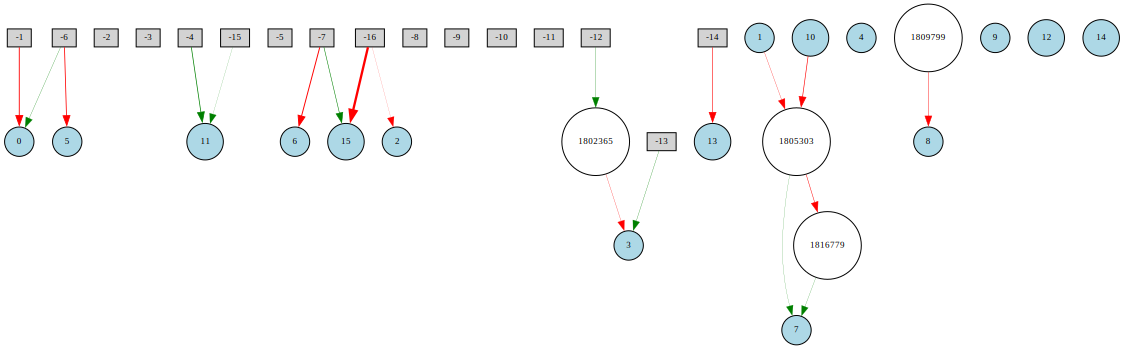

In [23]:
p = neat.Checkpointer.restore_checkpoint('type run 1 save 9990')
winner = p.run(eval_genomes, 1)
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "config-feedforward")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
visualize.draw_net(config, winner, True, prune_unused=True)

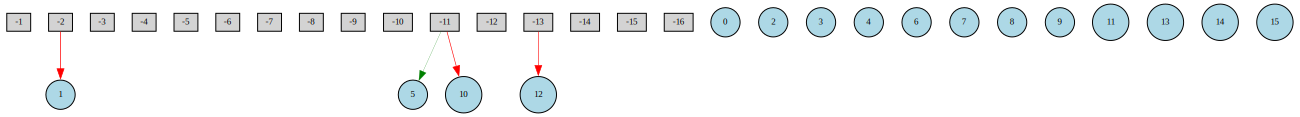

In [24]:
p = neat.Checkpointer.restore_checkpoint('type run 2 save 45010')
winner = p.run(eval_genomes, 1)
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "config-feedforward")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
visualize.draw_net(config, winner, True, prune_unused=True)